In [1]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from tqdm import tqdm
from rdkit.Chem import rdFMCS
from spyrmsd.molecule import Molecule
from spyrmsd.rmsd import rmsdwrapper
import os
from tqdm import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize

def get_tanimoto_similarity(row):
    ligand = row['Docked']
    # Assuming that Template is somehow related to Ligand
    # For example, if templates correspond to ligands directly:
    template = row['Template']
    # Here we would retrieve the similarity based on the Ligand
    # Assuming we want to compare each Ligand with all Ligands and store the score
    # The following just returns the similarity of the Ligand with itself
    try:
        ts = similarity_matrix.loc[ligand, template]
    except:
        ts = None
    return ts
 

def get_mcs_size(row):
    temp = row['Template']
    dock = row['Docked']
    soft_mcs = Chem.MolFromSmarts(rdFMCS.FindMCS([mol_dict[temp],mol_dict[dock]],
                              atomCompare=rdFMCS.AtomCompare.CompareElements,
                              bondCompare=rdFMCS.BondCompare.CompareOrderExact,
                              ringMatchesRingOnly=False,
                              timeout=1).smartsString)
 
    return soft_mcs.GetNumAtoms()

# Load and merge data

In [2]:
original_astex = pd.read_csv('../data/astex_diverse_set.csv')
original_astex['Template'] = original_astex.PDB + '_' + original_astex.Ligand


Astex data set

In [19]:
astex = pd.read_csv('../data/astex_selected_for_docking.csv')
astex['Template'] = astex.PDB + '_' + astex.Lig

astex = astex[astex.UniProt_ID != 'P04818']

# Calculate simiarity matrix
temp_smi_dict = dict(zip(astex.Template, astex.Smiles_String))
mol_dict = {name: Chem.MolFromSmiles(smiles) for name, smiles in temp_smi_dict.items()}
fp_dict = {name: AllChem.GetMorganGenerator(radius=2, fpSize=2048).GetFingerprint(mol) for name, mol in mol_dict.items() if mol is not None}

ligand_names = list(fp_dict.keys())
astex = astex[astex['Template'].isin(ligand_names)]

astex

[00:32:29] Explicit valence for atom # 7 Cl, 5, is greater than permitted
[00:32:29] Explicit valence for atom # 35 O, 2, is greater than permitted


UniProt_ID   PDB  Lig Chain  Resn  \
0        O14757  3TKH  07S     A   325   
1        O14757  4HYH  1AM     A   301   
2        O14757  4HYI  1AO     A   304   
3        O14757  4JIK  1KO     A   301   
4        O14757  3OT3  22K     A     1   
...         ...   ...  ...   ...   ...   
2005     Q8I3X4  1Q1G  MTI     A   301   
2006     Q9GPQ4  1HP0  AD3     A  1315   
2007     Q9GPQ4  3B9G  IMH     A   501   
2008     Q9GPQ4  3EPX  IMQ     A  1002   
2009     Q9GPQ4  3EPW  JMQ     A  1002   

                                          Smiles_String      CHEMBL_ID  \
0     c1cc(cnc1)c2cnc(s2)Nc3cc(ccn3)N4CCN(CC4)CC(=O)...  CHEMBL2011328   
1     COc1ccc2c(c1)C(=O)N(C2)c3nc(cs3)C(=O)Nc4cnccc4...  CHEMBL2381116   
2        c1ccc2c(c1)cnn2c3nc(cs3)C(=O)Nc4ccccc4N5CCNCC5  CHEMBL2381246   
3      c1cc(ccc1c2cn3c(n2)c(cnc3C(=O)N)N[C@H]4CCCNC4)Cl  CHEMBL2381611   
4     Cn1cc(cn1)c2cnn3c2nc(c(c3N)Br)[C@@H]4CCC[C@@H]...            NaN   
...                                                 ...            ...   
2005  CSC[C@@H]1[C@H]([C@H]([C@@H]([NH2+]1)c2c[nH]c3...            NaN   
2006  c1cnc(c2c1n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)C...   CHEMBL202701   
2007  c1c(c2c([nH]1)c(ncn2)O)[C@H]3[C@@H]([C@@H]([C@...   CHEMBL218291   
2008  c1cc2cccnc2c(c1)C[N@]3C[C@@H]([C@@H]([C@H]3CO)O)O   CHEMBL481518   
2009  c1c(c2c([nH]1)C(=O)NC=N2)C[N@]3C[C@@H]([C@@H](...   CHEMBL493456   

               standard_inchi_key target_chembl_id assay_chembl_id  \
0                             NaN              NaN             NaN   
1                             NaN              NaN             NaN   
2     WQIZBWOPEUALCL-UHFFFAOYSA-N       CHEMBL4630   CHEMBL2382857   
3     VUQDZGWRLHHYTB-ZDUSSCGKSA-N       CHEMBL4630   CHEMBL2383906   
4                             NaN              NaN             NaN   
...                           ...              ...             ...   
2005                          NaN              NaN             NaN   
2006                          NaN              NaN             NaN   
2007                          NaN              NaN             NaN   
2008                          NaN              NaN             NaN   
2009                          NaN              NaN             NaN   

      Resolution     Ki   Kd   IC50  Template  
0           1.79    NaN  NaN  47.00  3TKH_07S  
1           1.70    NaN  NaN   1.00  4HYH_1AM  
2           1.40    NaN  NaN   3.00  4HYI_1AO  
3           1.90    NaN  NaN   0.18  4JIK_1KO  
4           1.44    NaN  NaN   0.05  3OT3_22K  
...          ...    ...  ...    ...       ...  
2005        2.02    NaN  2.7    NaN  1Q1G_MTI  
2006        2.10    2.0  NaN    NaN  1HP0_AD3  
2007        1.40  190.0  NaN    NaN  3B9G_IMH  
2008        1.85   10.8  NaN    NaN  3EPX_IMQ  
2009        1.30    4.4  NaN    NaN  3EPW_JMQ  

[2007 rows x 15 columns]

In [21]:
count_df = astex.groupby('UniProt_ID').size().reset_index(name='count')

tot = (count_df['count'] * (count_df['count'])).sum()
tot

np.int64(230291)

In [4]:
ref_dict = {}
for i, uni, name in astex[['UniProt_ID', 'Template']].itertuples():

    mol = Chem.SDMolSupplier(f'../reference_ligands/{uni}/{name}.sdf')[0]
    if mol is not None:
        ref_dict[name] = mol
    else: continue


In [5]:
len(ref_dict)

2007

# Free docking all poses RMSD, flexx and hyde scores

In [6]:
uniprots = astex.UniProt_ID.unique()
fd_flexx_rmsd = []
fd_hyde_rmsd = []

In [7]:

for i, uni in enumerate(uniprots):
    template_df = astex[astex.UniProt_ID == uni]
    templates = template_df.Template.unique()
    print(f'Starting {i+1}/{len(uniprots)}')
    print(f'Templates: {len(templates)}')
    
    for template in templates:
        path_to_docked = f'free_docking/docked/{uni}/docked_in_{template}.sdf'
        path_to_scored = f'free_docking/scored/{uni}/scored_docked_in_{template}.sdf'

        if os.path.exists(path_to_docked) and os.path.getsize(path_to_docked) > 0:

            docked_mols = Chem.SDMolSupplier(path_to_docked)

            for mol in tqdm(docked_mols, total=len(docked_mols)):

                docked = '_'.join(mol.GetProp('_Name').split('_')[:2])
                pose = str(mol.GetProp('_Name').split('_')[2])

                ref_ligand = ref_dict[docked]
                
                rmsd = None
                try:
                    d = Molecule.from_rdkit(ref_ligand)
                    t = Molecule.from_rdkit(mol)

                    rmsd = round(float(rmsdwrapper(d, t)[0]), 3)

                except Exception as e:
                    print(e)

                fd_flexx_rmsd.append({'UniProt_ID': uni,
                                 'Template': template,
                                 'Docked': docked,
                                 'Pose': pose,
                                 'flexx_rmsd': rmsd,
                                 'flexx_score': mol.GetPropsAsDict()['docking-score']}
                                )

        if os.path.exists(path_to_scored) and os.path.getsize(path_to_docked) > 0:

            scored_mols = Chem.SDMolSupplier(path_to_scored)
            for mol in tqdm(scored_mols, total=len(scored_mols)):

                docked = '_'.join(mol.GetProp('_Name').split('_')[:2])
                pose = str(mol.GetProp('_Name').split('_')[2])

                ref_ligand = ref_dict[docked]

                rmsd = None
                try:
                    d = Molecule.from_rdkit(ref_ligand)
                    t = Molecule.from_rdkit(mol)

                    rmsd = round(float(rmsdwrapper(d, t)[0]), 3)

                except Exception as e:
                    print(e)

                fd_hyde_rmsd.append({'UniProt_ID': uni,
                                 'Template': template,
                                 'Docked': docked,
                                 'Pose': pose,    
                                 'hyde_rmsd': rmsd,
                                 'hyde_score': mol.GetPropsAsDict()['BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_UPPER_BOUNDARY [nM]']
                                 })


Starting 1/71
Templates: 73


100%|███████████████████████████████████████| 489/489 [00:00<00:00, 1337.11it/s]


Starting 2/71
Templates: 12


100%|███████████████████████████████████████| 120/120 [00:00<00:00, 1249.81it/s]


Starting 3/71
Templates: 17


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1158.11it/s]


Starting 4/71
Templates: 3


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1942.62it/s]


Starting 5/71
Templates: 22


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1346.33it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1315.82it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1360.17it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1366.95it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1302.87it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1354.62it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1291.37it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1181.62it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1342.13it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1266.91it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1330.11it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1318.06it/s]


100%|███████████████████████████████████████| 196/196 [00:00<00:00, 1276.41it/s]


100%|███████████████████████████████████████| 196/196 [00:00<00:00, 1307.69it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1345.77it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1334.73it/s]


 60%|███████████████████████▏               | 131/220 [00:00<00:00, 1304.09it/s]

 57%|██████████████████████▏                | 125/220 [00:00<00:00, 1243.91it/s]

100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1336.93it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1272.95it/s]


 60%|███████████████████████▍               | 132/220 [00:00<00:00, 1311.63it/s]

100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1365.21it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1276.21it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1352.24it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1383.33it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1254.99it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1298.90it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1306.48it/s]


100%|███████████████████████████████████████| 203/203 [00:00<00:00, 1262.96it/s]


100%|███████████████████████████████████████| 203/203 [00:00<00:00, 1310.01it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1403.44it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1318.44it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1396.82it/s]


 61%|███████████████████████▊               | 134/220 [00:00<00:00, 1332.27it/s]

100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1353.58it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1260.99it/s]


100%|███████████████████████████████████████| 215/215 [00:00<00:00, 1326.57it/s]


 60%|███████████████████████▏               | 128/215 [00:00<00:00, 1275.35it/s]

100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1297.95it/s]


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1239.55it/s]


 59%|██████████████████████▊                | 129/220 [00:00<00:00, 1287.01it/s]

 60%|███████████████████████▏               | 131/220 [00:00<00:00, 1303.00it/s]

 60%|███████████████████████▍               | 132/220 [00:00<00:00, 1310.22it/s]

100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1251.74it/s]












Starting 6/71
Templates: 5


100%|█████████████████████████████████████████| 33/33 [00:00<00:00, 1011.08it/s]


Starting 7/71
Templates: 116


100%|█████████████████████████████████████| 1060/1060 [00:00<00:00, 1109.57it/s]


100%|█████████████████████████████████████| 1140/1140 [00:01<00:00, 1118.53it/s]


Starting 8/71
Templates: 83


100%|████████████████████████████████████████| 730/730 [00:00<00:00, 999.60it/s]


Starting 9/71
Templates: 44


100%|███████████████████████████████████████| 350/350 [00:00<00:00, 1236.87it/s]


Starting 10/71
Templates: 26


100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1756.07it/s]


100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1689.51it/s]


100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1730.80it/s]


100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1730.74it/s]


100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1770.92it/s]


100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1730.25it/s]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 1819.52it/s]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 1749.06it/s]


100%|███████████████████████████████████████| 170/170 [00:00<00:00, 1602.34it/s]


100%|███████████████████████████████████████| 170/170 [00:00<00:00, 1588.46it/s]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 1798.76it/s]


  0%|                                                   | 0/130 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 130/130 [00:00<00:00, 1727.23it/s]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 1817.93it/s]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 1745.99it/s]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 1834.55it/s]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 1765.65it/s]


100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1762.58it/s]


  0%|                                                   | 0/210 [00:00<?, ?it/s]

  0%|                                                   | 0/210 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1751.97it/s]


  0%|                                                   | 0/210 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1708.04it/s]


  0%|                                                   | 0/140 [00:00<?, ?it/s]

  0%|                                                   | 0/140 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1793.12it/s]


 86%|█████████████████████████████████▍     | 180/210 [00:00<00:00, 1791.80it/s]

  0%|                                                   | 0/210 [00:00<?, ?it/s]

  0%|                                                   | 0/210 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1678.48it/s]


  0%|                                                   | 0/210 [00:00<?, ?it/s]

  0%|                                                   | 0/210 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 170/170 [00:00<00:00, 1552.44it/s]


Starting 11/71
Templates: 322


 11%|████▎                                 | 320/2859 [00:00<00:01, 1614.08it/s]

 24%|█████████                             | 683/2859 [00:00<00:01, 1743.43it/s]

 60%|██████████████████████▏              | 1711/2859 [00:01<00:00, 1703.46it/s]

 72%|██████████████████████████▌          | 2051/2859 [00:01<00:00, 1623.86it/s]

 84%|██████████████████████████████▉      | 2392/2859 [00:01<00:00, 1664.29it/s]

100%|█████████████████████████████████████| 2859/2859 [00:01<00:00, 1556.02it/s]


 11%|████                                  | 310/2859 [00:00<00:01, 1562.31it/s]

 28%|██████████▊                           | 812/2859 [00:00<00:01, 1583.15it/s]

 63%|███████████████████████▎             | 1800/2859 [00:01<00:00, 1617.40it/s]

 74%|███████████████████████████▌         | 2125/2859 [00:01<00:00, 1589.75it/s]

 86%|███████████████████████████████▋     | 2453/2859 [00:01<00:00, 1592.10it/s]

100%|█████████████████████████████████████| 2859/2859 [00:01<00:00, 1489.99it/s]


 11%|████▏                                 | 311/2791 [00:00<00:01, 1571.65it/s]

 24%|█████████                             | 665/2791 [00:00<00:01, 1705.00it/s]

 60%|██████████████████████▏              | 1677/2791 [00:01<00:00, 1684.68it/s]

 72%|██████████████████████████▋          | 2012/2791 [00:01<00:00, 1599.35it/s]

 90%|█████████████████████████████████▎   | 2517/2791 [00:01<00:00, 1282.84it/s]

100%|█████████████████████████████████████| 2791/2791 [00:01<00:00, 1540.60it/s]


 11%|████▏                                 | 306/2791 [00:00<00:01, 1544.42it/s]

 23%|████████▊                             | 651/2791 [00:00<00:01, 1670.42it/s]

 59%|█████████████████████▉               | 1653/2791 [00:01<00:00, 1646.13it/s]

 71%|██████████████████████████▏          | 1980/2791 [00:01<00:00, 1548.95it/s]

 83%|██████████████████████████████▋      | 2315/2791 [00:01<00:00, 1563.06it/s]

100%|████████████████████████████████████▉| 2782/2791 [00:01<00:00, 1334.19it/s]

 11%|████▎                                 | 316/2778 [00:00<00:01, 1590.47it/s]

 24%|█████████▏                            | 668/2778 [00:00<00:01, 1697.84it/s]

 60%|██████████████████████▏              | 1670/2778 [00:01<00:00, 1653.79it/s]

 84%|███████████████████████████████      | 2335/2778 [00:01<00:00, 1642.12it/s]

100%|█████████████████████████████████████| 2778/2778 [00:01<00:00, 1520.12it/s]


 11%|████▏                                 | 308/2778 [00:00<00:01, 1557.28it/s]

 24%|████████▉                             | 655/2778 [00:00<00:01, 1675.95it/s]

 59%|█████████████████████▊               | 1636/2778 [00:01<00:00, 1611.92it/s]

 83%|██████████████████████████████▌      | 2297/2778 [00:01<00:00, 1609.69it/s]

 94%|██████████████████████████████████▊  | 2615/2778 [00:01<00:00, 1293.91it/s]

  5%|█▉                                    | 144/2793 [00:00<00:01, 1433.65it/s]

 23%|████████▊                             | 651/2793 [00:00<00:01, 1659.91it/s]

 59%|█████████████████████▉               | 1655/2793 [00:01<00:00, 1666.70it/s]

 83%|██████████████████████████████▊      | 2322/2793 [00:01<00:00, 1614.04it/s]

100%|█████████████████████████████████████| 2793/2793 [00:01<00:00, 1511.46it/s]


 11%|████▏                                 | 312/2793 [00:00<00:01, 1575.20it/s]

 24%|████████▉                             | 657/2793 [00:00<00:01, 1667.30it/s]

 59%|█████████████████████▉               | 1655/2793 [00:01<00:00, 1654.67it/s]

 83%|██████████████████████████████▋      | 2315/2793 [00:01<00:00, 1595.96it/s]

100%|█████████████████████████████████████| 2793/2793 [00:01<00:00, 1506.41it/s]


 11%|████▏                                 | 301/2768 [00:00<00:01, 1523.91it/s]

 29%|███████████▏                          | 815/2768 [00:00<00:01, 1621.22it/s]

 60%|██████████████████████▎              | 1667/2768 [00:01<00:00, 1707.68it/s]

 85%|███████████████████████████████▎     | 2347/2768 [00:01<00:00, 1662.00it/s]

100%|█████████████████████████████████████| 2768/2768 [00:01<00:00, 1535.12it/s]


 11%|████▏                                 | 303/2768 [00:00<00:01, 1532.29it/s]

 23%|████████▉                             | 648/2768 [00:00<00:01, 1666.06it/s]

 60%|██████████████████████               | 1654/2768 [00:01<00:00, 1673.58it/s]

 84%|███████████████████████████████      | 2322/2768 [00:01<00:00, 1624.34it/s]

100%|█████████████████████████████████████| 2768/2768 [00:01<00:00, 1511.32it/s]


 15%|█████▋                                | 322/2136 [00:00<00:01, 1573.89it/s]

 31%|███████████▌                          | 653/2136 [00:00<00:00, 1581.82it/s]

 69%|█████████████████████████▍           | 1469/2136 [00:00<00:00, 1586.94it/s]

100%|█████████████████████████████████████| 2136/2136 [00:01<00:00, 1453.85it/s]


 15%|█████▌                                | 310/2136 [00:00<00:01, 1537.08it/s]

 29%|███████████                           | 621/2136 [00:00<00:00, 1532.73it/s]

 66%|████████████████████████▌            | 1420/2136 [00:00<00:00, 1596.98it/s]

100%|█████████████████████████████████████| 2136/2136 [00:01<00:00, 1429.62it/s]


 16%|██████                                | 325/2023 [00:00<00:01, 1623.89it/s]

 33%|████████████▎                         | 658/2023 [00:00<00:00, 1630.45it/s]

 65%|████████████████████████▏            | 1320/2023 [00:00<00:00, 1635.78it/s]

100%|█████████████████████████████████████| 2023/2023 [00:01<00:00, 1472.14it/s]


 15%|█████▊                                | 309/2023 [00:00<00:01, 1542.37it/s]

 31%|███████████▋                          | 619/2023 [00:00<00:00, 1540.33it/s]

 63%|███████████████████████▍             | 1284/2023 [00:00<00:00, 1617.02it/s]

100%|█████████████████████████████████████| 2023/2023 [00:01<00:00, 1429.67it/s]


100%|███████████████████████████████████████| 347/347 [00:00<00:00, 1558.16it/s]


100%|███████████████████████████████████████| 347/347 [00:00<00:00, 1510.51it/s]


 11%|████▏                                 | 308/2775 [00:00<00:01, 1550.16it/s]

 24%|█████████                             | 661/2775 [00:00<00:01, 1703.11it/s]

 61%|██████████████████████▍              | 1683/2775 [00:01<00:00, 1699.69it/s]

 85%|███████████████████████████████▍     | 2355/2775 [00:01<00:00, 1637.37it/s]

 96%|███████████████████████████████████▋ | 2676/2775 [00:01<00:00, 1350.85it/s]

 11%|████                                  | 296/2775 [00:00<00:01, 1494.26it/s]

 29%|███████████                           | 804/2775 [00:00<00:01, 1544.64it/s]

 58%|█████████████████████▍               | 1609/2775 [00:01<00:00, 1618.87it/s]

 70%|█████████████████████████▋           | 1930/2775 [00:01<00:00, 1516.48it/s]

 82%|██████████████████████████████▏      | 2262/2775 [00:01<00:00, 1552.93it/s]

 99%|████████████████████████████████████▍| 2737/2775 [00:01<00:00, 1319.94it/s]

100%|█████████████████████████████████████| 2775/2775 [00:01<00:00, 1458.21it/s]


 62%|████████████████████████▏              | 161/260 [00:00<00:00, 1605.65it/s]

  0%|                                                   | 0/260 [00:00<?, ?it/s]

 11%|████▏                                 | 309/2822 [00:00<00:01, 1558.67it/s]

 23%|████████▉                             | 660/2822 [00:00<00:01, 1695.42it/s]

 59%|█████████████████████▉               | 1677/2822 [00:01<00:00, 1693.31it/s]

 71%|██████████████████████████▍          | 2013/2822 [00:01<00:00, 1587.68it/s]

 83%|██████████████████████████████▊      | 2347/2822 [00:01<00:00, 1625.75it/s]

100%|█████████████████████████████████████| 2822/2822 [00:01<00:00, 1540.78it/s]


 11%|████                                  | 300/2822 [00:00<00:01, 1508.36it/s]

 29%|██████████▉                           | 809/2822 [00:00<00:01, 1592.69it/s]

 58%|█████████████████████▍               | 1631/2822 [00:01<00:00, 1626.41it/s]

 75%|███████████████████████████▊         | 2117/2822 [00:01<00:00, 1569.26it/s]

 86%|███████████████████████████████▊     | 2431/2822 [00:01<00:00, 1555.46it/s]

100%|█████████████████████████████████████| 2822/2822 [00:01<00:00, 1487.24it/s]


 11%|████▏                                 | 311/2810 [00:00<00:01, 1570.01it/s]

 24%|█████████                             | 667/2810 [00:00<00:01, 1707.80it/s]

 60%|██████████████████████▎              | 1697/2810 [00:01<00:00, 1723.10it/s]

 85%|███████████████████████████████▎     | 2379/2810 [00:01<00:00, 1672.61it/s]

100%|█████████████████████████████████████| 2810/2810 [00:01<00:00, 1558.41it/s]


 11%|████▏                                 | 309/2810 [00:00<00:01, 1558.92it/s]

 23%|████████▊                             | 655/2810 [00:00<00:01, 1669.56it/s]

 59%|█████████████████████▉               | 1668/2810 [00:01<00:00, 1687.09it/s]

 83%|██████████████████████████████▊      | 2341/2810 [00:01<00:00, 1641.89it/s]

100%|█████████████████████████████████████| 2810/2810 [00:01<00:00, 1528.32it/s]


100%|███████████████████████████████████████| 160/160 [00:00<00:00, 1902.64it/s]


100%|███████████████████████████████████████| 160/160 [00:00<00:00, 1829.76it/s]


100%|███████████████████████████████████████| 357/357 [00:00<00:00, 1413.74it/s]


100%|███████████████████████████████████████| 357/357 [00:00<00:00, 1383.73it/s]


100%|███████████████████████████████████████| 320/320 [00:00<00:00, 1430.41it/s]


100%|███████████████████████████████████████| 320/320 [00:00<00:00, 1393.17it/s]


  7%|██▍                                   | 167/2564 [00:00<00:01, 1660.49it/s]

 28%|██████████▌                           | 716/2564 [00:00<00:01, 1733.39it/s]

 63%|███████████████████████▍             | 1624/2564 [00:00<00:00, 1815.26it/s]

 84%|███████████████████████████████      | 2153/2564 [00:01<00:00, 1719.09it/s]

100%|█████████████████████████████████████| 2564/2564 [00:01<00:00, 1628.52it/s]


 12%|████▋                                 | 318/2564 [00:00<00:01, 1526.37it/s]

 26%|█████████▉                            | 672/2564 [00:00<00:01, 1671.42it/s]

 60%|██████████████████████▎              | 1546/2564 [00:00<00:00, 1750.54it/s]

 80%|█████████████████████████████▋       | 2061/2564 [00:01<00:00, 1659.48it/s]

100%|█████████████████████████████████████| 2564/2564 [00:01<00:00, 1579.86it/s]


 12%|████▍                                 | 317/2704 [00:00<00:01, 1589.19it/s]

 25%|█████████▍                            | 675/2704 [00:00<00:01, 1695.66it/s]

 63%|███████████████████████▏             | 1696/2704 [00:01<00:00, 1709.65it/s]

 82%|██████████████████████████████▎      | 2212/2704 [00:01<00:00, 1659.86it/s]

100%|█████████████████████████████████████| 2704/2704 [00:01<00:00, 1558.67it/s]


 12%|████▍                                 | 312/2704 [00:00<00:01, 1568.33it/s]

 24%|█████████▎                            | 660/2704 [00:00<00:01, 1672.67it/s]

 61%|██████████████████████▋              | 1657/2704 [00:01<00:00, 1670.72it/s]

 86%|███████████████████████████████▋     | 2315/2704 [00:01<00:00, 1582.67it/s]

100%|█████████████████████████████████████| 2704/2704 [00:01<00:00, 1510.50it/s]


 11%|████                                  | 288/2730 [00:00<00:01, 1456.59it/s]

 29%|███████████                           | 794/2730 [00:00<00:01, 1580.60it/s]

 59%|█████████████████████▉               | 1619/2730 [00:01<00:00, 1649.40it/s]

 71%|██████████████████████████▍          | 1949/2730 [00:01<00:00, 1587.58it/s]

 84%|██████████████████████████████▉      | 2283/2730 [00:01<00:00, 1626.82it/s]

 95%|███████████████████████████████████▎ | 2603/2730 [00:01<00:00, 1359.76it/s]

 11%|████                                  | 295/2730 [00:00<00:01, 1491.97it/s]

 30%|███████████▎                          | 811/2730 [00:00<00:01, 1617.58it/s]

 60%|██████████████████████▏              | 1635/2730 [00:01<00:00, 1653.74it/s]

 72%|██████████████████████████▌          | 1962/2730 [00:01<00:00, 1595.21it/s]

 84%|███████████████████████████████      | 2296/2730 [00:01<00:00, 1632.70it/s]

 96%|███████████████████████████████████▍ | 2612/2730 [00:01<00:00, 1348.40it/s]

 10%|███▉                                  | 302/2900 [00:00<00:01, 1514.37it/s]

 28%|██████████▋                           | 813/2900 [00:00<00:01, 1590.77it/s]

 63%|███████████████████████▏             | 1818/2900 [00:01<00:00, 1611.35it/s]

 74%|███████████████████████████▍         | 2149/2900 [00:01<00:00, 1590.89it/s]

 85%|███████████████████████████████▌     | 2471/2900 [00:01<00:00, 1587.32it/s]

 96%|███████████████████████████████████▌ | 2788/2900 [00:01<00:00, 1325.70it/s]

100%|█████████████████████████████████████| 2900/2900 [00:01<00:00, 1489.94it/s]


 10%|███▉                                  | 299/2900 [00:00<00:01, 1505.29it/s]

 28%|██████████▋                           | 817/2900 [00:00<00:01, 1614.64it/s]

 61%|██████████████████████▋              | 1775/2900 [00:01<00:00, 1574.57it/s]

 72%|██████████████████████████▋          | 2089/2900 [00:01<00:00, 1535.14it/s]

 83%|██████████████████████████████▋      | 2409/2900 [00:01<00:00, 1571.35it/s]

 94%|██████████████████████████████████▊  | 2732/2900 [00:01<00:00, 1316.46it/s]

 11%|████▎                                 | 316/2787 [00:00<00:01, 1587.21it/s]

 24%|█████████▏                            | 676/2787 [00:00<00:01, 1727.32it/s]

 61%|██████████████████████▋              | 1708/2787 [00:01<00:00, 1738.81it/s]

 86%|███████████████████████████████▊     | 2397/2787 [00:01<00:00, 1675.21it/s]

100%|█████████████████████████████████████| 2787/2787 [00:01<00:00, 1570.97it/s]


  5%|█▉                                    | 144/2787 [00:00<00:01, 1433.10it/s]

 24%|████████▉                             | 660/2787 [00:00<00:01, 1683.42it/s]

 60%|██████████████████████               | 1661/2787 [00:01<00:00, 1655.56it/s]

 71%|██████████████████████████▍          | 1988/2787 [00:01<00:00, 1546.59it/s]

 84%|██████████████████████████████▉      | 2328/2787 [00:01<00:00, 1618.23it/s]

100%|█████████████████████████████████████| 2787/2787 [00:01<00:00, 1517.89it/s]


 12%|████▋                                 | 328/2643 [00:00<00:01, 1604.57it/s]

 26%|█████████▉                            | 695/2643 [00:00<00:01, 1736.23it/s]

 60%|██████████████████████▏              | 1583/2643 [00:00<00:00, 1756.30it/s]

 86%|███████████████████████████████▉     | 2280/2643 [00:01<00:00, 1685.54it/s]

100%|█████████████████████████████████████| 2643/2643 [00:01<00:00, 1525.36it/s]


  6%|██▎                                   | 161/2643 [00:00<00:01, 1605.62it/s]

 26%|█████████▋                            | 676/2643 [00:00<00:01, 1669.16it/s]

 64%|███████████████████████▊             | 1703/2643 [00:01<00:00, 1681.72it/s]

 84%|███████████████████████████████      | 2216/2643 [00:01<00:00, 1658.83it/s]

100%|█████████████████████████████████████| 2643/2643 [00:01<00:00, 1536.40it/s]


 14%|█████▏                                | 335/2436 [00:00<00:01, 1679.73it/s]

 29%|███████████▏                          | 715/2436 [00:00<00:01, 1701.50it/s]

 66%|████████████████████████▍            | 1609/2436 [00:00<00:00, 1749.47it/s]

 80%|█████████████████████████████▋       | 1957/2436 [00:01<00:00, 1709.06it/s]

100%|█████████████████████████████████████| 2436/2436 [00:01<00:00, 1597.43it/s]


 13%|█████                                 | 323/2436 [00:00<00:01, 1613.77it/s]

 28%|██████████▊                           | 692/2436 [00:00<00:01, 1690.35it/s]

 64%|███████████████████████▌             | 1553/2436 [00:00<00:00, 1729.90it/s]

 85%|███████████████████████████████▌     | 2082/2436 [00:01<00:00, 1708.42it/s]

100%|█████████████████████████████████████| 2436/2436 [00:01<00:00, 1565.55it/s]


 13%|████▉                                 | 314/2417 [00:00<00:01, 1561.46it/s]

 28%|██████████▋                           | 677/2417 [00:00<00:01, 1672.95it/s]

 65%|████████████████████████             | 1573/2417 [00:00<00:00, 1743.09it/s]

 86%|███████████████████████████████▉     | 2086/2417 [00:01<00:00, 1656.21it/s]

100%|█████████████████████████████████████| 2417/2417 [00:01<00:00, 1567.67it/s]


 13%|████▉                                 | 318/2417 [00:00<00:01, 1588.95it/s]

 28%|██████████▊                           | 686/2417 [00:00<00:01, 1672.24it/s]

 64%|███████████████████████▌             | 1542/2417 [00:00<00:00, 1692.72it/s]

 85%|███████████████████████████████▌     | 2059/2417 [00:01<00:00, 1687.42it/s]

100%|█████████████████████████████████████| 2417/2417 [00:01<00:00, 1548.42it/s]


 11%|███▉                                  | 295/2809 [00:00<00:01, 1486.00it/s]

 28%|██████████▊                           | 798/2809 [00:00<00:01, 1573.71it/s]

 59%|█████████████████████▋               | 1645/2809 [00:01<00:00, 1692.73it/s]

 82%|██████████████████████████████▌      | 2317/2809 [00:01<00:00, 1565.88it/s]

100%|█████████████████████████████████████| 2809/2809 [00:01<00:00, 1504.17it/s]


 11%|████▏                                 | 311/2809 [00:00<00:01, 1569.22it/s]

 23%|████████▊                             | 655/2809 [00:00<00:01, 1673.22it/s]

 59%|█████████████████████▉               | 1665/2809 [00:01<00:00, 1676.86it/s]

 71%|██████████████████████████▎          | 1999/2809 [00:01<00:00, 1572.21it/s]

 83%|██████████████████████████████▋      | 2333/2809 [00:01<00:00, 1616.58it/s]

100%|█████████████████████████████████████| 2809/2809 [00:01<00:00, 1515.66it/s]


 11%|████▏                                 | 314/2812 [00:00<00:01, 1581.77it/s]

 24%|█████████                             | 666/2812 [00:00<00:01, 1705.65it/s]

 60%|██████████████████████▎              | 1693/2812 [00:01<00:00, 1700.01it/s]

 72%|██████████████████████████▋          | 2032/2812 [00:01<00:00, 1580.30it/s]

 84%|██████████████████████████████▉      | 2355/2812 [00:01<00:00, 1586.13it/s]

100%|█████████████████████████████████████| 2812/2812 [00:01<00:00, 1513.96it/s]


 11%|████                                  | 301/2812 [00:00<00:01, 1516.23it/s]

 29%|██████████▉                           | 813/2812 [00:00<00:01, 1617.20it/s]

 58%|█████████████████████▌               | 1643/2812 [00:01<00:00, 1639.07it/s]

 70%|█████████████████████████▉           | 1972/2812 [00:01<00:00, 1566.90it/s]

 82%|██████████████████████████████▎      | 2306/2812 [00:01<00:00, 1582.37it/s]

100%|█████████████████████████████████████| 2812/2812 [00:01<00:00, 1509.32it/s]


100%|███████████████████████████████████████| 160/160 [00:00<00:00, 1918.33it/s]


100%|███████████████████████████████████████| 160/160 [00:00<00:00, 1809.57it/s]


 13%|████▉                                 | 327/2535 [00:00<00:01, 1614.18it/s]

 28%|██████████▌                           | 702/2535 [00:00<00:01, 1741.62it/s]

 62%|██████████████████████▊              | 1566/2535 [00:00<00:00, 1681.20it/s]

 88%|████████████████████████████████▌    | 2230/2535 [00:01<00:00, 1480.85it/s]

100%|█████████████████████████████████████| 2535/2535 [00:01<00:00, 1549.19it/s]


 13%|████▊                                 | 324/2535 [00:00<00:01, 1594.13it/s]

 27%|██████████▏                           | 683/2535 [00:00<00:01, 1693.97it/s]

 61%|██████████████████████▌              | 1547/2535 [00:00<00:00, 1714.52it/s]

 88%|████████████████████████████████▍    | 2224/2535 [00:01<00:00, 1476.65it/s]

100%|█████████████████████████████████████| 2535/2535 [00:01<00:00, 1532.55it/s]


 12%|████▎                                 | 310/2694 [00:00<00:01, 1565.10it/s]

 25%|█████████▎                            | 662/2694 [00:00<00:01, 1693.34it/s]

 63%|███████████████████████▏             | 1689/2694 [00:01<00:00, 1727.60it/s]

 82%|██████████████████████████████▎      | 2204/2694 [00:01<00:00, 1660.73it/s]

100%|█████████████████████████████████████| 2694/2694 [00:01<00:00, 1554.43it/s]


 11%|████▎                                 | 305/2694 [00:00<00:01, 1546.62it/s]

 24%|█████████▎                            | 657/2694 [00:00<00:01, 1689.13it/s]

 62%|██████████████████████▉              | 1667/2694 [00:01<00:00, 1689.11it/s]

 87%|████████████████████████████████     | 2337/2694 [00:01<00:00, 1612.78it/s]

100%|█████████████████████████████████████| 2694/2694 [00:01<00:00, 1519.87it/s]


 12%|████▌                                 | 319/2628 [00:00<00:01, 1593.46it/s]

 26%|█████████▊                            | 675/2628 [00:00<00:01, 1707.57it/s]

 66%|████████████████████████▏            | 1722/2628 [00:01<00:00, 1717.22it/s]

 85%|███████████████████████████████▌     | 2245/2628 [00:01<00:00, 1709.46it/s]

100%|█████████████████████████████████████| 2628/2628 [00:01<00:00, 1571.49it/s]


 11%|████▎                                 | 297/2628 [00:00<00:01, 1497.64it/s]

 25%|█████████▎                            | 648/2628 [00:00<00:01, 1665.09it/s]

 63%|███████████████████████▎             | 1657/2628 [00:01<00:00, 1701.15it/s]

 82%|██████████████████████████████▍      | 2163/2628 [00:01<00:00, 1630.63it/s]

100%|█████████████████████████████████████| 2628/2628 [00:01<00:00, 1520.50it/s]


  5%|█▉                                    | 138/2780 [00:00<00:01, 1367.55it/s]

 29%|███████████                           | 807/2780 [00:00<00:01, 1621.05it/s]

 60%|██████████████████████               | 1658/2780 [00:01<00:00, 1703.57it/s]

 72%|██████████████████████████▌          | 1994/2780 [00:01<00:00, 1558.18it/s]

 84%|██████████████████████████████▉      | 2324/2780 [00:01<00:00, 1600.88it/s]

100%|█████████████████████████████████████| 2780/2780 [00:01<00:00, 1525.19it/s]


 11%|████▏                                 | 308/2780 [00:00<00:01, 1560.69it/s]

 23%|████████▉                             | 653/2780 [00:00<00:01, 1672.16it/s]

 60%|██████████████████████               | 1658/2780 [00:01<00:00, 1674.70it/s]

 72%|██████████████████████████▍          | 1990/2780 [00:01<00:00, 1569.92it/s]

 84%|██████████████████████████████▉      | 2328/2780 [00:01<00:00, 1624.38it/s]

100%|█████████████████████████████████████| 2780/2780 [00:01<00:00, 1522.23it/s]


 11%|████▎                                 | 316/2794 [00:00<00:01, 1596.07it/s]

 24%|█████████▏                            | 672/2794 [00:00<00:01, 1717.71it/s]

 61%|██████████████████████▍              | 1694/2794 [00:01<00:00, 1704.64it/s]

 85%|███████████████████████████████▍     | 2376/2794 [00:01<00:00, 1669.12it/s]

100%|█████████████████████████████████████| 2794/2794 [00:01<00:00, 1552.84it/s]


 11%|████▏                                 | 311/2794 [00:00<00:01, 1560.81it/s]

 23%|████████▉                             | 653/2794 [00:00<00:01, 1666.73it/s]

 59%|█████████████████████▋               | 1636/2794 [00:01<00:00, 1589.68it/s]

 70%|█████████████████████████▊           | 1951/2794 [00:01<00:00, 1492.66it/s]

 87%|████████████████████████████████     | 2424/2794 [00:01<00:00, 1496.59it/s]

100%|█████████████████████████████████████| 2794/2794 [00:01<00:00, 1480.31it/s]


 11%|████▎                                 | 313/2777 [00:00<00:01, 1582.13it/s]

 24%|█████████▏                            | 670/2777 [00:00<00:01, 1720.51it/s]

 61%|██████████████████████▋              | 1702/2777 [00:01<00:00, 1727.09it/s]

 86%|███████████████████████████████▊     | 2385/2777 [00:01<00:00, 1649.13it/s]

100%|█████████████████████████████████████| 2777/2777 [00:01<00:00, 1553.72it/s]


 11%|████                                  | 300/2777 [00:00<00:01, 1517.18it/s]

 23%|████████▊                             | 646/2777 [00:00<00:01, 1664.83it/s]

 60%|██████████████████████               | 1653/2777 [00:01<00:00, 1683.36it/s]

 72%|██████████████████████████▍          | 1988/2777 [00:01<00:00, 1591.88it/s]

 84%|██████████████████████████████▉      | 2323/2777 [00:01<00:00, 1633.24it/s]

100%|█████████████████████████████████████| 2777/2777 [00:01<00:00, 1520.08it/s]


 12%|████▌                                 | 320/2646 [00:00<00:01, 1598.75it/s]

 25%|█████████▍                            | 658/2646 [00:00<00:01, 1660.80it/s]

 64%|███████████████████████▌             | 1686/2646 [00:01<00:00, 1738.31it/s]

 83%|██████████████████████████████▊      | 2205/2646 [00:01<00:00, 1681.48it/s]

100%|█████████████████████████████████████| 2646/2646 [00:01<00:00, 1552.04it/s]


 12%|████▌                                 | 321/2646 [00:00<00:01, 1602.82it/s]

 26%|█████████▋                            | 675/2646 [00:00<00:01, 1677.20it/s]

 64%|███████████████████████▋             | 1696/2646 [00:01<00:00, 1703.39it/s]

 84%|██████████████████████████████▉      | 2216/2646 [00:01<00:00, 1685.97it/s]

100%|█████████████████████████████████████| 2646/2646 [00:01<00:00, 1555.37it/s]


 11%|████▎                                 | 317/2766 [00:00<00:01, 1594.35it/s]

 24%|█████████▏                            | 671/2766 [00:00<00:01, 1701.60it/s]

 61%|██████████████████████▌              | 1688/2766 [00:01<00:00, 1681.54it/s]

 73%|███████████████████████████          | 2023/2766 [00:01<00:00, 1628.50it/s]

 85%|███████████████████████████████▍     | 2352/2766 [00:01<00:00, 1631.97it/s]

 96%|███████████████████████████████████▋ | 2669/2766 [00:01<00:00, 1333.54it/s]

 11%|████▏                                 | 305/2766 [00:00<00:01, 1540.94it/s]

 23%|████████▉                             | 650/2766 [00:00<00:01, 1670.53it/s]

 60%|██████████████████████               | 1648/2766 [00:01<00:00, 1669.81it/s]

 83%|██████████████████████████████▊      | 2306/2766 [00:01<00:00, 1610.13it/s]

 95%|███████████████████████████████████▏ | 2626/2766 [00:01<00:00, 1324.60it/s]

 11%|████                                  | 300/2790 [00:00<00:01, 1511.60it/s]

 29%|███████████▏                          | 818/2790 [00:00<00:01, 1640.77it/s]

 60%|██████████████████████               | 1668/2790 [00:01<00:00, 1717.01it/s]

 84%|███████████████████████████████▏     | 2348/2790 [00:01<00:00, 1665.16it/s]

 95%|███████████████████████████████████▎ | 2662/2790 [00:01<00:00, 1257.63it/s]

100%|█████████████████████████████████████| 2790/2790 [00:01<00:00, 1492.01it/s]


 11%|████                                  | 300/2790 [00:00<00:01, 1513.40it/s]

 28%|██████████▋                           | 783/2790 [00:00<00:01, 1477.62it/s]

 56%|████████████████████▊                | 1570/2790 [00:01<00:00, 1554.07it/s]

 73%|███████████████████████████▏         | 2047/2790 [00:01<00:00, 1536.00it/s]

 85%|███████████████████████████████▎     | 2365/2790 [00:01<00:00, 1564.43it/s]

 95%|███████████████████████████████████▎ | 2664/2790 [00:01<00:00, 1251.51it/s]

 11%|████▏                                 | 302/2731 [00:00<00:01, 1514.65it/s]

 23%|████████▊                             | 635/2731 [00:00<00:01, 1618.91it/s]

 59%|█████████████████████▉               | 1619/2731 [00:01<00:00, 1645.37it/s]

 83%|██████████████████████████████▊      | 2275/2731 [00:01<00:00, 1581.04it/s]

100%|█████████████████████████████████████| 2731/2731 [00:01<00:00, 1461.84it/s]


 10%|███▉                                  | 286/2731 [00:00<00:01, 1448.25it/s]

 29%|██████████▉                           | 787/2731 [00:00<00:01, 1538.68it/s]

 63%|███████████████████████▏             | 1716/2731 [00:01<00:00, 1543.96it/s]

 74%|███████████████████████████▍         | 2022/2731 [00:01<00:00, 1489.55it/s]

 86%|███████████████████████████████▋     | 2339/2731 [00:01<00:00, 1507.33it/s]

100%|█████████████████████████████████████| 2731/2731 [00:01<00:00, 1413.20it/s]


 10%|███▊                                  | 282/2818 [00:00<00:01, 1414.91it/s]

 27%|██████████▎                           | 763/2818 [00:00<00:01, 1492.30it/s]

 59%|█████████████████████▉               | 1671/2818 [00:01<00:00, 1507.50it/s]

 70%|█████████████████████████▉           | 1973/2818 [00:01<00:00, 1442.82it/s]

 86%|███████████████████████████████▉     | 2437/2818 [00:01<00:00, 1488.31it/s]

100%|█████████████████████████████████████| 2818/2818 [00:02<00:00, 1393.56it/s]


 11%|████                                  | 304/2818 [00:00<00:01, 1532.17it/s]

 29%|██████████▉                           | 810/2818 [00:00<00:01, 1590.65it/s]

 58%|█████████████████████▌               | 1640/2818 [00:01<00:00, 1640.43it/s]

 70%|█████████████████████████▊           | 1969/2818 [00:01<00:00, 1565.94it/s]

 82%|██████████████████████████████▏      | 2299/2818 [00:01<00:00, 1554.31it/s]

100%|█████████████████████████████████████| 2818/2818 [00:01<00:00, 1491.62it/s]


 11%|████▏                                 | 309/2775 [00:00<00:01, 1551.15it/s]

 24%|█████████                             | 665/2775 [00:00<00:01, 1698.05it/s]

 60%|██████████████████████               | 1656/2775 [00:01<00:00, 1580.47it/s]

 71%|██████████████████████████▎          | 1973/2775 [00:01<00:00, 1501.75it/s]

 83%|██████████████████████████████▋      | 2300/2775 [00:01<00:00, 1547.79it/s]

100%|█████████████████████████████████████| 2775/2775 [00:01<00:00, 1485.44it/s]


 11%|████▏                                 | 302/2775 [00:00<00:01, 1523.64it/s]

 29%|██████████▊                           | 791/2775 [00:00<00:01, 1560.40it/s]

 63%|███████████████████████▍             | 1762/2775 [00:01<00:00, 1610.34it/s]

 75%|███████████████████████████▊         | 2087/2775 [00:01<00:00, 1574.51it/s]

 87%|████████████████████████████████     | 2402/2775 [00:01<00:00, 1554.93it/s]

100%|█████████████████████████████████████| 2775/2775 [00:01<00:00, 1483.73it/s]


 11%|████▎                                 | 300/2659 [00:00<00:01, 1513.33it/s]

 24%|█████████▎                            | 649/2659 [00:00<00:01, 1626.60it/s]

 60%|██████████████████████▍              | 1608/2659 [00:01<00:00, 1563.11it/s]

 72%|██████████████████████████▋          | 1918/2659 [00:01<00:00, 1513.22it/s]

 84%|███████████████████████████████▏     | 2237/2659 [00:01<00:00, 1553.38it/s]

100%|█████████████████████████████████████| 2659/2659 [00:01<00:00, 1449.42it/s]


 11%|████                                  | 285/2659 [00:00<00:01, 1454.04it/s]

 23%|████████▊                             | 621/2659 [00:00<00:01, 1605.30it/s]

 59%|█████████████████████▊               | 1568/2659 [00:01<00:00, 1577.32it/s]

 71%|██████████████████████████▏          | 1882/2659 [00:01<00:00, 1478.36it/s]

 83%|██████████████████████████████▋      | 2205/2659 [00:01<00:00, 1538.78it/s]

 95%|███████████████████████████████████  | 2518/2659 [00:01<00:00, 1263.79it/s]

 11%|████▏                                 | 307/2756 [00:00<00:01, 1552.42it/s]

 23%|████████▉                             | 645/2756 [00:00<00:01, 1635.25it/s]

 58%|█████████████████████▌               | 1609/2756 [00:01<00:00, 1576.78it/s]

 70%|█████████████████████████▊           | 1924/2756 [00:01<00:00, 1510.01it/s]

 82%|██████████████████████████████▎      | 2254/2756 [00:01<00:00, 1551.25it/s]

100%|█████████████████████████████████████| 2756/2756 [00:01<00:00, 1474.65it/s]


 11%|████                                  | 291/2756 [00:00<00:01, 1461.99it/s]

 22%|████████▌                             | 618/2756 [00:00<00:01, 1582.40it/s]

 58%|█████████████████████▌               | 1605/2756 [00:01<00:00, 1651.11it/s]

 70%|█████████████████████████▉           | 1934/2756 [00:01<00:00, 1561.70it/s]

 82%|██████████████████████████████▍      | 2267/2756 [00:01<00:00, 1571.25it/s]

100%|█████████████████████████████████████| 2756/2756 [00:01<00:00, 1472.35it/s]


 11%|████▏                                 | 308/2807 [00:00<00:01, 1549.23it/s]

 23%|████████▋                             | 644/2807 [00:00<00:01, 1643.79it/s]

 63%|███████████████████████▎             | 1770/2807 [00:01<00:00, 1592.75it/s]

 75%|███████████████████████████▌         | 2092/2807 [00:01<00:00, 1552.63it/s]

 86%|███████████████████████████████▋     | 2406/2807 [00:01<00:00, 1535.36it/s]

100%|█████████████████████████████████████| 2807/2807 [00:01<00:00, 1466.90it/s]


 11%|████                                  | 303/2807 [00:00<00:01, 1531.12it/s]

 23%|████████▌                             | 637/2807 [00:00<00:01, 1632.36it/s]

 62%|██████████████████████▊              | 1729/2807 [00:01<00:00, 1538.30it/s]

 72%|██████████████████████████▊          | 2035/2807 [00:01<00:00, 1486.78it/s]

 84%|██████████████████████████████▉      | 2345/2807 [00:01<00:00, 1513.35it/s]

 94%|██████████████████████████████████▉  | 2652/2807 [00:01<00:00, 1239.39it/s]

 10%|███▊                                  | 277/2806 [00:00<00:01, 1386.03it/s]

 26%|██████████                            | 743/2806 [00:00<00:01, 1450.38it/s]

 60%|██████████████████████               | 1672/2806 [00:01<00:00, 1577.18it/s]

 71%|██████████████████████████▏          | 1986/2806 [00:01<00:00, 1413.58it/s]

 82%|██████████████████████████████▏      | 2292/2806 [00:01<00:00, 1436.13it/s]

100%|█████████████████████████████████████| 2806/2806 [00:02<00:00, 1386.50it/s]


 10%|███▉                                  | 287/2806 [00:00<00:01, 1439.09it/s]

 28%|██████████▌                           | 777/2806 [00:00<00:01, 1504.80it/s]

 62%|██████████████████████▉              | 1735/2806 [00:01<00:00, 1591.91it/s]

 73%|███████████████████████████          | 2050/2806 [00:01<00:00, 1465.01it/s]

 84%|███████████████████████████████      | 2353/2806 [00:01<00:00, 1462.42it/s]

100%|█████████████████████████████████████| 2806/2806 [00:01<00:00, 1421.16it/s]


 12%|████▋                                 | 314/2516 [00:00<00:01, 1578.68it/s]

 31%|███████████▉                          | 787/2516 [00:00<00:01, 1554.21it/s]

 63%|███████████████████████▍             | 1591/2516 [00:01<00:00, 1585.43it/s]

 83%|██████████████████████████████▌      | 2076/2516 [00:01<00:00, 1531.81it/s]

100%|█████████████████████████████████████| 2516/2516 [00:01<00:00, 1442.86it/s]


 12%|████▋                                 | 308/2516 [00:00<00:01, 1541.01it/s]

 30%|███████████▌                          | 767/2516 [00:00<00:01, 1494.29it/s]

 61%|██████████████████████▋              | 1539/2516 [00:01<00:00, 1533.25it/s]

 85%|███████████████████████████████▍     | 2137/2516 [00:01<00:00, 1447.56it/s]

 96%|███████████████████████████████████▋ | 2426/2516 [00:01<00:00, 1187.96it/s]

 11%|████▎                                 | 297/2619 [00:00<00:01, 1500.34it/s]

 25%|█████████▍                            | 654/2619 [00:00<00:01, 1681.18it/s]

 64%|███████████████████████▌             | 1671/2619 [00:01<00:00, 1660.95it/s]

 83%|██████████████████████████████▌      | 2161/2619 [00:01<00:00, 1588.72it/s]

100%|█████████████████████████████████████| 2619/2619 [00:01<00:00, 1481.12it/s]


 11%|████▏                                 | 291/2619 [00:00<00:01, 1475.27it/s]

 24%|█████████▏                            | 636/2619 [00:00<00:01, 1632.41it/s]

 61%|██████████████████████▌              | 1595/2619 [00:01<00:00, 1601.38it/s]

 73%|███████████████████████████          | 1912/2619 [00:01<00:00, 1533.81it/s]

 85%|███████████████████████████████▍     | 2226/2619 [00:01<00:00, 1527.54it/s]

 96%|███████████████████████████████████▌ | 2513/2619 [00:01<00:00, 1183.79it/s]

 11%|████▏                                 | 282/2574 [00:00<00:01, 1431.91it/s]

 24%|█████████▏                            | 625/2574 [00:00<00:01, 1618.94it/s]

 64%|███████████████████████▌             | 1637/2574 [00:01<00:00, 1651.32it/s]

 83%|██████████████████████████████▋      | 2138/2574 [00:01<00:00, 1623.77it/s]

100%|█████████████████████████████████████| 2574/2574 [00:01<00:00, 1461.57it/s]


 12%|████▍                                 | 297/2574 [00:00<00:01, 1501.59it/s]

 25%|█████████▍                            | 641/2574 [00:00<00:01, 1589.44it/s]

 62%|██████████████████████▊              | 1586/2574 [00:01<00:00, 1566.17it/s]

 74%|███████████████████████████▎         | 1902/2574 [00:01<00:00, 1546.09it/s]

 86%|███████████████████████████████▊     | 2217/2574 [00:01<00:00, 1555.87it/s]

100%|█████████████████████████████████████| 2574/2574 [00:01<00:00, 1442.26it/s]


 11%|████▎                                 | 300/2660 [00:00<00:01, 1510.07it/s]

 25%|█████████▍                            | 660/2660 [00:00<00:01, 1691.73it/s]

 62%|███████████████████████              | 1660/2660 [00:01<00:00, 1638.15it/s]

 75%|███████████████████████████▋         | 1987/2660 [00:01<00:00, 1588.46it/s]

 81%|█████████████████████████████▉       | 2153/2660 [00:01<00:00, 1605.76it/s]

 98%|████████████████████████████████████ | 2597/2660 [00:01<00:00, 1247.30it/s]

 11%|████▏                                 | 292/2660 [00:00<00:01, 1475.58it/s]

 23%|████████▊                             | 619/2660 [00:00<00:01, 1578.18it/s]

 58%|█████████████████████▍               | 1543/2660 [00:01<00:00, 1524.32it/s]

 69%|█████████████████████████▋           | 1846/2660 [00:01<00:00, 1443.15it/s]

 87%|████████████████████████████████     | 2306/2660 [00:01<00:00, 1473.31it/s]

100%|█████████████████████████████████████| 2660/2660 [00:01<00:00, 1409.74it/s]


 11%|████▎                                 | 291/2599 [00:00<00:01, 1471.50it/s]

 24%|█████████▏                            | 628/2599 [00:00<00:01, 1604.80it/s]

 63%|███████████████████████▏             | 1633/2599 [00:01<00:00, 1686.19it/s]

 82%|██████████████████████████████▍      | 2139/2599 [00:01<00:00, 1645.07it/s]

100%|█████████████████████████████████████| 2599/2599 [00:01<00:00, 1501.48it/s]


 11%|████▎                                 | 297/2599 [00:00<00:01, 1496.19it/s]

 25%|█████████▍                            | 645/2599 [00:00<00:01, 1652.97it/s]

 64%|███████████████████████▌             | 1654/2599 [00:01<00:00, 1646.72it/s]

 83%|██████████████████████████████▋      | 2156/2599 [00:01<00:00, 1624.91it/s]

100%|█████████████████████████████████████| 2599/2599 [00:01<00:00, 1495.09it/s]


 11%|████▎                                 | 305/2687 [00:00<00:01, 1539.11it/s]

 24%|█████████▏                            | 648/2687 [00:00<00:01, 1661.32it/s]

 62%|██████████████████████▊              | 1658/2687 [00:01<00:00, 1694.35it/s]

 87%|████████████████████████████████     | 2330/2687 [00:01<00:00, 1631.90it/s]

100%|█████████████████████████████████████| 2687/2687 [00:01<00:00, 1534.91it/s]


 11%|████                                  | 289/2687 [00:00<00:01, 1450.80it/s]

 29%|██████████▉                           | 775/2687 [00:00<00:01, 1544.50it/s]

 59%|█████████████████████▉               | 1590/2687 [00:01<00:00, 1629.27it/s]

 84%|███████████████████████████████      | 2258/2687 [00:01<00:00, 1636.38it/s]

100%|█████████████████████████████████████| 2687/2687 [00:01<00:00, 1484.37it/s]


 11%|████▎                                 | 312/2734 [00:00<00:01, 1560.69it/s]

 24%|█████████                             | 651/2734 [00:00<00:01, 1651.60it/s]

 61%|██████████████████████▌              | 1668/2734 [00:01<00:00, 1728.82it/s]

 86%|███████████████████████████████▊     | 2353/2734 [00:01<00:00, 1651.13it/s]

100%|█████████████████████████████████████| 2734/2734 [00:01<00:00, 1487.23it/s]


 11%|████▏                                 | 302/2734 [00:00<00:01, 1523.02it/s]

 23%|████████▊                             | 632/2734 [00:00<00:01, 1614.54it/s]

 60%|██████████████████████               | 1628/2734 [00:01<00:00, 1679.90it/s]

 84%|███████████████████████████████      | 2293/2734 [00:01<00:00, 1623.25it/s]

 95%|███████████████████████████████████  | 2595/2734 [00:01<00:00, 1236.28it/s]

 13%|████▊                                 | 326/2572 [00:00<00:01, 1614.08it/s]

 27%|██████████▎                           | 697/2572 [00:00<00:01, 1738.72it/s]

 61%|██████████████████████▌              | 1570/2572 [00:00<00:00, 1717.52it/s]

 87%|████████████████████████████████▏    | 2237/2572 [00:01<00:00, 1606.48it/s]

100%|█████████████████████████████████████| 2572/2572 [00:01<00:00, 1566.06it/s]


 12%|████▋                                 | 320/2572 [00:00<00:01, 1571.98it/s]

 26%|█████████▉                            | 672/2572 [00:00<00:01, 1682.10it/s]

 60%|██████████████████████▏              | 1544/2572 [00:00<00:00, 1745.55it/s]

 86%|███████████████████████████████▉     | 2222/2572 [00:01<00:00, 1647.02it/s]

100%|█████████████████████████████████████| 2572/2572 [00:01<00:00, 1540.82it/s]


 12%|████▍                                 | 308/2675 [00:00<00:01, 1552.83it/s]

 25%|█████████▎                            | 658/2675 [00:00<00:01, 1683.76it/s]

 63%|███████████████████████▏             | 1677/2675 [00:01<00:00, 1694.68it/s]

 75%|███████████████████████████▊         | 2014/2675 [00:01<00:00, 1638.91it/s]

 81%|██████████████████████████████▏      | 2179/2675 [00:01<00:00, 1627.41it/s]

 98%|████████████████████████████████████▏| 2619/2675 [00:01<00:00, 1273.60it/s]

 11%|████▎                                 | 300/2675 [00:00<00:01, 1517.72it/s]

 24%|█████████▏                            | 643/2675 [00:00<00:01, 1654.39it/s]

 61%|██████████████████████▋              | 1642/2675 [00:01<00:00, 1673.92it/s]

 74%|███████████████████████████▎         | 1973/2675 [00:01<00:00, 1612.15it/s]

 86%|███████████████████████████████▊     | 2298/2675 [00:01<00:00, 1606.41it/s]

100%|█████████████████████████████████████| 2675/2675 [00:01<00:00, 1504.88it/s]


 12%|████▍                                 | 319/2710 [00:00<00:01, 1611.65it/s]

 25%|█████████▌                            | 683/2710 [00:00<00:01, 1742.25it/s]

 64%|███████████████████████▋             | 1737/2710 [00:01<00:00, 1747.12it/s]

 84%|██████████████████████████████▉      | 2263/2710 [00:01<00:00, 1697.36it/s]

100%|█████████████████████████████████████| 2710/2710 [00:01<00:00, 1576.11it/s]


 11%|████▎                                 | 308/2710 [00:00<00:01, 1551.62it/s]

 24%|█████████▏                            | 655/2710 [00:00<00:01, 1672.59it/s]

 62%|██████████████████████▊              | 1668/2710 [00:01<00:00, 1713.34it/s]

 86%|███████████████████████████████▉     | 2337/2710 [00:01<00:00, 1618.38it/s]

100%|█████████████████████████████████████| 2710/2710 [00:01<00:00, 1515.08it/s]


 12%|████▋                                 | 319/2592 [00:00<00:01, 1599.60it/s]

 26%|█████████▉                            | 674/2592 [00:00<00:01, 1705.10it/s]

 60%|██████████████████████▎              | 1560/2592 [00:00<00:00, 1780.26it/s]

 81%|█████████████████████████████▊       | 2089/2592 [00:01<00:00, 1732.78it/s]

100%|█████████████████████████████████████| 2592/2592 [00:01<00:00, 1602.68it/s]


 12%|████▌                                 | 309/2592 [00:00<00:01, 1556.53it/s]

 25%|█████████▌                            | 650/2592 [00:00<00:01, 1648.16it/s]

 65%|███████████████████████▉             | 1675/2592 [00:01<00:00, 1664.47it/s]

 84%|███████████████████████████████▏     | 2184/2592 [00:01<00:00, 1671.88it/s]

100%|█████████████████████████████████████| 2592/2592 [00:01<00:00, 1541.91it/s]


 12%|████▍                                 | 307/2654 [00:00<00:01, 1546.03it/s]

 25%|█████████▌                            | 667/2654 [00:00<00:01, 1692.74it/s]

 64%|███████████████████████▋             | 1700/2654 [00:01<00:00, 1679.46it/s]

 84%|██████████████████████████████▉      | 2217/2654 [00:01<00:00, 1675.62it/s]

100%|█████████████████████████████████████| 2654/2654 [00:01<00:00, 1549.68it/s]


 11%|████▎                                 | 299/2654 [00:00<00:01, 1502.59it/s]

 25%|█████████▍                            | 656/2654 [00:00<00:01, 1677.73it/s]

 63%|███████████████████████▏             | 1663/2654 [00:01<00:00, 1671.36it/s]

 81%|██████████████████████████████       | 2155/2654 [00:01<00:00, 1614.55it/s]

100%|█████████████████████████████████████| 2654/2654 [00:01<00:00, 1512.34it/s]


 12%|████▌                                 | 312/2603 [00:00<00:01, 1572.38it/s]

 26%|█████████▊                            | 675/2603 [00:00<00:01, 1706.86it/s]

 59%|█████████████████████▉               | 1547/2603 [00:00<00:00, 1734.51it/s]

 86%|███████████████████████████████▋     | 2230/2603 [00:01<00:00, 1666.50it/s]

100%|█████████████████████████████████████| 2603/2603 [00:01<00:00, 1557.64it/s]


 12%|████▍                                 | 304/2603 [00:00<00:01, 1535.43it/s]

 25%|█████████▌                            | 656/2603 [00:00<00:01, 1673.56it/s]

 65%|███████████████████████▉             | 1680/2603 [00:01<00:00, 1644.97it/s]

 84%|███████████████████████████████▏     | 2193/2603 [00:01<00:00, 1651.90it/s]

100%|█████████████████████████████████████| 2603/2603 [00:01<00:00, 1518.91it/s]


 11%|████                                  | 299/2798 [00:00<00:01, 1500.36it/s]

 29%|███████████                           | 818/2798 [00:00<00:01, 1631.84it/s]

 60%|██████████████████████               | 1670/2798 [00:01<00:00, 1703.25it/s]

 83%|██████████████████████████████▉      | 2335/2798 [00:01<00:00, 1602.46it/s]

100%|█████████████████████████████████████| 2798/2798 [00:01<00:00, 1519.68it/s]


 11%|████▏                                 | 305/2798 [00:00<00:01, 1543.01it/s]

 23%|████████▊                             | 649/2798 [00:00<00:01, 1665.72it/s]

 59%|█████████████████████▋               | 1640/2798 [00:01<00:00, 1628.97it/s]

 70%|█████████████████████████▉           | 1965/2798 [00:01<00:00, 1545.55it/s]

 82%|██████████████████████████████▎      | 2294/2798 [00:01<00:00, 1553.86it/s]

100%|█████████████████████████████████████| 2798/2798 [00:01<00:00, 1490.57it/s]


 12%|████▋                                 | 330/2659 [00:00<00:01, 1582.67it/s]

 25%|█████████▌                            | 666/2659 [00:00<00:01, 1645.79it/s]

 63%|███████████████████████▍             | 1683/2659 [00:01<00:00, 1709.15it/s]

 82%|██████████████████████████████▍      | 2184/2659 [00:01<00:00, 1615.21it/s]

100%|█████████████████████████████████████| 2659/2659 [00:01<00:00, 1523.52it/s]


 12%|████▌                                 | 315/2659 [00:00<00:01, 1572.81it/s]

 25%|█████████▍                            | 663/2659 [00:00<00:01, 1679.48it/s]

 63%|███████████████████████▎             | 1675/2659 [00:01<00:00, 1689.11it/s]

 82%|██████████████████████████████▍      | 2184/2659 [00:01<00:00, 1645.49it/s]

100%|█████████████████████████████████████| 2659/2659 [00:01<00:00, 1533.09it/s]


 11%|████▎                                 | 313/2776 [00:00<00:01, 1575.58it/s]

 24%|█████████▏                            | 673/2776 [00:00<00:01, 1725.21it/s]

 62%|██████████████████████▉              | 1721/2776 [00:01<00:00, 1767.27it/s]

 87%|████████████████████████████████     | 2403/2776 [00:01<00:00, 1621.54it/s]

100%|█████████████████████████████████████| 2776/2776 [00:01<00:00, 1572.48it/s]


 11%|████▎                                 | 312/2776 [00:00<00:01, 1573.97it/s]

 24%|█████████                             | 661/2776 [00:00<00:01, 1687.77it/s]

 61%|██████████████████████▍              | 1682/2776 [00:01<00:00, 1717.89it/s]

 85%|███████████████████████████████▍     | 2363/2776 [00:01<00:00, 1654.91it/s]

100%|█████████████████████████████████████| 2776/2776 [00:01<00:00, 1534.52it/s]


 13%|████▉                                 | 349/2678 [00:00<00:01, 1745.91it/s]

 27%|██████████▍                           | 732/2678 [00:00<00:01, 1849.96it/s]

 68%|█████████████████████████▏           | 1825/2678 [00:01<00:00, 1738.52it/s]

 88%|████████████████████████████████▍    | 2344/2678 [00:01<00:00, 1608.72it/s]

100%|█████████████████████████████████████| 2678/2678 [00:01<00:00, 1621.71it/s]


 13%|████▊                                 | 339/2678 [00:00<00:01, 1706.53it/s]

 26%|█████████▊                            | 695/2678 [00:00<00:01, 1754.90it/s]

 65%|███████████████████████▉             | 1735/2678 [00:01<00:00, 1725.57it/s]

 84%|███████████████████████████████▏     | 2254/2678 [00:01<00:00, 1656.83it/s]

100%|█████████████████████████████████████| 2678/2678 [00:01<00:00, 1562.77it/s]


 11%|████▎                                 | 316/2777 [00:00<00:01, 1588.24it/s]

 24%|█████████▏                            | 675/2777 [00:00<00:01, 1724.96it/s]

 62%|██████████████████████▊              | 1713/2777 [00:01<00:00, 1748.10it/s]

 87%|████████████████████████████████     | 2403/2777 [00:01<00:00, 1668.74it/s]

100%|█████████████████████████████████████| 2777/2777 [00:01<00:00, 1570.65it/s]


 11%|████▎                                 | 313/2777 [00:00<00:01, 1576.32it/s]

 24%|█████████                             | 662/2777 [00:00<00:01, 1686.87it/s]

 60%|██████████████████████▎              | 1673/2777 [00:01<00:00, 1682.61it/s]

 84%|███████████████████████████████▏     | 2339/2777 [00:01<00:00, 1625.50it/s]

100%|█████████████████████████████████████| 2777/2777 [00:01<00:00, 1527.00it/s]


100%|███████████████████████████████████████| 160/160 [00:00<00:00, 1888.31it/s]


100%|███████████████████████████████████████| 160/160 [00:00<00:00, 1849.76it/s]


 11%|████▎                                 | 318/2776 [00:00<00:01, 1598.09it/s]

 24%|█████████▎                            | 678/2776 [00:00<00:01, 1731.76it/s]

 62%|██████████████████████▉              | 1718/2776 [00:01<00:00, 1739.44it/s]

 86%|████████████████████████████████     | 2401/2776 [00:01<00:00, 1657.15it/s]

100%|█████████████████████████████████████| 2776/2776 [00:01<00:00, 1571.21it/s]


 11%|████▎                                 | 312/2776 [00:00<00:01, 1572.73it/s]

 24%|████████▉                             | 657/2776 [00:00<00:01, 1677.73it/s]

 60%|██████████████████████▎              | 1670/2776 [00:01<00:00, 1687.54it/s]

 84%|███████████████████████████████▏     | 2336/2776 [00:01<00:00, 1620.79it/s]

100%|█████████████████████████████████████| 2776/2776 [00:01<00:00, 1528.29it/s]


 12%|████▌                                 | 316/2624 [00:00<00:01, 1588.84it/s]

 26%|█████████▊                            | 676/2624 [00:00<00:01, 1708.81it/s]

 59%|█████████████████████▊               | 1547/2624 [00:00<00:00, 1697.45it/s]

 85%|███████████████████████████████▌     | 2238/2624 [00:01<00:00, 1680.15it/s]

100%|█████████████████████████████████████| 2624/2624 [00:01<00:00, 1547.00it/s]


 11%|████▎                                 | 299/2624 [00:00<00:01, 1513.65it/s]

 25%|█████████▍                            | 652/2624 [00:00<00:01, 1668.70it/s]

 63%|███████████████████████▍             | 1660/2624 [00:01<00:00, 1650.10it/s]

 82%|██████████████████████████████▍      | 2156/2624 [00:01<00:00, 1615.47it/s]

100%|█████████████████████████████████████| 2624/2624 [00:01<00:00, 1505.65it/s]


 12%|████▌                                 | 310/2612 [00:00<00:01, 1561.76it/s]

 26%|█████████▊                            | 671/2612 [00:00<00:01, 1710.72it/s]

 59%|█████████████████████▊               | 1539/2612 [00:00<00:00, 1715.69it/s]

 85%|███████████████████████████████▌     | 2229/2612 [00:01<00:00, 1683.88it/s]

100%|█████████████████████████████████████| 2612/2612 [00:01<00:00, 1554.37it/s]


 11%|████▎                                 | 299/2612 [00:00<00:01, 1509.44it/s]

 25%|█████████▎                            | 644/2612 [00:00<00:01, 1570.71it/s]

 63%|███████████████████████▏             | 1638/2612 [00:01<00:00, 1670.12it/s]

 82%|██████████████████████████████▎      | 2141/2612 [00:01<00:00, 1639.86it/s]

100%|█████████████████████████████████████| 2612/2612 [00:01<00:00, 1504.29it/s]


 12%|████▌                                 | 312/2620 [00:00<00:01, 1573.57it/s]

 26%|█████████▊                            | 674/2620 [00:00<00:01, 1711.64it/s]

 59%|█████████████████████▊               | 1545/2620 [00:00<00:00, 1696.50it/s]

 85%|███████████████████████████████▋     | 2240/2620 [00:01<00:00, 1691.24it/s]

100%|█████████████████████████████████████| 2620/2620 [00:01<00:00, 1548.93it/s]


 12%|████▍                                 | 306/2620 [00:00<00:01, 1547.38it/s]

 25%|█████████▌                            | 656/2620 [00:00<00:01, 1671.60it/s]

 64%|███████████████████████▌             | 1669/2620 [00:01<00:00, 1637.31it/s]

 77%|████████████████████████████▎        | 2005/2620 [00:01<00:00, 1615.45it/s]

 83%|██████████████████████████████▋      | 2173/2620 [00:01<00:00, 1634.33it/s]

100%|█████████████████████████████████████| 2620/2620 [00:01<00:00, 1507.42it/s]


 12%|████▍                                 | 306/2657 [00:00<00:01, 1544.33it/s]

 25%|█████████▌                            | 668/2657 [00:00<00:01, 1710.60it/s]

 58%|█████████████████████▍               | 1537/2657 [00:00<00:00, 1692.20it/s]

 84%|██████████████████████████████▉      | 2221/2657 [00:01<00:00, 1658.12it/s]

100%|█████████████████████████████████████| 2657/2657 [00:01<00:00, 1535.72it/s]


 11%|████▏                                 | 297/2657 [00:00<00:01, 1502.19it/s]

 25%|█████████▎                            | 655/2657 [00:00<00:01, 1684.08it/s]

 63%|███████████████████████▏             | 1667/2657 [00:01<00:00, 1652.56it/s]

 81%|██████████████████████████████▏      | 2165/2657 [00:01<00:00, 1604.66it/s]

100%|█████████████████████████████████████| 2657/2657 [00:01<00:00, 1506.91it/s]


 11%|████▎                                 | 300/2627 [00:00<00:01, 1506.92it/s]

 25%|█████████▌                            | 661/2627 [00:00<00:01, 1693.48it/s]

 64%|███████████████████████▋             | 1681/2627 [00:01<00:00, 1647.51it/s]

 83%|██████████████████████████████▊      | 2190/2627 [00:01<00:00, 1639.91it/s]

100%|█████████████████████████████████████| 2627/2627 [00:01<00:00, 1518.02it/s]


 11%|████▎                                 | 295/2627 [00:00<00:01, 1491.87it/s]

 24%|█████████▎                            | 640/2627 [00:00<00:01, 1639.67it/s]

 62%|██████████████████████▉              | 1626/2627 [00:01<00:00, 1637.36it/s]

 74%|███████████████████████████▍         | 1951/2627 [00:01<00:00, 1576.57it/s]

 86%|███████████████████████████████▉     | 2269/2627 [00:01<00:00, 1566.53it/s]

100%|█████████████████████████████████████| 2627/2627 [00:01<00:00, 1479.45it/s]


 11%|████▎                                 | 301/2625 [00:00<00:01, 1513.13it/s]

 25%|█████████▍                            | 656/2625 [00:00<00:01, 1675.27it/s]

 64%|███████████████████████▌             | 1675/2625 [00:01<00:00, 1660.48it/s]

 77%|████████████████████████████▍        | 2017/2625 [00:01<00:00, 1632.05it/s]

 83%|██████████████████████████████▊      | 2186/2625 [00:01<00:00, 1648.05it/s]

100%|█████████████████████████████████████| 2625/2625 [00:01<00:00, 1529.74it/s]


 11%|████▎                                 | 301/2625 [00:00<00:01, 1521.20it/s]

 25%|█████████▍                            | 653/2625 [00:00<00:01, 1672.19it/s]

 63%|███████████████████████▍             | 1660/2625 [00:01<00:00, 1650.94it/s]

 76%|████████████████████████████         | 1989/2625 [00:01<00:00, 1595.30it/s]

 82%|██████████████████████████████▎      | 2150/2625 [00:01<00:00, 1595.85it/s]

100%|█████████████████████████████████████| 2625/2625 [00:01<00:00, 1493.35it/s]


 11%|████▏                                 | 309/2782 [00:00<00:01, 1563.10it/s]

 24%|████████▉                             | 658/2782 [00:00<00:01, 1688.59it/s]

 61%|██████████████████████▌              | 1694/2782 [00:01<00:00, 1750.64it/s]

 86%|███████████████████████████████▋     | 2383/2782 [00:01<00:00, 1659.07it/s]

100%|█████████████████████████████████████| 2782/2782 [00:01<00:00, 1553.22it/s]


 11%|████▏                                 | 306/2782 [00:00<00:01, 1547.46it/s]

 23%|████████▉                             | 651/2782 [00:00<00:01, 1672.50it/s]

 60%|██████████████████████▏              | 1668/2782 [00:01<00:00, 1697.54it/s]

 84%|███████████████████████████████      | 2337/2782 [00:01<00:00, 1628.66it/s]

100%|█████████████████████████████████████| 2782/2782 [00:01<00:00, 1522.90it/s]


 11%|████▎                                 | 315/2814 [00:00<00:01, 1593.47it/s]

 24%|█████████▏                            | 678/2814 [00:00<00:01, 1734.20it/s]

 61%|██████████████████████▍              | 1710/2814 [00:01<00:00, 1731.97it/s]

 73%|██████████████████████████▉          | 2053/2814 [00:01<00:00, 1677.13it/s]

 85%|███████████████████████████████▌     | 2404/2814 [00:01<00:00, 1695.74it/s]

100%|█████████████████████████████████████| 2814/2814 [00:01<00:00, 1562.06it/s]


 11%|████▏                                 | 313/2814 [00:00<00:01, 1578.99it/s]

 24%|████████▉                             | 663/2814 [00:00<00:01, 1692.68it/s]

 59%|█████████████████████▉               | 1670/2814 [00:01<00:00, 1671.04it/s]

 71%|██████████████████████████▎          | 2004/2814 [00:01<00:00, 1588.13it/s]

 83%|██████████████████████████████▊      | 2342/2814 [00:01<00:00, 1635.40it/s]

100%|█████████████████████████████████████| 2814/2814 [00:01<00:00, 1521.46it/s]


 11%|████▎                                 | 313/2788 [00:00<00:01, 1585.10it/s]

 24%|█████████▏                            | 672/2788 [00:00<00:01, 1718.81it/s]

 61%|██████████████████████▍              | 1693/2788 [00:01<00:00, 1717.20it/s]

 85%|███████████████████████████████▌     | 2379/2788 [00:01<00:00, 1679.48it/s]

100%|█████████████████████████████████████| 2788/2788 [00:01<00:00, 1549.51it/s]


 11%|████▏                                 | 309/2788 [00:00<00:01, 1556.87it/s]

 24%|█████████                             | 663/2788 [00:00<00:01, 1697.71it/s]

 60%|██████████████████████               | 1666/2788 [00:01<00:00, 1652.41it/s]

 72%|██████████████████████████▍          | 1995/2788 [00:01<00:00, 1568.61it/s]

 84%|██████████████████████████████▉      | 2328/2788 [00:01<00:00, 1615.99it/s]

100%|█████████████████████████████████████| 2788/2788 [00:01<00:00, 1512.90it/s]


 12%|████▌                                 | 324/2727 [00:00<00:01, 1625.66it/s]

 25%|█████████▌                            | 685/2727 [00:00<00:01, 1736.79it/s]

 64%|███████████████████████▋             | 1742/2727 [00:01<00:00, 1752.46it/s]

 83%|██████████████████████████████▊      | 2274/2727 [00:01<00:00, 1709.92it/s]

100%|█████████████████████████████████████| 2727/2727 [00:01<00:00, 1593.98it/s]


 11%|████▎                                 | 308/2727 [00:00<00:01, 1549.38it/s]

 24%|█████████▏                            | 659/2727 [00:00<00:01, 1680.84it/s]

 61%|██████████████████████▊              | 1677/2727 [00:01<00:00, 1716.51it/s]

 86%|███████████████████████████████▉     | 2356/2727 [00:01<00:00, 1637.82it/s]

100%|█████████████████████████████████████| 2727/2727 [00:01<00:00, 1541.45it/s]


 15%|█████▋                                | 322/2140 [00:00<00:01, 1575.17it/s]

 30%|███████████▌                          | 652/2140 [00:00<00:00, 1582.58it/s]

 62%|███████████████████████              | 1331/2140 [00:00<00:00, 1626.85it/s]

100%|█████████████████████████████████████| 2140/2140 [00:01<00:00, 1482.79it/s]


 15%|█████▌                                | 316/2140 [00:00<00:01, 1562.72it/s]

 30%|███████████▍                          | 641/2140 [00:00<00:00, 1567.46it/s]

 68%|█████████████████████████▏           | 1454/2140 [00:00<00:00, 1609.63it/s]

100%|█████████████████████████████████████| 2140/2140 [00:01<00:00, 1464.50it/s]


 12%|████▍                                 | 319/2763 [00:00<00:01, 1609.45it/s]

 24%|█████████▎                            | 675/2763 [00:00<00:01, 1722.70it/s]

 62%|███████████████████████              | 1718/2763 [00:01<00:00, 1753.46it/s]

 87%|████████████████████████████████▏    | 2400/2763 [00:01<00:00, 1586.54it/s]

100%|█████████████████████████████████████| 2763/2763 [00:01<00:00, 1568.76it/s]


 11%|████▏                                 | 308/2763 [00:00<00:01, 1554.22it/s]

 24%|█████████                             | 656/2763 [00:00<00:01, 1674.12it/s]

 60%|██████████████████████▎              | 1669/2763 [00:01<00:00, 1698.14it/s]

 85%|███████████████████████████████▍     | 2349/2763 [00:01<00:00, 1655.82it/s]

100%|█████████████████████████████████████| 2763/2763 [00:01<00:00, 1531.91it/s]


 11%|████▏                                 | 311/2810 [00:00<00:01, 1571.77it/s]

 24%|█████████                             | 666/2810 [00:00<00:01, 1705.61it/s]

 60%|██████████████████████               | 1674/2810 [00:01<00:00, 1676.06it/s]

 71%|██████████████████████████▍          | 2008/2810 [00:01<00:00, 1601.50it/s]

 83%|██████████████████████████████▊      | 2342/2810 [00:01<00:00, 1636.05it/s]

100%|█████████████████████████████████████| 2810/2810 [00:01<00:00, 1524.44it/s]


 11%|████                                  | 302/2810 [00:00<00:01, 1526.02it/s]

 29%|██████████▉                           | 813/2810 [00:00<00:01, 1612.40it/s]

 59%|█████████████████████▋               | 1649/2810 [00:01<00:00, 1653.46it/s]

 70%|██████████████████████████           | 1978/2810 [00:01<00:00, 1554.48it/s]

 82%|██████████████████████████████▌      | 2317/2810 [00:01<00:00, 1589.51it/s]

100%|█████████████████████████████████████| 2810/2810 [00:01<00:00, 1501.73it/s]


 11%|████▎                                 | 300/2645 [00:00<00:01, 1507.43it/s]

 25%|█████████▌                            | 665/2645 [00:00<00:01, 1710.48it/s]

 58%|█████████████████████▍               | 1534/2645 [00:00<00:00, 1695.50it/s]

 84%|███████████████████████████████      | 2219/2645 [00:01<00:00, 1661.69it/s]

100%|█████████████████████████████████████| 2645/2645 [00:01<00:00, 1535.13it/s]


 11%|████▏                                 | 295/2645 [00:00<00:01, 1490.74it/s]

 24%|█████████▎                            | 646/2645 [00:00<00:01, 1660.38it/s]

 63%|███████████████████████▏             | 1654/2645 [00:01<00:00, 1663.15it/s]

 75%|███████████████████████████▋         | 1983/2645 [00:01<00:00, 1600.60it/s]

 81%|██████████████████████████████       | 2146/2645 [00:01<00:00, 1607.82it/s]

100%|█████████████████████████████████████| 2645/2645 [00:01<00:00, 1446.36it/s]


 11%|████▏                                 | 314/2815 [00:00<00:01, 1580.21it/s]

 24%|█████████                             | 670/2815 [00:00<00:01, 1713.72it/s]

 60%|██████████████████████▏              | 1684/2815 [00:01<00:00, 1689.34it/s]

 72%|██████████████████████████▌          | 2021/2815 [00:01<00:00, 1624.20it/s]

 84%|██████████████████████████████▉      | 2358/2815 [00:01<00:00, 1653.04it/s]

100%|█████████████████████████████████████| 2815/2815 [00:01<00:00, 1544.91it/s]


 11%|████▏                                 | 306/2815 [00:00<00:01, 1551.29it/s]

 23%|████████▊                             | 650/2815 [00:00<00:01, 1670.97it/s]

 59%|█████████████████████▊               | 1657/2815 [00:01<00:00, 1669.90it/s]

 71%|██████████████████████████▏          | 1989/2815 [00:01<00:00, 1572.46it/s]

 83%|██████████████████████████████▌      | 2323/2815 [00:01<00:00, 1588.17it/s]

100%|█████████████████████████████████████| 2815/2815 [00:01<00:00, 1506.72it/s]


 11%|████▎                                 | 313/2795 [00:00<00:01, 1585.44it/s]

 24%|█████████                             | 670/2795 [00:00<00:01, 1714.47it/s]

 61%|██████████████████████▍              | 1699/2795 [00:01<00:00, 1727.20it/s]

 85%|███████████████████████████████▌     | 2386/2795 [00:01<00:00, 1671.17it/s]

100%|█████████████████████████████████████| 2795/2795 [00:01<00:00, 1555.62it/s]


 11%|████▏                                 | 311/2795 [00:00<00:01, 1569.23it/s]

 24%|████████▉                             | 660/2795 [00:00<00:01, 1683.77it/s]

 59%|█████████████████████▉               | 1659/2795 [00:01<00:00, 1659.28it/s]

 71%|██████████████████████████▎          | 1989/2795 [00:01<00:00, 1568.26it/s]

 83%|██████████████████████████████▋      | 2318/2795 [00:01<00:00, 1603.23it/s]

100%|█████████████████████████████████████| 2795/2795 [00:01<00:00, 1514.02it/s]


 11%|████▎                                 | 316/2806 [00:00<00:01, 1586.73it/s]

 24%|█████████▏                            | 679/2806 [00:00<00:01, 1733.66it/s]

 61%|██████████████████████▌              | 1709/2806 [00:01<00:00, 1725.19it/s]

 85%|███████████████████████████████▌     | 2394/2806 [00:01<00:00, 1665.61it/s]

100%|█████████████████████████████████████| 2806/2806 [00:01<00:00, 1556.48it/s]


 11%|████                                  | 304/2806 [00:00<00:01, 1534.42it/s]

 23%|████████▋                             | 646/2806 [00:00<00:01, 1658.67it/s]

 58%|█████████████████████▋               | 1641/2806 [00:01<00:00, 1654.41it/s]

 70%|█████████████████████████▉           | 1969/2806 [00:01<00:00, 1552.52it/s]

 82%|██████████████████████████████▍      | 2306/2806 [00:01<00:00, 1568.27it/s]

100%|█████████████████████████████████████| 2806/2806 [00:01<00:00, 1501.70it/s]


 11%|████▏                                 | 312/2810 [00:00<00:01, 1577.76it/s]

 24%|█████████                             | 668/2810 [00:00<00:01, 1710.83it/s]

 60%|██████████████████████▏              | 1689/2810 [00:01<00:00, 1707.65it/s]

 72%|██████████████████████████▋          | 2028/2810 [00:01<00:00, 1640.58it/s]

 84%|███████████████████████████████      | 2362/2810 [00:01<00:00, 1643.44it/s]

100%|█████████████████████████████████████| 2810/2810 [00:01<00:00, 1548.16it/s]


 11%|████▏                                 | 310/2810 [00:00<00:01, 1571.21it/s]

 23%|████████▊                             | 656/2810 [00:00<00:01, 1681.52it/s]

 59%|█████████████████████▊               | 1654/2810 [00:01<00:00, 1630.65it/s]

 70%|██████████████████████████           | 1978/2810 [00:01<00:00, 1542.63it/s]

 82%|██████████████████████████████▍      | 2314/2810 [00:01<00:00, 1579.75it/s]

 99%|████████████████████████████████████▋| 2782/2810 [00:01<00:00, 1354.70it/s]

 11%|████▎                                 | 318/2772 [00:00<00:01, 1605.24it/s]

 24%|█████████▎                            | 678/2772 [00:00<00:01, 1729.39it/s]

 62%|██████████████████████▉              | 1716/2772 [00:01<00:00, 1739.18it/s]

 86%|███████████████████████████████▉     | 2392/2772 [00:01<00:00, 1610.87it/s]

100%|█████████████████████████████████████| 2772/2772 [00:01<00:00, 1560.00it/s]


 11%|████▏                                 | 305/2772 [00:00<00:01, 1540.22it/s]

 23%|████████▉                             | 651/2772 [00:00<00:01, 1666.82it/s]

 60%|██████████████████████▏              | 1660/2772 [00:01<00:00, 1690.69it/s]

 84%|███████████████████████████████      | 2327/2772 [00:01<00:00, 1632.83it/s]

100%|█████████████████████████████████████| 2772/2772 [00:01<00:00, 1522.05it/s]


 11%|████▎                                 | 314/2749 [00:00<00:01, 1577.56it/s]

 24%|█████████▏                            | 669/2749 [00:00<00:01, 1709.50it/s]

 62%|██████████████████████▉              | 1701/2749 [00:01<00:00, 1741.03it/s]

 87%|████████████████████████████████     | 2382/2749 [00:01<00:00, 1644.08it/s]

100%|█████████████████████████████████████| 2749/2749 [00:01<00:00, 1563.22it/s]


 11%|████▏                                 | 304/2749 [00:00<00:01, 1535.62it/s]

 29%|███████████▏                          | 807/2749 [00:00<00:01, 1601.06it/s]

 60%|██████████████████████▏              | 1645/2749 [00:01<00:00, 1672.16it/s]

 72%|██████████████████████████▌          | 1978/2749 [00:01<00:00, 1588.89it/s]

 84%|███████████████████████████████      | 2311/2749 [00:01<00:00, 1626.52it/s]

100%|█████████████████████████████████████| 2749/2749 [00:01<00:00, 1511.63it/s]


 11%|████▎                                 | 314/2783 [00:00<00:01, 1579.70it/s]

 24%|█████████▏                            | 673/2783 [00:00<00:01, 1716.71it/s]

 61%|██████████████████████▌              | 1698/2783 [00:01<00:00, 1720.69it/s]

 86%|███████████████████████████████▋     | 2384/2783 [00:01<00:00, 1665.89it/s]

100%|█████████████████████████████████████| 2783/2783 [00:01<00:00, 1551.47it/s]


 11%|████▏                                 | 307/2783 [00:00<00:01, 1557.86it/s]

 24%|████████▉                             | 657/2783 [00:00<00:01, 1690.00it/s]

 60%|██████████████████████▏              | 1673/2783 [00:01<00:00, 1696.76it/s]

 72%|██████████████████████████▋          | 2010/2783 [00:01<00:00, 1610.48it/s]

 84%|███████████████████████████████▏     | 2344/2783 [00:01<00:00, 1642.08it/s]

100%|█████████████████████████████████████| 2783/2783 [00:01<00:00, 1537.07it/s]


 19%|███████▎                              | 382/1969 [00:00<00:00, 1906.15it/s]

 38%|██████████████▌                       | 757/1969 [00:00<00:00, 1740.76it/s]

 68%|█████████████████████████▏           | 1339/1969 [00:00<00:00, 1852.26it/s]

 87%|████████████████████████████████▏    | 1711/1969 [00:00<00:00, 1812.27it/s]

100%|█████████████████████████████████████| 1969/1969 [00:01<00:00, 1740.15it/s]


  0%|                                                  | 0/1969 [00:00<?, ?it/s]

 18%|███████                               | 364/1969 [00:00<00:00, 1817.52it/s]

 28%|██████████▌                           | 546/1969 [00:00<00:00, 1779.82it/s]

 65%|████████████████████████▏            | 1284/1969 [00:00<00:00, 1819.43it/s]

 84%|██████████████████████████████▉      | 1649/1969 [00:00<00:00, 1802.33it/s]

100%|█████████████████████████████████████| 1969/1969 [00:01<00:00, 1682.30it/s]


 12%|████▎                                 | 305/2651 [00:00<00:01, 1535.69it/s]

 25%|█████████▌                            | 666/2651 [00:00<00:01, 1702.37it/s]

 58%|█████████████████████▎               | 1531/2651 [00:00<00:00, 1700.52it/s]

 84%|██████████████████████████████▉      | 2214/2651 [00:01<00:00, 1659.94it/s]

100%|█████████████████████████████████████| 2651/2651 [00:01<00:00, 1545.04it/s]


 11%|████▎                                 | 297/2651 [00:00<00:01, 1498.77it/s]

 25%|█████████▎                            | 653/2651 [00:00<00:01, 1678.83it/s]

 63%|███████████████████████▎             | 1672/2651 [00:01<00:00, 1656.35it/s]

 82%|██████████████████████████████▎      | 2174/2651 [00:01<00:00, 1606.94it/s]

100%|█████████████████████████████████████| 2651/2651 [00:01<00:00, 1513.47it/s]


 11%|████▎                                 | 313/2794 [00:00<00:01, 1557.37it/s]

 24%|█████████                             | 670/2794 [00:00<00:01, 1708.41it/s]

 60%|██████████████████████▎              | 1687/2794 [00:01<00:00, 1699.53it/s]

 85%|███████████████████████████████▎     | 2367/2794 [00:01<00:00, 1670.56it/s]

100%|█████████████████████████████████████| 2794/2794 [00:01<00:00, 1543.30it/s]


 11%|████                                  | 303/2794 [00:00<00:01, 1534.24it/s]

 29%|███████████▏                          | 818/2794 [00:00<00:01, 1624.89it/s]

 59%|█████████████████████▉               | 1655/2794 [00:01<00:00, 1661.37it/s]

 71%|██████████████████████████▎          | 1984/2794 [00:01<00:00, 1551.51it/s]

 83%|██████████████████████████████▋      | 2320/2794 [00:01<00:00, 1608.65it/s]

100%|█████████████████████████████████████| 2794/2794 [00:01<00:00, 1509.36it/s]


 11%|████▎                                 | 316/2818 [00:00<00:01, 1586.77it/s]

 24%|█████████                             | 674/2818 [00:00<00:01, 1715.80it/s]

 60%|██████████████████████▎              | 1695/2818 [00:01<00:00, 1708.85it/s]

 84%|███████████████████████████████      | 2370/2818 [00:01<00:00, 1652.66it/s]

100%|█████████████████████████████████████| 2818/2818 [00:01<00:00, 1550.49it/s]


 11%|████▏                                 | 308/2818 [00:00<00:01, 1556.92it/s]

 23%|████████▊                             | 653/2818 [00:00<00:01, 1673.28it/s]

 59%|█████████████████████▋               | 1655/2818 [00:01<00:00, 1647.36it/s]

 70%|██████████████████████████           | 1983/2818 [00:01<00:00, 1552.72it/s]

 82%|██████████████████████████████▌      | 2324/2818 [00:01<00:00, 1587.79it/s]

100%|█████████████████████████████████████| 2818/2818 [00:01<00:00, 1504.38it/s]


 15%|█████▋                                | 316/2119 [00:00<00:01, 1560.21it/s]

 30%|███████████▌                          | 643/2119 [00:00<00:00, 1574.92it/s]

 69%|█████████████████████████▌           | 1467/2119 [00:00<00:00, 1610.94it/s]

100%|█████████████████████████████████████| 2119/2119 [00:01<00:00, 1464.24it/s]


 14%|█████▌                                | 307/2119 [00:00<00:01, 1536.58it/s]

 29%|███████████▏                          | 622/2119 [00:00<00:00, 1530.59it/s]

 67%|████████████████████████▊            | 1419/2119 [00:00<00:00, 1589.18it/s]

100%|█████████████████████████████████████| 2119/2119 [00:01<00:00, 1429.18it/s]


 15%|█████▌                                | 314/2149 [00:00<00:01, 1568.59it/s]

 30%|███████████▍                          | 644/2149 [00:00<00:00, 1595.73it/s]

 68%|█████████████████████████▎           | 1471/2149 [00:00<00:00, 1599.90it/s]

100%|█████████████████████████████████████| 2149/2149 [00:01<00:00, 1462.83it/s]


 15%|█████▌                                | 316/2149 [00:00<00:01, 1545.42it/s]

 30%|███████████▎                          | 638/2149 [00:00<00:00, 1553.82it/s]

 67%|████████████████████████▉            | 1445/2149 [00:00<00:00, 1576.93it/s]

100%|█████████████████████████████████████| 2149/2149 [00:01<00:00, 1434.68it/s]


 11%|████▎                                 | 321/2811 [00:00<00:01, 1615.50it/s]

 24%|█████████▏                            | 682/2811 [00:00<00:01, 1740.83it/s]

 61%|██████████████████████▌              | 1711/2811 [00:01<00:00, 1718.45it/s]

 85%|███████████████████████████████▌     | 2400/2811 [00:01<00:00, 1687.11it/s]

100%|█████████████████████████████████████| 2811/2811 [00:01<00:00, 1565.41it/s]


 11%|████▏                                 | 311/2811 [00:00<00:01, 1565.10it/s]

 24%|████████▉                             | 661/2811 [00:00<00:01, 1695.82it/s]

 60%|██████████████████████               | 1677/2811 [00:01<00:00, 1679.29it/s]

 72%|██████████████████████████▍          | 2011/2811 [00:01<00:00, 1575.98it/s]

 84%|██████████████████████████████▉      | 2348/2811 [00:01<00:00, 1624.93it/s]

100%|█████████████████████████████████████| 2811/2811 [00:01<00:00, 1525.71it/s]


 11%|████▎                                 | 313/2731 [00:00<00:01, 1571.15it/s]

 25%|█████████▎                            | 672/2731 [00:00<00:01, 1714.50it/s]

 63%|███████████████████████▎             | 1718/2731 [00:01<00:00, 1742.92it/s]

 82%|██████████████████████████████▎      | 2237/2731 [00:01<00:00, 1664.88it/s]

100%|█████████████████████████████████████| 2731/2731 [00:01<00:00, 1581.07it/s]


 11%|████▎                                 | 311/2731 [00:00<00:01, 1556.65it/s]

 24%|█████████▎                            | 665/2731 [00:00<00:01, 1697.33it/s]

 62%|██████████████████████▉              | 1693/2731 [00:01<00:00, 1735.28it/s]

 87%|████████████████████████████████     | 2365/2731 [00:01<00:00, 1591.42it/s]

100%|█████████████████████████████████████| 2731/2731 [00:01<00:00, 1560.44it/s]


 12%|████▍                                 | 319/2762 [00:00<00:01, 1611.88it/s]

 24%|█████████▎                            | 676/2762 [00:00<00:01, 1722.83it/s]

 62%|██████████████████████▊              | 1700/2762 [00:01<00:00, 1711.83it/s]

 74%|███████████████████████████▎         | 2040/2762 [00:01<00:00, 1666.05it/s]

 86%|███████████████████████████████▊     | 2378/2762 [00:01<00:00, 1642.34it/s]

100%|█████████████████████████████████████| 2762/2762 [00:01<00:00, 1551.20it/s]


 11%|████▏                                 | 307/2762 [00:00<00:01, 1548.03it/s]

 24%|█████████                             | 658/2762 [00:00<00:01, 1680.64it/s]

 60%|██████████████████████▏              | 1656/2762 [00:01<00:00, 1657.57it/s]

 72%|██████████████████████████▌          | 1985/2762 [00:01<00:00, 1554.42it/s]

 84%|██████████████████████████████▉      | 2311/2762 [00:01<00:00, 1592.61it/s]

100%|█████████████████████████████████████| 2762/2762 [00:01<00:00, 1498.35it/s]


 12%|████▋                                 | 322/2608 [00:00<00:01, 1605.79it/s]

 26%|█████████▉                            | 685/2608 [00:00<00:01, 1710.38it/s]

 67%|████████████████████████▊            | 1751/2608 [00:01<00:00, 1716.75it/s]

 87%|████████████████████████████████▏    | 2268/2608 [00:01<00:00, 1667.14it/s]

100%|█████████████████████████████████████| 2608/2608 [00:01<00:00, 1643.70it/s]


  0%|                                                  | 0/2608 [00:00<?, ?it/s]

 26%|█████████▋                            | 667/2608 [00:00<00:01, 1675.45it/s]

 64%|███████████████████████▋             | 1674/2608 [00:01<00:00, 1672.79it/s]

 84%|██████████████████████████████▉      | 2178/2608 [00:01<00:00, 1625.17it/s]

100%|█████████████████████████████████████| 2608/2608 [00:01<00:00, 1593.82it/s]


 11%|████▏                                 | 296/2665 [00:00<00:01, 1495.36it/s]

 25%|█████████▎                            | 654/2665 [00:00<00:01, 1677.24it/s]

 63%|███████████████████████▎             | 1683/2665 [00:01<00:00, 1692.49it/s]

 76%|████████████████████████████         | 2022/2665 [00:01<00:00, 1642.35it/s]

 82%|██████████████████████████████▍      | 2188/2665 [00:01<00:00, 1626.68it/s]

100%|█████████████████████████████████████| 2665/2665 [00:01<00:00, 1519.44it/s]


 11%|████                                  | 289/2665 [00:00<00:01, 1465.65it/s]

 24%|█████████                             | 634/2665 [00:00<00:01, 1631.64it/s]

 61%|██████████████████████▍              | 1618/2665 [00:01<00:00, 1642.78it/s]

 73%|██████████████████████████▉          | 1944/2665 [00:01<00:00, 1568.51it/s]

 85%|███████████████████████████████▌     | 2272/2665 [00:01<00:00, 1598.29it/s]

100%|█████████████████████████████████████| 2665/2665 [00:01<00:00, 1463.77it/s]


 12%|████▍                                 | 308/2642 [00:00<00:01, 1555.68it/s]

 25%|█████████▍                            | 659/2642 [00:00<00:01, 1678.36it/s]

 58%|█████████████████████▎               | 1525/2642 [00:00<00:00, 1702.33it/s]

 84%|██████████████████████████████▉      | 2211/2642 [00:01<00:00, 1662.90it/s]

100%|█████████████████████████████████████| 2642/2642 [00:01<00:00, 1536.60it/s]


 11%|████▎                                 | 301/2642 [00:00<00:01, 1521.09it/s]

 25%|█████████▍                            | 654/2642 [00:00<00:01, 1670.85it/s]

 63%|███████████████████████▍             | 1670/2642 [00:01<00:00, 1645.48it/s]

 82%|██████████████████████████████▍      | 2174/2642 [00:01<00:00, 1617.37it/s]

100%|█████████████████████████████████████| 2642/2642 [00:01<00:00, 1513.82it/s]


 15%|█████▌                                | 320/2198 [00:00<00:01, 1564.07it/s]

 29%|███████████                           | 641/2198 [00:00<00:00, 1565.04it/s]

 66%|████████████████████████▌            | 1460/2198 [00:00<00:00, 1602.49it/s]

 88%|████████████████████████████████▌    | 1934/2198 [00:01<00:00, 1333.80it/s]

100%|█████████████████████████████████████| 2198/2198 [00:01<00:00, 1443.76it/s]


 14%|█████▍                                | 311/2198 [00:00<00:01, 1555.58it/s]

 29%|██████████▊                           | 629/2198 [00:00<00:01, 1550.28it/s]

 65%|████████████████████████             | 1432/2198 [00:00<00:00, 1606.51it/s]

 87%|████████████████████████████████     | 1902/2198 [00:01<00:00, 1458.33it/s]

100%|█████████████████████████████████████| 2198/2198 [00:01<00:00, 1438.61it/s]


  0%|                                                  | 0/2802 [00:00<?, ?it/s]

 11%|████▎                                 | 317/2802 [00:00<00:01, 1598.89it/s]

 18%|██████▋                               | 497/2802 [00:00<00:01, 1690.60it/s]

 24%|█████████▏                            | 677/2802 [00:00<00:01, 1728.68it/s]

 61%|██████████████████████▌              | 1706/2802 [00:01<00:00, 1721.73it/s]

 85%|███████████████████████████████▌     | 2387/2802 [00:01<00:00, 1646.90it/s]

100%|█████████████████████████████████████| 2802/2802 [00:01<00:00, 1553.88it/s]


 11%|████                                  | 303/2802 [00:00<00:01, 1530.42it/s]

 23%|████████▊                             | 648/2802 [00:00<00:01, 1662.69it/s]

 59%|█████████████████████▋               | 1647/2802 [00:01<00:00, 1657.23it/s]

 71%|██████████████████████████           | 1976/2802 [00:01<00:00, 1547.05it/s]

 83%|██████████████████████████████▌      | 2314/2802 [00:01<00:00, 1576.14it/s]

100%|█████████████████████████████████████| 2802/2802 [00:01<00:00, 1503.18it/s]


 15%|█████▊                                | 318/2095 [00:00<00:01, 1572.93it/s]

 31%|███████████▌                          | 640/2095 [00:00<00:00, 1572.25it/s]

 62%|███████████████████████              | 1308/2095 [00:00<00:00, 1640.49it/s]

100%|█████████████████████████████████████| 2095/2095 [00:01<00:00, 1488.11it/s]


 15%|█████▊                                | 323/2095 [00:00<00:01, 1593.08it/s]

 31%|███████████▋                          | 641/2095 [00:00<00:00, 1545.42it/s]

 70%|█████████████████████████▊           | 1459/2095 [00:00<00:00, 1605.92it/s]

100%|█████████████████████████████████████| 2095/2095 [00:01<00:00, 1457.69it/s]


 11%|████▏                                 | 314/2812 [00:00<00:01, 1578.11it/s]

 24%|█████████                             | 668/2812 [00:00<00:01, 1705.45it/s]

 60%|██████████████████████               | 1681/2812 [00:01<00:00, 1687.00it/s]

 83%|██████████████████████████████▉      | 2347/2812 [00:01<00:00, 1619.37it/s]

100%|█████████████████████████████████████| 2812/2812 [00:01<00:00, 1534.88it/s]


 11%|████▏                                 | 309/2812 [00:00<00:01, 1562.22it/s]

 23%|████████▊                             | 649/2812 [00:00<00:01, 1656.47it/s]

 57%|█████████████████████▏               | 1611/2812 [00:01<00:00, 1531.30it/s]

 74%|███████████████████████████▎         | 2071/2812 [00:01<00:00, 1485.12it/s]

 85%|███████████████████████████████▍     | 2387/2812 [00:01<00:00, 1516.90it/s]

 96%|███████████████████████████████████▍ | 2690/2812 [00:01<00:00, 1240.72it/s]

100%|███████████████████████████████████████| 250/250 [00:00<00:00, 1504.68it/s]


  0%|                                                   | 0/250 [00:00<?, ?it/s]

 11%|████                                  | 288/2696 [00:00<00:01, 1463.10it/s]

 23%|████████▉                             | 630/2696 [00:00<00:01, 1626.30it/s]

 61%|██████████████████████▍              | 1632/2696 [00:01<00:00, 1698.89it/s]

 85%|███████████████████████████████▍     | 2295/2696 [00:01<00:00, 1595.53it/s]

 96%|███████████████████████████████████▋ | 2600/2696 [00:01<00:00, 1254.04it/s]

 11%|████▏                                 | 300/2696 [00:00<00:01, 1520.02it/s]

 24%|█████████                             | 640/2696 [00:00<00:01, 1649.49it/s]

 60%|██████████████████████               | 1608/2696 [00:01<00:00, 1610.86it/s]

 72%|██████████████████████████▌          | 1931/2696 [00:01<00:00, 1550.81it/s]

 84%|███████████████████████████████      | 2260/2696 [00:01<00:00, 1593.61it/s]

100%|█████████████████████████████████████| 2696/2696 [00:01<00:00, 1469.39it/s]


 11%|████▏                                 | 306/2748 [00:00<00:01, 1549.26it/s]

 30%|███████████▏                          | 812/2748 [00:00<00:01, 1618.93it/s]

 59%|█████████████████████▉               | 1632/2748 [00:01<00:00, 1586.08it/s]

 83%|██████████████████████████████▌      | 2274/2748 [00:01<00:00, 1533.09it/s]

100%|█████████████████████████████████████| 2748/2748 [00:01<00:00, 1452.15it/s]


 11%|████                                  | 295/2748 [00:00<00:01, 1480.01it/s]

 23%|████████▋                             | 631/2748 [00:00<00:01, 1631.74it/s]

 64%|███████████████████████▌             | 1751/2748 [00:01<00:00, 1568.43it/s]

 86%|███████████████████████████████▉     | 2376/2748 [00:01<00:00, 1519.13it/s]

 97%|███████████████████████████████████▉ | 2668/2748 [00:01<00:00, 1206.61it/s]

 11%|████▎                                 | 315/2802 [00:00<00:01, 1590.95it/s]

 24%|█████████                             | 669/2802 [00:00<00:01, 1708.26it/s]

 59%|██████████████████████               | 1667/2802 [00:01<00:00, 1631.51it/s]

 71%|██████████████████████████▎          | 1993/2802 [00:01<00:00, 1541.08it/s]

 83%|██████████████████████████████▊      | 2331/2802 [00:01<00:00, 1611.72it/s]

100%|█████████████████████████████████████| 2802/2802 [00:01<00:00, 1514.52it/s]


 10%|███▋                                  | 276/2802 [00:00<00:01, 1390.22it/s]

 28%|██████████▌                           | 779/2802 [00:00<00:01, 1562.90it/s]

 62%|███████████████████████              | 1745/2802 [00:01<00:00, 1611.51it/s]

 74%|███████████████████████████▎         | 2070/2802 [00:01<00:00, 1584.12it/s]

 86%|███████████████████████████████▋     | 2398/2802 [00:01<00:00, 1596.03it/s]

 96%|███████████████████████████████████▋ | 2700/2802 [00:01<00:00, 1247.25it/s]

 11%|███▉                                  | 304/2890 [00:00<00:01, 1521.70it/s]

 29%|██████████▊                           | 826/2890 [00:00<00:01, 1644.83it/s]

 58%|█████████████████████▎               | 1663/2890 [00:01<00:00, 1634.57it/s]

 75%|███████████████████████████▊         | 2172/2890 [00:01<00:00, 1649.41it/s]

 86%|███████████████████████████████▉     | 2498/2890 [00:01<00:00, 1447.11it/s]

 97%|███████████████████████████████████▊ | 2797/2890 [00:01<00:00, 1349.23it/s]

 10%|███▋                                  | 284/2890 [00:00<00:01, 1428.95it/s]

 26%|██████████                            | 762/2890 [00:00<00:01, 1490.34it/s]

 59%|█████████████████████▋               | 1692/2890 [00:01<00:00, 1550.65it/s]

 69%|█████████████████████████▌           | 1996/2890 [00:01<00:00, 1416.27it/s]

 85%|███████████████████████████████▎     | 2444/2890 [00:01<00:00, 1430.22it/s]

 95%|███████████████████████████████████  | 2737/2890 [00:01<00:00, 1179.72it/s]

100%|█████████████████████████████████████| 2890/2890 [00:02<00:00, 1381.21it/s]


  0%|                                                  | 0/2654 [00:00<?, ?it/s]

 11%|████▏                                 | 290/2654 [00:00<00:01, 1469.74it/s]

 17%|██████▎                               | 445/2654 [00:00<00:01, 1504.56it/s]

 23%|████████▋                             | 609/2654 [00:00<00:01, 1552.18it/s]

 58%|█████████████████████▎               | 1529/2654 [00:01<00:00, 1531.59it/s]

 75%|███████████████████████████▊         | 1995/2654 [00:01<00:00, 1522.50it/s]

 87%|████████████████████████████████     | 2299/2654 [00:01<00:00, 1461.60it/s]

100%|█████████████████████████████████████| 2654/2654 [00:01<00:00, 1398.32it/s]


 11%|████                                  | 282/2654 [00:00<00:01, 1427.56it/s]

 23%|████████▊                             | 616/2654 [00:00<00:01, 1597.66it/s]

 59%|█████████████████████▉               | 1574/2654 [00:01<00:00, 1591.33it/s]

 71%|██████████████████████████▎          | 1891/2654 [00:01<00:00, 1525.52it/s]

 84%|███████████████████████████████      | 2231/2654 [00:01<00:00, 1608.81it/s]

100%|█████████████████████████████████████| 2654/2654 [00:01<00:00, 1466.20it/s]


 11%|████▎                                 | 314/2805 [00:00<00:01, 1585.13it/s]

 24%|█████████                             | 671/2805 [00:00<00:01, 1714.43it/s]

 60%|██████████████████████▏              | 1683/2805 [00:01<00:00, 1686.48it/s]

 72%|██████████████████████████▌          | 2017/2805 [00:01<00:00, 1565.29it/s]

 83%|██████████████████████████████▉      | 2341/2805 [00:01<00:00, 1595.41it/s]

100%|█████████████████████████████████████| 2805/2805 [00:01<00:00, 1467.35it/s]


 10%|███▊                                  | 281/2805 [00:00<00:01, 1425.95it/s]

 28%|██████████▋                           | 785/2805 [00:00<00:01, 1564.84it/s]

 63%|███████████████████████▏             | 1755/2805 [00:01<00:00, 1601.19it/s]

 74%|███████████████████████████▍         | 2076/2805 [00:01<00:00, 1558.02it/s]

 86%|███████████████████████████████▋     | 2406/2805 [00:01<00:00, 1572.34it/s]

100%|█████████████████████████████████████| 2805/2805 [00:01<00:00, 1454.09it/s]


 70%|███████████████████████████▏           | 270/387 [00:00<00:00, 1357.07it/s]

100%|███████████████████████████████████████| 387/387 [00:00<00:00, 1030.02it/s]


 70%|███████████████████████████▍           | 272/387 [00:00<00:00, 1335.73it/s]

100%|███████████████████████████████████████| 387/387 [00:00<00:00, 1042.71it/s]


  0%|                                                  | 0/2681 [00:00<?, ?it/s]

 11%|████▎                                 | 302/2681 [00:00<00:01, 1513.79it/s]

 18%|██████▋                               | 473/2681 [00:00<00:01, 1599.98it/s]

 24%|█████████                             | 639/2681 [00:00<00:01, 1623.49it/s]

 60%|██████████████████████▏              | 1605/2681 [00:01<00:00, 1602.69it/s]

 72%|██████████████████████████▌          | 1923/2681 [00:01<00:00, 1483.70it/s]

 83%|██████████████████████████████▊      | 2235/2681 [00:01<00:00, 1517.42it/s]

 95%|██████████████████████████████████▉  | 2534/2681 [00:01<00:00, 1200.71it/s]

 11%|████▏                                 | 295/2681 [00:00<00:01, 1480.12it/s]

 23%|████████▋                             | 615/2681 [00:00<00:01, 1557.83it/s]

 64%|███████████████████████▌             | 1707/2681 [00:01<00:00, 1553.03it/s]

 81%|██████████████████████████████▏      | 2185/2681 [00:01<00:00, 1554.30it/s]

100%|█████████████████████████████████████| 2681/2681 [00:01<00:00, 1456.57it/s]


 11%|████▏                                 | 309/2825 [00:00<00:01, 1561.89it/s]

 23%|████████▉                             | 661/2825 [00:00<00:01, 1697.53it/s]

 59%|██████████████████████               | 1680/2825 [00:01<00:00, 1676.88it/s]

 71%|██████████████████████████▍          | 2015/2825 [00:01<00:00, 1601.47it/s]

 83%|██████████████████████████████▊      | 2351/2825 [00:01<00:00, 1636.78it/s]

100%|█████████████████████████████████████| 2825/2825 [00:01<00:00, 1530.65it/s]


 11%|████▏                                 | 310/2825 [00:00<00:01, 1571.29it/s]

 23%|████████▊                             | 653/2825 [00:00<00:01, 1674.14it/s]

 59%|█████████████████████▋               | 1657/2825 [00:01<00:00, 1649.34it/s]

 70%|██████████████████████████           | 1986/2825 [00:01<00:00, 1567.99it/s]

 82%|██████████████████████████████▍      | 2327/2825 [00:01<00:00, 1595.68it/s]

 98%|████████████████████████████████████▎| 2776/2825 [00:01<00:00, 1319.47it/s]

 12%|████▍                                 | 318/2760 [00:00<00:01, 1602.91it/s]

 24%|█████████▎                            | 676/2760 [00:00<00:01, 1721.22it/s]

 62%|██████████████████████▊              | 1703/2760 [00:01<00:00, 1722.58it/s]

 86%|███████████████████████████████▊     | 2376/2760 [00:01<00:00, 1629.68it/s]

100%|█████████████████████████████████████| 2760/2760 [00:01<00:00, 1550.73it/s]


 11%|████                                  | 298/2760 [00:00<00:01, 1497.81it/s]

 23%|████████▊                             | 640/2760 [00:00<00:01, 1640.64it/s]

 59%|█████████████████████▉               | 1640/2760 [00:01<00:00, 1665.89it/s]

 84%|███████████████████████████████      | 2313/2760 [00:01<00:00, 1641.25it/s]

100%|█████████████████████████████████████| 2760/2760 [00:01<00:00, 1511.84it/s]


 15%|█████▋                                | 323/2135 [00:00<00:01, 1608.36it/s]

 31%|███████████▋                          | 654/2135 [00:00<00:00, 1620.80it/s]

 63%|███████████████████████▎             | 1344/2135 [00:00<00:00, 1637.43it/s]

100%|█████████████████████████████████████| 2135/2135 [00:01<00:00, 1490.14it/s]


 15%|█████▌                                | 311/2135 [00:00<00:01, 1554.12it/s]

 29%|███████████▏                          | 626/2135 [00:00<00:00, 1546.06it/s]

 67%|████████████████████████▋            | 1422/2135 [00:00<00:00, 1589.50it/s]

100%|█████████████████████████████████████| 2135/2135 [00:01<00:00, 1437.07it/s]


 11%|████▏                                 | 314/2841 [00:00<00:01, 1587.07it/s]

 24%|█████████                             | 674/2841 [00:00<00:01, 1723.30it/s]

 60%|██████████████████████▏              | 1707/2841 [00:01<00:00, 1716.84it/s]

 72%|██████████████████████████▋          | 2049/2841 [00:01<00:00, 1644.74it/s]

 90%|█████████████████████████████████▎   | 2557/2841 [00:01<00:00, 1290.98it/s]

100%|█████████████████████████████████████| 2841/2841 [00:01<00:00, 1566.45it/s]


  0%|                                                  | 0/2841 [00:00<?, ?it/s]

 23%|████████▊                             | 660/2841 [00:00<00:01, 1688.25it/s]

 59%|█████████████████████▉               | 1682/2841 [00:01<00:00, 1699.68it/s]

 71%|██████████████████████████▎          | 2020/2841 [00:01<00:00, 1600.54it/s]

 83%|██████████████████████████████▋      | 2356/2841 [00:01<00:00, 1635.14it/s]

100%|█████████████████████████████████████| 2841/2841 [00:01<00:00, 1546.20it/s]


 11%|████▎                                 | 318/2825 [00:00<00:01, 1603.89it/s]

 30%|███████████▍                          | 851/2825 [00:00<00:01, 1677.37it/s]

 61%|██████████████████████▍              | 1710/2825 [00:01<00:00, 1709.33it/s]

 85%|███████████████████████████████▎     | 2389/2825 [00:01<00:00, 1666.18it/s]

100%|█████████████████████████████████████| 2825/2825 [00:01<00:00, 1559.45it/s]


 11%|████▏                                 | 313/2825 [00:00<00:01, 1575.63it/s]

 24%|████████▉                             | 665/2825 [00:00<00:01, 1710.82it/s]

 59%|█████████████████████▊               | 1669/2825 [00:01<00:00, 1642.34it/s]

 71%|██████████████████████████▏          | 1996/2825 [00:01<00:00, 1565.84it/s]

 83%|██████████████████████████████▌      | 2333/2825 [00:01<00:00, 1565.67it/s]

100%|█████████████████████████████████████| 2825/2825 [00:01<00:00, 1500.93it/s]


 75%|█████████████████████████████▎         | 301/400 [00:00<00:00, 1509.37it/s]

100%|███████████████████████████████████████| 400/400 [00:00<00:00, 1115.31it/s]


 34%|█████████████▎                         | 136/400 [00:00<00:00, 1355.32it/s]

 72%|████████████████████████████           | 288/400 [00:00<00:00, 1448.75it/s]

100%|███████████████████████████████████████| 400/400 [00:00<00:00, 1079.10it/s]


  0%|                                                  | 0/2820 [00:00<?, ?it/s]

 11%|████▏                                 | 314/2820 [00:00<00:01, 1581.14it/s]

 17%|██████▋                               | 493/2820 [00:00<00:01, 1673.16it/s]

 24%|█████████                             | 672/2820 [00:00<00:01, 1715.49it/s]

 60%|██████████████████████▏              | 1689/2820 [00:01<00:00, 1694.89it/s]

 72%|██████████████████████████▌          | 2027/2820 [00:01<00:00, 1632.10it/s]

 84%|██████████████████████████████▉      | 2362/2820 [00:01<00:00, 1651.14it/s]

100%|█████████████████████████████████████| 2820/2820 [00:01<00:00, 1543.81it/s]


 11%|████▏                                 | 307/2820 [00:00<00:01, 1552.22it/s]

 23%|████████▊                             | 653/2820 [00:00<00:01, 1675.27it/s]

 59%|█████████████████████▋               | 1654/2820 [00:01<00:00, 1637.77it/s]

 70%|█████████████████████████▉           | 1981/2820 [00:01<00:00, 1553.39it/s]

 82%|██████████████████████████████▍      | 2323/2820 [00:01<00:00, 1588.04it/s]

100%|█████████████████████████████████████| 2820/2820 [00:01<00:00, 1502.71it/s]


 12%|████▍                                 | 328/2773 [00:00<00:01, 1650.82it/s]

 25%|█████████▍                            | 689/2773 [00:00<00:01, 1757.55it/s]

 63%|███████████████████████▎             | 1751/2773 [00:01<00:00, 1790.44it/s]

 82%|██████████████████████████████▍      | 2280/2773 [00:01<00:00, 1704.30it/s]

100%|█████████████████████████████████████| 2773/2773 [00:01<00:00, 1608.82it/s]


 12%|████▍                                 | 321/2773 [00:00<00:01, 1614.16it/s]

 30%|███████████▌                          | 844/2773 [00:00<00:01, 1643.35it/s]

 62%|██████████████████████▊              | 1707/2773 [00:01<00:00, 1736.77it/s]

 86%|███████████████████████████████▉     | 2395/2773 [00:01<00:00, 1668.37it/s]

100%|█████████████████████████████████████| 2773/2773 [00:01<00:00, 1561.31it/s]


 11%|████▏                                 | 309/2820 [00:00<00:01, 1566.03it/s]

 24%|█████████                             | 671/2820 [00:00<00:01, 1735.51it/s]

 61%|██████████████████████▍              | 1714/2820 [00:01<00:00, 1734.80it/s]

 85%|███████████████████████████████▍     | 2398/2820 [00:01<00:00, 1681.89it/s]

 97%|███████████████████████████████████▋ | 2723/2820 [00:01<00:00, 1379.43it/s]

 11%|████                                  | 303/2820 [00:00<00:01, 1530.10it/s]

 29%|███████████                           | 822/2820 [00:00<00:01, 1635.72it/s]

 59%|█████████████████████▋               | 1657/2820 [00:01<00:00, 1670.68it/s]

 71%|██████████████████████████           | 1991/2820 [00:01<00:00, 1606.58it/s]

 83%|██████████████████████████████▌      | 2328/2820 [00:01<00:00, 1643.44it/s]

 94%|██████████████████████████████████▉  | 2662/2820 [00:01<00:00, 1359.30it/s]

 11%|████▏                                 | 313/2800 [00:00<00:01, 1582.36it/s]

 24%|█████████                             | 671/2800 [00:00<00:01, 1718.09it/s]

 61%|██████████████████████▍              | 1699/2800 [00:01<00:00, 1729.47it/s]

 73%|██████████████████████████▉          | 2042/2800 [00:01<00:00, 1662.92it/s]

 85%|███████████████████████████████▌     | 2390/2800 [00:01<00:00, 1679.95it/s]

100%|█████████████████████████████████████| 2800/2800 [00:01<00:00, 1554.87it/s]


 11%|████▏                                 | 307/2800 [00:00<00:01, 1552.51it/s]

 23%|████████▉                             | 655/2800 [00:00<00:01, 1679.70it/s]

 59%|█████████████████████▉               | 1662/2800 [00:01<00:00, 1677.02it/s]

 71%|██████████████████████████▍          | 1996/2800 [00:01<00:00, 1584.44it/s]

 83%|██████████████████████████████▊      | 2330/2800 [00:01<00:00, 1625.76it/s]

100%|█████████████████████████████████████| 2800/2800 [00:01<00:00, 1520.61it/s]


 11%|████▏                                 | 313/2813 [00:00<00:01, 1580.93it/s]

 24%|█████████                             | 672/2813 [00:00<00:01, 1719.72it/s]

 61%|██████████████████████▍              | 1707/2813 [00:01<00:00, 1742.08it/s]

 85%|███████████████████████████████▌     | 2395/2813 [00:01<00:00, 1668.98it/s]

100%|█████████████████████████████████████| 2813/2813 [00:01<00:00, 1552.01it/s]


 11%|████                                  | 301/2813 [00:00<00:01, 1517.42it/s]

 23%|████████▋                             | 643/2813 [00:00<00:01, 1653.06it/s]

 58%|█████████████████████▌               | 1643/2813 [00:01<00:00, 1661.33it/s]

 70%|█████████████████████████▉           | 1973/2813 [00:01<00:00, 1558.67it/s]

 82%|██████████████████████████████▎      | 2308/2813 [00:01<00:00, 1566.50it/s]

 98%|████████████████████████████████████ | 2745/2813 [00:01<00:00, 1281.39it/s]

 11%|████▏                                 | 310/2775 [00:00<00:01, 1570.06it/s]

 24%|████████▉                             | 657/2775 [00:00<00:01, 1684.36it/s]

 60%|██████████████████████▎              | 1672/2775 [00:01<00:00, 1697.84it/s]

 85%|███████████████████████████████▎     | 2353/2775 [00:01<00:00, 1665.71it/s]

100%|█████████████████████████████████████| 2775/2775 [00:01<00:00, 1536.20it/s]


 11%|████                                  | 300/2775 [00:00<00:01, 1512.97it/s]

 29%|██████████▉                           | 802/2775 [00:00<00:01, 1585.79it/s]

 59%|█████████████████████▉               | 1644/2775 [00:01<00:00, 1690.81it/s]

 84%|██████████████████████████████▉      | 2319/2775 [00:01<00:00, 1635.53it/s]

100%|█████████████████████████████████████| 2775/2775 [00:01<00:00, 1514.78it/s]


 11%|████▎                                 | 312/2788 [00:00<00:01, 1572.94it/s]

 24%|█████████                             | 665/2788 [00:00<00:01, 1702.56it/s]

 61%|██████████████████████▍              | 1690/2788 [00:01<00:00, 1717.92it/s]

 85%|███████████████████████████████▍     | 2369/2788 [00:01<00:00, 1640.85it/s]

100%|█████████████████████████████████████| 2788/2788 [00:01<00:00, 1535.76it/s]


 11%|████▏                                 | 303/2788 [00:00<00:01, 1534.49it/s]

 29%|███████████                           | 812/2788 [00:00<00:01, 1619.53it/s]

 60%|██████████████████████               | 1662/2788 [00:01<00:00, 1697.49it/s]

 83%|██████████████████████████████▊      | 2326/2788 [00:01<00:00, 1616.47it/s]

100%|█████████████████████████████████████| 2788/2788 [00:01<00:00, 1518.13it/s]


 12%|████▌                                 | 320/2666 [00:00<00:01, 1616.70it/s]

 26%|█████████▋                            | 683/2666 [00:00<00:01, 1737.93it/s]

 66%|████████████████████████▎            | 1748/2666 [00:01<00:00, 1732.09it/s]

 85%|███████████████████████████████▌     | 2276/2666 [00:01<00:00, 1727.57it/s]

100%|█████████████████████████████████████| 2666/2666 [00:01<00:00, 1583.09it/s]


 12%|████▌                                 | 317/2666 [00:00<00:01, 1598.71it/s]

 25%|█████████▌                            | 672/2666 [00:00<00:01, 1699.84it/s]

 64%|███████████████████████▍             | 1693/2666 [00:01<00:00, 1699.83it/s]

 83%|██████████████████████████████▌      | 2205/2666 [00:01<00:00, 1647.79it/s]

100%|█████████████████████████████████████| 2666/2666 [00:01<00:00, 1543.37it/s]


 11%|████▎                                 | 317/2817 [00:00<00:01, 1594.77it/s]

 24%|█████████▏                            | 679/2817 [00:00<00:01, 1734.16it/s]

 61%|██████████████████████▌              | 1717/2817 [00:01<00:00, 1744.93it/s]

 86%|███████████████████████████████▋     | 2409/2817 [00:01<00:00, 1680.12it/s]

100%|█████████████████████████████████████| 2817/2817 [00:01<00:00, 1572.02it/s]


 11%|████▏                                 | 306/2817 [00:00<00:01, 1545.90it/s]

 23%|████████▊                             | 650/2817 [00:00<00:01, 1669.41it/s]

 59%|█████████████████████▊               | 1656/2817 [00:01<00:00, 1671.02it/s]

 71%|██████████████████████████           | 1987/2817 [00:01<00:00, 1565.31it/s]

 83%|██████████████████████████████▌      | 2326/2817 [00:01<00:00, 1601.62it/s]

100%|█████████████████████████████████████| 2817/2817 [00:01<00:00, 1515.65it/s]


 12%|████▍                                 | 309/2646 [00:00<00:01, 1567.48it/s]

 25%|█████████▋                            | 674/2646 [00:00<00:01, 1726.77it/s]

 59%|█████████████████████▋               | 1554/2646 [00:00<00:00, 1707.45it/s]

 85%|███████████████████████████████▌     | 2258/2646 [00:01<00:00, 1713.59it/s]

100%|█████████████████████████████████████| 2646/2646 [00:01<00:00, 1561.18it/s]


 11%|████▎                                 | 303/2646 [00:00<00:01, 1536.22it/s]

 25%|█████████▍                            | 658/2646 [00:00<00:01, 1685.43it/s]

 64%|███████████████████████▌             | 1682/2646 [00:01<00:00, 1667.73it/s]

 76%|████████████████████████████▎        | 2021/2646 [00:01<00:00, 1631.74it/s]

 83%|██████████████████████████████▌      | 2187/2646 [00:01<00:00, 1639.19it/s]

100%|█████████████████████████████████████| 2646/2646 [00:01<00:00, 1520.37it/s]


 12%|████▍                                 | 306/2644 [00:00<00:01, 1544.55it/s]

 25%|█████████▌                            | 668/2644 [00:00<00:01, 1709.84it/s]

 58%|█████████████████████▌               | 1541/2644 [00:00<00:00, 1711.77it/s]

 85%|███████████████████████████████▎     | 2238/2644 [00:01<00:00, 1686.89it/s]

100%|█████████████████████████████████████| 2644/2644 [00:01<00:00, 1549.44it/s]


 11%|████▎                                 | 297/2644 [00:00<00:01, 1500.71it/s]

 25%|█████████▎                            | 652/2644 [00:00<00:01, 1675.63it/s]

 63%|███████████████████████▎             | 1662/2644 [00:01<00:00, 1659.07it/s]

 82%|██████████████████████████████▎      | 2163/2644 [00:01<00:00, 1620.16it/s]

100%|█████████████████████████████████████| 2644/2644 [00:01<00:00, 1510.29it/s]


 11%|████▎                                 | 315/2814 [00:00<00:01, 1586.31it/s]

 24%|█████████                             | 673/2814 [00:00<00:01, 1716.53it/s]

 60%|██████████████████████▏              | 1692/2814 [00:01<00:00, 1701.66it/s]

 84%|███████████████████████████████      | 2366/2814 [00:01<00:00, 1653.09it/s]

100%|█████████████████████████████████████| 2814/2814 [00:01<00:00, 1555.16it/s]


 11%|████▏                                 | 308/2814 [00:00<00:01, 1563.16it/s]

 23%|████████▊                             | 656/2814 [00:00<00:01, 1685.15it/s]

 59%|█████████████████████▉               | 1665/2814 [00:01<00:00, 1669.48it/s]

 71%|██████████████████████████▎          | 1997/2814 [00:01<00:00, 1571.00it/s]

 83%|██████████████████████████████▋      | 2330/2814 [00:01<00:00, 1607.09it/s]

100%|█████████████████████████████████████| 2814/2814 [00:01<00:00, 1519.50it/s]


 11%|████▎                                 | 316/2814 [00:00<00:01, 1592.96it/s]

 24%|█████████▏                            | 678/2814 [00:00<00:01, 1734.32it/s]

 61%|██████████████████████▌              | 1712/2814 [00:01<00:00, 1740.50it/s]

 86%|███████████████████████████████▋     | 2408/2814 [00:01<00:00, 1702.71it/s]

100%|█████████████████████████████████████| 2814/2814 [00:01<00:00, 1569.44it/s]


 11%|████▏                                 | 312/2814 [00:00<00:01, 1574.30it/s]

 23%|████████▉                             | 659/2814 [00:00<00:01, 1680.59it/s]

 59%|█████████████████████▉               | 1668/2814 [00:01<00:00, 1673.10it/s]

 71%|██████████████████████████▎          | 2000/2814 [00:01<00:00, 1571.14it/s]

 83%|██████████████████████████████▋      | 2338/2814 [00:01<00:00, 1612.69it/s]

100%|█████████████████████████████████████| 2814/2814 [00:01<00:00, 1521.69it/s]


 11%|████▎                                 | 315/2805 [00:00<00:01, 1592.48it/s]

 24%|█████████                             | 672/2805 [00:00<00:01, 1717.37it/s]

 60%|██████████████████████▎              | 1687/2805 [00:01<00:00, 1694.44it/s]

 84%|███████████████████████████████▏     | 2367/2805 [00:01<00:00, 1668.18it/s]

100%|█████████████████████████████████████| 2805/2805 [00:01<00:00, 1541.45it/s]


 11%|████▏                                 | 310/2805 [00:00<00:01, 1561.70it/s]

 24%|████████▉                             | 662/2805 [00:00<00:01, 1691.47it/s]

 59%|█████████████████████▉               | 1666/2805 [00:01<00:00, 1663.71it/s]

 71%|██████████████████████████▎          | 1996/2805 [00:01<00:00, 1566.84it/s]

 83%|██████████████████████████████▊      | 2336/2805 [00:01<00:00, 1616.85it/s]

100%|█████████████████████████████████████| 2805/2805 [00:01<00:00, 1519.18it/s]


 12%|████▌                                 | 353/2932 [00:00<00:01, 1763.31it/s]

 32%|████████████                          | 927/2932 [00:00<00:01, 1738.00it/s]

 62%|██████████████████████▉              | 1813/2932 [00:01<00:00, 1764.97it/s]

 74%|███████████████████████████▎         | 2163/2932 [00:01<00:00, 1688.36it/s]

 86%|███████████████████████████████▋     | 2514/2932 [00:01<00:00, 1704.10it/s]

100%|█████████████████████████████████████| 2932/2932 [00:01<00:00, 1608.95it/s]


 12%|████▍                                 | 344/2932 [00:00<00:01, 1724.26it/s]

 31%|███████████▋                          | 903/2932 [00:00<00:01, 1674.24it/s]

 60%|██████████████████████▏              | 1761/2932 [00:01<00:00, 1686.10it/s]

 71%|██████████████████████████▍          | 2096/2932 [00:01<00:00, 1577.42it/s]

 83%|██████████████████████████████▊      | 2437/2932 [00:01<00:00, 1603.13it/s]

100%|█████████████████████████████████████| 2932/2932 [00:01<00:00, 1545.97it/s]


 12%|████▍                                 | 321/2722 [00:00<00:01, 1611.22it/s]

 25%|█████████▍                            | 680/2722 [00:00<00:01, 1723.15it/s]

 64%|███████████████████████▌             | 1730/2722 [00:01<00:00, 1746.15it/s]

 83%|██████████████████████████████▋      | 2260/2722 [00:01<00:00, 1699.30it/s]

100%|█████████████████████████████████████| 2722/2722 [00:01<00:00, 1580.13it/s]


 12%|████▍                                 | 314/2722 [00:00<00:01, 1577.90it/s]

 24%|█████████▎                            | 663/2722 [00:00<00:01, 1685.87it/s]

 62%|██████████████████████▊              | 1675/2722 [00:01<00:00, 1705.65it/s]

 86%|███████████████████████████████▉     | 2349/2722 [00:01<00:00, 1630.90it/s]

100%|█████████████████████████████████████| 2722/2722 [00:01<00:00, 1535.33it/s]


 12%|████▍                                 | 327/2838 [00:00<00:01, 1646.46it/s]

 24%|█████████▏                            | 685/2838 [00:00<00:01, 1749.18it/s]

 61%|██████████████████████▋              | 1738/2838 [00:01<00:00, 1772.23it/s]

 86%|███████████████████████████████▊     | 2441/2838 [00:01<00:00, 1708.49it/s]

100%|█████████████████████████████████████| 2838/2838 [00:01<00:00, 1588.93it/s]


 11%|████▏                                 | 316/2838 [00:00<00:01, 1587.97it/s]

 29%|███████████▏                          | 833/2838 [00:00<00:01, 1622.56it/s]

 59%|█████████████████████▉               | 1685/2838 [00:01<00:00, 1708.88it/s]

 71%|██████████████████████████▎          | 2023/2838 [00:01<00:00, 1586.16it/s]

 83%|██████████████████████████████▊      | 2366/2838 [00:01<00:00, 1620.09it/s]

100%|█████████████████████████████████████| 2838/2838 [00:01<00:00, 1532.67it/s]


 11%|████▎                                 | 326/2842 [00:00<00:01, 1645.67it/s]

 30%|███████████▍                          | 857/2842 [00:00<00:01, 1675.85it/s]

 61%|██████████████████████▍              | 1724/2842 [00:01<00:00, 1739.83it/s]

 85%|███████████████████████████████▍     | 2410/2842 [00:01<00:00, 1673.79it/s]

100%|█████████████████████████████████████| 2842/2842 [00:01<00:00, 1566.41it/s]


 11%|████▎                                 | 318/2842 [00:00<00:01, 1601.90it/s]

 29%|███████████▏                          | 838/2842 [00:00<00:01, 1633.78it/s]

 59%|█████████████████████▋               | 1668/2842 [00:01<00:00, 1647.34it/s]

 70%|█████████████████████████▉           | 1997/2842 [00:01<00:00, 1553.68it/s]

 82%|██████████████████████████████▎      | 2329/2842 [00:01<00:00, 1577.06it/s]

100%|█████████████████████████████████████| 2842/2842 [00:01<00:00, 1457.89it/s]


 11%|████▎                                 | 312/2764 [00:00<00:01, 1575.73it/s]

 24%|█████████▏                            | 670/2764 [00:00<00:01, 1713.92it/s]

 62%|██████████████████████▊              | 1700/2764 [00:01<00:00, 1741.20it/s]

 87%|████████████████████████████████     | 2391/2764 [00:01<00:00, 1669.58it/s]

100%|█████████████████████████████████████| 2764/2764 [00:01<00:00, 1564.17it/s]


 11%|████▏                                 | 304/2764 [00:00<00:01, 1539.13it/s]

 24%|████████▉                             | 652/2764 [00:00<00:01, 1671.48it/s]

 60%|██████████████████████▏              | 1660/2764 [00:01<00:00, 1680.44it/s]

 84%|███████████████████████████████▏     | 2329/2764 [00:01<00:00, 1632.42it/s]

100%|█████████████████████████████████████| 2764/2764 [00:01<00:00, 1521.67it/s]


 11%|████▏                                 | 314/2809 [00:00<00:01, 1583.13it/s]

 24%|█████████                             | 671/2809 [00:00<00:01, 1714.39it/s]

 60%|██████████████████████▎              | 1690/2809 [00:01<00:00, 1695.45it/s]

 72%|██████████████████████████▋          | 2029/2809 [00:01<00:00, 1617.25it/s]

 84%|███████████████████████████████▏     | 2365/2809 [00:01<00:00, 1646.43it/s]

100%|█████████████████████████████████████| 2809/2809 [00:01<00:00, 1544.54it/s]


 11%|████▏                                 | 307/2809 [00:00<00:01, 1553.81it/s]

 23%|████████▊                             | 652/2809 [00:00<00:01, 1673.82it/s]

 59%|█████████████████████▋               | 1651/2809 [00:01<00:00, 1638.09it/s]

 70%|██████████████████████████           | 1978/2809 [00:01<00:00, 1563.74it/s]

 82%|██████████████████████████████▍      | 2309/2809 [00:01<00:00, 1568.22it/s]

100%|█████████████████████████████████████| 2809/2809 [00:01<00:00, 1505.79it/s]


 11%|████▎                                 | 317/2812 [00:00<00:01, 1592.14it/s]

 24%|█████████▏                            | 678/2812 [00:00<00:01, 1730.53it/s]

 61%|██████████████████████▌              | 1714/2812 [00:01<00:00, 1745.61it/s]

 86%|███████████████████████████████▋     | 2409/2812 [00:01<00:00, 1692.76it/s]

100%|█████████████████████████████████████| 2812/2812 [00:01<00:00, 1567.20it/s]


 11%|████                                  | 304/2812 [00:00<00:01, 1542.26it/s]

 23%|████████▊                             | 649/2812 [00:00<00:01, 1671.46it/s]

 59%|█████████████████████▊               | 1658/2812 [00:01<00:00, 1669.90it/s]

 71%|██████████████████████████▏          | 1989/2812 [00:01<00:00, 1555.41it/s]

 83%|██████████████████████████████▋      | 2331/2812 [00:01<00:00, 1606.83it/s]

100%|█████████████████████████████████████| 2812/2812 [00:01<00:00, 1520.06it/s]


 11%|████▎                                 | 315/2804 [00:00<00:01, 1586.88it/s]

 24%|█████████▏                            | 679/2804 [00:00<00:01, 1738.87it/s]

 61%|██████████████████████▋              | 1721/2804 [00:01<00:00, 1744.70it/s]

 86%|███████████████████████████████▊     | 2409/2804 [00:01<00:00, 1669.88it/s]

100%|█████████████████████████████████████| 2804/2804 [00:01<00:00, 1570.79it/s]


 11%|████▏                                 | 306/2804 [00:00<00:01, 1550.45it/s]

 23%|████████▊                             | 654/2804 [00:00<00:01, 1683.48it/s]

 59%|█████████████████████▉               | 1666/2804 [00:01<00:00, 1686.58it/s]

 84%|██████████████████████████████▉      | 2343/2804 [00:01<00:00, 1648.45it/s]

100%|█████████████████████████████████████| 2804/2804 [00:01<00:00, 1527.27it/s]


 12%|████▍                                 | 317/2686 [00:00<00:01, 1593.93it/s]

 25%|█████████▌                            | 680/2686 [00:00<00:01, 1731.21it/s]

 65%|███████████████████████▉             | 1737/2686 [00:01<00:00, 1732.02it/s]

 84%|███████████████████████████████      | 2252/2686 [00:01<00:00, 1679.63it/s]

100%|█████████████████████████████████████| 2686/2686 [00:01<00:00, 1571.91it/s]


 12%|████▍                                 | 312/2686 [00:00<00:01, 1565.74it/s]

 25%|█████████▍                            | 664/2686 [00:00<00:01, 1689.85it/s]

 63%|███████████████████████▏             | 1686/2686 [00:01<00:00, 1713.55it/s]

 82%|██████████████████████████████▎      | 2200/2686 [00:01<00:00, 1630.44it/s]

100%|█████████████████████████████████████| 2686/2686 [00:01<00:00, 1543.02it/s]


 12%|████▍                                 | 316/2739 [00:00<00:01, 1595.58it/s]

 25%|█████████▍                            | 679/2739 [00:00<00:01, 1735.11it/s]

 63%|███████████████████████▎             | 1725/2739 [00:01<00:00, 1755.52it/s]

 82%|██████████████████████████████▎      | 2241/2739 [00:01<00:00, 1673.38it/s]

100%|█████████████████████████████████████| 2739/2739 [00:01<00:00, 1582.09it/s]


 11%|████▏                                 | 305/2739 [00:00<00:01, 1539.27it/s]

 24%|█████████                             | 650/2739 [00:00<00:01, 1669.82it/s]

 61%|██████████████████████▍              | 1664/2739 [00:01<00:00, 1698.68it/s]

 86%|███████████████████████████████▋     | 2345/2739 [00:01<00:00, 1669.36it/s]

100%|█████████████████████████████████████| 2739/2739 [00:01<00:00, 1534.20it/s]


 11%|████▎                                 | 313/2765 [00:00<00:01, 1581.47it/s]

 24%|█████████▏                            | 672/2765 [00:00<00:01, 1720.64it/s]

 62%|██████████████████████▊              | 1709/2765 [00:01<00:00, 1741.86it/s]

 87%|████████████████████████████████     | 2393/2765 [00:01<00:00, 1647.54it/s]

100%|█████████████████████████████████████| 2765/2765 [00:01<00:00, 1562.36it/s]


 11%|████▏                                 | 309/2765 [00:00<00:01, 1560.36it/s]

 24%|█████████                             | 656/2765 [00:00<00:01, 1677.97it/s]

 60%|██████████████████████▎              | 1670/2765 [00:01<00:00, 1699.61it/s]

 85%|███████████████████████████████▎     | 2342/2765 [00:01<00:00, 1644.49it/s]

100%|█████████████████████████████████████| 2765/2765 [00:01<00:00, 1534.75it/s]


 12%|████▎                                 | 315/2737 [00:00<00:01, 1589.28it/s]

 25%|█████████▎                            | 672/2737 [00:00<00:01, 1717.79it/s]

 63%|███████████████████████▏             | 1712/2737 [00:01<00:00, 1761.00it/s]

 81%|██████████████████████████████▏      | 2229/2737 [00:01<00:00, 1662.58it/s]

100%|█████████████████████████████████████| 2737/2737 [00:01<00:00, 1570.02it/s]


 11%|████▎                                 | 310/2737 [00:00<00:01, 1565.15it/s]

 24%|█████████                             | 656/2737 [00:00<00:01, 1679.51it/s]

 61%|██████████████████████▌              | 1667/2737 [00:01<00:00, 1696.11it/s]

 86%|███████████████████████████████▋     | 2343/2737 [00:01<00:00, 1657.08it/s]

100%|█████████████████████████████████████| 2737/2737 [00:01<00:00, 1529.86it/s]


 11%|████▎                                 | 315/2801 [00:00<00:01, 1586.37it/s]

 24%|█████████▏                            | 673/2801 [00:00<00:01, 1718.04it/s]

 60%|██████████████████████▎              | 1688/2801 [00:01<00:00, 1691.78it/s]

 72%|██████████████████████████▊          | 2026/2801 [00:01<00:00, 1627.34it/s]

 84%|███████████████████████████████▏     | 2363/2801 [00:01<00:00, 1656.70it/s]

100%|█████████████████████████████████████| 2801/2801 [00:01<00:00, 1540.60it/s]


 11%|████▏                                 | 309/2801 [00:00<00:01, 1565.79it/s]

 23%|████████▊                             | 648/2801 [00:00<00:01, 1661.73it/s]

 59%|█████████████████████▋               | 1645/2801 [00:01<00:00, 1634.12it/s]

 70%|██████████████████████████           | 1971/2801 [00:01<00:00, 1565.34it/s]

 82%|██████████████████████████████▍      | 2304/2801 [00:01<00:00, 1581.92it/s]

100%|█████████████████████████████████████| 2801/2801 [00:01<00:00, 1502.23it/s]


100%|███████████████████████████████████████| 533/533 [00:00<00:00, 1567.86it/s]


100%|███████████████████████████████████████| 533/533 [00:00<00:00, 1510.54it/s]


  0%|                                                  | 0/2150 [00:00<?, ?it/s]

 15%|█████▌                                | 314/2150 [00:00<00:01, 1566.60it/s]

 22%|████████▍                             | 474/2150 [00:00<00:01, 1579.58it/s]

 29%|███████████▏                          | 632/2150 [00:00<00:00, 1552.28it/s]

 67%|████████████████████████▋            | 1434/2150 [00:00<00:00, 1579.61it/s]

100%|█████████████████████████████████████| 2150/2150 [00:01<00:00, 1425.86it/s]


 14%|█████▍                                | 306/2150 [00:00<00:01, 1533.65it/s]

 29%|██████████▊                           | 614/2150 [00:00<00:01, 1528.06it/s]

 65%|███████████████████████▊             | 1387/2150 [00:00<00:00, 1543.09it/s]

100%|█████████████████████████████████████| 2150/2150 [00:01<00:00, 1393.35it/s]


 12%|████▍                                 | 318/2750 [00:00<00:01, 1602.37it/s]

 24%|█████████▎                            | 672/2750 [00:00<00:01, 1710.84it/s]

 62%|██████████████████████▉              | 1707/2750 [00:01<00:00, 1740.67it/s]

 81%|█████████████████████████████▉       | 2227/2750 [00:01<00:00, 1663.98it/s]

100%|█████████████████████████████████████| 2750/2750 [00:01<00:00, 1564.07it/s]


 11%|████▎                                 | 309/2750 [00:00<00:01, 1556.24it/s]

 24%|█████████                             | 655/2750 [00:00<00:01, 1667.39it/s]

 60%|██████████████████████▏              | 1650/2750 [00:01<00:00, 1664.91it/s]

 84%|███████████████████████████████      | 2310/2750 [00:01<00:00, 1613.99it/s]

 96%|███████████████████████████████████▎ | 2628/2750 [00:01<00:00, 1313.43it/s]

 11%|████▏                                 | 309/2823 [00:00<00:01, 1563.76it/s]

 23%|████████▉                             | 662/2823 [00:00<00:01, 1701.94it/s]

 59%|██████████████████████               | 1679/2823 [00:01<00:00, 1692.76it/s]

 71%|██████████████████████████▍          | 2016/2823 [00:01<00:00, 1608.71it/s]

 84%|██████████████████████████████▉      | 2359/2823 [00:01<00:00, 1655.77it/s]

100%|█████████████████████████████████████| 2823/2823 [00:01<00:00, 1538.13it/s]


 11%|████▏                                 | 309/2823 [00:00<00:01, 1567.11it/s]

 23%|████████▊                             | 659/2823 [00:00<00:01, 1690.36it/s]

 59%|█████████████████████▉               | 1671/2823 [00:01<00:00, 1674.49it/s]

 71%|██████████████████████████▎          | 2003/2823 [00:01<00:00, 1576.82it/s]

 83%|██████████████████████████████▋      | 2345/2823 [00:01<00:00, 1621.23it/s]

100%|█████████████████████████████████████| 2823/2823 [00:01<00:00, 1523.05it/s]


 11%|████▏                                 | 311/2805 [00:00<00:01, 1577.35it/s]

 24%|█████████                             | 667/2805 [00:00<00:01, 1715.96it/s]

 60%|██████████████████████▎              | 1691/2805 [00:01<00:00, 1693.43it/s]

 72%|██████████████████████████▊          | 2029/2805 [00:01<00:00, 1622.73it/s]

 84%|███████████████████████████████▏     | 2369/2805 [00:01<00:00, 1659.87it/s]

100%|█████████████████████████████████████| 2805/2805 [00:01<00:00, 1552.43it/s]


 11%|████▏                                 | 305/2805 [00:00<00:01, 1541.01it/s]

 23%|████████▊                             | 652/2805 [00:00<00:01, 1677.06it/s]

 59%|█████████████████████▉               | 1661/2805 [00:01<00:00, 1671.36it/s]

 71%|██████████████████████████▎          | 1992/2805 [00:01<00:00, 1555.93it/s]

 83%|██████████████████████████████▋      | 2331/2805 [00:01<00:00, 1598.81it/s]

100%|█████████████████████████████████████| 2805/2805 [00:01<00:00, 1515.52it/s]


 11%|████▎                                 | 318/2793 [00:00<00:01, 1609.15it/s]

 24%|█████████▏                            | 677/2793 [00:00<00:01, 1729.30it/s]

 61%|██████████████████████▍              | 1692/2793 [00:01<00:00, 1691.24it/s]

 73%|██████████████████████████▉          | 2030/2793 [00:01<00:00, 1625.40it/s]

 85%|███████████████████████████████▌     | 2378/2793 [00:01<00:00, 1687.89it/s]

100%|█████████████████████████████████████| 2793/2793 [00:01<00:00, 1555.83it/s]


 11%|████▏                                 | 306/2793 [00:00<00:01, 1540.47it/s]

 24%|████████▉                             | 658/2793 [00:00<00:01, 1683.49it/s]

 59%|█████████████████████▉               | 1660/2793 [00:01<00:00, 1669.76it/s]

 71%|██████████████████████████▍          | 1991/2793 [00:01<00:00, 1567.88it/s]

 84%|██████████████████████████████▉      | 2334/2793 [00:01<00:00, 1628.97it/s]

100%|█████████████████████████████████████| 2793/2793 [00:01<00:00, 1520.05it/s]


 12%|████▍                                 | 315/2733 [00:00<00:01, 1588.45it/s]

 25%|█████████▍                            | 679/2733 [00:00<00:01, 1736.39it/s]

 63%|███████████████████████▍             | 1734/2733 [00:01<00:00, 1755.31it/s]

 83%|██████████████████████████████▌      | 2259/2733 [00:01<00:00, 1680.30it/s]

100%|█████████████████████████████████████| 2733/2733 [00:01<00:00, 1577.35it/s]


 11%|████▎                                 | 309/2733 [00:00<00:01, 1555.51it/s]

 24%|█████████▏                            | 662/2733 [00:00<00:01, 1688.10it/s]

 62%|██████████████████████▊              | 1682/2733 [00:01<00:00, 1711.70it/s]

 86%|███████████████████████████████▉     | 2357/2733 [00:01<00:00, 1624.73it/s]

100%|█████████████████████████████████████| 2733/2733 [00:01<00:00, 1536.97it/s]


 11%|████▎                                 | 318/2800 [00:00<00:01, 1600.83it/s]

 24%|█████████▎                            | 682/2800 [00:00<00:01, 1742.61it/s]

 62%|██████████████████████▊              | 1726/2800 [00:01<00:00, 1757.36it/s]

 86%|███████████████████████████████▉     | 2413/2800 [00:01<00:00, 1662.53it/s]

100%|█████████████████████████████████████| 2800/2800 [00:01<00:00, 1580.07it/s]


 11%|████▏                                 | 309/2800 [00:00<00:01, 1562.03it/s]

 24%|████████▉                             | 659/2800 [00:00<00:01, 1689.87it/s]

 60%|██████████████████████               | 1674/2800 [00:01<00:00, 1691.83it/s]

 72%|██████████████████████████▌          | 2011/2800 [00:01<00:00, 1612.22it/s]

 84%|███████████████████████████████      | 2346/2800 [00:01<00:00, 1643.76it/s]

100%|█████████████████████████████████████| 2800/2800 [00:01<00:00, 1537.29it/s]


 11%|████▎                                 | 315/2774 [00:00<00:01, 1589.89it/s]

 24%|█████████▎                            | 677/2774 [00:00<00:01, 1735.62it/s]

 62%|██████████████████████▉              | 1721/2774 [00:01<00:00, 1751.75it/s]

 87%|████████████████████████████████     | 2404/2774 [00:01<00:00, 1619.44it/s]

100%|█████████████████████████████████████| 2774/2774 [00:01<00:00, 1573.96it/s]


 11%|████▏                                 | 306/2774 [00:00<00:01, 1547.59it/s]

 24%|████████▉                             | 652/2774 [00:00<00:01, 1671.81it/s]

 60%|██████████████████████▏              | 1668/2774 [00:01<00:00, 1709.15it/s]

 84%|███████████████████████████████▏     | 2339/2774 [00:01<00:00, 1638.54it/s]

100%|█████████████████████████████████████| 2774/2774 [00:01<00:00, 1529.96it/s]


 11%|████▎                                 | 317/2810 [00:00<00:01, 1594.40it/s]

 24%|█████████▏                            | 678/2810 [00:00<00:01, 1729.83it/s]

 61%|██████████████████████▍              | 1704/2810 [00:01<00:00, 1720.31it/s]

 73%|██████████████████████████▉          | 2045/2810 [00:01<00:00, 1658.57it/s]

 85%|███████████████████████████████▌     | 2393/2810 [00:01<00:00, 1682.07it/s]

100%|█████████████████████████████████████| 2810/2810 [00:01<00:00, 1562.99it/s]


 11%|████                                  | 305/2810 [00:00<00:01, 1541.40it/s]

 23%|████████▊                             | 651/2810 [00:00<00:01, 1672.69it/s]

 59%|█████████████████████▊               | 1655/2810 [00:01<00:00, 1663.06it/s]

 71%|██████████████████████████▏          | 1985/2810 [00:01<00:00, 1570.00it/s]

 83%|██████████████████████████████▋      | 2328/2810 [00:01<00:00, 1613.58it/s]

100%|█████████████████████████████████████| 2810/2810 [00:01<00:00, 1516.73it/s]


 12%|████▍                                 | 315/2668 [00:00<00:01, 1594.38it/s]

 25%|█████████▌                            | 674/2668 [00:00<00:01, 1724.91it/s]

 65%|████████████████████████             | 1736/2668 [00:01<00:00, 1746.01it/s]

 85%|███████████████████████████████▌     | 2273/2668 [00:01<00:00, 1738.89it/s]

100%|█████████████████████████████████████| 2668/2668 [00:01<00:00, 1585.15it/s]


 12%|████▍                                 | 313/2668 [00:00<00:01, 1581.49it/s]

 25%|█████████▌                            | 669/2668 [00:00<00:01, 1709.92it/s]

 63%|███████████████████████▍             | 1692/2668 [00:01<00:00, 1714.61it/s]

 83%|██████████████████████████████▌      | 2205/2668 [00:01<00:00, 1650.10it/s]

100%|█████████████████████████████████████| 2668/2668 [00:01<00:00, 1549.20it/s]


 14%|█████▍                                | 354/2457 [00:00<00:01, 1723.98it/s]

 30%|███████████▌                          | 744/2457 [00:00<00:00, 1748.98it/s]

 60%|██████████████████████▎              | 1483/2457 [00:00<00:00, 1829.94it/s]

 82%|██████████████████████████████▍      | 2023/2457 [00:01<00:00, 1752.14it/s]

100%|█████████████████████████████████████| 2457/2457 [00:01<00:00, 1639.59it/s]


 14%|█████▏                                | 336/2457 [00:00<00:01, 1625.87it/s]

 29%|██████████▉                           | 709/2457 [00:00<00:01, 1700.13it/s]

 64%|███████████████████████▊             | 1582/2457 [00:00<00:00, 1744.89it/s]

 86%|███████████████████████████████▋     | 2101/2457 [00:01<00:00, 1678.12it/s]

100%|█████████████████████████████████████| 2457/2457 [00:01<00:00, 1572.97it/s]


 17%|██████▋                               | 364/2085 [00:00<00:00, 1816.36it/s]

 35%|█████████████▍                        | 740/2085 [00:00<00:00, 1753.53it/s]

 63%|███████████████████████▎             | 1317/2085 [00:00<00:00, 1870.82it/s]

 90%|█████████████████████████████████▍   | 1881/2085 [00:01<00:00, 1633.55it/s]

100%|█████████████████████████████████████| 2085/2085 [00:01<00:00, 1751.30it/s]


  0%|                                                  | 0/2085 [00:00<?, ?it/s]

 17%|██████▌                               | 358/2085 [00:00<00:00, 1776.06it/s]

 26%|█████████▉                            | 546/2085 [00:00<00:00, 1818.91it/s]

 71%|██████████████████████████           | 1472/2085 [00:00<00:00, 1745.33it/s]

 88%|████████████████████████████████▌    | 1833/2085 [00:01<00:00, 1614.85it/s]

100%|█████████████████████████████████████| 2085/2085 [00:01<00:00, 1702.81it/s]


  0%|                                                  | 0/2411 [00:00<?, ?it/s]

 30%|███████████▍                          | 728/2411 [00:00<00:00, 1742.11it/s]

 61%|██████████████████████▍              | 1464/2411 [00:00<00:00, 1815.88it/s]

 83%|██████████████████████████████▋      | 2003/2411 [00:01<00:00, 1737.59it/s]

100%|█████████████████████████████████████| 2411/2411 [00:01<00:00, 1688.32it/s]


 14%|█████▏                                | 332/2411 [00:00<00:01, 1657.77it/s]

 29%|███████████▏                          | 711/2411 [00:00<00:00, 1718.28it/s]

 67%|████████████████████████▋            | 1610/2411 [00:00<00:00, 1753.24it/s]

 81%|██████████████████████████████       | 1961/2411 [00:01<00:00, 1690.16it/s]

100%|█████████████████████████████████████| 2411/2411 [00:01<00:00, 1661.11it/s]


 13%|████▉                                 | 330/2512 [00:00<00:01, 1648.46it/s]

 29%|██████████▊                           | 716/2512 [00:00<00:01, 1759.66it/s]

 64%|███████████████████████▋             | 1611/2512 [00:00<00:00, 1765.57it/s]

 85%|███████████████████████████████▍     | 2138/2512 [00:01<00:00, 1708.86it/s]

100%|█████████████████████████████████████| 2512/2512 [00:01<00:00, 1619.74it/s]


 13%|████▊                                 | 318/2512 [00:00<00:01, 1577.83it/s]

 27%|██████████▎                           | 682/2512 [00:00<00:01, 1707.80it/s]

 62%|██████████████████████▉              | 1557/2512 [00:00<00:00, 1752.85it/s]

 83%|██████████████████████████████▋      | 2083/2512 [00:01<00:00, 1690.40it/s]

100%|█████████████████████████████████████| 2512/2512 [00:01<00:00, 1593.77it/s]


 11%|████▎                                 | 315/2775 [00:00<00:01, 1581.51it/s]

 24%|█████████▏                            | 673/2775 [00:00<00:01, 1716.23it/s]

 62%|██████████████████████▊              | 1710/2775 [00:01<00:00, 1749.65it/s]

 86%|███████████████████████████████▉     | 2394/2775 [00:01<00:00, 1659.36it/s]

100%|█████████████████████████████████████| 2775/2775 [00:01<00:00, 1569.86it/s]


 11%|████▏                                 | 306/2775 [00:00<00:01, 1548.52it/s]

 23%|████████▉                             | 652/2775 [00:00<00:01, 1675.25it/s]

 60%|██████████████████████▏              | 1663/2775 [00:01<00:00, 1684.52it/s]

 84%|██████████████████████████████▉      | 2323/2775 [00:01<00:00, 1615.13it/s]

100%|█████████████████████████████████████| 2775/2775 [00:01<00:00, 1516.90it/s]


 12%|████▋                                 | 312/2552 [00:00<00:01, 1565.62it/s]

 26%|█████████▉                            | 671/2552 [00:00<00:01, 1707.77it/s]

 61%|██████████████████████▍              | 1547/2552 [00:00<00:00, 1753.20it/s]

 88%|████████████████████████████████▍    | 2235/2552 [00:01<00:00, 1507.39it/s]

100%|█████████████████████████████████████| 2552/2552 [00:01<00:00, 1558.48it/s]


 12%|████▍                                 | 301/2552 [00:00<00:01, 1520.45it/s]

 26%|█████████▋                            | 654/2552 [00:00<00:01, 1677.45it/s]

 59%|█████████████████████▉               | 1517/2552 [00:00<00:00, 1717.43it/s]

 86%|███████████████████████████████▊     | 2194/2552 [00:01<00:00, 1639.24it/s]

100%|█████████████████████████████████████| 2552/2552 [00:01<00:00, 1530.52it/s]


 11%|████▎                                 | 318/2777 [00:00<00:01, 1603.21it/s]

 24%|█████████▎                            | 680/2777 [00:00<00:01, 1744.85it/s]

 62%|███████████████████████              | 1729/2777 [00:01<00:00, 1766.29it/s]

 87%|████████████████████████████████▏    | 2416/2777 [00:01<00:00, 1628.95it/s]

100%|█████████████████████████████████████| 2777/2777 [00:01<00:00, 1583.08it/s]


 11%|████▏                                 | 310/2777 [00:00<00:01, 1562.24it/s]

 24%|█████████                             | 661/2777 [00:00<00:01, 1695.96it/s]

 60%|██████████████████████▎              | 1679/2777 [00:01<00:00, 1689.33it/s]

 84%|███████████████████████████████▏     | 2345/2777 [00:01<00:00, 1619.11it/s]

100%|█████████████████████████████████████| 2777/2777 [00:01<00:00, 1525.53it/s]


 11%|████▏                                 | 312/2791 [00:00<00:01, 1572.79it/s]

 24%|█████████                             | 664/2791 [00:00<00:01, 1700.80it/s]

 60%|██████████████████████▎              | 1680/2791 [00:01<00:00, 1694.93it/s]

 72%|██████████████████████████▊          | 2018/2791 [00:01<00:00, 1633.57it/s]

 91%|█████████████████████████████████▌   | 2527/2791 [00:01<00:00, 1293.81it/s]

100%|█████████████████████████████████████| 2791/2791 [00:01<00:00, 1549.39it/s]


  0%|                                                  | 0/2791 [00:00<?, ?it/s]

 11%|████                                  | 298/2791 [00:00<00:01, 1500.93it/s]

 17%|██████▎                               | 462/2791 [00:00<00:01, 1561.10it/s]

 29%|███████████                           | 808/2791 [00:00<00:01, 1606.60it/s]

 59%|█████████████████████▊               | 1645/2791 [00:01<00:00, 1671.70it/s]

 71%|██████████████████████████▏          | 1977/2791 [00:01<00:00, 1572.83it/s]

 83%|██████████████████████████████▋      | 2319/2791 [00:01<00:00, 1626.82it/s]

100%|█████████████████████████████████████| 2791/2791 [00:01<00:00, 1513.29it/s]


 11%|████▏                                 | 314/2814 [00:00<00:01, 1583.22it/s]

 24%|████████▉                             | 665/2814 [00:00<00:01, 1701.80it/s]

 60%|██████████████████████▏              | 1688/2814 [00:01<00:00, 1701.63it/s]

 84%|███████████████████████████████      | 2367/2814 [00:01<00:00, 1655.40it/s]

100%|█████████████████████████████████████| 2814/2814 [00:01<00:00, 1547.60it/s]


 11%|████                                  | 303/2814 [00:00<00:01, 1526.91it/s]

 29%|███████████                           | 816/2814 [00:00<00:01, 1614.35it/s]

 59%|█████████████████████▋               | 1648/2814 [00:01<00:00, 1644.70it/s]

 70%|█████████████████████████▉           | 1975/2814 [00:01<00:00, 1559.81it/s]

 82%|██████████████████████████████▎      | 2307/2814 [00:01<00:00, 1568.16it/s]

100%|█████████████████████████████████████| 2814/2814 [00:01<00:00, 1504.54it/s]


 11%|████▏                                 | 311/2810 [00:00<00:01, 1574.22it/s]

 24%|████████▉                             | 665/2810 [00:00<00:01, 1708.37it/s]

 60%|██████████████████████▏              | 1682/2810 [00:01<00:00, 1695.98it/s]

 72%|██████████████████████████▌          | 2021/2810 [00:01<00:00, 1610.33it/s]

 84%|███████████████████████████████      | 2355/2810 [00:01<00:00, 1635.51it/s]

100%|█████████████████████████████████████| 2810/2810 [00:01<00:00, 1474.01it/s]


 11%|████                                  | 305/2810 [00:00<00:01, 1542.93it/s]

 23%|████████▊                             | 648/2810 [00:00<00:01, 1660.76it/s]

 59%|█████████████████████▋               | 1647/2810 [00:01<00:00, 1639.77it/s]

 70%|█████████████████████████▉           | 1974/2810 [00:01<00:00, 1571.69it/s]

 82%|██████████████████████████████▍      | 2312/2810 [00:01<00:00, 1609.86it/s]

100%|█████████████████████████████████████| 2810/2810 [00:01<00:00, 1512.06it/s]


 12%|████▌                                 | 322/2693 [00:00<00:01, 1618.83it/s]

 25%|█████████▌                            | 681/2693 [00:00<00:01, 1719.74it/s]

 64%|███████████████████████▊             | 1730/2693 [00:01<00:00, 1713.59it/s]

 84%|██████████████████████████████▉      | 2251/2693 [00:01<00:00, 1684.76it/s]

100%|█████████████████████████████████████| 2693/2693 [00:01<00:00, 1560.44it/s]


 10%|███▉                                  | 279/2693 [00:00<00:01, 1412.11it/s]

 23%|████████▊                             | 623/2693 [00:00<00:01, 1624.97it/s]

 59%|██████████████████████               | 1602/2693 [00:01<00:00, 1629.27it/s]

 84%|██████████████████████████████▉      | 2251/2693 [00:01<00:00, 1586.75it/s]

100%|█████████████████████████████████████| 2693/2693 [00:01<00:00, 1480.87it/s]


 11%|████▎                                 | 309/2748 [00:00<00:01, 1553.59it/s]

 24%|█████████▏                            | 665/2748 [00:00<00:01, 1703.28it/s]

 61%|██████████████████████▋              | 1685/2748 [00:01<00:00, 1710.71it/s]

 86%|███████████████████████████████▋     | 2358/2748 [00:01<00:00, 1620.29it/s]

100%|█████████████████████████████████████| 2748/2748 [00:01<00:00, 1524.66it/s]


  9%|███▍                                  | 247/2748 [00:00<00:02, 1240.51it/s]

 23%|████████▉                             | 644/2748 [00:00<00:01, 1273.28it/s]

 34%|████████████▊                         | 931/2748 [00:00<00:01, 1371.65it/s]

 63%|███████████████████████▎             | 1729/2748 [00:01<00:00, 1560.83it/s]

 74%|███████████████████████████▍         | 2036/2748 [00:01<00:00, 1475.56it/s]

 85%|███████████████████████████████▌     | 2342/2748 [00:01<00:00, 1463.68it/s]

 95%|███████████████████████████████████▎ | 2622/2748 [00:01<00:00, 1151.66it/s]

 11%|████                                  | 294/2767 [00:00<00:01, 1486.96it/s]

 23%|████████▋                             | 629/2767 [00:00<00:01, 1621.45it/s]

 64%|███████████████████████▌             | 1763/2767 [00:01<00:00, 1600.80it/s]

 82%|██████████████████████████████▏      | 2256/2767 [00:01<00:00, 1559.25it/s]

100%|█████████████████████████████████████| 2767/2767 [00:01<00:00, 1453.00it/s]


 10%|███▉                                  | 290/2767 [00:00<00:01, 1455.30it/s]

 28%|██████████▋                           | 778/2767 [00:00<00:01, 1510.51it/s]

 64%|███████████████████████▋             | 1770/2767 [00:01<00:00, 1647.77it/s]

 82%|██████████████████████████████▍      | 2274/2767 [00:01<00:00, 1599.47it/s]

100%|█████████████████████████████████████| 2767/2767 [00:01<00:00, 1485.70it/s]


 11%|████▎                                 | 314/2787 [00:00<00:01, 1581.86it/s]

 24%|█████████                             | 663/2787 [00:00<00:01, 1692.92it/s]

 60%|██████████████████████▏              | 1672/2787 [00:01<00:00, 1682.73it/s]

 84%|███████████████████████████████      | 2341/2787 [00:01<00:00, 1638.48it/s]

100%|█████████████████████████████████████| 2787/2787 [00:01<00:00, 1530.35it/s]


 11%|████                                  | 300/2787 [00:00<00:01, 1514.37it/s]

 29%|██████████▉                           | 806/2787 [00:00<00:01, 1602.08it/s]

 59%|█████████████████████▊               | 1644/2787 [00:01<00:00, 1675.01it/s]

 71%|██████████████████████████▏          | 1976/2787 [00:01<00:00, 1568.66it/s]

 83%|██████████████████████████████▋      | 2314/2787 [00:01<00:00, 1622.25it/s]

100%|█████████████████████████████████████| 2787/2787 [00:01<00:00, 1512.13it/s]


 12%|████▋                                 | 311/2539 [00:00<00:01, 1569.90it/s]

 26%|██████████                            | 672/2539 [00:00<00:01, 1698.10it/s]

 61%|██████████████████████▍              | 1541/2539 [00:00<00:00, 1733.66it/s]

 88%|████████████████████████████████▍    | 2222/2539 [00:01<00:00, 1497.25it/s]

100%|█████████████████████████████████████| 2539/2539 [00:01<00:00, 1553.55it/s]


 12%|████▍                                 | 299/2539 [00:00<00:01, 1516.22it/s]

 25%|█████████▋                            | 646/2539 [00:00<00:01, 1653.89it/s]

 59%|█████████████████████▉               | 1507/2539 [00:00<00:00, 1709.44it/s]

 86%|███████████████████████████████▊     | 2183/2539 [00:01<00:00, 1651.86it/s]

100%|█████████████████████████████████████| 2539/2539 [00:01<00:00, 1521.32it/s]


 14%|█████▏                                | 326/2396 [00:00<00:01, 1635.10it/s]

 30%|███████████▏                          | 707/2396 [00:00<00:00, 1703.49it/s]

 59%|█████████████████████▉               | 1418/2396 [00:00<00:00, 1754.06it/s]

 81%|█████████████████████████████▉       | 1942/2396 [00:01<00:00, 1715.93it/s]

100%|█████████████████████████████████████| 2396/2396 [00:01<00:00, 1584.04it/s]


 13%|█████                                 | 323/2396 [00:00<00:01, 1618.34it/s]

 29%|███████████                           | 694/2396 [00:00<00:01, 1678.46it/s]

 65%|████████████████████████▏            | 1564/2396 [00:00<00:00, 1707.67it/s]

 86%|███████████████████████████████▉     | 2067/2396 [00:01<00:00, 1595.17it/s]

100%|█████████████████████████████████████| 2396/2396 [00:01<00:00, 1541.17it/s]


 29%|██████████▊                           | 402/1406 [00:00<00:00, 2019.79it/s]

 74%|███████████████████████████▍         | 1041/1406 [00:00<00:00, 2027.92it/s]

100%|█████████████████████████████████████| 1406/1406 [00:00<00:00, 1993.11it/s]


  0%|                                                  | 0/1406 [00:00<?, ?it/s]

 27%|██████████▎                           | 382/1406 [00:00<00:00, 1917.87it/s]

 69%|██████████████████████████▍           | 976/1406 [00:00<00:00, 1913.17it/s]

100%|█████████████████████████████████████| 1406/1406 [00:00<00:00, 1906.10it/s]


 19%|███████▎                              | 346/1807 [00:00<00:00, 1733.22it/s]

 49%|██████████████████▋                   | 891/1807 [00:00<00:00, 1757.03it/s]

 72%|██████████████████████████▋          | 1305/1807 [00:00<00:00, 1852.20it/s]

 83%|██████████████████████████████▋      | 1496/1807 [00:00<00:00, 1869.81it/s]

100%|█████████████████████████████████████| 1807/1807 [00:01<00:00, 1705.90it/s]


  0%|                                                  | 0/1807 [00:00<?, ?it/s]

 19%|███████▎                              | 349/1807 [00:00<00:00, 1743.55it/s]

 29%|███████████▏                          | 531/1807 [00:00<00:00, 1775.50it/s]

 71%|██████████████████████████▍          | 1292/1807 [00:00<00:00, 1807.74it/s]

 82%|██████████████████████████████▎      | 1479/1807 [00:00<00:00, 1825.05it/s]

100%|█████████████████████████████████████| 1807/1807 [00:01<00:00, 1672.06it/s]


  0%|                                                  | 0/2669 [00:00<?, ?it/s]

 12%|████▋                                 | 328/2669 [00:00<00:01, 1664.83it/s]

 20%|███████▍                              | 524/2669 [00:00<00:01, 1795.44it/s]

 27%|██████████                            | 711/2669 [00:00<00:01, 1820.19it/s]

 61%|██████████████████████▍              | 1615/2669 [00:00<00:00, 1774.82it/s]

 86%|███████████████████████████████▉     | 2305/2669 [00:01<00:00, 1672.52it/s]

100%|█████████████████████████████████████| 2669/2669 [00:01<00:00, 1589.44it/s]


 12%|████▍                                 | 315/2669 [00:00<00:01, 1599.13it/s]

 26%|█████████▊                            | 685/2669 [00:00<00:01, 1771.82it/s]

 64%|███████████████████████▋             | 1709/2669 [00:01<00:00, 1696.26it/s]

 83%|██████████████████████████████▋      | 2218/2669 [00:01<00:00, 1657.80it/s]

100%|█████████████████████████████████████| 2669/2669 [00:01<00:00, 1539.72it/s]


 15%|█████▊                                | 337/2204 [00:00<00:01, 1694.20it/s]

 33%|████████████▍                         | 721/2204 [00:00<00:00, 1751.32it/s]

 66%|████████████████████████▌            | 1462/2204 [00:00<00:00, 1825.79it/s]

 83%|██████████████████████████████▋      | 1825/2204 [00:01<00:00, 1771.18it/s]

100%|█████████████████████████████████████| 2204/2204 [00:01<00:00, 1698.34it/s]


  0%|                                                  | 0/2204 [00:00<?, ?it/s]

 30%|███████████▍                          | 663/2204 [00:00<00:00, 1665.68it/s]

 63%|███████████████████████▏             | 1379/2204 [00:00<00:00, 1784.06it/s]

 87%|████████████████████████████████     | 1910/2204 [00:01<00:00, 1733.49it/s]

100%|█████████████████████████████████████| 2204/2204 [00:01<00:00, 1648.35it/s]


  0%|                                                  | 0/2797 [00:00<?, ?it/s]

 11%|████▎                                 | 313/2797 [00:00<00:01, 1583.19it/s]

 17%|██████▋                               | 488/2797 [00:00<00:01, 1658.12it/s]

 24%|█████████                             | 671/2797 [00:00<00:01, 1724.82it/s]

 61%|██████████████████████▋              | 1714/2797 [00:01<00:00, 1751.05it/s]

 86%|███████████████████████████████▋     | 2395/2797 [00:01<00:00, 1603.55it/s]

 97%|███████████████████████████████████▊ | 2706/2797 [00:01<00:00, 1334.90it/s]

 11%|████                                  | 296/2797 [00:00<00:01, 1490.98it/s]

 29%|██████████▉                           | 807/2797 [00:00<00:01, 1595.36it/s]

 59%|█████████████████████▋               | 1640/2797 [00:01<00:00, 1661.05it/s]

 83%|██████████████████████████████▌      | 2312/2797 [00:01<00:00, 1638.31it/s]

 94%|██████████████████████████████████▉  | 2643/2797 [00:01<00:00, 1349.53it/s]

 11%|████▏                                 | 312/2814 [00:00<00:01, 1575.89it/s]

 24%|█████████                             | 667/2814 [00:00<00:01, 1709.16it/s]

 60%|██████████████████████               | 1680/2814 [00:01<00:00, 1688.76it/s]

 72%|██████████████████████████▌          | 2017/2814 [00:01<00:00, 1608.79it/s]

 84%|██████████████████████████████▉      | 2352/2814 [00:01<00:00, 1642.37it/s]

100%|█████████████████████████████████████| 2814/2814 [00:01<00:00, 1541.55it/s]


 11%|████▏                                 | 311/2814 [00:00<00:01, 1566.08it/s]

 23%|████████▉                             | 660/2814 [00:00<00:01, 1685.11it/s]

 59%|█████████████████████▉               | 1669/2814 [00:01<00:00, 1675.83it/s]

 71%|██████████████████████████▎          | 2001/2814 [00:01<00:00, 1568.54it/s]

 83%|██████████████████████████████▌      | 2329/2814 [00:01<00:00, 1593.40it/s]

 94%|██████████████████████████████████▉  | 2656/2814 [00:01<00:00, 1327.67it/s]

 11%|████▎                                 | 314/2784 [00:00<00:01, 1584.80it/s]

 24%|█████████▏                            | 673/2784 [00:00<00:01, 1720.83it/s]

 61%|██████████████████████▌              | 1697/2784 [00:01<00:00, 1717.92it/s]

 73%|███████████████████████████          | 2037/2784 [00:01<00:00, 1653.28it/s]

 86%|███████████████████████████████▋     | 2383/2784 [00:01<00:00, 1673.12it/s]

100%|█████████████████████████████████████| 2784/2784 [00:01<00:00, 1545.92it/s]


 11%|████▏                                 | 311/2784 [00:00<00:01, 1565.35it/s]

 24%|█████████                             | 660/2784 [00:00<00:01, 1687.21it/s]

 60%|██████████████████████▏              | 1673/2784 [00:01<00:00, 1695.79it/s]

 84%|███████████████████████████████▏     | 2344/2784 [00:01<00:00, 1641.51it/s]

100%|█████████████████████████████████████| 2784/2784 [00:01<00:00, 1531.20it/s]


 12%|████▍                                 | 323/2796 [00:00<00:01, 1628.43it/s]

 24%|█████████▏                            | 678/2796 [00:00<00:01, 1736.80it/s]

 61%|██████████████████████▋              | 1719/2796 [00:01<00:00, 1746.22it/s]

 86%|███████████████████████████████▊     | 2408/2796 [00:01<00:00, 1667.48it/s]

100%|█████████████████████████████████████| 2796/2796 [00:01<00:00, 1566.77it/s]


 11%|████▏                                 | 311/2796 [00:00<00:01, 1561.62it/s]

 30%|███████████▎                          | 831/2796 [00:00<00:01, 1616.43it/s]

 60%|██████████████████████▏              | 1673/2796 [00:01<00:00, 1678.59it/s]

 72%|██████████████████████████▌          | 2006/2796 [00:01<00:00, 1574.70it/s]

 84%|███████████████████████████████      | 2345/2796 [00:01<00:00, 1628.23it/s]

100%|█████████████████████████████████████| 2796/2796 [00:01<00:00, 1519.96it/s]


 12%|████▍                                 | 308/2659 [00:00<00:01, 1554.38it/s]

 25%|█████████▌                            | 665/2659 [00:00<00:01, 1704.00it/s]

 64%|███████████████████████▊             | 1707/2659 [00:01<00:00, 1690.76it/s]

 84%|██████████████████████████████▉      | 2224/2659 [00:01<00:00, 1679.78it/s]

100%|█████████████████████████████████████| 2659/2659 [00:01<00:00, 1550.81it/s]


 11%|████▎                                 | 305/2659 [00:00<00:01, 1535.65it/s]

 25%|█████████▎                            | 654/2659 [00:00<00:01, 1675.78it/s]

 62%|███████████████████████              | 1659/2659 [00:01<00:00, 1665.74it/s]

 87%|████████████████████████████████▏    | 2313/2659 [00:01<00:00, 1502.99it/s]

100%|█████████████████████████████████████| 2659/2659 [00:01<00:00, 1504.12it/s]


 12%|████▍                                 | 318/2735 [00:00<00:01, 1599.88it/s]

 25%|█████████▎                            | 671/2735 [00:00<00:01, 1706.11it/s]

 62%|██████████████████████▉              | 1694/2735 [00:01<00:00, 1723.12it/s]

 87%|████████████████████████████████     | 2368/2735 [00:01<00:00, 1589.45it/s]

100%|█████████████████████████████████████| 2735/2735 [00:01<00:00, 1551.21it/s]


 11%|████▏                                 | 305/2735 [00:00<00:01, 1537.64it/s]

 24%|█████████                             | 653/2735 [00:00<00:01, 1668.09it/s]

 61%|██████████████████████▍              | 1657/2735 [00:01<00:00, 1686.21it/s]

 85%|███████████████████████████████▌     | 2333/2735 [00:01<00:00, 1650.82it/s]

100%|█████████████████████████████████████| 2735/2735 [00:01<00:00, 1522.40it/s]


 11%|████▏                                 | 316/2826 [00:00<00:01, 1591.40it/s]

 24%|█████████                             | 672/2826 [00:00<00:01, 1718.70it/s]

 60%|██████████████████████               | 1687/2826 [00:01<00:00, 1687.59it/s]

 72%|██████████████████████████▌          | 2026/2826 [00:01<00:00, 1616.92it/s]

 84%|██████████████████████████████▉      | 2362/2826 [00:01<00:00, 1650.07it/s]

100%|█████████████████████████████████████| 2826/2826 [00:01<00:00, 1539.70it/s]


 11%|████                                  | 304/2826 [00:00<00:01, 1535.87it/s]

 23%|████████▋                             | 649/2826 [00:00<00:01, 1665.18it/s]

 58%|█████████████████████▌               | 1646/2826 [00:01<00:00, 1635.67it/s]

 70%|█████████████████████████▊           | 1973/2826 [00:01<00:00, 1562.75it/s]

 81%|██████████████████████████████▏      | 2301/2826 [00:01<00:00, 1567.31it/s]

 97%|████████████████████████████████████ | 2750/2826 [00:01<00:00, 1287.96it/s]

 15%|█████▋                                | 320/2160 [00:00<00:01, 1560.15it/s]

 30%|███████████▍                          | 647/2160 [00:00<00:00, 1562.35it/s]

 68%|█████████████████████████            | 1465/2160 [00:00<00:00, 1600.52it/s]

100%|█████████████████████████████████████| 2160/2160 [00:01<00:00, 1459.63it/s]


 15%|█████▋                                | 320/2160 [00:00<00:01, 1562.04it/s]

 30%|███████████▍                          | 647/2160 [00:00<00:00, 1573.16it/s]

 68%|█████████████████████████            | 1461/2160 [00:00<00:00, 1560.08it/s]

100%|█████████████████████████████████████| 2160/2160 [00:01<00:00, 1432.45it/s]


 11%|████▏                                 | 313/2825 [00:00<00:01, 1583.91it/s]

 24%|████████▉                             | 668/2825 [00:00<00:01, 1712.54it/s]

 60%|██████████████████████               | 1684/2825 [00:01<00:00, 1694.48it/s]

 72%|██████████████████████████▍          | 2023/2825 [00:01<00:00, 1625.41it/s]

 84%|██████████████████████████████▉      | 2359/2825 [00:01<00:00, 1653.01it/s]

100%|█████████████████████████████████████| 2825/2825 [00:01<00:00, 1548.68it/s]


 11%|████▏                                 | 307/2825 [00:00<00:01, 1547.09it/s]

 23%|████████▋                             | 650/2825 [00:00<00:01, 1665.64it/s]

 58%|█████████████████████▋               | 1652/2825 [00:01<00:00, 1655.29it/s]

 70%|█████████████████████████▉           | 1982/2825 [00:01<00:00, 1574.72it/s]

 82%|██████████████████████████████▍      | 2322/2825 [00:01<00:00, 1595.37it/s]

100%|█████████████████████████████████████| 2825/2825 [00:01<00:00, 1512.45it/s]


 13%|████▊                                 | 329/2604 [00:00<00:01, 1611.43it/s]

 27%|██████████▎                           | 707/2604 [00:00<00:01, 1727.93it/s]

 61%|██████████████████████▋              | 1596/2604 [00:00<00:00, 1761.63it/s]

 81%|██████████████████████████████       | 2119/2604 [00:01<00:00, 1701.33it/s]

100%|█████████████████████████████████████| 2604/2604 [00:01<00:00, 1598.08it/s]


  6%|██▎                                   | 160/2604 [00:00<00:01, 1595.18it/s]

 26%|█████████▊                            | 674/2604 [00:00<00:01, 1686.52it/s]

 66%|████████████████████████▌            | 1726/2604 [00:01<00:00, 1695.77it/s]

 86%|███████████████████████████████▊     | 2238/2604 [00:01<00:00, 1662.64it/s]

100%|█████████████████████████████████████| 2604/2604 [00:01<00:00, 1562.60it/s]


 11%|████▎                                 | 318/2776 [00:00<00:01, 1588.78it/s]

 24%|█████████▎                            | 678/2776 [00:00<00:01, 1723.37it/s]

 62%|██████████████████████▊              | 1708/2776 [00:01<00:00, 1733.54it/s]

 86%|███████████████████████████████▉     | 2392/2776 [00:01<00:00, 1656.35it/s]

100%|█████████████████████████████████████| 2776/2776 [00:01<00:00, 1566.87it/s]


 11%|████▎                                 | 312/2776 [00:00<00:01, 1559.22it/s]

 24%|█████████                             | 665/2776 [00:00<00:01, 1690.70it/s]

 60%|██████████████████████▎              | 1673/2776 [00:01<00:00, 1676.69it/s]

 72%|██████████████████████████▋          | 2005/2776 [00:01<00:00, 1610.61it/s]

 84%|███████████████████████████████▏     | 2337/2776 [00:01<00:00, 1627.20it/s]

100%|█████████████████████████████████████| 2776/2776 [00:01<00:00, 1527.79it/s]


 13%|████▊                                 | 315/2510 [00:00<00:01, 1573.91it/s]

 28%|██████████▍                           | 693/2510 [00:00<00:01, 1704.33it/s]

 63%|███████████████████████▏             | 1570/2510 [00:00<00:00, 1754.60it/s]

 83%|██████████████████████████████▊      | 2093/2510 [00:01<00:00, 1708.51it/s]

100%|█████████████████████████████████████| 2510/2510 [00:01<00:00, 1573.77it/s]


 12%|████▋                                 | 307/2510 [00:00<00:01, 1533.33it/s]

 26%|█████████▉                            | 659/2510 [00:00<00:01, 1656.32it/s]

 60%|██████████████████████▏              | 1507/2510 [00:00<00:00, 1691.82it/s]

 87%|████████████████████████████████     | 2173/2510 [00:01<00:00, 1623.03it/s]

100%|█████████████████████████████████████| 2510/2510 [00:01<00:00, 1527.73it/s]


  5%|█▉                                    | 139/2732 [00:00<00:01, 1377.40it/s]

 25%|█████████▎                            | 670/2732 [00:00<00:01, 1718.29it/s]

 62%|███████████████████████              | 1702/2732 [00:01<00:00, 1733.28it/s]

 81%|█████████████████████████████▉       | 2214/2732 [00:01<00:00, 1654.59it/s]

100%|█████████████████████████████████████| 2732/2732 [00:01<00:00, 1561.36it/s]


 11%|████▎                                 | 310/2732 [00:00<00:01, 1570.39it/s]

 24%|█████████▏                            | 664/2732 [00:00<00:01, 1702.15it/s]

 61%|██████████████████████▋              | 1672/2732 [00:01<00:00, 1683.31it/s]

 86%|███████████████████████████████▊     | 2345/2732 [00:01<00:00, 1643.04it/s]

100%|█████████████████████████████████████| 2732/2732 [00:01<00:00, 1535.61it/s]


 12%|████▌                                 | 318/2669 [00:00<00:01, 1586.32it/s]

 25%|█████████▌                            | 675/2669 [00:00<00:01, 1716.90it/s]

 64%|███████████████████████▋             | 1708/2669 [00:01<00:00, 1713.11it/s]

 84%|██████████████████████████████▉      | 2231/2669 [00:01<00:00, 1695.49it/s]

100%|█████████████████████████████████████| 2669/2669 [00:01<00:00, 1570.30it/s]


 12%|████▍                                 | 310/2669 [00:00<00:01, 1548.47it/s]

 25%|█████████▍                            | 664/2669 [00:00<00:01, 1693.48it/s]

 63%|███████████████████████▎             | 1683/2669 [00:01<00:00, 1705.91it/s]

 82%|██████████████████████████████▍      | 2197/2669 [00:01<00:00, 1668.94it/s]

100%|█████████████████████████████████████| 2669/2669 [00:01<00:00, 1550.74it/s]


 11%|████▎                                 | 315/2799 [00:00<00:01, 1590.07it/s]

 24%|█████████▏                            | 673/2799 [00:00<00:01, 1718.82it/s]

 61%|██████████████████████▍              | 1697/2799 [00:01<00:00, 1713.71it/s]

 73%|██████████████████████████▉          | 2037/2799 [00:01<00:00, 1653.64it/s]

 85%|███████████████████████████████▌     | 2383/2799 [00:01<00:00, 1673.98it/s]

100%|█████████████████████████████████████| 2799/2799 [00:01<00:00, 1553.67it/s]


 11%|████▏                                 | 312/2799 [00:00<00:01, 1577.41it/s]

 24%|████████▉                             | 661/2799 [00:00<00:01, 1690.66it/s]

 60%|██████████████████████▏              | 1675/2799 [00:01<00:00, 1690.71it/s]

 72%|██████████████████████████▌          | 2011/2799 [00:01<00:00, 1594.10it/s]

 84%|██████████████████████████████▉      | 2345/2799 [00:01<00:00, 1633.71it/s]

100%|█████████████████████████████████████| 2799/2799 [00:01<00:00, 1529.34it/s]


 11%|████▏                                 | 316/2830 [00:00<00:01, 1591.20it/s]

 24%|█████████                             | 675/2830 [00:00<00:01, 1726.60it/s]

 60%|██████████████████████▏              | 1694/2830 [00:01<00:00, 1688.82it/s]

 72%|██████████████████████████▌          | 2031/2830 [00:01<00:00, 1609.78it/s]

 84%|██████████████████████████████▉      | 2369/2830 [00:01<00:00, 1648.52it/s]

100%|█████████████████████████████████████| 2830/2830 [00:01<00:00, 1540.68it/s]


 11%|████                                  | 301/2830 [00:00<00:01, 1521.49it/s]

 28%|██████████▊                           | 806/2830 [00:00<00:01, 1596.37it/s]

 63%|███████████████████████▎             | 1785/2830 [00:01<00:00, 1598.46it/s]

 74%|███████████████████████████▌         | 2104/2830 [00:01<00:00, 1551.64it/s]

 86%|███████████████████████████████▋     | 2425/2830 [00:01<00:00, 1566.64it/s]

 96%|███████████████████████████████████▋ | 2727/2830 [00:01<00:00, 1263.04it/s]

 12%|████▋                                 | 313/2552 [00:00<00:01, 1573.28it/s]

 27%|██████████▏                           | 680/2552 [00:00<00:01, 1677.04it/s]

 60%|██████████████████████▎              | 1535/2552 [00:00<00:00, 1697.29it/s]

 86%|███████████████████████████████▉     | 2205/2552 [00:01<00:00, 1641.83it/s]

100%|█████████████████████████████████████| 2552/2552 [00:01<00:00, 1531.00it/s]


 12%|████▍                                 | 302/2552 [00:00<00:01, 1526.19it/s]

 25%|█████████▋                            | 649/2552 [00:00<00:01, 1651.65it/s]

 59%|█████████████████████▉               | 1514/2552 [00:00<00:00, 1717.91it/s]

 86%|███████████████████████████████▊     | 2190/2552 [00:01<00:00, 1641.20it/s]

100%|█████████████████████████████████████| 2552/2552 [00:01<00:00, 1521.27it/s]


 11%|████▏                                 | 317/2864 [00:00<00:01, 1596.31it/s]

 23%|████████▉                             | 669/2864 [00:00<00:01, 1710.01it/s]

 59%|█████████████████████▉               | 1699/2864 [00:01<00:00, 1680.64it/s]

 71%|██████████████████████████▎          | 2033/2864 [00:01<00:00, 1568.35it/s]

 83%|██████████████████████████████▌      | 2370/2864 [00:01<00:00, 1609.46it/s]

100%|█████████████████████████████████████| 2864/2864 [00:01<00:00, 1528.33it/s]


 11%|████▏                                 | 314/2864 [00:00<00:01, 1580.89it/s]

 23%|████████▊                             | 665/2864 [00:00<00:01, 1703.20it/s]

 58%|█████████████████████▍               | 1664/2864 [00:01<00:00, 1621.28it/s]

 75%|███████████████████████████▉         | 2161/2864 [00:01<00:00, 1608.89it/s]

 87%|████████████████████████████████▏    | 2488/2864 [00:01<00:00, 1598.77it/s]

100%|█████████████████████████████████████| 2864/2864 [00:01<00:00, 1512.35it/s]


 11%|████▏                                 | 310/2810 [00:00<00:01, 1564.22it/s]

 24%|████████▉                             | 663/2810 [00:00<00:01, 1705.33it/s]

 60%|██████████████████████▏              | 1685/2810 [00:01<00:00, 1723.53it/s]

 84%|███████████████████████████████▏     | 2369/2810 [00:01<00:00, 1679.79it/s]

 96%|███████████████████████████████████▌ | 2698/2810 [00:01<00:00, 1368.91it/s]

 11%|████                                  | 305/2810 [00:00<00:01, 1541.45it/s]

 29%|███████████                           | 822/2810 [00:00<00:01, 1633.94it/s]

 59%|█████████████████████▊               | 1656/2810 [00:01<00:00, 1669.60it/s]

 83%|██████████████████████████████▋      | 2329/2810 [00:01<00:00, 1649.27it/s]

 95%|██████████████████████████████████▉  | 2658/2810 [00:01<00:00, 1363.45it/s]

 11%|████▏                                 | 308/2798 [00:00<00:01, 1553.67it/s]

 30%|███████████▎                          | 833/2798 [00:00<00:01, 1649.75it/s]

 60%|██████████████████████▎              | 1690/2798 [00:01<00:00, 1716.23it/s]

 85%|███████████████████████████████▍     | 2376/2798 [00:01<00:00, 1676.10it/s]

100%|█████████████████████████████████████| 2798/2798 [00:01<00:00, 1554.79it/s]


 11%|████                                  | 303/2798 [00:00<00:01, 1524.51it/s]

 29%|███████████                           | 819/2798 [00:00<00:01, 1630.55it/s]

 59%|█████████████████████▊               | 1649/2798 [00:01<00:00, 1662.68it/s]

 83%|██████████████████████████████▋      | 2320/2798 [00:01<00:00, 1643.25it/s]

 95%|███████████████████████████████████  | 2651/2798 [00:01<00:00, 1209.18it/s]

 11%|████▎                                 | 323/2813 [00:00<00:01, 1634.70it/s]

 24%|█████████▏                            | 681/2813 [00:00<00:01, 1739.66it/s]

 61%|██████████████████████▋              | 1722/2813 [00:01<00:00, 1740.47it/s]

 86%|███████████████████████████████▊     | 2414/2813 [00:01<00:00, 1677.57it/s]

100%|█████████████████████████████████████| 2813/2813 [00:01<00:00, 1567.94it/s]


 11%|████▎                                 | 318/2813 [00:00<00:01, 1607.97it/s]

 24%|█████████                             | 668/2813 [00:00<00:01, 1708.33it/s]

 60%|██████████████████████▎              | 1694/2813 [00:01<00:00, 1702.24it/s]

 84%|███████████████████████████████▏     | 2370/2813 [00:01<00:00, 1650.76it/s]

100%|█████████████████████████████████████| 2813/2813 [00:01<00:00, 1545.71it/s]


 12%|████▍                                 | 319/2752 [00:00<00:01, 1600.66it/s]

 25%|█████████▍                            | 681/2752 [00:00<00:01, 1735.18it/s]

 63%|███████████████████████▏             | 1728/2752 [00:01<00:00, 1747.85it/s]

 82%|██████████████████████████████▏      | 2243/2752 [00:01<00:00, 1655.95it/s]

100%|█████████████████████████████████████| 2752/2752 [00:01<00:00, 1569.04it/s]


 11%|████▎                                 | 309/2752 [00:00<00:01, 1547.09it/s]

 24%|█████████                             | 660/2752 [00:00<00:01, 1682.86it/s]

 61%|██████████████████████▍              | 1672/2752 [00:01<00:00, 1698.56it/s]

 85%|███████████████████████████████▌     | 2347/2752 [00:01<00:00, 1615.66it/s]

100%|█████████████████████████████████████| 2752/2752 [00:01<00:00, 1524.51it/s]


 11%|████▎                                 | 315/2801 [00:00<00:01, 1584.73it/s]

 24%|█████████▏                            | 673/2801 [00:00<00:01, 1719.93it/s]

 61%|██████████████████████▌              | 1705/2801 [00:01<00:00, 1735.70it/s]

 86%|███████████████████████████████▋     | 2398/2801 [00:01<00:00, 1688.52it/s]

100%|█████████████████████████████████████| 2801/2801 [00:01<00:00, 1563.61it/s]


 11%|████▏                                 | 309/2801 [00:00<00:01, 1564.76it/s]

 23%|████████▊                             | 654/2801 [00:00<00:01, 1677.15it/s]

 59%|█████████████████████▉               | 1665/2801 [00:01<00:00, 1684.22it/s]

 71%|██████████████████████████▍          | 2000/2801 [00:01<00:00, 1584.06it/s]

 83%|██████████████████████████████▊      | 2336/2801 [00:01<00:00, 1630.09it/s]

100%|█████████████████████████████████████| 2801/2801 [00:01<00:00, 1521.42it/s]


 11%|████▎                                 | 300/2637 [00:00<00:01, 1518.89it/s]

 25%|█████████▍                            | 652/2637 [00:00<00:01, 1672.63it/s]

 64%|███████████████████████▋             | 1684/2637 [00:01<00:00, 1677.14it/s]

 83%|██████████████████████████████▊      | 2200/2637 [00:01<00:00, 1666.79it/s]

100%|█████████████████████████████████████| 2637/2637 [00:01<00:00, 1539.12it/s]


 11%|████▎                                 | 301/2637 [00:00<00:01, 1522.29it/s]

 24%|█████████▎                            | 646/2637 [00:00<00:01, 1650.63it/s]

 63%|███████████████████████▎             | 1658/2637 [00:01<00:00, 1666.67it/s]

 76%|████████████████████████████         | 1997/2637 [00:01<00:00, 1627.40it/s]

 82%|██████████████████████████████▎      | 2161/2637 [00:01<00:00, 1614.53it/s]

100%|█████████████████████████████████████| 2637/2637 [00:01<00:00, 1512.17it/s]


 11%|████▎                                 | 319/2810 [00:00<00:01, 1606.03it/s]

 24%|█████████▏                            | 683/2810 [00:00<00:01, 1746.34it/s]

 61%|██████████████████████▌              | 1717/2810 [00:01<00:00, 1734.54it/s]

 73%|███████████████████████████▏         | 2061/2810 [00:01<00:00, 1679.51it/s]

 86%|███████████████████████████████▋     | 2407/2810 [00:01<00:00, 1678.45it/s]

100%|█████████████████████████████████████| 2810/2810 [00:01<00:00, 1568.02it/s]


 11%|████▏                                 | 312/2810 [00:00<00:01, 1577.19it/s]

 24%|████████▉                             | 664/2810 [00:00<00:01, 1698.81it/s]

 59%|█████████████████████▉               | 1666/2810 [00:01<00:00, 1660.48it/s]

 71%|██████████████████████████▎          | 1996/2810 [00:01<00:00, 1568.69it/s]

 83%|██████████████████████████████▊      | 2336/2810 [00:01<00:00, 1629.16it/s]

100%|█████████████████████████████████████| 2810/2810 [00:01<00:00, 1515.95it/s]


 11%|████▎                                 | 313/2782 [00:00<00:01, 1579.81it/s]

 24%|█████████▏                            | 673/2782 [00:00<00:01, 1723.46it/s]

 61%|██████████████████████▋              | 1710/2782 [00:01<00:00, 1741.26it/s]

 86%|███████████████████████████████▉     | 2405/2782 [00:01<00:00, 1688.23it/s]

100%|█████████████████████████████████████| 2782/2782 [00:01<00:00, 1573.01it/s]


 11%|████▎                                 | 312/2782 [00:00<00:01, 1567.60it/s]

 24%|████████▉                             | 654/2782 [00:00<00:01, 1669.06it/s]

 60%|██████████████████████               | 1662/2782 [00:01<00:00, 1665.69it/s]

 84%|███████████████████████████████      | 2331/2782 [00:01<00:00, 1619.44it/s]

100%|█████████████████████████████████████| 2782/2782 [00:01<00:00, 1511.66it/s]


 11%|████▏                                 | 314/2820 [00:00<00:01, 1582.14it/s]

 24%|█████████                             | 672/2820 [00:00<00:01, 1716.62it/s]

 60%|██████████████████████▎              | 1696/2820 [00:01<00:00, 1716.41it/s]

 72%|██████████████████████████▋          | 2033/2820 [00:01<00:00, 1614.10it/s]

 84%|███████████████████████████████▏     | 2375/2820 [00:01<00:00, 1661.68it/s]

100%|█████████████████████████████████████| 2820/2820 [00:01<00:00, 1553.22it/s]


 11%|████▏                                 | 308/2820 [00:00<00:01, 1553.51it/s]

 23%|████████▊                             | 651/2820 [00:00<00:01, 1667.50it/s]

 59%|█████████████████████▋               | 1654/2820 [00:01<00:00, 1658.84it/s]

 70%|██████████████████████████           | 1983/2820 [00:01<00:00, 1555.31it/s]

 82%|██████████████████████████████▍      | 2322/2820 [00:01<00:00, 1598.86it/s]

100%|█████████████████████████████████████| 2820/2820 [00:01<00:00, 1512.47it/s]


 11%|████▎                                 | 314/2807 [00:00<00:01, 1586.15it/s]

 24%|█████████▏                            | 675/2807 [00:00<00:01, 1727.41it/s]

 61%|██████████████████████▍              | 1701/2807 [00:01<00:00, 1715.72it/s]

 73%|██████████████████████████▉          | 2041/2807 [00:01<00:00, 1642.42it/s]

 91%|█████████████████████████████████▋   | 2554/2807 [00:01<00:00, 1304.40it/s]

100%|█████████████████████████████████████| 2807/2807 [00:01<00:00, 1562.49it/s]


 11%|████▏                                 | 312/2807 [00:00<00:01, 1569.85it/s]

 23%|████████▉                             | 659/2807 [00:00<00:01, 1680.06it/s]

 59%|█████████████████████▉               | 1669/2807 [00:01<00:00, 1671.83it/s]

 71%|██████████████████████████▎          | 1999/2807 [00:01<00:00, 1563.04it/s]

 83%|██████████████████████████████▊      | 2339/2807 [00:01<00:00, 1616.48it/s]

100%|█████████████████████████████████████| 2807/2807 [00:01<00:00, 1517.10it/s]


 11%|████▎                                 | 316/2804 [00:00<00:01, 1593.26it/s]

 24%|█████████▏                            | 674/2804 [00:00<00:01, 1717.99it/s]

 60%|██████████████████████▎              | 1692/2804 [00:01<00:00, 1702.53it/s]

 72%|██████████████████████████▊          | 2031/2804 [00:01<00:00, 1622.65it/s]

 84%|███████████████████████████████▎     | 2369/2804 [00:01<00:00, 1657.44it/s]

100%|█████████████████████████████████████| 2804/2804 [00:01<00:00, 1554.40it/s]


 11%|████▏                                 | 306/2804 [00:00<00:01, 1547.07it/s]

 23%|████████▊                             | 652/2804 [00:00<00:01, 1669.30it/s]

 59%|█████████████████████▋               | 1645/2804 [00:01<00:00, 1637.54it/s]

 70%|█████████████████████████▉           | 1970/2804 [00:01<00:00, 1558.50it/s]

 82%|██████████████████████████████▍      | 2303/2804 [00:01<00:00, 1580.89it/s]

100%|█████████████████████████████████████| 2804/2804 [00:01<00:00, 1509.61it/s]


 13%|████▊                                 | 315/2505 [00:00<00:01, 1580.28it/s]

 27%|██████████▍                           | 684/2505 [00:00<00:01, 1712.02it/s]

 63%|███████████████████████▏             | 1568/2505 [00:00<00:00, 1766.65it/s]

 84%|███████████████████████████████      | 2102/2505 [00:01<00:00, 1749.55it/s]

100%|█████████████████████████████████████| 2505/2505 [00:01<00:00, 1585.38it/s]


 12%|████▌                                 | 303/2505 [00:00<00:01, 1527.49it/s]

 26%|█████████▉                            | 657/2505 [00:00<00:01, 1674.86it/s]

 60%|██████████████████████▎              | 1511/2505 [00:00<00:00, 1689.02it/s]

 87%|████████████████████████████████     | 2174/2505 [00:01<00:00, 1601.53it/s]

100%|█████████████████████████████████████| 2505/2505 [00:01<00:00, 1526.20it/s]


 11%|████▎                                 | 313/2787 [00:00<00:01, 1579.16it/s]

 24%|█████████                             | 667/2787 [00:00<00:01, 1703.87it/s]

 61%|██████████████████████▍              | 1692/2787 [00:01<00:00, 1727.99it/s]

 85%|███████████████████████████████▌     | 2377/2787 [00:01<00:00, 1668.63it/s]

100%|█████████████████████████████████████| 2787/2787 [00:01<00:00, 1551.58it/s]


 11%|████▏                                 | 310/2787 [00:00<00:01, 1564.27it/s]

 23%|████████▉                             | 653/2787 [00:00<00:01, 1671.50it/s]

 59%|█████████████████████▉               | 1657/2787 [00:01<00:00, 1650.84it/s]

 83%|██████████████████████████████▉      | 2327/2787 [00:01<00:00, 1624.77it/s]

100%|█████████████████████████████████████| 2787/2787 [00:01<00:00, 1518.90it/s]


 11%|████▎                                 | 316/2800 [00:00<00:01, 1593.85it/s]

 24%|█████████▏                            | 676/2800 [00:00<00:01, 1727.33it/s]

 61%|██████████████████████▍              | 1701/2800 [00:01<00:00, 1715.49it/s]

 85%|███████████████████████████████▌     | 2386/2800 [00:01<00:00, 1677.60it/s]

100%|█████████████████████████████████████| 2800/2800 [00:01<00:00, 1549.31it/s]


 11%|████▏                                 | 311/2800 [00:00<00:01, 1571.14it/s]

 24%|████████▉                             | 658/2800 [00:00<00:01, 1681.66it/s]

 59%|██████████████████████               | 1665/2800 [00:01<00:00, 1658.08it/s]

 71%|██████████████████████████▎          | 1995/2800 [00:01<00:00, 1562.13it/s]

 89%|████████████████████████████████▉    | 2494/2800 [00:01<00:00, 1235.46it/s]

100%|█████████████████████████████████████| 2800/2800 [00:01<00:00, 1509.53it/s]


 11%|████▎                                 | 317/2783 [00:00<00:01, 1596.49it/s]

 24%|█████████▏                            | 675/2783 [00:00<00:01, 1721.31it/s]

 61%|██████████████████████▌              | 1694/2783 [00:01<00:00, 1700.30it/s]

 86%|███████████████████████████████▋     | 2384/2783 [00:01<00:00, 1698.46it/s]

100%|█████████████████████████████████████| 2783/2783 [00:01<00:00, 1560.01it/s]


 11%|████▎                                 | 312/2783 [00:00<00:01, 1573.78it/s]

 24%|█████████                             | 663/2783 [00:00<00:01, 1693.48it/s]

 60%|██████████████████████▏              | 1668/2783 [00:01<00:00, 1664.37it/s]

 84%|███████████████████████████████      | 2341/2783 [00:01<00:00, 1641.14it/s]

100%|█████████████████████████████████████| 2783/2783 [00:01<00:00, 1521.59it/s]


 11%|████▏                                 | 307/2799 [00:00<00:01, 1553.12it/s]

 24%|█████████                             | 666/2799 [00:00<00:01, 1715.16it/s]

 60%|██████████████████████▏              | 1683/2799 [00:01<00:00, 1696.87it/s]

 72%|██████████████████████████▋          | 2022/2799 [00:01<00:00, 1625.41it/s]

 84%|███████████████████████████████▏     | 2357/2799 [00:01<00:00, 1652.26it/s]

100%|█████████████████████████████████████| 2799/2799 [00:01<00:00, 1541.25it/s]


 11%|████▏                                 | 313/2799 [00:00<00:01, 1575.53it/s]

 24%|█████████                             | 664/2799 [00:00<00:01, 1695.36it/s]

 60%|██████████████████████               | 1670/2799 [00:01<00:00, 1670.88it/s]

 72%|██████████████████████████▍          | 2003/2799 [00:01<00:00, 1582.36it/s]

 83%|██████████████████████████████▉      | 2337/2799 [00:01<00:00, 1622.82it/s]

100%|█████████████████████████████████████| 2799/2799 [00:01<00:00, 1520.61it/s]


 11%|████▎                                 | 318/2774 [00:00<00:01, 1602.53it/s]

 25%|█████████▎                            | 681/2774 [00:00<00:01, 1738.77it/s]

 62%|██████████████████████▉              | 1723/2774 [00:01<00:00, 1744.05it/s]

 87%|████████████████████████████████     | 2404/2774 [00:01<00:00, 1632.62it/s]

100%|█████████████████████████████████████| 2774/2774 [00:01<00:00, 1554.09it/s]


 11%|████▏                                 | 302/2774 [00:00<00:01, 1530.23it/s]

 29%|███████████                           | 807/2774 [00:00<00:01, 1593.52it/s]

 59%|█████████████████████▊               | 1638/2774 [00:01<00:00, 1663.19it/s]

 83%|██████████████████████████████▋      | 2303/2774 [00:01<00:00, 1575.63it/s]

100%|█████████████████████████████████████| 2774/2774 [00:01<00:00, 1491.44it/s]


 12%|████▌                                 | 317/2670 [00:00<00:01, 1601.13it/s]

 25%|█████████▌                            | 672/2670 [00:00<00:01, 1708.29it/s]

 64%|███████████████████████▋             | 1713/2670 [00:01<00:00, 1732.41it/s]

 84%|███████████████████████████████      | 2243/2670 [00:01<00:00, 1706.14it/s]

100%|█████████████████████████████████████| 2670/2670 [00:01<00:00, 1566.85it/s]


 11%|████▎                                 | 305/2670 [00:00<00:01, 1539.94it/s]

 24%|█████████▎                            | 653/2670 [00:00<00:01, 1670.14it/s]

 62%|██████████████████████▉              | 1659/2670 [00:01<00:00, 1697.28it/s]

 87%|████████████████████████████████▏    | 2321/2670 [00:01<00:00, 1523.92it/s]

100%|█████████████████████████████████████| 2670/2670 [00:01<00:00, 1523.38it/s]


 11%|████▎                                 | 314/2806 [00:00<00:01, 1577.46it/s]

 24%|█████████                             | 673/2806 [00:00<00:01, 1723.01it/s]

 61%|██████████████████████▍              | 1702/2806 [00:01<00:00, 1726.64it/s]

 85%|███████████████████████████████▍     | 2387/2806 [00:01<00:00, 1663.21it/s]

100%|█████████████████████████████████████| 2806/2806 [00:01<00:00, 1550.25it/s]


 11%|████▏                                 | 311/2806 [00:00<00:01, 1570.13it/s]

 23%|████████▉                             | 658/2806 [00:00<00:01, 1682.29it/s]

 60%|██████████████████████               | 1671/2806 [00:01<00:00, 1676.23it/s]

 83%|██████████████████████████████▋      | 2332/2806 [00:01<00:00, 1607.41it/s]

100%|█████████████████████████████████████| 2806/2806 [00:01<00:00, 1512.35it/s]


 12%|████▍                                 | 339/2890 [00:00<00:01, 1699.70it/s]

 31%|███████████▊                          | 900/2890 [00:00<00:01, 1708.83it/s]

 61%|██████████████████████▌              | 1764/2890 [00:01<00:00, 1701.23it/s]

 73%|██████████████████████████▉          | 2103/2890 [00:01<00:00, 1629.37it/s]

 84%|███████████████████████████████▏     | 2438/2890 [00:01<00:00, 1649.85it/s]

100%|█████████████████████████████████████| 2890/2890 [00:01<00:00, 1573.23it/s]


 12%|████▍                                 | 338/2890 [00:00<00:01, 1692.57it/s]

 25%|█████████▎                            | 712/2890 [00:00<00:01, 1806.35it/s]

 60%|██████████████████████▎              | 1746/2890 [00:01<00:00, 1674.81it/s]

 72%|██████████████████████████▌          | 2079/2890 [00:01<00:00, 1572.11it/s]

 83%|██████████████████████████████▊      | 2410/2890 [00:01<00:00, 1597.04it/s]

100%|█████████████████████████████████████| 2890/2890 [00:01<00:00, 1541.41it/s]


 12%|████▍                                 | 314/2703 [00:00<00:01, 1579.77it/s]

 25%|█████████▌                            | 681/2703 [00:00<00:01, 1745.81it/s]

 64%|███████████████████████▋             | 1732/2703 [00:01<00:00, 1716.35it/s]

 84%|██████████████████████████████▉      | 2258/2703 [00:01<00:00, 1691.37it/s]

100%|█████████████████████████████████████| 2703/2703 [00:01<00:00, 1577.95it/s]


 11%|████▎                                 | 306/2703 [00:00<00:01, 1549.30it/s]

 24%|█████████▎                            | 660/2703 [00:00<00:01, 1694.84it/s]

 62%|███████████████████████              | 1682/2703 [00:01<00:00, 1715.59it/s]

 87%|████████████████████████████████▏    | 2347/2703 [00:01<00:00, 1573.22it/s]

100%|█████████████████████████████████████| 2703/2703 [00:01<00:00, 1534.93it/s]


 11%|████▏                                 | 311/2829 [00:00<00:01, 1573.28it/s]

 24%|████████▉                             | 668/2829 [00:00<00:01, 1715.76it/s]

 60%|██████████████████████▏              | 1701/2829 [00:01<00:00, 1723.70it/s]

 84%|███████████████████████████████▏     | 2380/2829 [00:01<00:00, 1659.80it/s]

100%|█████████████████████████████████████| 2829/2829 [00:01<00:00, 1550.91it/s]


 11%|████                                  | 307/2829 [00:00<00:01, 1549.83it/s]

 23%|████████▋                             | 650/2829 [00:00<00:01, 1664.97it/s]

 59%|█████████████████████▋               | 1657/2829 [00:01<00:00, 1684.98it/s]

 82%|██████████████████████████████▍      | 2331/2829 [00:01<00:00, 1609.61it/s]

100%|█████████████████████████████████████| 2829/2829 [00:01<00:00, 1516.88it/s]


 11%|████▎                                 | 311/2778 [00:00<00:01, 1568.90it/s]

 24%|█████████▏                            | 668/2778 [00:00<00:01, 1706.23it/s]

 61%|██████████████████████▌              | 1691/2778 [00:01<00:00, 1725.28it/s]

 86%|███████████████████████████████▋     | 2383/2778 [00:01<00:00, 1690.85it/s]

100%|█████████████████████████████████████| 2778/2778 [00:01<00:00, 1559.30it/s]


 11%|████▏                                 | 310/2778 [00:00<00:01, 1561.79it/s]

 24%|████████▉                             | 657/2778 [00:00<00:01, 1676.01it/s]

 60%|██████████████████████               | 1656/2778 [00:01<00:00, 1656.07it/s]

 71%|██████████████████████████▍          | 1986/2778 [00:01<00:00, 1560.81it/s]

 83%|██████████████████████████████▊      | 2316/2778 [00:01<00:00, 1600.75it/s]

100%|█████████████████████████████████████| 2778/2778 [00:01<00:00, 1506.97it/s]


 11%|████▎                                 | 322/2825 [00:00<00:01, 1592.90it/s]

 24%|█████████                             | 676/2825 [00:00<00:01, 1715.59it/s]

 61%|██████████████████████▍              | 1717/2825 [00:01<00:00, 1749.52it/s]

 85%|███████████████████████████████▍     | 2401/2825 [00:01<00:00, 1655.32it/s]

100%|█████████████████████████████████████| 2825/2825 [00:01<00:00, 1560.30it/s]


 11%|████▎                                 | 321/2825 [00:00<00:01, 1613.67it/s]

 29%|███████████▏                          | 833/2825 [00:00<00:01, 1617.71it/s]

 60%|██████████████████████               | 1688/2825 [00:01<00:00, 1712.52it/s]

 84%|██████████████████████████████▉      | 2364/2825 [00:01<00:00, 1636.88it/s]

100%|█████████████████████████████████████| 2825/2825 [00:01<00:00, 1536.54it/s]


100%|███████████████████████████████████████| 554/554 [00:00<00:00, 1562.96it/s]


100%|███████████████████████████████████████| 554/554 [00:00<00:00, 1531.30it/s]


 15%|█████▋                                | 336/2268 [00:00<00:01, 1676.46it/s]

 31%|███████████▉                          | 710/2268 [00:00<00:00, 1704.14it/s]

 63%|███████████████████████▏             | 1425/2268 [00:00<00:00, 1764.06it/s]

 87%|████████████████████████████████▏    | 1970/2268 [00:01<00:00, 1756.35it/s]

100%|█████████████████████████████████████| 2268/2268 [00:01<00:00, 1599.69it/s]


 14%|█████▍                                | 323/2268 [00:00<00:01, 1613.40it/s]

 31%|███████████▌                          | 692/2268 [00:00<00:00, 1650.83it/s]

 62%|██████████████████████▊              | 1395/2268 [00:00<00:00, 1734.22it/s]

 85%|███████████████████████████████▎     | 1918/2268 [00:01<00:00, 1716.50it/s]

100%|█████████████████████████████████████| 2268/2268 [00:01<00:00, 1576.22it/s]


 12%|████▍                                 | 318/2762 [00:00<00:01, 1601.15it/s]

 25%|█████████▎                            | 678/2762 [00:00<00:01, 1726.84it/s]

 62%|███████████████████████              | 1725/2762 [00:01<00:00, 1768.68it/s]

 87%|████████████████████████████████▎    | 2412/2762 [00:01<00:00, 1630.85it/s]

100%|█████████████████████████████████████| 2762/2762 [00:01<00:00, 1586.77it/s]


 11%|████▏                                 | 308/2762 [00:00<00:01, 1555.90it/s]

 24%|████████▉                             | 651/2762 [00:00<00:01, 1669.53it/s]

 60%|██████████████████████▎              | 1662/2762 [00:01<00:00, 1686.72it/s]

 84%|███████████████████████████████▏     | 2330/2762 [00:01<00:00, 1634.58it/s]

100%|█████████████████████████████████████| 2762/2762 [00:01<00:00, 1525.11it/s]


 11%|████▎                                 | 317/2808 [00:00<00:01, 1593.94it/s]

 24%|█████████▏                            | 675/2808 [00:00<00:01, 1720.74it/s]

 61%|██████████████████████▍              | 1700/2808 [00:01<00:00, 1711.76it/s]

 73%|██████████████████████████▉          | 2041/2808 [00:01<00:00, 1643.86it/s]

 91%|█████████████████████████████████▌   | 2543/2808 [00:01<00:00, 1277.27it/s]

100%|█████████████████████████████████████| 2808/2808 [00:01<00:00, 1553.83it/s]


 11%|████▏                                 | 310/2808 [00:00<00:01, 1567.04it/s]

 23%|████████▉                             | 657/2808 [00:00<00:01, 1681.36it/s]

 59%|█████████████████████▉               | 1665/2808 [00:01<00:00, 1668.58it/s]

 71%|██████████████████████████▎          | 1996/2808 [00:01<00:00, 1561.81it/s]

 83%|██████████████████████████████▊      | 2338/2808 [00:01<00:00, 1622.95it/s]

100%|█████████████████████████████████████| 2808/2808 [00:01<00:00, 1523.71it/s]


 11%|████▏                                 | 302/2721 [00:00<00:01, 1528.12it/s]

 24%|█████████                             | 648/2721 [00:00<00:01, 1663.62it/s]

 62%|██████████████████████▊              | 1677/2721 [00:01<00:00, 1739.14it/s]

 87%|████████████████████████████████▏    | 2367/2721 [00:01<00:00, 1673.30it/s]

100%|█████████████████████████████████████| 2721/2721 [00:01<00:00, 1495.88it/s]


 11%|████▎                                 | 308/2721 [00:00<00:01, 1556.86it/s]

 24%|█████████                             | 653/2721 [00:00<00:01, 1672.30it/s]

 62%|██████████████████████▊              | 1677/2721 [00:01<00:00, 1722.69it/s]

 87%|████████████████████████████████     | 2359/2721 [00:01<00:00, 1651.72it/s]

100%|█████████████████████████████████████| 2721/2721 [00:01<00:00, 1545.61it/s]


 15%|█████▌                                | 326/2240 [00:00<00:01, 1640.17it/s]

 32%|███████████▉                          | 707/2240 [00:00<00:00, 1724.05it/s]

 64%|███████████████████████▋             | 1434/2240 [00:00<00:00, 1814.16it/s]

 88%|████████████████████████████████▌    | 1971/2240 [00:01<00:00, 1660.94it/s]

100%|█████████████████████████████████████| 2240/2240 [00:01<00:00, 1683.91it/s]


 15%|█████▌                                | 329/2240 [00:00<00:01, 1655.65it/s]

 32%|███████████▉                          | 707/2240 [00:00<00:00, 1706.22it/s]

 63%|███████████████████████▍             | 1421/2240 [00:00<00:00, 1774.65it/s]

 87%|████████████████████████████████     | 1943/2240 [00:01<00:00, 1707.49it/s]

100%|█████████████████████████████████████| 2240/2240 [00:01<00:00, 1646.00it/s]


 11%|████▎                                 | 319/2809 [00:00<00:01, 1604.08it/s]

 24%|█████████▏                            | 680/2809 [00:00<00:01, 1735.22it/s]

 61%|██████████████████████▍              | 1704/2809 [00:01<00:00, 1700.99it/s]

 73%|██████████████████████████▉          | 2042/2809 [00:01<00:00, 1649.98it/s]

 85%|███████████████████████████████▍     | 2388/2809 [00:01<00:00, 1676.48it/s]

100%|█████████████████████████████████████| 2809/2809 [00:01<00:00, 1557.23it/s]


 11%|████▏                                 | 308/2809 [00:00<00:01, 1557.84it/s]

 23%|████████▊                             | 653/2809 [00:00<00:01, 1676.15it/s]

 59%|█████████████████████▉               | 1663/2809 [00:01<00:00, 1675.28it/s]

 83%|██████████████████████████████▋      | 2333/2809 [00:01<00:00, 1624.26it/s]

100%|█████████████████████████████████████| 2809/2809 [00:01<00:00, 1524.34it/s]


 11%|████▏                                 | 315/2820 [00:00<00:01, 1586.93it/s]

 24%|█████████                             | 675/2820 [00:00<00:01, 1726.05it/s]

 60%|██████████████████████▎              | 1698/2820 [00:01<00:00, 1709.78it/s]

 84%|███████████████████████████████▏     | 2379/2820 [00:01<00:00, 1675.96it/s]

100%|█████████████████████████████████████| 2820/2820 [00:01<00:00, 1557.91it/s]


 11%|████▏                                 | 311/2820 [00:00<00:01, 1565.38it/s]

 23%|████████▊                             | 657/2820 [00:00<00:01, 1676.02it/s]

 59%|█████████████████████▊               | 1659/2820 [00:01<00:00, 1649.47it/s]

 70%|██████████████████████████           | 1987/2820 [00:01<00:00, 1554.11it/s]

 82%|██████████████████████████████▌      | 2325/2820 [00:01<00:00, 1589.01it/s]

100%|█████████████████████████████████████| 2820/2820 [00:01<00:00, 1506.06it/s]


 11%|████▎                                 | 315/2813 [00:00<00:01, 1587.76it/s]

 24%|█████████                             | 674/2813 [00:00<00:01, 1723.79it/s]

 60%|██████████████████████▎              | 1698/2813 [00:01<00:00, 1705.49it/s]

 72%|██████████████████████████▊          | 2036/2813 [00:01<00:00, 1634.40it/s]

 84%|███████████████████████████████▏     | 2373/2813 [00:01<00:00, 1657.54it/s]

100%|█████████████████████████████████████| 2813/2813 [00:01<00:00, 1552.74it/s]


 11%|████▏                                 | 309/2813 [00:00<00:01, 1557.22it/s]

 23%|████████▊                             | 653/2813 [00:00<00:01, 1670.29it/s]

 59%|█████████████████████▊               | 1662/2813 [00:01<00:00, 1677.92it/s]

 71%|██████████████████████████▏          | 1994/2813 [00:01<00:00, 1569.05it/s]

 83%|██████████████████████████████▋      | 2334/2813 [00:01<00:00, 1624.58it/s]

100%|█████████████████████████████████████| 2813/2813 [00:01<00:00, 1519.27it/s]


 12%|████▌                                 | 321/2686 [00:00<00:01, 1613.22it/s]

 25%|█████████▌                            | 677/2686 [00:00<00:01, 1714.10it/s]

 64%|███████████████████████▊             | 1726/2686 [00:01<00:00, 1748.51it/s]

 84%|███████████████████████████████      | 2257/2686 [00:01<00:00, 1714.21it/s]

100%|█████████████████████████████████████| 2686/2686 [00:01<00:00, 1583.55it/s]


 12%|████▍                                 | 317/2686 [00:00<00:01, 1593.11it/s]

 25%|█████████▍                            | 666/2686 [00:00<00:01, 1687.91it/s]

 63%|███████████████████████▏             | 1681/2686 [00:01<00:00, 1700.69it/s]

 87%|████████████████████████████████▏    | 2337/2686 [00:01<00:00, 1505.98it/s]

100%|█████████████████████████████████████| 2686/2686 [00:01<00:00, 1518.11it/s]


 11%|████▎                                 | 315/2786 [00:00<00:01, 1589.04it/s]

 24%|█████████▏                            | 672/2786 [00:00<00:01, 1718.17it/s]

 61%|██████████████████████▌              | 1700/2786 [00:01<00:00, 1730.18it/s]

 86%|███████████████████████████████▋     | 2388/2786 [00:01<00:00, 1664.22it/s]

100%|█████████████████████████████████████| 2786/2786 [00:01<00:00, 1555.30it/s]


 11%|████▎                                 | 312/2786 [00:00<00:01, 1572.44it/s]

 24%|█████████                             | 667/2786 [00:00<00:01, 1706.67it/s]

 60%|██████████████████████▎              | 1682/2786 [00:01<00:00, 1694.00it/s]

 84%|███████████████████████████████▏     | 2351/2786 [00:01<00:00, 1625.48it/s]

100%|█████████████████████████████████████| 2786/2786 [00:01<00:00, 1533.30it/s]


 12%|████▌                                 | 345/2893 [00:00<00:01, 1720.42it/s]

 31%|███████████▉                          | 911/2893 [00:00<00:01, 1724.69it/s]

 62%|██████████████████████▉              | 1792/2893 [00:01<00:00, 1736.16it/s]

 86%|███████████████████████████████▊     | 2487/2893 [00:01<00:00, 1695.59it/s]

100%|█████████████████████████████████████| 2893/2893 [00:01<00:00, 1582.36it/s]


 11%|████▎                                 | 332/2893 [00:00<00:01, 1661.68it/s]

 30%|███████████▌                          | 879/2893 [00:00<00:01, 1652.27it/s]

 65%|████████████████████████             | 1886/2893 [00:01<00:00, 1628.44it/s]

 71%|██████████████████████████▏          | 2050/2893 [00:01<00:00, 1554.65it/s]

 88%|████████████████████████████████▍    | 2534/2893 [00:01<00:00, 1519.01it/s]

100%|█████████████████████████████████████| 2893/2893 [00:01<00:00, 1507.95it/s]


 11%|████▎                                 | 314/2761 [00:00<00:01, 1582.74it/s]

 24%|█████████▏                            | 666/2761 [00:00<00:01, 1693.85it/s]

 61%|██████████████████████▍              | 1672/2761 [00:01<00:00, 1680.28it/s]

 85%|███████████████████████████████▍     | 2345/2761 [00:01<00:00, 1645.39it/s]

100%|█████████████████████████████████████| 2761/2761 [00:01<00:00, 1525.08it/s]


 11%|████▎                                 | 310/2761 [00:00<00:01, 1565.08it/s]

 24%|█████████                             | 661/2761 [00:00<00:01, 1686.03it/s]

 60%|██████████████████████▏              | 1660/2761 [00:01<00:00, 1654.31it/s]

 72%|██████████████████████████▋          | 1988/2761 [00:01<00:00, 1593.30it/s]

 84%|███████████████████████████████      | 2315/2761 [00:01<00:00, 1608.63it/s]

100%|█████████████████████████████████████| 2761/2761 [00:01<00:00, 1513.89it/s]


 11%|████▏                                 | 305/2785 [00:00<00:01, 1539.55it/s]

 30%|███████████▏                          | 824/2785 [00:00<00:01, 1620.03it/s]

 60%|██████████████████████               | 1664/2785 [00:01<00:00, 1692.56it/s]

 72%|██████████████████████████▌          | 1999/2785 [00:01<00:00, 1627.46it/s]

 84%|███████████████████████████████▏     | 2345/2785 [00:01<00:00, 1681.29it/s]

 96%|███████████████████████████████████▌ | 2674/2785 [00:01<00:00, 1370.08it/s]

 11%|████▏                                 | 307/2785 [00:00<00:01, 1546.80it/s]

 24%|████████▉                             | 657/2785 [00:00<00:01, 1691.63it/s]

 60%|██████████████████████               | 1664/2785 [00:01<00:00, 1683.31it/s]

 84%|███████████████████████████████      | 2339/2785 [00:01<00:00, 1666.86it/s]

 96%|███████████████████████████████████▍ | 2666/2785 [00:01<00:00, 1353.24it/s]

 15%|█████▋                                | 322/2132 [00:00<00:01, 1572.55it/s]

 30%|███████████▌                          | 650/2132 [00:00<00:00, 1583.23it/s]

 62%|██████████████████████▉              | 1324/2132 [00:00<00:00, 1631.18it/s]

100%|█████████████████████████████████████| 2132/2132 [00:01<00:00, 1476.73it/s]


 15%|█████▌                                | 312/2132 [00:00<00:01, 1553.90it/s]

 29%|███████████▏                          | 628/2132 [00:00<00:00, 1551.62it/s]

 67%|████████████████████████▉            | 1437/2132 [00:00<00:00, 1580.84it/s]

100%|█████████████████████████████████████| 2132/2132 [00:01<00:00, 1438.51it/s]


 15%|█████▌                                | 321/2190 [00:00<00:01, 1577.98it/s]

 30%|███████████▎                          | 650/2190 [00:00<00:00, 1583.54it/s]

 67%|████████████████████████▉            | 1475/2190 [00:00<00:00, 1596.94it/s]

100%|█████████████████████████████████████| 2190/2190 [00:01<00:00, 1462.38it/s]


  7%|██▊                                   | 160/2190 [00:00<00:01, 1596.01it/s]

 29%|███████████▏                          | 643/2190 [00:00<00:00, 1553.71it/s]

 66%|████████████████████████▍            | 1449/2190 [00:00<00:00, 1589.91it/s]

100%|█████████████████████████████████████| 2190/2190 [00:01<00:00, 1436.22it/s]


 11%|████▎                                 | 317/2810 [00:00<00:01, 1593.52it/s]

 24%|█████████▏                            | 677/2810 [00:00<00:01, 1726.63it/s]

 60%|██████████████████████▎              | 1696/2810 [00:01<00:00, 1702.93it/s]

 72%|██████████████████████████▊          | 2035/2810 [00:01<00:00, 1647.93it/s]

 85%|███████████████████████████████▎     | 2381/2810 [00:01<00:00, 1684.81it/s]

100%|█████████████████████████████████████| 2810/2810 [00:01<00:00, 1553.52it/s]


 11%|████▏                                 | 313/2810 [00:00<00:01, 1580.23it/s]

 24%|████████▉                             | 665/2810 [00:00<00:01, 1698.42it/s]

 60%|██████████████████████               | 1675/2810 [00:01<00:00, 1681.81it/s]

 72%|██████████████████████████▍          | 2010/2810 [00:01<00:00, 1588.59it/s]

 83%|██████████████████████████████▊      | 2343/2810 [00:01<00:00, 1625.84it/s]

 94%|██████████████████████████████████▉  | 2655/2810 [00:01<00:00, 1299.52it/s]

 70%|███████████████████████████▍           | 289/410 [00:00<00:00, 1446.55it/s]

100%|███████████████████████████████████████| 410/410 [00:00<00:00, 1124.11it/s]


 70%|███████████████████████████▎           | 287/410 [00:00<00:00, 1436.00it/s]

100%|███████████████████████████████████████| 410/410 [00:00<00:00, 1089.39it/s]


 34%|█████████████▏                         | 139/411 [00:00<00:00, 1389.91it/s]

100%|███████████████████████████████████████| 411/411 [00:00<00:00, 1118.24it/s]


 70%|███████████████████████████▏           | 286/411 [00:00<00:00, 1432.59it/s]

100%|███████████████████████████████████████| 411/411 [00:00<00:00, 1097.92it/s]


100%|███████████████████████████████████████| 407/407 [00:00<00:00, 1132.77it/s]


100%|███████████████████████████████████████| 407/407 [00:00<00:00, 1104.69it/s]


 12%|████▍                                 | 307/2666 [00:00<00:01, 1543.66it/s]

 25%|█████████▌                            | 669/2666 [00:00<00:01, 1708.01it/s]

 58%|█████████████████████▍               | 1545/2666 [00:00<00:00, 1726.12it/s]

 84%|██████████████████████████████▉      | 2232/2666 [00:01<00:00, 1639.62it/s]

100%|█████████████████████████████████████| 2666/2666 [00:01<00:00, 1548.10it/s]


 11%|████▏                                 | 298/2666 [00:00<00:01, 1501.30it/s]

 24%|█████████▎                            | 651/2666 [00:00<00:01, 1665.31it/s]

 62%|███████████████████████              | 1664/2666 [00:01<00:00, 1674.16it/s]

 75%|███████████████████████████▋         | 1994/2666 [00:01<00:00, 1579.75it/s]

 87%|████████████████████████████████     | 2311/2666 [00:01<00:00, 1547.05it/s]

100%|█████████████████████████████████████| 2666/2666 [00:01<00:00, 1511.33it/s]


 12%|████▌                                 | 326/2720 [00:00<00:01, 1644.06it/s]

 25%|█████████▌                            | 688/2720 [00:00<00:01, 1743.45it/s]

 64%|███████████████████████▋             | 1745/2720 [00:01<00:00, 1729.13it/s]

 84%|██████████████████████████████▉      | 2272/2720 [00:01<00:00, 1693.16it/s]

100%|█████████████████████████████████████| 2720/2720 [00:01<00:00, 1585.97it/s]


 12%|████▎                                 | 313/2720 [00:00<00:01, 1584.32it/s]

 24%|█████████▏                            | 659/2720 [00:00<00:01, 1677.90it/s]

 61%|██████████████████████▋              | 1670/2720 [00:01<00:00, 1700.53it/s]

 86%|███████████████████████████████▉     | 2344/2720 [00:01<00:00, 1626.57it/s]

100%|█████████████████████████████████████| 2720/2720 [00:01<00:00, 1533.29it/s]


 11%|████▎                                 | 315/2799 [00:00<00:01, 1590.38it/s]

 24%|█████████                             | 672/2799 [00:00<00:01, 1714.62it/s]

 61%|██████████████████████▍              | 1699/2799 [00:01<00:00, 1721.57it/s]

 85%|███████████████████████████████▌     | 2389/2799 [00:01<00:00, 1693.70it/s]

100%|█████████████████████████████████████| 2799/2799 [00:01<00:00, 1564.38it/s]


 11%|████▏                                 | 308/2799 [00:00<00:01, 1554.29it/s]

 23%|████████▊                             | 653/2799 [00:00<00:01, 1674.95it/s]

 60%|██████████████████████               | 1667/2799 [00:01<00:00, 1681.42it/s]

 84%|██████████████████████████████▉      | 2342/2799 [00:01<00:00, 1649.46it/s]

100%|█████████████████████████████████████| 2799/2799 [00:01<00:00, 1525.25it/s]


 12%|████▍                                 | 319/2712 [00:00<00:01, 1606.36it/s]

 25%|█████████▌                            | 679/2712 [00:00<00:01, 1727.16it/s]

 64%|███████████████████████▌             | 1723/2712 [00:01<00:00, 1740.37it/s]

 83%|██████████████████████████████▋      | 2252/2712 [00:01<00:00, 1689.23it/s]

100%|█████████████████████████████████████| 2712/2712 [00:01<00:00, 1582.51it/s]


 11%|████▎                                 | 309/2712 [00:00<00:01, 1557.54it/s]

 24%|█████████▏                            | 660/2712 [00:00<00:01, 1685.38it/s]

 62%|██████████████████████▊              | 1676/2712 [00:01<00:00, 1703.64it/s]

 87%|████████████████████████████████     | 2350/2712 [00:01<00:00, 1643.93it/s]

100%|█████████████████████████████████████| 2712/2712 [00:01<00:00, 1543.51it/s]


 13%|████▊                                 | 330/2587 [00:00<00:01, 1622.23it/s]

 27%|██████████▍                           | 710/2587 [00:00<00:01, 1750.70it/s]

 62%|██████████████████████▊              | 1595/2587 [00:00<00:00, 1758.86it/s]

 82%|██████████████████████████████▎      | 2116/2587 [00:01<00:00, 1681.12it/s]

100%|█████████████████████████████████████| 2587/2587 [00:01<00:00, 1598.04it/s]


 12%|████▋                                 | 316/2587 [00:00<00:01, 1580.03it/s]

 26%|█████████▊                            | 666/2587 [00:00<00:01, 1686.21it/s]

 66%|████████████████████████▎            | 1698/2587 [00:01<00:00, 1673.35it/s]

 85%|███████████████████████████████▌     | 2208/2587 [00:01<00:00, 1671.42it/s]

100%|█████████████████████████████████████| 2587/2587 [00:01<00:00, 1545.65it/s]


 12%|████▌                                 | 308/2597 [00:00<00:01, 1545.06it/s]

 26%|█████████▊                            | 674/2597 [00:00<00:01, 1722.79it/s]

 60%|██████████████████████▏              | 1558/2597 [00:00<00:00, 1756.52it/s]

 87%|████████████████████████████████     | 2250/2597 [00:01<00:00, 1696.59it/s]

100%|█████████████████████████████████████| 2597/2597 [00:01<00:00, 1581.80it/s]


 12%|████▍                                 | 299/2597 [00:00<00:01, 1507.26it/s]

 25%|█████████▌                            | 651/2597 [00:00<00:01, 1666.78it/s]

 64%|███████████████████████▊             | 1674/2597 [00:01<00:00, 1668.26it/s]

 84%|███████████████████████████████      | 2183/2597 [00:01<00:00, 1638.90it/s]

100%|█████████████████████████████████████| 2597/2597 [00:01<00:00, 1519.49it/s]


 11%|████▏                                 | 312/2801 [00:00<00:01, 1576.54it/s]

 24%|█████████                             | 667/2801 [00:00<00:01, 1711.80it/s]

 60%|██████████████████████▎              | 1688/2801 [00:01<00:00, 1710.67it/s]

 72%|██████████████████████████▊          | 2028/2801 [00:01<00:00, 1645.75it/s]

 85%|███████████████████████████████▎     | 2372/2801 [00:01<00:00, 1681.72it/s]

100%|█████████████████████████████████████| 2801/2801 [00:01<00:00, 1552.96it/s]


 11%|████▏                                 | 309/2801 [00:00<00:01, 1560.15it/s]

 23%|████████▊                             | 653/2801 [00:00<00:01, 1671.67it/s]

 59%|█████████████████████▉               | 1662/2801 [00:01<00:00, 1674.96it/s]

 71%|██████████████████████████▎          | 1993/2801 [00:01<00:00, 1564.16it/s]

 83%|██████████████████████████████▊      | 2334/2801 [00:01<00:00, 1631.63it/s]

100%|█████████████████████████████████████| 2801/2801 [00:01<00:00, 1521.32it/s]


 16%|██████                                | 342/2162 [00:00<00:01, 1706.60it/s]

 33%|████████████▋                         | 723/2162 [00:00<00:00, 1747.56it/s]

 69%|█████████████████████████▍           | 1487/2162 [00:00<00:00, 1793.66it/s]

 86%|███████████████████████████████▋     | 1851/2162 [00:01<00:00, 1803.41it/s]

100%|█████████████████████████████████████| 2162/2162 [00:01<00:00, 1690.02it/s]


 16%|█████▉                                | 337/2162 [00:00<00:01, 1681.87it/s]

 33%|████████████▍                         | 711/2162 [00:00<00:00, 1701.51it/s]

 65%|████████████████████████▏            | 1413/2162 [00:00<00:00, 1704.49it/s]

 81%|██████████████████████████████       | 1756/2162 [00:01<00:00, 1667.17it/s]

100%|█████████████████████████████████████| 2162/2162 [00:01<00:00, 1609.43it/s]


 12%|████▌                                 | 319/2686 [00:00<00:01, 1599.03it/s]

 25%|█████████▌                            | 678/2686 [00:00<00:01, 1719.25it/s]

 65%|███████████████████████▉             | 1735/2686 [00:01<00:00, 1733.90it/s]

 84%|███████████████████████████████▏     | 2260/2686 [00:01<00:00, 1698.85it/s]

100%|█████████████████████████████████████| 2686/2686 [00:01<00:00, 1580.71it/s]


 12%|████▍                                 | 315/2686 [00:00<00:01, 1576.08it/s]

 25%|█████████▍                            | 667/2686 [00:00<00:01, 1686.79it/s]

 63%|███████████████████████▏             | 1682/2686 [00:01<00:00, 1704.31it/s]

 87%|████████████████████████████████▎    | 2350/2686 [00:01<00:00, 1572.01it/s]

100%|█████████████████████████████████████| 2686/2686 [00:01<00:00, 1548.64it/s]


 11%|████▎                                 | 302/2685 [00:00<00:01, 1523.55it/s]

 25%|█████████▍                            | 663/2685 [00:00<00:01, 1702.09it/s]

 63%|███████████████████████▍             | 1700/2685 [00:01<00:00, 1696.41it/s]

 82%|██████████████████████████████▍      | 2212/2685 [00:01<00:00, 1627.54it/s]

100%|█████████████████████████████████████| 2685/2685 [00:01<00:00, 1530.54it/s]


 11%|████▏                                 | 300/2685 [00:00<00:01, 1513.06it/s]

 24%|█████████▏                            | 652/2685 [00:00<00:01, 1672.28it/s]

 62%|██████████████████████▉              | 1667/2685 [00:01<00:00, 1683.67it/s]

 87%|████████████████████████████████     | 2327/2685 [00:01<00:00, 1574.36it/s]

100%|█████████████████████████████████████| 2685/2685 [00:01<00:00, 1511.17it/s]


 11%|████▏                                 | 308/2800 [00:00<00:01, 1557.35it/s]

 24%|█████████                             | 667/2800 [00:00<00:01, 1722.36it/s]

 61%|██████████████████████▍              | 1701/2800 [00:01<00:00, 1727.37it/s]

 85%|███████████████████████████████▌     | 2386/2800 [00:01<00:00, 1679.38it/s]

100%|█████████████████████████████████████| 2800/2800 [00:01<00:00, 1560.97it/s]


 11%|████                                  | 303/2800 [00:00<00:01, 1526.29it/s]

 29%|███████████▏                          | 821/2800 [00:00<00:01, 1630.93it/s]

 59%|█████████████████████▉               | 1656/2800 [00:01<00:00, 1675.42it/s]

 71%|██████████████████████████▎          | 1989/2800 [00:01<00:00, 1604.58it/s]

 83%|██████████████████████████████▊      | 2328/2800 [00:01<00:00, 1646.65it/s]

 95%|███████████████████████████████████  | 2655/2800 [00:01<00:00, 1358.31it/s]

 12%|████▍                                 | 340/2879 [00:00<00:01, 1707.28it/s]

 31%|███████████▉                          | 905/2879 [00:00<00:01, 1733.30it/s]

 61%|██████████████████████▋              | 1770/2879 [00:01<00:00, 1717.62it/s]

 85%|███████████████████████████████▌     | 2460/2879 [00:01<00:00, 1702.43it/s]

100%|█████████████████████████████████████| 2879/2879 [00:01<00:00, 1586.26it/s]


 12%|████▍                                 | 332/2879 [00:00<00:01, 1669.33it/s]

 31%|███████████▋                          | 887/2879 [00:00<00:01, 1680.72it/s]

 60%|██████████████████████▎              | 1734/2879 [00:01<00:00, 1675.77it/s]

 72%|██████████████████████████▌          | 2069/2879 [00:01<00:00, 1606.11it/s]

 84%|██████████████████████████████▉      | 2410/2879 [00:01<00:00, 1652.72it/s]

 95%|███████████████████████████████████▏ | 2738/2879 [00:01<00:00, 1187.65it/s]

 15%|█████▋                                | 322/2142 [00:00<00:01, 1572.23it/s]

 30%|███████████▌                          | 651/2142 [00:00<00:00, 1586.77it/s]

 69%|█████████████████████████▍           | 1473/2142 [00:00<00:00, 1586.77it/s]

100%|█████████████████████████████████████| 2142/2142 [00:01<00:00, 1463.53it/s]


 15%|█████▌                                | 312/2142 [00:00<00:01, 1556.10it/s]

 29%|███████████▏                          | 628/2142 [00:00<00:00, 1552.29it/s]

 66%|████████████████████████▎            | 1410/2142 [00:00<00:00, 1553.65it/s]

100%|█████████████████████████████████████| 2142/2142 [00:01<00:00, 1409.89it/s]


 12%|████▋                                 | 313/2521 [00:00<00:01, 1569.97it/s]

 27%|██████████▏                           | 678/2521 [00:00<00:01, 1704.64it/s]

 61%|██████████████████████▋              | 1550/2521 [00:00<00:00, 1734.12it/s]

 88%|████████████████████████████████▋    | 2229/2521 [00:01<00:00, 1476.71it/s]

100%|█████████████████████████████████████| 2521/2521 [00:01<00:00, 1615.25it/s]


 11%|████▎                                 | 282/2521 [00:00<00:01, 1447.99it/s]

 25%|█████████▌                            | 635/2521 [00:00<00:01, 1654.67it/s]

 66%|████████████████████████▎            | 1658/2521 [00:01<00:00, 1652.01it/s]

 86%|███████████████████████████████▉     | 2174/2521 [00:01<00:00, 1641.85it/s]

100%|█████████████████████████████████████| 2521/2521 [00:01<00:00, 1557.06it/s]


 12%|████▍                                 | 303/2611 [00:00<00:01, 1538.98it/s]

 25%|█████████▋                            | 663/2611 [00:00<00:01, 1701.88it/s]

 59%|█████████████████████▊               | 1535/2611 [00:00<00:00, 1699.32it/s]

 86%|███████████████████████████████▋     | 2233/2611 [00:01<00:00, 1697.24it/s]

100%|█████████████████████████████████████| 2611/2611 [00:01<00:00, 1543.16it/s]


 12%|████▍                                 | 305/2611 [00:00<00:01, 1539.00it/s]

 25%|█████████▋                            | 662/2611 [00:00<00:01, 1689.04it/s]

 58%|█████████████████████▌               | 1518/2611 [00:00<00:00, 1661.82it/s]

 71%|██████████████████████████▏          | 1851/2611 [00:01<00:00, 1574.91it/s]

 84%|██████████████████████████████▉      | 2182/2611 [00:01<00:00, 1612.74it/s]

100%|█████████████████████████████████████| 2611/2611 [00:01<00:00, 1508.32it/s]


 13%|████▊                                 | 316/2496 [00:00<00:01, 1590.93it/s]

 27%|██████████▍                           | 684/2496 [00:00<00:01, 1720.10it/s]

 63%|███████████████████████▏             | 1566/2496 [00:00<00:00, 1768.46it/s]

 84%|██████████████████████████████▉      | 2089/2496 [00:01<00:00, 1703.69it/s]

100%|█████████████████████████████████████| 2496/2496 [00:01<00:00, 1581.82it/s]


 12%|████▋                                 | 304/2496 [00:00<00:01, 1534.41it/s]

 26%|█████████▉                            | 653/2496 [00:00<00:01, 1661.02it/s]

 60%|██████████████████████▎              | 1506/2496 [00:00<00:00, 1691.28it/s]

 87%|████████████████████████████████▏    | 2171/2496 [00:01<00:00, 1563.53it/s]

100%|█████████████████████████████████████| 2496/2496 [00:01<00:00, 1534.61it/s]


 11%|████▏                                 | 309/2830 [00:00<00:01, 1563.08it/s]

 23%|████████▌                             | 642/2830 [00:00<00:01, 1632.24it/s]

 58%|█████████████████████▍               | 1635/2830 [00:01<00:00, 1655.09it/s]

 69%|█████████████████████████▋           | 1965/2830 [00:01<00:00, 1570.87it/s]

 81%|██████████████████████████████       | 2299/2830 [00:01<00:00, 1584.03it/s]

100%|█████████████████████████████████████| 2830/2830 [00:01<00:00, 1504.32it/s]


 11%|████                                  | 302/2830 [00:00<00:01, 1528.74it/s]

 23%|████████▋                             | 644/2830 [00:00<00:01, 1657.83it/s]

 58%|█████████████████████▎               | 1633/2830 [00:01<00:00, 1642.32it/s]

 69%|█████████████████████████▋           | 1960/2830 [00:01<00:00, 1560.68it/s]

 81%|█████████████████████████████▉       | 2294/2830 [00:01<00:00, 1572.91it/s]

100%|█████████████████████████████████████| 2830/2830 [00:01<00:00, 1496.55it/s]


 11%|████▎                                 | 311/2779 [00:00<00:01, 1575.76it/s]

 24%|█████████                             | 659/2779 [00:00<00:01, 1689.39it/s]

 60%|██████████████████████▎              | 1677/2779 [00:01<00:00, 1710.75it/s]

 85%|███████████████████████████████▍     | 2362/2779 [00:01<00:00, 1680.79it/s]

100%|█████████████████████████████████████| 2779/2779 [00:01<00:00, 1544.09it/s]


 11%|████▏                                 | 308/2779 [00:00<00:01, 1558.75it/s]

 23%|████████▉                             | 651/2779 [00:00<00:01, 1669.83it/s]

 59%|█████████████████████▉               | 1648/2779 [00:01<00:00, 1651.21it/s]

 71%|██████████████████████████▎          | 1976/2779 [00:01<00:00, 1547.20it/s]

 83%|██████████████████████████████▋      | 2306/2779 [00:01<00:00, 1591.53it/s]

100%|█████████████████████████████████████| 2779/2779 [00:01<00:00, 1504.93it/s]


 11%|████▏                                 | 310/2788 [00:00<00:01, 1568.44it/s]

 24%|████████▉                             | 659/2788 [00:00<00:01, 1685.90it/s]

 60%|██████████████████████▎              | 1677/2788 [00:01<00:00, 1704.05it/s]

 72%|██████████████████████████▊          | 2016/2788 [00:01<00:00, 1626.32it/s]

 84%|███████████████████████████████▎     | 2355/2788 [00:01<00:00, 1658.81it/s]

100%|█████████████████████████████████████| 2788/2788 [00:01<00:00, 1548.07it/s]


 11%|████▏                                 | 309/2788 [00:00<00:01, 1560.76it/s]

 24%|████████▉                             | 657/2788 [00:00<00:01, 1685.26it/s]

 59%|██████████████████████               | 1658/2788 [00:01<00:00, 1654.45it/s]

 71%|██████████████████████████▎          | 1987/2788 [00:01<00:00, 1568.67it/s]

 89%|█████████████████████████████████    | 2488/2788 [00:01<00:00, 1249.21it/s]

100%|█████████████████████████████████████| 2788/2788 [00:01<00:00, 1514.72it/s]


  0%|                                                  | 0/2809 [00:00<?, ?it/s]

 11%|████▏                                 | 310/2809 [00:00<00:01, 1570.89it/s]

 17%|██████▌                               | 482/2809 [00:00<00:01, 1638.26it/s]

 23%|████████▉                             | 659/2809 [00:00<00:01, 1689.63it/s]

 60%|██████████████████████▏              | 1685/2809 [00:01<00:00, 1718.84it/s]

 72%|██████████████████████████▋          | 2027/2809 [00:01<00:00, 1637.20it/s]

 84%|███████████████████████████████▏     | 2366/2809 [00:01<00:00, 1663.82it/s]

100%|█████████████████████████████████████| 2809/2809 [00:01<00:00, 1562.10it/s]


 11%|████▏                                 | 309/2809 [00:00<00:01, 1562.62it/s]

 23%|████████▊                             | 652/2809 [00:00<00:01, 1671.43it/s]

 59%|█████████████████████▉               | 1662/2809 [00:01<00:00, 1674.97it/s]

 71%|██████████████████████████▎          | 1994/2809 [00:01<00:00, 1571.74it/s]

 83%|██████████████████████████████▋      | 2331/2809 [00:01<00:00, 1622.35it/s]

100%|█████████████████████████████████████| 2809/2809 [00:01<00:00, 1520.79it/s]


 48%|██████████████████▋                    | 424/886 [00:00<00:00, 2059.47it/s]

100%|███████████████████████████████████████| 886/886 [00:00<00:00, 2110.12it/s]


 47%|██████████████████▏                    | 412/886 [00:00<00:00, 2004.97it/s]

100%|███████████████████████████████████████| 886/886 [00:00<00:00, 2053.07it/s]


 11%|████▎                                 | 318/2783 [00:00<00:01, 1595.27it/s]

 24%|█████████▏                            | 677/2783 [00:00<00:01, 1722.94it/s]

 61%|██████████████████████▋              | 1704/2783 [00:01<00:00, 1723.39it/s]

 86%|███████████████████████████████▊     | 2389/2783 [00:01<00:00, 1656.55it/s]

100%|█████████████████████████████████████| 2783/2783 [00:01<00:00, 1548.49it/s]


 11%|████▏                                 | 308/2783 [00:00<00:01, 1559.80it/s]

 23%|████████▊                             | 649/2783 [00:00<00:01, 1663.83it/s]

 60%|██████████████████████               | 1657/2783 [00:01<00:00, 1680.96it/s]

 72%|██████████████████████████▍          | 1991/2783 [00:01<00:00, 1522.79it/s]

 84%|██████████████████████████████▉      | 2325/2783 [00:01<00:00, 1589.73it/s]

100%|█████████████████████████████████████| 2783/2783 [00:01<00:00, 1500.69it/s]


 12%|████▍                                 | 321/2724 [00:00<00:01, 1610.52it/s]

 25%|█████████▌                            | 681/2724 [00:00<00:01, 1725.86it/s]

 63%|███████████████████████▍             | 1729/2724 [00:01<00:00, 1741.72it/s]

 83%|██████████████████████████████▌      | 2253/2724 [00:01<00:00, 1686.04it/s]

100%|█████████████████████████████████████| 2724/2724 [00:01<00:00, 1578.74it/s]


 12%|████▍                                 | 317/2724 [00:00<00:01, 1596.15it/s]

 25%|█████████▎                            | 669/2724 [00:00<00:01, 1700.09it/s]

 62%|██████████████████████▊              | 1682/2724 [00:01<00:00, 1702.30it/s]

 86%|███████████████████████████████▉     | 2351/2724 [00:01<00:00, 1612.53it/s]

100%|█████████████████████████████████████| 2724/2724 [00:01<00:00, 1528.47it/s]


 12%|████▍                                 | 319/2769 [00:00<00:01, 1604.23it/s]

 25%|█████████▎                            | 679/2769 [00:00<00:01, 1730.33it/s]

 62%|██████████████████████▊              | 1710/2769 [00:01<00:00, 1728.11it/s]

 86%|███████████████████████████████▉     | 2391/2769 [00:01<00:00, 1629.76it/s]

100%|█████████████████████████████████████| 2769/2769 [00:01<00:00, 1551.37it/s]


 11%|████▎                                 | 311/2769 [00:00<00:01, 1566.44it/s]

 24%|█████████                             | 657/2769 [00:00<00:01, 1675.31it/s]

 60%|██████████████████████▎              | 1667/2769 [00:01<00:00, 1689.75it/s]

 72%|██████████████████████████▊          | 2003/2769 [00:01<00:00, 1555.41it/s]

 85%|███████████████████████████████▎     | 2341/2769 [00:01<00:00, 1622.56it/s]

100%|█████████████████████████████████████| 2769/2769 [00:01<00:00, 1523.64it/s]


 11%|████▎                                 | 315/2751 [00:00<00:01, 1590.40it/s]

 25%|█████████▎                            | 674/2751 [00:00<00:01, 1724.58it/s]

 62%|██████████████████████▉              | 1708/2751 [00:01<00:00, 1732.73it/s]

 87%|████████████████████████████████     | 2386/2751 [00:01<00:00, 1637.02it/s]

100%|█████████████████████████████████████| 2751/2751 [00:01<00:00, 1562.46it/s]


 11%|████▏                                 | 307/2751 [00:00<00:01, 1556.64it/s]

 24%|█████████                             | 653/2751 [00:00<00:01, 1677.66it/s]

 60%|██████████████████████▎              | 1663/2751 [00:01<00:00, 1686.59it/s]

 85%|███████████████████████████████▎     | 2331/2751 [00:01<00:00, 1631.57it/s]

100%|█████████████████████████████████████| 2751/2751 [00:01<00:00, 1525.17it/s]


 11%|████▎                                 | 319/2788 [00:00<00:01, 1605.21it/s]

 24%|█████████▎                            | 683/2788 [00:00<00:01, 1745.17it/s]

 62%|██████████████████████▊              | 1716/2788 [00:01<00:00, 1719.86it/s]

 86%|███████████████████████████████▊     | 2398/2788 [00:01<00:00, 1637.39it/s]

100%|█████████████████████████████████████| 2788/2788 [00:01<00:00, 1545.72it/s]


 11%|████                                  | 297/2788 [00:00<00:01, 1497.83it/s]

 29%|███████████                           | 808/2788 [00:00<00:01, 1610.76it/s]

 59%|█████████████████████▉               | 1650/2788 [00:01<00:00, 1682.70it/s]

 71%|██████████████████████████▎          | 1983/2788 [00:01<00:00, 1528.34it/s]

 83%|██████████████████████████████▊      | 2321/2788 [00:01<00:00, 1596.05it/s]

100%|█████████████████████████████████████| 2788/2788 [00:01<00:00, 1511.23it/s]


 12%|████▍                                 | 314/2703 [00:00<00:01, 1588.08it/s]

 25%|█████████▍                            | 674/2703 [00:00<00:01, 1724.70it/s]

 64%|███████████████████████▌             | 1722/2703 [00:01<00:00, 1743.13it/s]

 83%|██████████████████████████████▊      | 2247/2703 [00:01<00:00, 1691.14it/s]

100%|█████████████████████████████████████| 2703/2703 [00:01<00:00, 1579.46it/s]


 12%|████▍                                 | 314/2703 [00:00<00:01, 1586.74it/s]

 25%|█████████▍                            | 668/2703 [00:00<00:01, 1704.01it/s]

 62%|███████████████████████              | 1686/2703 [00:01<00:00, 1709.36it/s]

 87%|████████████████████████████████▏    | 2349/2703 [00:01<00:00, 1569.84it/s]

100%|█████████████████████████████████████| 2703/2703 [00:01<00:00, 1533.18it/s]


 11%|████▏                                 | 316/2858 [00:00<00:01, 1593.21it/s]

 24%|████████▉                             | 676/2858 [00:00<00:01, 1727.67it/s]

 60%|██████████████████████               | 1704/2858 [00:01<00:00, 1709.58it/s]

 72%|██████████████████████████▍          | 2045/2858 [00:01<00:00, 1587.18it/s]

 84%|██████████████████████████████▉      | 2388/2858 [00:01<00:00, 1649.34it/s]

100%|█████████████████████████████████████| 2858/2858 [00:01<00:00, 1549.14it/s]


 11%|████                                  | 310/2858 [00:00<00:01, 1562.92it/s]

 23%|████████▋                             | 657/2858 [00:00<00:01, 1679.21it/s]

 58%|█████████████████████▎               | 1645/2858 [00:01<00:00, 1610.19it/s]

 74%|███████████████████████████▌         | 2126/2858 [00:01<00:00, 1540.39it/s]

 86%|███████████████████████████████▊     | 2457/2858 [00:01<00:00, 1599.43it/s]

100%|█████████████████████████████████████| 2858/2858 [00:01<00:00, 1501.43it/s]


 11%|████▎                                 | 316/2764 [00:00<00:01, 1577.56it/s]

 24%|█████████▎                            | 675/2764 [00:00<00:01, 1709.67it/s]

 62%|██████████████████████▉              | 1711/2764 [00:01<00:00, 1747.86it/s]

 87%|████████████████████████████████     | 2395/2764 [00:01<00:00, 1610.48it/s]

100%|█████████████████████████████████████| 2764/2764 [00:01<00:00, 1562.80it/s]


 11%|████▎                                 | 313/2764 [00:00<00:01, 1560.72it/s]

 24%|█████████▏                            | 668/2764 [00:00<00:01, 1694.42it/s]

 61%|██████████████████████▌              | 1683/2764 [00:01<00:00, 1703.48it/s]

 86%|███████████████████████████████▋     | 2366/2764 [00:01<00:00, 1653.27it/s]

100%|█████████████████████████████████████| 2764/2764 [00:01<00:00, 1538.29it/s]


 11%|████▎                                 | 319/2851 [00:00<00:01, 1602.75it/s]

 24%|█████████                             | 683/2851 [00:00<00:01, 1744.91it/s]

 60%|██████████████████████▎              | 1724/2851 [00:01<00:00, 1750.84it/s]

 85%|███████████████████████████████▎     | 2411/2851 [00:01<00:00, 1667.78it/s]

100%|█████████████████████████████████████| 2851/2851 [00:01<00:00, 1575.25it/s]


 11%|████▏                                 | 312/2851 [00:00<00:01, 1576.72it/s]

 23%|████████▊                             | 664/2851 [00:00<00:01, 1700.71it/s]

 59%|█████████████████████▊               | 1684/2851 [00:01<00:00, 1691.49it/s]

 71%|██████████████████████████▏          | 2021/2851 [00:01<00:00, 1556.56it/s]

 83%|██████████████████████████████▌      | 2353/2851 [00:01<00:00, 1604.11it/s]

100%|█████████████████████████████████████| 2851/2851 [00:01<00:00, 1530.53it/s]


 11%|████▎                                 | 317/2819 [00:00<00:01, 1600.63it/s]

 24%|█████████                             | 669/2819 [00:00<00:01, 1706.09it/s]

 60%|██████████████████████▎              | 1704/2819 [00:01<00:00, 1742.14it/s]

 85%|███████████████████████████████▎     | 2389/2819 [00:01<00:00, 1668.48it/s]

100%|█████████████████████████████████████| 2819/2819 [00:01<00:00, 1562.22it/s]


 11%|████▏                                 | 312/2819 [00:00<00:01, 1572.29it/s]

 24%|████████▉                             | 666/2819 [00:00<00:01, 1695.41it/s]

 60%|██████████████████████▏              | 1687/2819 [00:01<00:00, 1707.07it/s]

 72%|██████████████████████████▌          | 2025/2819 [00:01<00:00, 1623.65it/s]

 84%|██████████████████████████████▉      | 2361/2819 [00:01<00:00, 1651.83it/s]

100%|█████████████████████████████████████| 2819/2819 [00:01<00:00, 1543.39it/s]


 12%|████▌                                 | 324/2727 [00:00<00:01, 1627.83it/s]

 25%|█████████▌                            | 687/2727 [00:00<00:01, 1743.27it/s]

 64%|███████████████████████▋             | 1750/2727 [00:01<00:00, 1744.36it/s]

 84%|██████████████████████████████▉      | 2281/2727 [00:01<00:00, 1712.36it/s]

100%|█████████████████████████████████████| 2727/2727 [00:01<00:00, 1592.30it/s]


 12%|████▍                                 | 314/2727 [00:00<00:01, 1571.07it/s]

 24%|█████████                             | 653/2727 [00:00<00:01, 1651.93it/s]

 61%|██████████████████████▌              | 1660/2727 [00:01<00:00, 1689.26it/s]

 86%|███████████████████████████████▋     | 2337/2727 [00:01<00:00, 1653.00it/s]

100%|█████████████████████████████████████| 2727/2727 [00:01<00:00, 1519.21it/s]


 11%|████▎                                 | 312/2764 [00:00<00:01, 1561.33it/s]

 24%|█████████▏                            | 668/2764 [00:00<00:01, 1698.42it/s]

 61%|██████████████████████▍              | 1680/2764 [00:01<00:00, 1694.78it/s]

 86%|███████████████████████████████▋     | 2367/2764 [00:01<00:00, 1683.50it/s]

100%|█████████████████████████████████████| 2764/2764 [00:01<00:00, 1538.14it/s]


 11%|████▏                                 | 304/2764 [00:00<00:01, 1524.21it/s]

 23%|████████▉                             | 649/2764 [00:00<00:01, 1657.34it/s]

 60%|██████████████████████               | 1650/2764 [00:01<00:00, 1657.77it/s]

 84%|██████████████████████████████▉      | 2312/2764 [00:01<00:00, 1600.33it/s]

100%|█████████████████████████████████████| 2764/2764 [00:01<00:00, 1494.22it/s]


 12%|████▌                                 | 308/2586 [00:00<00:01, 1551.74it/s]

 26%|█████████▊                            | 666/2586 [00:00<00:01, 1700.89it/s]

 60%|██████████████████████▏              | 1552/2586 [00:00<00:00, 1730.02it/s]

 86%|███████████████████████████████▉     | 2236/2586 [00:01<00:00, 1659.45it/s]

100%|█████████████████████████████████████| 2586/2586 [00:01<00:00, 1542.35it/s]


 11%|████▎                                 | 296/2586 [00:00<00:01, 1493.72it/s]

 25%|█████████▌                            | 647/2586 [00:00<00:01, 1655.21it/s]

 64%|███████████████████████▊             | 1666/2586 [00:01<00:00, 1638.16it/s]

 84%|██████████████████████████████▉      | 2165/2586 [00:01<00:00, 1616.17it/s]

100%|█████████████████████████████████████| 2586/2586 [00:01<00:00, 1495.83it/s]


 15%|█████▌                                | 335/2270 [00:00<00:01, 1684.42it/s]

 31%|███████████▊                          | 708/2270 [00:00<00:00, 1711.91it/s]

 64%|███████████████████████▌             | 1444/2270 [00:00<00:00, 1828.19it/s]

 88%|████████████████████████████████▍    | 1988/2270 [00:01<00:00, 1644.17it/s]

100%|█████████████████████████████████████| 2270/2270 [00:01<00:00, 1672.71it/s]


 14%|█████▍                                | 326/2270 [00:00<00:01, 1641.09it/s]

 31%|███████████▊                          | 705/2270 [00:00<00:00, 1702.32it/s]

 63%|███████████████████████▎             | 1427/2270 [00:00<00:00, 1794.69it/s]

 86%|███████████████████████████████▉     | 1960/2270 [00:01<00:00, 1715.05it/s]

100%|█████████████████████████████████████| 2270/2270 [00:01<00:00, 1633.08it/s]


 11%|████▏                                 | 313/2807 [00:00<00:01, 1577.37it/s]

 24%|█████████                             | 672/2807 [00:00<00:01, 1717.54it/s]

 61%|██████████████████████▍              | 1705/2807 [00:01<00:00, 1738.45it/s]

 85%|███████████████████████████████▌     | 2398/2807 [00:01<00:00, 1684.64it/s]

100%|█████████████████████████████████████| 2807/2807 [00:01<00:00, 1560.06it/s]


 11%|████▏                                 | 312/2807 [00:00<00:01, 1570.27it/s]

 23%|████████▉                             | 657/2807 [00:00<00:01, 1674.27it/s]

 59%|█████████████████████▉               | 1668/2807 [00:01<00:00, 1681.35it/s]

 71%|██████████████████████████▍          | 2003/2807 [00:01<00:00, 1588.40it/s]

 83%|██████████████████████████████▋      | 2324/2807 [00:01<00:00, 1585.89it/s]

100%|████████████████████████████████████▉| 2805/2807 [00:01<00:00, 1388.29it/s]

 13%|████▉                                 | 328/2533 [00:00<00:01, 1629.48it/s]

 28%|██████████▋                           | 709/2533 [00:00<00:01, 1713.47it/s]

 63%|███████████████████████▎             | 1593/2533 [00:00<00:00, 1773.12it/s]

 84%|███████████████████████████████      | 2129/2533 [00:01<00:00, 1729.41it/s]

100%|█████████████████████████████████████| 2533/2533 [00:01<00:00, 1625.97it/s]


 13%|████▊                                 | 324/2533 [00:00<00:01, 1590.73it/s]

 27%|██████████▍                           | 692/2533 [00:00<00:01, 1664.18it/s]

 61%|██████████████████████▋              | 1556/2533 [00:00<00:00, 1728.36it/s]

 82%|██████████████████████████████▏      | 2070/2533 [00:01<00:00, 1679.42it/s]

100%|█████████████████████████████████████| 2533/2533 [00:01<00:00, 1596.96it/s]


 13%|████▉                                 | 338/2582 [00:00<00:01, 1684.46it/s]

 28%|██████████▋                           | 725/2582 [00:00<00:01, 1712.78it/s]

 62%|███████████████████████              | 1608/2582 [00:00<00:00, 1768.11it/s]

 83%|██████████████████████████████▌      | 2135/2582 [00:01<00:00, 1698.70it/s]

100%|█████████████████████████████████████| 2582/2582 [00:01<00:00, 1616.84it/s]


  6%|██▍                                   | 164/2582 [00:00<00:01, 1631.41it/s]

 27%|██████████▎                           | 699/2582 [00:00<00:01, 1669.58it/s]

 60%|██████████████████████▏              | 1551/2582 [00:00<00:00, 1693.37it/s]

 86%|███████████████████████████████▉     | 2225/2582 [00:01<00:00, 1650.19it/s]

100%|█████████████████████████████████████| 2582/2582 [00:01<00:00, 1560.12it/s]


100%|███████████████████████████████████████| 310/310 [00:00<00:00, 1451.11it/s]


100%|███████████████████████████████████████| 310/310 [00:00<00:00, 1408.87it/s]


100%|███████████████████████████████████████| 312/312 [00:00<00:00, 1421.47it/s]


100%|███████████████████████████████████████| 312/312 [00:00<00:00, 1403.36it/s]


100%|███████████████████████████████████████| 320/320 [00:00<00:00, 1452.65it/s]


100%|███████████████████████████████████████| 320/320 [00:00<00:00, 1407.37it/s]


100%|███████████████████████████████████████| 300/300 [00:00<00:00, 1475.37it/s]


100%|███████████████████████████████████████| 300/300 [00:00<00:00, 1421.48it/s]


 11%|████▎                                 | 305/2705 [00:00<00:01, 1541.37it/s]

 24%|█████████▎                            | 659/2705 [00:00<00:01, 1693.01it/s]

 63%|███████████████████████▏             | 1691/2705 [00:01<00:00, 1740.99it/s]

 82%|██████████████████████████████▏      | 2205/2705 [00:01<00:00, 1643.71it/s]

100%|█████████████████████████████████████| 2705/2705 [00:01<00:00, 1532.04it/s]


 11%|████▎                                 | 311/2705 [00:00<00:01, 1569.43it/s]

 25%|█████████▎                            | 664/2705 [00:00<00:01, 1698.91it/s]

 62%|██████████████████████▉              | 1674/2705 [00:01<00:00, 1695.64it/s]

 86%|███████████████████████████████▉     | 2338/2705 [00:01<00:00, 1610.80it/s]

100%|█████████████████████████████████████| 2705/2705 [00:01<00:00, 1530.31it/s]


 11%|████▎                                 | 316/2752 [00:00<00:01, 1581.76it/s]

 24%|█████████▎                            | 671/2752 [00:00<00:01, 1707.99it/s]

 62%|██████████████████████▉              | 1707/2752 [00:01<00:00, 1748.82it/s]

 81%|█████████████████████████████▉       | 2224/2752 [00:01<00:00, 1672.63it/s]

100%|█████████████████████████████████████| 2752/2752 [00:01<00:00, 1568.42it/s]


 11%|████▎                                 | 310/2752 [00:00<00:01, 1557.59it/s]

 24%|█████████                             | 658/2752 [00:00<00:01, 1681.42it/s]

 61%|██████████████████████▍              | 1670/2752 [00:01<00:00, 1688.42it/s]

 85%|███████████████████████████████▌     | 2345/2752 [00:01<00:00, 1637.67it/s]

100%|█████████████████████████████████████| 2752/2752 [00:01<00:00, 1532.63it/s]


 11%|████▎                                 | 308/2720 [00:00<00:01, 1549.45it/s]

 25%|█████████▎                            | 669/2720 [00:00<00:01, 1712.92it/s]

 62%|███████████████████████▏             | 1700/2720 [00:01<00:00, 1687.85it/s]

 81%|██████████████████████████████       | 2210/2720 [00:01<00:00, 1650.01it/s]

100%|█████████████████████████████████████| 2720/2720 [00:01<00:00, 1532.27it/s]


 11%|████▏                                 | 298/2720 [00:00<00:01, 1501.21it/s]

 24%|█████████                             | 648/2720 [00:00<00:01, 1662.58it/s]

 60%|██████████████████████▍              | 1645/2720 [00:01<00:00, 1654.41it/s]

 84%|███████████████████████████████▏     | 2295/2720 [00:01<00:00, 1596.80it/s]

100%|█████████████████████████████████████| 2720/2720 [00:01<00:00, 1417.24it/s]


 11%|████▎                                 | 317/2771 [00:00<00:01, 1600.88it/s]

 25%|█████████▎                            | 679/2771 [00:00<00:01, 1735.76it/s]

 62%|███████████████████████              | 1728/2771 [00:01<00:00, 1765.05it/s]

 87%|████████████████████████████████▏    | 2410/2771 [00:01<00:00, 1606.23it/s]

100%|█████████████████████████████████████| 2771/2771 [00:01<00:00, 1578.38it/s]


 11%|████▎                                 | 312/2771 [00:00<00:01, 1577.21it/s]

 24%|█████████                             | 657/2771 [00:00<00:01, 1676.93it/s]

 60%|██████████████████████▎              | 1673/2771 [00:01<00:00, 1704.47it/s]

 73%|██████████████████████████▊          | 2011/2771 [00:01<00:00, 1619.33it/s]

 85%|███████████████████████████████▎     | 2343/2771 [00:01<00:00, 1629.19it/s]

100%|█████████████████████████████████████| 2771/2771 [00:01<00:00, 1526.09it/s]


 11%|████▎                                 | 316/2783 [00:00<00:01, 1594.38it/s]

 24%|█████████▏                            | 676/2783 [00:00<00:01, 1726.85it/s]

 62%|██████████████████████▊              | 1712/2783 [00:01<00:00, 1737.12it/s]

 86%|███████████████████████████████▊     | 2392/2783 [00:01<00:00, 1642.85it/s]

100%|█████████████████████████████████████| 2783/2783 [00:01<00:00, 1560.60it/s]


 11%|████▎                                 | 314/2783 [00:00<00:01, 1580.85it/s]

 24%|█████████                             | 662/2783 [00:00<00:01, 1686.23it/s]

 60%|██████████████████████▏              | 1672/2783 [00:01<00:00, 1683.55it/s]

 84%|███████████████████████████████      | 2336/2783 [00:01<00:00, 1628.25it/s]

100%|█████████████████████████████████████| 2783/2783 [00:01<00:00, 1530.71it/s]


 14%|█████▏                                | 325/2398 [00:00<00:01, 1626.81it/s]

 30%|███████████▏                          | 709/2398 [00:00<00:00, 1693.77it/s]

 60%|██████████████████████▏              | 1434/2398 [00:00<00:00, 1787.32it/s]

 82%|██████████████████████████████▎      | 1967/2398 [00:01<00:00, 1729.31it/s]

100%|█████████████████████████████████████| 2398/2398 [00:01<00:00, 1588.71it/s]


 13%|█████                                 | 319/2398 [00:00<00:01, 1597.97it/s]

 29%|██████████▊                           | 686/2398 [00:00<00:01, 1661.71it/s]

 65%|███████████████████████▊             | 1547/2398 [00:00<00:00, 1716.87it/s]

 86%|███████████████████████████████▊     | 2059/2398 [00:01<00:00, 1674.61it/s]

100%|█████████████████████████████████████| 2398/2398 [00:01<00:00, 1543.37it/s]


 15%|█████▋                                | 328/2171 [00:00<00:01, 1605.63it/s]

 31%|███████████▌                          | 663/2171 [00:00<00:00, 1608.66it/s]

 69%|█████████████████████████▌           | 1499/2171 [00:00<00:00, 1636.21it/s]

100%|█████████████████████████████████████| 2171/2171 [00:01<00:00, 1489.51it/s]


 14%|█████▍                                | 314/2171 [00:00<00:01, 1570.90it/s]

 29%|███████████                           | 631/2171 [00:00<00:00, 1560.96it/s]

 66%|████████████████████████▍            | 1431/2171 [00:00<00:00, 1592.30it/s]

100%|█████████████████████████████████████| 2171/2171 [00:01<00:00, 1447.33it/s]


 11%|████▎                                 | 315/2813 [00:00<00:01, 1585.66it/s]

 24%|█████████▏                            | 676/2813 [00:00<00:01, 1726.52it/s]

 60%|██████████████████████▎              | 1701/2813 [00:01<00:00, 1719.31it/s]

 73%|██████████████████████████▊          | 2041/2813 [00:01<00:00, 1656.64it/s]

 85%|███████████████████████████████▍     | 2388/2813 [00:01<00:00, 1676.67it/s]

100%|█████████████████████████████████████| 2813/2813 [00:01<00:00, 1552.46it/s]


 11%|████▏                                 | 312/2813 [00:00<00:01, 1570.39it/s]

 23%|████████▉                             | 661/2813 [00:00<00:01, 1688.56it/s]

 59%|█████████████████████▉               | 1665/2813 [00:01<00:00, 1665.36it/s]

 83%|██████████████████████████████▋      | 2334/2813 [00:01<00:00, 1634.93it/s]

100%|█████████████████████████████████████| 2813/2813 [00:01<00:00, 1524.57it/s]


 11%|████▏                                 | 315/2819 [00:00<00:01, 1588.37it/s]

 24%|█████████                             | 673/2819 [00:00<00:01, 1722.79it/s]

 60%|██████████████████████▎              | 1700/2819 [00:01<00:00, 1722.70it/s]

 84%|███████████████████████████████▏     | 2376/2819 [00:01<00:00, 1645.77it/s]

100%|█████████████████████████████████████| 2819/2819 [00:01<00:00, 1556.56it/s]


 11%|████▏                                 | 311/2819 [00:00<00:01, 1567.61it/s]

 23%|████████▉                             | 660/2819 [00:00<00:01, 1685.20it/s]

 59%|█████████████████████▋               | 1656/2819 [00:01<00:00, 1639.05it/s]

 70%|█████████████████████████▉           | 1980/2819 [00:01<00:00, 1470.40it/s]

 82%|██████████████████████████████▏      | 2304/2819 [00:01<00:00, 1489.04it/s]

 97%|███████████████████████████████████▉ | 2736/2819 [00:01<00:00, 1235.61it/s]

 11%|████▎                                 | 316/2799 [00:00<00:01, 1594.63it/s]

 24%|█████████▏                            | 677/2799 [00:00<00:01, 1731.35it/s]

 61%|██████████████████████▌              | 1708/2799 [00:01<00:00, 1735.15it/s]

 73%|███████████████████████████          | 2051/2799 [00:01<00:00, 1617.94it/s]

 86%|███████████████████████████████▋     | 2397/2799 [00:01<00:00, 1666.50it/s]

100%|█████████████████████████████████████| 2799/2799 [00:01<00:00, 1558.77it/s]


 11%|████▏                                 | 311/2799 [00:00<00:01, 1567.12it/s]

 24%|████████▉                             | 660/2799 [00:00<00:01, 1685.16it/s]

 60%|██████████████████████               | 1669/2799 [00:01<00:00, 1680.79it/s]

 84%|██████████████████████████████▉      | 2342/2799 [00:01<00:00, 1611.71it/s]

100%|█████████████████████████████████████| 2799/2799 [00:01<00:00, 1517.11it/s]


 11%|████▏                                 | 315/2820 [00:00<00:01, 1587.64it/s]

 24%|█████████                             | 673/2820 [00:00<00:01, 1721.60it/s]

 60%|██████████████████████▏              | 1687/2820 [00:01<00:00, 1685.23it/s]

 72%|██████████████████████████▌          | 2023/2820 [00:01<00:00, 1621.65it/s]

 84%|██████████████████████████████▉      | 2355/2820 [00:01<00:00, 1639.10it/s]

100%|█████████████████████████████████████| 2820/2820 [00:01<00:00, 1534.10it/s]


 11%|████                                  | 306/2820 [00:00<00:01, 1550.32it/s]

 29%|███████████                           | 819/2820 [00:00<00:01, 1631.12it/s]

 59%|█████████████████████▊               | 1662/2820 [00:01<00:00, 1666.28it/s]

 71%|██████████████████████████▏          | 1992/2820 [00:01<00:00, 1549.10it/s]

 82%|██████████████████████████████▌      | 2325/2820 [00:01<00:00, 1571.11it/s]

 99%|████████████████████████████████████▋| 2796/2820 [00:01<00:00, 1343.51it/s]

 12%|████▌                                 | 310/2584 [00:00<00:01, 1561.45it/s]

 26%|█████████▊                            | 664/2584 [00:00<00:01, 1688.98it/s]

 59%|█████████████████████▊               | 1520/2584 [00:00<00:00, 1698.18it/s]

 85%|███████████████████████████████▍     | 2199/2584 [00:01<00:00, 1653.79it/s]

100%|█████████████████████████████████████| 2584/2584 [00:01<00:00, 1522.64it/s]


 11%|████▎                                 | 296/2584 [00:00<00:01, 1498.84it/s]

 25%|█████████▌                            | 647/2584 [00:00<00:01, 1662.47it/s]

 59%|█████████████████████▋               | 1512/2584 [00:00<00:00, 1718.27it/s]

 85%|███████████████████████████████▍     | 2192/2584 [00:01<00:00, 1647.45it/s]

100%|█████████████████████████████████████| 2584/2584 [00:01<00:00, 1511.84it/s]


 12%|████▋                                 | 322/2637 [00:00<00:01, 1607.11it/s]

 26%|█████████▊                            | 677/2637 [00:00<00:01, 1708.15it/s]

 65%|████████████████████████             | 1712/2637 [00:01<00:00, 1699.68it/s]

 84%|███████████████████████████████▏     | 2225/2637 [00:01<00:00, 1670.57it/s]

100%|█████████████████████████████████████| 2637/2637 [00:01<00:00, 1553.15it/s]


 12%|████▌                                 | 314/2637 [00:00<00:01, 1574.67it/s]

 25%|█████████▌                            | 662/2637 [00:00<00:01, 1676.12it/s]

 64%|███████████████████████▌             | 1679/2637 [00:01<00:00, 1692.39it/s]

 83%|██████████████████████████████▊      | 2193/2637 [00:01<00:00, 1654.50it/s]

100%|█████████████████████████████████████| 2637/2637 [00:01<00:00, 1537.16it/s]


 11%|████▎                                 | 315/2798 [00:00<00:01, 1585.81it/s]

 24%|█████████▏                            | 672/2798 [00:00<00:01, 1717.37it/s]

 61%|██████████████████████▍              | 1699/2798 [00:01<00:00, 1729.67it/s]

 85%|███████████████████████████████▌     | 2386/2798 [00:01<00:00, 1670.61it/s]

100%|█████████████████████████████████████| 2798/2798 [00:01<00:00, 1550.76it/s]


 11%|████▏                                 | 307/2798 [00:00<00:01, 1547.73it/s]

 23%|████████▉                             | 655/2798 [00:00<00:01, 1680.56it/s]

 60%|██████████████████████               | 1672/2798 [00:01<00:00, 1697.13it/s]

 84%|███████████████████████████████      | 2347/2798 [00:01<00:00, 1626.96it/s]

100%|█████████████████████████████████████| 2798/2798 [00:01<00:00, 1528.85it/s]


 11%|████▎                                 | 314/2791 [00:00<00:01, 1584.07it/s]

 24%|█████████▏                            | 672/2791 [00:00<00:01, 1717.20it/s]

 61%|██████████████████████▌              | 1700/2791 [00:01<00:00, 1725.82it/s]

 86%|███████████████████████████████▋     | 2389/2791 [00:01<00:00, 1678.66it/s]

100%|█████████████████████████████████████| 2791/2791 [00:01<00:00, 1555.36it/s]


 11%|████▏                                 | 311/2791 [00:00<00:01, 1565.52it/s]

 24%|████████▉                             | 656/2791 [00:00<00:01, 1673.40it/s]

 59%|█████████████████████▉               | 1658/2791 [00:01<00:00, 1660.71it/s]

 71%|██████████████████████████▎          | 1988/2791 [00:01<00:00, 1561.87it/s]

 89%|████████████████████████████████▉    | 2483/2791 [00:01<00:00, 1238.37it/s]

100%|█████████████████████████████████████| 2791/2791 [00:01<00:00, 1511.48it/s]


 11%|████▏                                 | 313/2821 [00:00<00:01, 1582.31it/s]

 24%|████████▉                             | 667/2821 [00:00<00:01, 1706.66it/s]

 60%|██████████████████████               | 1682/2821 [00:01<00:00, 1689.04it/s]

 72%|██████████████████████████▍          | 2019/2821 [00:01<00:00, 1570.79it/s]

 84%|██████████████████████████████▉      | 2362/2821 [00:01<00:00, 1640.97it/s]

100%|█████████████████████████████████████| 2821/2821 [00:01<00:00, 1533.01it/s]


 11%|████▏                                 | 308/2821 [00:00<00:01, 1557.54it/s]

 23%|████████▊                             | 655/2821 [00:00<00:01, 1680.20it/s]

 59%|█████████████████████▋               | 1655/2821 [00:01<00:00, 1641.02it/s]

 70%|█████████████████████████▉           | 1981/2821 [00:01<00:00, 1508.83it/s]

 82%|██████████████████████████████▎      | 2308/2821 [00:01<00:00, 1535.07it/s]

100%|█████████████████████████████████████| 2821/2821 [00:01<00:00, 1491.04it/s]


 11%|████▎                                 | 315/2780 [00:00<00:01, 1590.16it/s]

 24%|█████████▏                            | 672/2780 [00:00<00:01, 1719.72it/s]

 61%|██████████████████████▌              | 1698/2780 [00:01<00:00, 1723.62it/s]

 86%|███████████████████████████████▋     | 2383/2780 [00:01<00:00, 1668.25it/s]

100%|█████████████████████████████████████| 2780/2780 [00:01<00:00, 1556.89it/s]


 11%|████▎                                 | 311/2780 [00:00<00:01, 1570.38it/s]

 24%|█████████                             | 662/2780 [00:00<00:01, 1695.32it/s]

 60%|██████████████████████▏              | 1670/2780 [00:01<00:00, 1665.13it/s]

 84%|██████████████████████████████▉      | 2328/2780 [00:01<00:00, 1606.80it/s]

100%|█████████████████████████████████████| 2780/2780 [00:01<00:00, 1511.05it/s]


 11%|████▏                                 | 306/2782 [00:00<00:01, 1545.84it/s]

 30%|███████████▎                          | 829/2782 [00:00<00:01, 1648.99it/s]

 60%|██████████████████████▎              | 1678/2782 [00:01<00:00, 1718.09it/s]

 73%|██████████████████████████▊          | 2019/2782 [00:01<00:00, 1657.14it/s]

 85%|███████████████████████████████▍     | 2366/2782 [00:01<00:00, 1692.45it/s]

 97%|███████████████████████████████████▊ | 2690/2782 [00:01<00:00, 1422.89it/s]

 11%|████▏                                 | 306/2782 [00:00<00:01, 1544.64it/s]

 30%|███████████▎                          | 824/2782 [00:00<00:01, 1633.72it/s]

 60%|██████████████████████▏              | 1664/2782 [00:01<00:00, 1684.99it/s]

 72%|██████████████████████████▌          | 1997/2782 [00:01<00:00, 1601.25it/s]

 84%|███████████████████████████████▏     | 2341/2782 [00:01<00:00, 1664.66it/s]

 96%|███████████████████████████████████▍ | 2667/2782 [00:01<00:00, 1416.16it/s]

 11%|████▎                                 | 315/2807 [00:00<00:01, 1588.35it/s]

 24%|█████████                             | 669/2807 [00:00<00:01, 1715.03it/s]

 60%|██████████████████████▎              | 1697/2807 [00:01<00:00, 1701.99it/s]

 85%|███████████████████████████████▎     | 2378/2807 [00:01<00:00, 1668.87it/s]

 96%|███████████████████████████████████▋ | 2705/2807 [00:01<00:00, 1354.31it/s]

 11%|████▏                                 | 306/2807 [00:00<00:01, 1538.52it/s]

 29%|███████████▏                          | 828/2807 [00:00<00:01, 1633.08it/s]

 59%|█████████████████████▉               | 1665/2807 [00:01<00:00, 1677.69it/s]

 83%|██████████████████████████████▊      | 2334/2807 [00:01<00:00, 1643.86it/s]

 95%|███████████████████████████████████  | 2661/2807 [00:01<00:00, 1362.55it/s]

 11%|████▏                                 | 310/2787 [00:00<00:01, 1565.50it/s]

 24%|█████████                             | 668/2787 [00:00<00:01, 1721.88it/s]

 61%|██████████████████████▍              | 1692/2787 [00:01<00:00, 1709.75it/s]

 85%|███████████████████████████████▍     | 2372/2787 [00:01<00:00, 1661.26it/s]

 97%|███████████████████████████████████▊ | 2694/2787 [00:01<00:00, 1346.71it/s]

 11%|████                                  | 302/2787 [00:00<00:01, 1520.39it/s]

 29%|███████████▏                          | 819/2787 [00:00<00:01, 1627.88it/s]

 59%|█████████████████████▉               | 1648/2787 [00:01<00:00, 1659.55it/s]

 71%|██████████████████████████▎          | 1978/2787 [00:01<00:00, 1572.79it/s]

 83%|██████████████████████████████▋      | 2314/2787 [00:01<00:00, 1625.76it/s]

 95%|███████████████████████████████████  | 2642/2787 [00:01<00:00, 1350.90it/s]

 12%|████▍                                 | 318/2758 [00:00<00:01, 1598.62it/s]

 25%|█████████▎                            | 678/2758 [00:00<00:01, 1729.38it/s]

 62%|███████████████████████              | 1715/2758 [00:01<00:00, 1737.99it/s]

 87%|████████████████████████████████     | 2390/2758 [00:01<00:00, 1625.25it/s]

100%|█████████████████████████████████████| 2758/2758 [00:01<00:00, 1587.41it/s]


 11%|████▎                                 | 309/2758 [00:00<00:01, 1560.12it/s]

 24%|████████▉                             | 651/2758 [00:00<00:01, 1666.72it/s]

 60%|██████████████████████▏              | 1658/2758 [00:01<00:00, 1675.43it/s]

 84%|███████████████████████████████      | 2318/2758 [00:01<00:00, 1610.48it/s]

100%|█████████████████████████████████████| 2758/2758 [00:01<00:00, 1541.98it/s]


 16%|██████                                | 330/2050 [00:00<00:01, 1650.84it/s]

 32%|████████████▏                         | 658/2050 [00:00<00:00, 1603.00it/s]

 64%|███████████████████████▊             | 1322/2050 [00:00<00:00, 1645.32it/s]

100%|█████████████████████████████████████| 2050/2050 [00:01<00:00, 1523.01it/s]


 16%|██████                                | 326/2050 [00:00<00:01, 1624.98it/s]

 32%|████████████                          | 649/2050 [00:00<00:00, 1592.35it/s]

 64%|███████████████████████▌             | 1308/2050 [00:00<00:00, 1610.62it/s]

100%|█████████████████████████████████████| 2050/2050 [00:01<00:00, 1494.25it/s]


 11%|████▎                                 | 305/2659 [00:00<00:01, 1528.14it/s]

 25%|█████████▌                            | 668/2659 [00:00<00:01, 1706.86it/s]

 64%|███████████████████████▋             | 1706/2659 [00:01<00:00, 1682.62it/s]

 77%|████████████████████████████▌        | 2052/2659 [00:01<00:00, 1659.71it/s]

 83%|██████████████████████████████▉      | 2219/2659 [00:01<00:00, 1657.48it/s]

100%|█████████████████████████████████████| 2659/2659 [00:01<00:00, 1554.93it/s]


 11%|████▎                                 | 302/2659 [00:00<00:01, 1519.38it/s]

 25%|█████████▍                            | 657/2659 [00:00<00:01, 1682.80it/s]

 63%|███████████████████████▏             | 1669/2659 [00:01<00:00, 1668.20it/s]

 75%|███████████████████████████▊         | 1999/2659 [00:01<00:00, 1606.67it/s]

 87%|████████████████████████████████▎    | 2322/2659 [00:01<00:00, 1494.08it/s]

100%|█████████████████████████████████████| 2659/2659 [00:01<00:00, 1520.39it/s]


 12%|████▌                                 | 309/2571 [00:00<00:01, 1560.69it/s]

 26%|█████████▊                            | 668/2571 [00:00<00:01, 1700.84it/s]

 60%|██████████████████████               | 1535/2571 [00:00<00:00, 1719.24it/s]

 86%|███████████████████████████████▉     | 2216/2571 [00:01<00:00, 1663.56it/s]

100%|█████████████████████████████████████| 2571/2571 [00:01<00:00, 1549.28it/s]


 12%|████▍                                 | 302/2571 [00:00<00:01, 1527.58it/s]

 25%|█████████▋                            | 652/2571 [00:00<00:01, 1665.62it/s]

 58%|█████████████████████▌               | 1498/2571 [00:00<00:00, 1664.82it/s]

 71%|██████████████████████████▎          | 1830/2571 [00:01<00:00, 1563.64it/s]

 85%|███████████████████████████████▎     | 2178/2571 [00:01<00:00, 1648.19it/s]

100%|█████████████████████████████████████| 2571/2571 [00:01<00:00, 1511.74it/s]


 12%|████▌                                 | 312/2589 [00:00<00:01, 1573.82it/s]

 26%|█████████▉                            | 675/2589 [00:00<00:01, 1715.72it/s]

 60%|██████████████████████▏              | 1555/2589 [00:00<00:00, 1747.06it/s]

 86%|███████████████████████████████▉     | 2239/2589 [00:01<00:00, 1641.89it/s]

100%|█████████████████████████████████████| 2589/2589 [00:01<00:00, 1568.80it/s]


 12%|████▌                                 | 307/2589 [00:00<00:01, 1549.29it/s]

 26%|█████████▋                            | 663/2589 [00:00<00:01, 1693.23it/s]

 59%|█████████████████████▉               | 1535/2589 [00:00<00:00, 1719.57it/s]

 86%|███████████████████████████████▋     | 2218/2589 [00:01<00:00, 1653.44it/s]

100%|█████████████████████████████████████| 2589/2589 [00:01<00:00, 1529.78it/s]


 14%|█████▏                                | 339/2509 [00:00<00:01, 1695.01it/s]

 28%|██████████▊                           | 715/2509 [00:00<00:01, 1726.49it/s]

 64%|███████████████████████▊             | 1611/2509 [00:00<00:00, 1767.36it/s]

 86%|███████████████████████████████▋     | 2146/2509 [00:01<00:00, 1744.24it/s]

100%|█████████████████████████████████████| 2509/2509 [00:01<00:00, 1607.88it/s]


 13%|████▉                                 | 327/2509 [00:00<00:01, 1631.87it/s]

 28%|██████████▍                           | 690/2509 [00:00<00:01, 1706.52it/s]

 62%|██████████████████████▉              | 1559/2509 [00:00<00:00, 1739.36it/s]

 83%|██████████████████████████████▋      | 2085/2509 [00:01<00:00, 1689.52it/s]

100%|█████████████████████████████████████| 2509/2509 [00:01<00:00, 1570.28it/s]






















Starting 12/71
Templates: 10


100%|█████████████████████████████████████████| 80/80 [00:00<00:00, 1073.57it/s]


Starting 13/71
Templates: 38


100%|███████████████████████████████████████| 318/318 [00:00<00:00, 1727.31it/s]


Starting 14/71
Templates: 4


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1820.86it/s]


Starting 15/71
Templates: 34


 19%|███████▌                                 | 57/308 [00:00<00:00, 560.58it/s]

100%|████████████████████████████████████████| 308/308 [00:00<00:00, 700.38it/s]


 19%|███████▋                                 | 58/308 [00:00<00:00, 579.54it/s]

100%|████████████████████████████████████████| 308/308 [00:00<00:00, 721.14it/s]


 21%|████████▋                                | 65/306 [00:00<00:00, 644.08it/s]

100%|████████████████████████████████████████| 306/306 [00:00<00:00, 762.50it/s]


 21%|████████▍                                | 63/306 [00:00<00:00, 628.40it/s]

100%|████████████████████████████████████████| 306/306 [00:00<00:00, 744.78it/s]


 19%|███████▉                                 | 61/316 [00:00<00:00, 609.66it/s]

 62%|████████████████████████▉               | 197/316 [00:00<00:00, 667.41it/s]

100%|████████████████████████████████████████| 316/316 [00:00<00:00, 701.98it/s]


 61%|████████████████████████▍               | 193/316 [00:00<00:00, 648.27it/s]

100%|████████████████████████████████████████| 316/316 [00:00<00:00, 689.12it/s]


 22%|█████████                                | 59/268 [00:00<00:00, 589.16it/s]

100%|████████████████████████████████████████| 268/268 [00:00<00:00, 736.96it/s]


 23%|█████████▎                               | 61/268 [00:00<00:00, 603.55it/s]

100%|████████████████████████████████████████| 268/268 [00:00<00:00, 732.03it/s]


 68%|███████████████████████████▍            | 219/320 [00:00<00:00, 751.72it/s]

100%|████████████████████████████████████████| 320/320 [00:00<00:00, 723.94it/s]


 19%|███████▉                                 | 62/320 [00:00<00:00, 612.73it/s]

100%|████████████████████████████████████████| 320/320 [00:00<00:00, 733.72it/s]


 21%|████████▍                                | 63/307 [00:00<00:00, 624.00it/s]

100%|████████████████████████████████████████| 307/307 [00:00<00:00, 754.46it/s]


 20%|████████▎                                | 62/307 [00:00<00:00, 615.92it/s]

100%|████████████████████████████████████████| 307/307 [00:00<00:00, 739.15it/s]


 20%|████████                                 | 63/321 [00:00<00:00, 625.21it/s]

100%|████████████████████████████████████████| 321/321 [00:00<00:00, 740.52it/s]


 67%|██████████████████████████▊             | 215/321 [00:00<00:00, 725.90it/s]

100%|████████████████████████████████████████| 321/321 [00:00<00:00, 733.04it/s]


 19%|███████▉                                 | 64/329 [00:00<00:00, 633.92it/s]

100%|████████████████████████████████████████| 329/329 [00:00<00:00, 755.49it/s]


 19%|███████▋                                 | 62/329 [00:00<00:00, 618.87it/s]

100%|████████████████████████████████████████| 329/329 [00:00<00:00, 744.02it/s]


 21%|████████▋                                | 63/297 [00:00<00:00, 627.10it/s]

100%|████████████████████████████████████████| 297/297 [00:00<00:00, 753.85it/s]


 21%|████████▌                                | 62/297 [00:00<00:00, 619.91it/s]

100%|████████████████████████████████████████| 297/297 [00:00<00:00, 749.05it/s]


 25%|██████████▎                              | 64/253 [00:00<00:00, 635.90it/s]

100%|████████████████████████████████████████| 253/253 [00:00<00:00, 791.86it/s]


 25%|██████████▏                              | 63/253 [00:00<00:00, 627.33it/s]

 93%|█████████████████████████████████████▎  | 236/253 [00:00<00:00, 815.62it/s]

100%|████████████████████████████████████████| 253/253 [00:00<00:00, 784.35it/s]


 21%|████████▌                                | 65/309 [00:00<00:00, 645.78it/s]

100%|████████████████████████████████████████| 309/309 [00:00<00:00, 765.79it/s]


 21%|████████▍                                | 64/309 [00:00<00:00, 639.72it/s]

100%|████████████████████████████████████████| 309/309 [00:00<00:00, 759.21it/s]


 25%|██████████▎                              | 70/280 [00:00<00:00, 695.97it/s]

100%|████████████████████████████████████████| 280/280 [00:00<00:00, 773.72it/s]


 25%|██████████▎                              | 70/280 [00:00<00:00, 689.47it/s]

100%|████████████████████████████████████████| 280/280 [00:00<00:00, 757.18it/s]


 22%|█████████▏                               | 65/289 [00:00<00:00, 644.80it/s]

100%|████████████████████████████████████████| 289/289 [00:00<00:00, 763.53it/s]


 21%|████████▊                                | 62/289 [00:00<00:00, 616.02it/s]

100%|████████████████████████████████████████| 289/289 [00:00<00:00, 738.82it/s]


 23%|█████████▌                               | 63/271 [00:00<00:00, 624.35it/s]

100%|████████████████████████████████████████| 271/271 [00:00<00:00, 751.04it/s]


 23%|█████████▌                               | 63/271 [00:00<00:00, 622.58it/s]

100%|████████████████████████████████████████| 271/271 [00:00<00:00, 739.50it/s]


 20%|████████▎                                | 63/311 [00:00<00:00, 626.52it/s]

100%|████████████████████████████████████████| 311/311 [00:00<00:00, 751.71it/s]


 20%|████████▏                                | 62/311 [00:00<00:00, 617.10it/s]

100%|████████████████████████████████████████| 311/311 [00:00<00:00, 744.99it/s]


 21%|████████▌                                | 62/296 [00:00<00:00, 613.55it/s]

100%|████████████████████████████████████████| 296/296 [00:00<00:00, 750.65it/s]


 75%|██████████████████████████████          | 222/296 [00:00<00:00, 760.27it/s]

100%|████████████████████████████████████████| 296/296 [00:00<00:00, 741.63it/s]


 69%|███████████████████████████▍            | 220/321 [00:00<00:00, 756.82it/s]

100%|████████████████████████████████████████| 321/321 [00:00<00:00, 735.62it/s]


 69%|███████████████████████████▊            | 223/321 [00:00<00:00, 771.72it/s]

100%|████████████████████████████████████████| 321/321 [00:00<00:00, 750.11it/s]


 21%|████████▊                                | 67/312 [00:00<00:00, 662.61it/s]

100%|████████████████████████████████████████| 312/312 [00:00<00:00, 774.24it/s]


 73%|█████████████████████████████▎          | 229/312 [00:00<00:00, 782.90it/s]

100%|████████████████████████████████████████| 312/312 [00:00<00:00, 759.47it/s]


 65%|█████████████████████████▉              | 211/325 [00:00<00:00, 722.14it/s]

100%|████████████████████████████████████████| 325/325 [00:00<00:00, 730.22it/s]


 63%|█████████████████████████▎              | 206/325 [00:00<00:00, 698.53it/s]

100%|████████████████████████████████████████| 325/325 [00:00<00:00, 715.43it/s]


 20%|████████▍                                | 63/308 [00:00<00:00, 627.24it/s]

100%|████████████████████████████████████████| 308/308 [00:00<00:00, 753.68it/s]


 73%|█████████████████████████████▏          | 225/308 [00:00<00:00, 770.90it/s]

100%|████████████████████████████████████████| 308/308 [00:00<00:00, 743.24it/s]


 21%|████████▍                                | 64/309 [00:00<00:00, 636.94it/s]

100%|████████████████████████████████████████| 309/309 [00:00<00:00, 754.02it/s]


 20%|████████▏                                | 62/309 [00:00<00:00, 619.32it/s]

100%|████████████████████████████████████████| 309/309 [00:00<00:00, 740.70it/s]


 19%|███████▉                                 | 61/313 [00:00<00:00, 607.48it/s]

100%|████████████████████████████████████████| 313/313 [00:00<00:00, 735.38it/s]


 19%|███████▊                                 | 60/313 [00:00<00:00, 599.72it/s]

100%|████████████████████████████████████████| 313/313 [00:00<00:00, 723.31it/s]


 22%|████████▉                                | 63/289 [00:00<00:00, 627.02it/s]

100%|████████████████████████████████████████| 289/289 [00:00<00:00, 761.94it/s]


 21%|████████▋                                | 61/289 [00:00<00:00, 608.02it/s]

100%|████████████████████████████████████████| 289/289 [00:00<00:00, 757.36it/s]


 21%|████████▋                                | 64/302 [00:00<00:00, 638.72it/s]

100%|████████████████████████████████████████| 302/302 [00:00<00:00, 760.49it/s]


 21%|████████▌                                | 63/302 [00:00<00:00, 623.93it/s]

100%|████████████████████████████████████████| 302/302 [00:00<00:00, 748.62it/s]


 21%|████████▋                                | 64/304 [00:00<00:00, 636.70it/s]

100%|████████████████████████████████████████| 304/304 [00:00<00:00, 756.02it/s]


 21%|████████▍                                | 63/304 [00:00<00:00, 628.98it/s]

 71%|████████████████████████████▌           | 217/304 [00:00<00:00, 744.55it/s]

100%|████████████████████████████████████████| 304/304 [00:00<00:00, 733.52it/s]


 69%|███████████████████████████▋            | 219/317 [00:00<00:00, 745.69it/s]

100%|████████████████████████████████████████| 317/317 [00:00<00:00, 748.81it/s]


 68%|███████████████████████████             | 214/317 [00:00<00:00, 728.80it/s]

100%|████████████████████████████████████████| 317/317 [00:00<00:00, 734.94it/s]


 22%|████████▉                                | 64/292 [00:00<00:00, 632.88it/s]

100%|████████████████████████████████████████| 292/292 [00:00<00:00, 750.56it/s]


 75%|██████████████████████████████          | 219/292 [00:00<00:00, 754.11it/s]

100%|████████████████████████████████████████| 292/292 [00:00<00:00, 732.92it/s]


 67%|██████████████████████████▋             | 220/330 [00:00<00:00, 751.58it/s]

100%|████████████████████████████████████████| 330/330 [00:00<00:00, 742.65it/s]


 66%|██████████████████████████▍             | 218/330 [00:00<00:00, 744.14it/s]

100%|████████████████████████████████████████| 330/330 [00:00<00:00, 738.00it/s]


 21%|████████▊                                | 64/298 [00:00<00:00, 633.15it/s]

100%|████████████████████████████████████████| 298/298 [00:00<00:00, 759.12it/s]


 75%|█████████████████████████████▉          | 223/298 [00:00<00:00, 768.58it/s]

100%|████████████████████████████████████████| 298/298 [00:00<00:00, 756.72it/s]


 23%|█████████▎                               | 68/300 [00:00<00:00, 675.59it/s]

100%|████████████████████████████████████████| 300/300 [00:00<00:00, 773.49it/s]


 22%|████████▉                                | 65/300 [00:00<00:00, 648.42it/s]

 46%|██████████████████▎                     | 137/300 [00:00<00:00, 688.70it/s]

100%|████████████████████████████████████████| 300/300 [00:00<00:00, 757.78it/s]


 21%|████████▍                                | 64/312 [00:00<00:00, 635.06it/s]

 74%|█████████████████████████████▍          | 230/312 [00:00<00:00, 794.06it/s]

100%|████████████████████████████████████████| 312/312 [00:00<00:00, 763.63it/s]


 20%|████████                                 | 61/312 [00:00<00:00, 608.96it/s]

100%|████████████████████████████████████████| 312/312 [00:00<00:00, 744.62it/s]


 21%|████████▋                                | 64/303 [00:00<00:00, 636.94it/s]

100%|████████████████████████████████████████| 303/303 [00:00<00:00, 738.08it/s]


 20%|████████▍                                | 62/303 [00:00<00:00, 618.26it/s]

100%|████████████████████████████████████████| 303/303 [00:00<00:00, 728.26it/s]


 21%|████████▍                                | 64/312 [00:00<00:00, 633.42it/s]

100%|████████████████████████████████████████| 312/312 [00:00<00:00, 735.55it/s]


 67%|██████████████████████████▊             | 209/312 [00:00<00:00, 703.78it/s]

100%|████████████████████████████████████████| 312/312 [00:00<00:00, 719.64it/s]


 29%|███████████▊                             | 69/240 [00:00<00:00, 686.73it/s]

 99%|███████████████████████████████████████▌| 237/240 [00:00<00:00, 818.38it/s]

100%|████████████████████████████████████████| 240/240 [00:00<00:00, 789.53it/s]


 29%|███████████▊                             | 69/240 [00:00<00:00, 689.05it/s]

 98%|███████████████████████████████████████ | 234/240 [00:00<00:00, 804.35it/s]

100%|████████████████████████████████████████| 240/240 [00:00<00:00, 780.25it/s]








Starting 16/71
Templates: 46


100%|████████████████████████████████████████| 160/160 [00:00<00:00, 842.26it/s]


Starting 17/71
Templates: 12


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1632.46it/s]


Starting 18/71
Templates: 4


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1351.37it/s]


Starting 19/71
Templates: 18


100%|████████████████████████████████████████| 159/159 [00:00<00:00, 755.62it/s]


Starting 20/71
Templates: 15


100%|█████████████████████████████████████████| 66/66 [00:00<00:00, 1321.46it/s]


Starting 21/71
Templates: 8


100%|██████████████████████████████████████████| 34/34 [00:00<00:00, 964.59it/s]


Starting 22/71
Templates: 23


100%|████████████████████████████████████████| 192/192 [00:00<00:00, 573.40it/s]


Starting 23/71
Templates: 9


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1037.44it/s]


Starting 24/71
Templates: 8


100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 2290.18it/s]


Starting 25/71
Templates: 3


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1406.73it/s]


Starting 26/71
Templates: 143


100%|███████████████████████████████████████| 502/502 [00:00<00:00, 1527.13it/s]


100%|█████████████████████████████████████| 1360/1360 [00:00<00:00, 1417.69it/s]


Starting 27/71
Templates: 5


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1181.85it/s]


Starting 28/71
Templates: 33


 27%|██████████▉                              | 88/330 [00:00<00:00, 878.37it/s]

 56%|██████████████████████▌                 | 186/330 [00:00<00:00, 930.76it/s]

 58%|███████████████████████▎                | 192/330 [00:00<00:00, 961.55it/s]

 58%|███████████████████████                 | 190/330 [00:00<00:00, 948.35it/s]

 58%|███████████████████████                 | 190/330 [00:00<00:00, 949.98it/s]

 55%|█████████████████████▉                  | 181/330 [00:00<00:00, 904.44it/s]

 59%|███████████████████████▌                | 194/330 [00:00<00:00, 971.00it/s]

 58%|███████████████████████▎                | 192/330 [00:00<00:00, 960.97it/s]

 59%|███████████████████████▌                | 194/330 [00:00<00:00, 971.95it/s]

 58%|███████████████████████                 | 190/330 [00:00<00:00, 948.98it/s]

 59%|███████████████████████▋                | 195/330 [00:00<00:00, 977.78it/s]

 58%|███████████████████████▎                | 192/330 [00:00<00:00, 960.65it/s]

 59%|███████████████████████▋                | 195/330 [00:00<00:00, 976.14it/s]

 58%|███████████████████████▍                | 193/330 [00:00<00:00, 963.72it/s]

 60%|████████████████████████                | 198/330 [00:00<00:00, 990.73it/s]

 58%|███████████████████████▎                | 192/330 [00:00<00:00, 958.38it/s]

 59%|███████████████████████▋                | 195/330 [00:00<00:00, 977.72it/s]

 58%|███████████████████████▎                | 192/330 [00:00<00:00, 961.86it/s]

 60%|███████████████████████▉                | 197/330 [00:00<00:00, 984.41it/s]

 58%|███████████████████████▏                | 191/330 [00:00<00:00, 957.61it/s]

 60%|████████████████████████                | 199/330 [00:00<00:00, 995.46it/s]

 59%|███████████████████████▋                | 195/330 [00:00<00:00, 973.14it/s]

 60%|████████████████████████                | 198/330 [00:00<00:00, 992.11it/s]

 58%|███████████████████████▍                | 193/330 [00:00<00:00, 962.75it/s]

 61%|███████████████████████▋               | 200/330 [00:00<00:00, 1001.25it/s]

 59%|███████████████████████▋                | 195/330 [00:00<00:00, 975.76it/s]

 59%|███████████████████████▌                | 194/330 [00:00<00:00, 974.14it/s]

 58%|███████████████████████▎                | 192/330 [00:00<00:00, 955.36it/s]

 60%|███████████████████████▉                | 197/330 [00:00<00:00, 985.58it/s]

 59%|███████████████████████▌                | 194/330 [00:00<00:00, 968.24it/s]

 60%|████████████████████████                | 198/330 [00:00<00:00, 987.64it/s]

 58%|███████████████████████▎                | 192/330 [00:00<00:00, 960.05it/s]

 60%|███████████████████████▉                | 197/330 [00:00<00:00, 985.17it/s]

 58%|███████████████████████▏                | 191/330 [00:00<00:00, 955.56it/s]

 62%|████████████████████████▊               | 198/320 [00:00<00:00, 989.50it/s]

 60%|████████████████████████▏               | 193/320 [00:00<00:00, 961.85it/s]

 61%|████████████████████████▌               | 196/320 [00:00<00:00, 977.01it/s]

 60%|████████████████████████▏               | 193/320 [00:00<00:00, 963.06it/s]

 60%|███████████████████████▉                | 197/330 [00:00<00:00, 983.87it/s]

 59%|███████████████████████▌                | 194/330 [00:00<00:00, 968.99it/s]

 62%|████████████████████████▋               | 197/320 [00:00<00:00, 985.27it/s]

 60%|███████████████████████▉                | 191/320 [00:00<00:00, 957.34it/s]

 62%|████████████████████████▋               | 197/320 [00:00<00:00, 982.79it/s]

 60%|███████████████████████▉                | 191/320 [00:00<00:00, 956.81it/s]

 60%|████████████████████████                | 198/329 [00:00<00:00, 987.95it/s]

 60%|███████████████████████▊                | 196/329 [00:00<00:00, 978.89it/s]

 59%|███████████████████████▋                | 195/330 [00:00<00:00, 974.84it/s]

 58%|███████████████████████▏                | 191/330 [00:00<00:00, 954.79it/s]

 59%|███████████████████████▊                | 196/330 [00:00<00:00, 979.31it/s]

 58%|███████████████████████▏                | 191/330 [00:00<00:00, 957.55it/s]

 60%|████████████████████████                | 196/326 [00:00<00:00, 984.78it/s]

 59%|███████████████████████▌                | 192/326 [00:00<00:00, 959.46it/s]

 59%|███████████████████████▊                | 196/330 [00:00<00:00, 980.38it/s]

 58%|███████████████████████▎                | 192/330 [00:00<00:00, 958.76it/s]

 59%|███████████████████████▊                | 196/330 [00:00<00:00, 979.11it/s]

 58%|███████████████████████                 | 190/330 [00:00<00:00, 952.64it/s]

 60%|███████████████████████▉                | 197/330 [00:00<00:00, 985.91it/s]

 58%|███████████████████████▍                | 193/330 [00:00<00:00, 962.85it/s]

100%|████████████████████████████████████████| 330/330 [00:00<00:00, 912.21it/s]


Starting 29/71
Templates: 9


100%|██████████████████████████████████████████| 86/86 [00:00<00:00, 693.67it/s]


Starting 30/71
Templates: 2


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1069.27it/s]


Starting 31/71
Templates: 2


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1249.40it/s]


Starting 32/71
Templates: 19


100%|███████████████████████████████████████| 160/160 [00:00<00:00, 2498.73it/s]


Starting 33/71
Templates: 2


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1146.45it/s]


Starting 34/71
Templates: 2


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1541.34it/s]


Starting 35/71
Templates: 3


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 787.71it/s]


Starting 36/71
Templates: 23


100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 1374.14it/s]


Starting 37/71
Templates: 41


 41%|███████████████▉                       | 155/380 [00:00<00:00, 1544.04it/s]

100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1611.46it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1670.64it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1601.89it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1646.50it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1604.18it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1656.40it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1584.79it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1692.85it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1625.74it/s]


100%|███████████████████████████████████████| 370/370 [00:00<00:00, 1670.17it/s]


100%|███████████████████████████████████████| 370/370 [00:00<00:00, 1634.35it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1668.23it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1628.10it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1632.87it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1610.64it/s]


100%|███████████████████████████████████████| 340/340 [00:00<00:00, 1653.38it/s]


100%|███████████████████████████████████████| 340/340 [00:00<00:00, 1619.15it/s]


100%|███████████████████████████████████████| 362/362 [00:00<00:00, 1649.54it/s]


100%|███████████████████████████████████████| 362/362 [00:00<00:00, 1619.67it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1690.17it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1610.47it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1655.93it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1620.71it/s]


100%|███████████████████████████████████████| 390/390 [00:00<00:00, 1698.54it/s]


100%|███████████████████████████████████████| 390/390 [00:00<00:00, 1644.64it/s]


100%|███████████████████████████████████████| 350/350 [00:00<00:00, 1666.15it/s]


100%|███████████████████████████████████████| 350/350 [00:00<00:00, 1612.90it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1660.29it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1600.67it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1657.81it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1596.09it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1678.86it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1598.40it/s]


100%|███████████████████████████████████████| 340/340 [00:00<00:00, 1688.46it/s]


100%|███████████████████████████████████████| 340/340 [00:00<00:00, 1622.25it/s]


100%|███████████████████████████████████████| 330/330 [00:00<00:00, 1671.94it/s]


100%|███████████████████████████████████████| 330/330 [00:00<00:00, 1634.72it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1665.09it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1614.91it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1626.19it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1594.45it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1640.30it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1576.22it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1637.54it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1576.51it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1626.30it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1576.68it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1633.80it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1594.18it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1633.03it/s]


 84%|████████████████████████████████▉      | 321/380 [00:00<00:00, 1606.07it/s]

100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1621.45it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1639.74it/s]


100%|███████████████████████████████████████| 353/353 [00:00<00:00, 1660.74it/s]


100%|███████████████████████████████████████| 353/353 [00:00<00:00, 1597.69it/s]


100%|███████████████████████████████████████| 350/350 [00:00<00:00, 1645.79it/s]


100%|███████████████████████████████████████| 350/350 [00:00<00:00, 1592.64it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1653.13it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1605.93it/s]


100%|███████████████████████████████████████| 360/360 [00:00<00:00, 1655.14it/s]


100%|███████████████████████████████████████| 360/360 [00:00<00:00, 1591.59it/s]


100%|███████████████████████████████████████| 360/360 [00:00<00:00, 1641.19it/s]


100%|███████████████████████████████████████| 360/360 [00:00<00:00, 1619.16it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1647.79it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1593.90it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1655.64it/s]


 86%|█████████████████████████████████▍     | 326/380 [00:00<00:00, 1636.61it/s]

100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1642.95it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1622.93it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1677.20it/s]


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1622.21it/s]


100%|███████████████████████████████████████| 350/350 [00:00<00:00, 1683.32it/s]


100%|███████████████████████████████████████| 350/350 [00:00<00:00, 1619.98it/s]


  0%|                                                   | 0/350 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 350/350 [00:00<00:00, 1633.04it/s]


100%|███████████████████████████████████████| 350/350 [00:00<00:00, 1612.68it/s]


100%|███████████████████████████████████████| 340/340 [00:00<00:00, 1650.37it/s]


100%|███████████████████████████████████████| 340/340 [00:00<00:00, 1606.34it/s]






















Starting 38/71
Templates: 11


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1270.49it/s]


Starting 39/71
Templates: 24


100%|███████████████████████████████████████| 230/230 [00:00<00:00, 1545.18it/s]


Starting 40/71
Templates: 2


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2257.79it/s]


Starting 41/71
Templates: 5


  0%|                                                    | 0/50 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1265.00it/s]


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 1431.34it/s]


  0%|                                                    | 0/21 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1260.50it/s]


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1218.45it/s]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

  0%|                                                    | 0/50 [00:00<?, ?it/s]

  0%|                                                    | 0/50 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1263.23it/s]

Starting 42/71
Templates: 13


100%|███████████████████████████████████████| 124/124 [00:00<00:00, 1486.42it/s]


Starting 43/71
Templates: 128


100%|█████████████████████████████████████| 1247/1247 [00:00<00:00, 1384.34it/s]


100%|█████████████████████████████████████| 1251/1251 [00:00<00:00, 1401.76it/s]


Starting 44/71
Templates: 18


100%|███████████████████████████████████████| 101/101 [00:00<00:00, 1889.51it/s]


Starting 45/71
Templates: 43


100%|███████████████████████████████████████| 430/430 [00:00<00:00, 1236.39it/s]


Starting 46/71
Templates: 11


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1266.42it/s]


  0%|                                                   | 0/110 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1346.97it/s]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1308.71it/s]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1335.92it/s]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1331.23it/s]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1367.47it/s]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1336.74it/s]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1380.40it/s]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1312.18it/s]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1341.19it/s]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1334.43it/s]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1354.54it/s]


  0%|                                                   | 0/110 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1366.77it/s]


  0%|                                                   | 0/110 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1349.73it/s]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1300.80it/s]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1360.57it/s]


100%|███████████████████████████████████████| 110/110 [00:00<00:00, 1288.44it/s]


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Starting 47/71
Templates: 38


100%|███████████████████████████████████████| 380/380 [00:00<00:00, 1678.10it/s]


Starting 48/71
Templates: 200


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1467.00it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1464.62it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1506.51it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1464.38it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1508.88it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1469.99it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1512.74it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.85it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1526.29it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1458.95it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1502.37it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1461.94it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1505.52it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1466.27it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1509.70it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1457.94it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1508.07it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1466.70it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1498.26it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1470.87it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1522.13it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.70it/s]


100%|█████████████████████████████████████| 1980/1980 [00:01<00:00, 1508.10it/s]


100%|█████████████████████████████████████| 1979/1979 [00:01<00:00, 1443.82it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1476.01it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.95it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1508.60it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.34it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1520.20it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.47it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1506.45it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1461.37it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1513.33it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1464.92it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1518.14it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1468.61it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1524.06it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.52it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1508.79it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1443.20it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1491.13it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1452.54it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1512.93it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1472.76it/s]


100%|█████████████████████████████████████| 1965/1965 [00:01<00:00, 1522.58it/s]


100%|█████████████████████████████████████| 1965/1965 [00:01<00:00, 1473.76it/s]


100%|█████████████████████████████████████| 1974/1974 [00:01<00:00, 1492.21it/s]


100%|█████████████████████████████████████| 1974/1974 [00:01<00:00, 1483.99it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1516.78it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1461.04it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1502.08it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1477.22it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1494.45it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1459.75it/s]


100%|█████████████████████████████████████| 1990/1990 [00:01<00:00, 1508.25it/s]


100%|█████████████████████████████████████| 1990/1990 [00:01<00:00, 1478.73it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.00it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1451.30it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1519.23it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1467.96it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1508.53it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1476.86it/s]


100%|█████████████████████████████████████| 1997/1997 [00:01<00:00, 1525.42it/s]


100%|█████████████████████████████████████| 1997/1997 [00:01<00:00, 1481.22it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1522.77it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1474.60it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1512.57it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1459.68it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1500.96it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1477.83it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1507.30it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1472.36it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1424.79it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1470.60it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1491.95it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1476.27it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1512.01it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1470.84it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.02it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1448.02it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1464.01it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1439.25it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1514.90it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1446.06it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1514.15it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1472.64it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1503.34it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1474.84it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.59it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1471.23it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1514.50it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1481.13it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1510.77it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1473.34it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1520.62it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1476.43it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1519.12it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1467.70it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1499.37it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1458.36it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1506.04it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1457.37it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1506.19it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1455.42it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1514.90it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1456.64it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1494.41it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1462.95it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1536.99it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1456.51it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1492.67it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1479.77it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1508.22it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1435.95it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1487.39it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1415.59it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1476.94it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1458.64it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1486.43it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1468.32it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1500.70it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1458.14it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1515.95it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1459.84it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1496.91it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.72it/s]


100%|█████████████████████████████████████| 1834/1834 [00:01<00:00, 1536.39it/s]


100%|█████████████████████████████████████| 1834/1834 [00:01<00:00, 1477.12it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1505.79it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1467.02it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1507.57it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1452.29it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.09it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1468.85it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1504.20it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1472.76it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1526.78it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1451.01it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1500.79it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1470.63it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1514.97it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1461.39it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1508.25it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1472.95it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1513.56it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1482.48it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1510.93it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1467.11it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.71it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1477.11it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1519.87it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1459.94it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.22it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.39it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1508.33it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1468.51it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1509.44it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1464.90it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1504.66it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1482.50it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1539.28it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1450.33it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1526.45it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1482.43it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1524.74it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1471.61it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1508.53it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1433.34it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1479.91it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1445.38it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1501.28it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1449.57it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1514.60it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1455.44it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1521.49it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1481.65it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1531.48it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1462.73it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1498.28it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1456.69it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1512.76it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1458.98it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1518.87it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1454.05it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1499.80it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1474.64it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1514.11it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1457.95it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1522.71it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1463.94it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1515.49it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1473.08it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1518.60it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1461.80it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1499.11it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1477.32it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1510.92it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1453.53it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1506.67it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.75it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1510.05it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1477.29it/s]


100%|█████████████████████████████████████| 1950/1950 [00:01<00:00, 1521.56it/s]


100%|█████████████████████████████████████| 1950/1950 [00:01<00:00, 1468.56it/s]


100%|█████████████████████████████████████| 1987/1987 [00:01<00:00, 1491.09it/s]


100%|█████████████████████████████████████| 1987/1987 [00:01<00:00, 1446.94it/s]


100%|█████████████████████████████████████| 1993/1993 [00:01<00:00, 1504.53it/s]


100%|█████████████████████████████████████| 1993/1993 [00:01<00:00, 1464.50it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1515.41it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1475.42it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1512.57it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1461.21it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1505.73it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1462.07it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1504.95it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.02it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1521.37it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1462.86it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1510.27it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1475.20it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1513.07it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1459.41it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1526.01it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1474.10it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1501.53it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1464.13it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1521.46it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1459.98it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1500.73it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1469.82it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1505.75it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1457.66it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1512.58it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1466.14it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1497.75it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1474.01it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1528.64it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1480.45it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1525.24it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1479.04it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1517.09it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1478.48it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1522.82it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1473.65it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1526.51it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1399.05it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1507.67it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1469.89it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1534.21it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1478.86it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1521.12it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1483.84it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1518.99it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1480.09it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1521.60it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1471.45it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1526.58it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1473.83it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1500.80it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1399.85it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1384.80it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1424.08it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1496.05it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1455.38it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1481.16it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.33it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1507.84it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1470.78it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1510.53it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1472.43it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.61it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.47it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1522.54it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1468.98it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1513.81it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1475.23it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.49it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1467.64it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1530.56it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1469.23it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1500.50it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1446.72it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1504.54it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1463.71it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1488.44it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.58it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1506.23it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1478.68it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1501.54it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1469.37it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1507.26it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1469.22it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1527.46it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1458.97it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1500.55it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1481.16it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1500.10it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1463.46it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1514.81it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1455.18it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.33it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1467.01it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1521.92it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1465.19it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1505.65it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1450.29it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1483.57it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1442.57it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1476.80it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1461.79it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1492.35it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1448.08it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1505.97it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1462.53it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.77it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1484.18it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.00it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1464.30it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1523.23it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1464.37it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1504.34it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1468.81it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1497.17it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1463.50it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.38it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1471.77it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1516.00it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1458.67it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1522.13it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1454.74it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1497.60it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1461.07it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1525.80it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1452.85it/s]


100%|█████████████████████████████████████| 1990/1990 [00:01<00:00, 1512.74it/s]


100%|█████████████████████████████████████| 1990/1990 [00:01<00:00, 1468.59it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1510.57it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1454.61it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1512.41it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1470.11it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1499.72it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1458.13it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1526.65it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1481.88it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1524.21it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1426.13it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1499.46it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1425.86it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1507.73it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1475.37it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1525.85it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1468.02it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1506.35it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1478.31it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1489.59it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1431.99it/s]


100%|█████████████████████████████████████| 1940/1940 [00:01<00:00, 1522.16it/s]


100%|█████████████████████████████████████| 1940/1940 [00:01<00:00, 1448.07it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1507.69it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1475.04it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1512.44it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1458.19it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.64it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1464.48it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1496.39it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1468.01it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1501.08it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1478.19it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1478.05it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1460.41it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1507.94it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1466.07it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.58it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1460.84it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1511.72it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1451.27it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1491.95it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1461.21it/s]


100%|█████████████████████████████████████| 1983/1983 [00:01<00:00, 1515.16it/s]


100%|█████████████████████████████████████| 1983/1983 [00:01<00:00, 1461.01it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1480.77it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1488.45it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1517.07it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1449.43it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1528.94it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1459.48it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1509.50it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1472.01it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1531.31it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1461.16it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1516.00it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1480.18it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1522.43it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1469.90it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1506.93it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1458.23it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1528.20it/s]


100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1474.95it/s]






















Starting 49/71
Templates: 2


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1132.31it/s]


Starting 50/71
Templates: 20


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1078.07it/s]


Starting 51/71
Templates: 3


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1097.19it/s]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1400.76it/s]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1425.24it/s]


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1227.65it/s]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1430.04it/s]


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1305.50it/s]











Starting 52/71
Templates: 10



100%|████████████████████████████████████████| 100/100 [00:00<00:00, 945.05it/s]


Starting 53/71
Templates: 5


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 906.93it/s]


Starting 54/71
Templates: 22


100%|███████████████████████████████████████| 220/220 [00:00<00:00, 1388.66it/s]


Starting 55/71
Templates: 3


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1193.35it/s]


Starting 56/71
Templates: 16


100%|███████████████████████████████████████| 160/160 [00:00<00:00, 1503.56it/s]


Starting 57/71
Templates: 29


100%|███████████████████████████████████████| 272/272 [00:00<00:00, 1204.81it/s]


Starting 58/71
Templates: 10


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1554.96it/s]


Starting 59/71
Templates: 10


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1363.94it/s]


Starting 60/71
Templates: 23


100%|███████████████████████████████████████| 230/230 [00:00<00:00, 1571.59it/s]


Starting 61/71
Templates: 10


100%|█████████████████████████████████████████| 97/97 [00:00<00:00, 1227.84it/s]


Starting 62/71
Templates: 4


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1494.52it/s]


Starting 63/71
Templates: 21


100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1113.85it/s]


Starting 64/71
Templates: 2


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 942.62it/s]


Starting 65/71
Templates: 3


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 810.92it/s]


Starting 66/71
Templates: 38


100%|████████████████████████████████████████| 366/366 [00:00<00:00, 979.75it/s]


Starting 67/71
Templates: 30


100%|███████████████████████████████████████| 295/295 [00:00<00:00, 1843.86it/s]


Starting 68/71
Templates: 5


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1623.07it/s]


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1717.09it/s]


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1744.89it/s]


100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1725.07it/s]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1779.11it/s]


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1736.13it/s]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 1882.21it/s]


100%|█████████████████████████████████████████| 43/43 [00:00<00:00, 1765.83it/s]


  0%|                                                    | 0/45 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 1748.37it/s]

Starting 69/71
Templates: 2


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1103.76it/s]

Starting 70/71
Templates: 3



100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1570.84it/s]


Starting 71/71
Templates: 4


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1685.53it/s]


In [8]:
fd_flexx_df = pd.DataFrame(fd_flexx_rmsd)
fd_flexx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933468 entries, 0 to 1933467
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   UniProt_ID   object 
 1   Template     object 
 2   Docked       object 
 3   Pose         object 
 4   flexx_rmsd   float64
 5   flexx_score  float64
dtypes: float64(2), object(4)
memory usage: 88.5+ MB


In [9]:
fd_hyde_df = pd.DataFrame(fd_hyde_rmsd)
fd_hyde_df

UniProt_ID  Template    Docked Pose  hyde_rmsd    hyde_score
0           O14757  3TKH_07S  3TKH_07S   01     12.394  7.765880e+08
1           O14757  3TKH_07S  3TKH_07S   02     12.419  1.073906e+08
2           O14757  3TKH_07S  3TKH_07S   03     12.379  7.843601e+07
3           O14757  3TKH_07S  3TKH_07S   04     12.379  8.070611e+07
4           O14757  3TKH_07S  3TKH_07S   05     11.891  1.503539e+12
...            ...       ...       ...  ...        ...           ...
1933462     Q9GPQ4  3EPW_JMQ  3EPW_JMQ   06      1.946  7.006022e+10
1933463     Q9GPQ4  3EPW_JMQ  3EPW_JMQ   07      1.342  2.968477e+13
1933464     Q9GPQ4  3EPW_JMQ  3EPW_JMQ   08      2.082  2.517528e+07
1933465     Q9GPQ4  3EPW_JMQ  3EPW_JMQ   09      0.722  1.628116e+05
1933466     Q9GPQ4  3EPW_JMQ  3EPW_JMQ   10      0.583  4.990759e+04

[1933467 rows x 6 columns]

In [10]:
fd_merged_df = pd.merge(fd_flexx_df, fd_hyde_df, on=['UniProt_ID', 'Template', 'Docked', 'Pose'])
fd_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933467 entries, 0 to 1933466
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   UniProt_ID   object 
 1   Template     object 
 2   Docked       object 
 3   Pose         object 
 4   flexx_rmsd   float64
 5   flexx_score  float64
 6   hyde_rmsd    float64
 7   hyde_score   float64
dtypes: float64(4), object(4)
memory usage: 118.0+ MB


In [11]:
print(len(fd_merged_df))

fd_merged_df = fd_merged_df.drop_duplicates(subset=['Template', 'Docked', 'Pose'], keep='first')
fd_merged_df.to_csv('final_data/free_docking_results.csv', index=False)

1933467


# Template based docking all poses RMSD, flexx and hyde scores

In [12]:
td_flexx_rmsd = []
td_hyde_rmsd = []

for i, uni in enumerate(uniprots):
    template_df = astex[astex.UniProt_ID == uni]
    templates = template_df.Template.unique()
    
    print(f'Starting {i+1}/{len(uniprots)}')
    print(f'Templates: {len(templates)}')
    
    for template in templates:
        path_to_docked = f'template_based_docking/docked/{uni}/docked_in_{template}.sdf'
        path_to_scored = f'template_based_docking/scored/{uni}/scored_docked_in_{template}.sdf'

        if os.path.exists(path_to_docked) and os.path.getsize(path_to_docked) > 0:

            docked_mols = Chem.SDMolSupplier(path_to_docked)

            for mol in tqdm(docked_mols, total=len(docked_mols)):

                docked = '_'.join(mol.GetProp('_Name').split('_')[:2])
                pose = str(mol.GetProp('_Name').split('_')[2])

                ref_ligand = ref_dict[docked]

                rmsd = None
                try:
                    d = Molecule.from_rdkit(ref_ligand)
                    t = Molecule.from_rdkit(mol)

                    rmsd = round(float(rmsdwrapper(d, t)[0]), 3)

                except Exception as e:
                    print(e)

                td_flexx_rmsd.append({'UniProt_ID': uni,
                                 'Template': template,
                                 'Docked': docked,
                                 'Pose': pose,
                                 'flexx_rmsd': rmsd,
                                 'flexx_score': mol.GetPropsAsDict()['docking-score']}
                                )

        if os.path.exists(path_to_scored) and os.path.getsize(path_to_scored) > 0:

            scored_mols = Chem.SDMolSupplier(path_to_scored)
            for mol in tqdm(scored_mols, total=len(scored_mols)):

                docked = '_'.join(mol.GetProp('_Name').split('_')[:2])
                pose = str(mol.GetProp('_Name').split('_')[2])

                ref_ligand = ref_dict[docked]

                rmsd = None
                try:
                    d = Molecule.from_rdkit(ref_ligand)
                    t = Molecule.from_rdkit(mol)

                    rmsd = round(float(rmsdwrapper(d, t)[0]), 3)

                except Exception as e:
                    print(e)

                td_hyde_rmsd.append({'UniProt_ID': uni,
                                 'Template': template,
                                 'Docked': docked,
                                 'Pose': pose,    
                                 'hyde_rmsd': rmsd,
                                 'hyde_score': mol.GetPropsAsDict()['BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_UPPER_BOUNDARY [nM]']
                                 })

Starting 1/71
Templates: 73


100%|███████████████████████████████████████| 350/350 [00:00<00:00, 1371.30it/s]


Starting 2/71
Templates: 12


100%|█████████████████████████████████████████| 99/99 [00:00<00:00, 1401.29it/s]


Starting 3/71
Templates: 17


100%|█████████████████████████████████████████| 67/67 [00:00<00:00, 1177.02it/s]


Starting 4/71
Templates: 3


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 2014.26it/s]


Starting 5/71
Templates: 22


100%|███████████████████████████████████████| 144/144 [00:00<00:00, 1207.89it/s]


100%|███████████████████████████████████████| 144/144 [00:00<00:00, 1302.69it/s]


100%|███████████████████████████████████████| 145/145 [00:00<00:00, 1294.49it/s]


100%|███████████████████████████████████████| 145/145 [00:00<00:00, 1287.17it/s]


100%|███████████████████████████████████████| 176/176 [00:00<00:00, 1361.88it/s]


100%|███████████████████████████████████████| 176/176 [00:00<00:00, 1330.84it/s]


100%|███████████████████████████████████████| 141/141 [00:00<00:00, 1327.71it/s]


100%|███████████████████████████████████████| 141/141 [00:00<00:00, 1289.83it/s]


100%|███████████████████████████████████████| 146/146 [00:00<00:00, 1312.85it/s]


100%|███████████████████████████████████████| 146/146 [00:00<00:00, 1244.33it/s]


100%|███████████████████████████████████████| 166/166 [00:00<00:00, 1332.11it/s]


100%|███████████████████████████████████████| 166/166 [00:00<00:00, 1271.86it/s]


100%|███████████████████████████████████████| 152/152 [00:00<00:00, 1310.07it/s]


100%|███████████████████████████████████████| 152/152 [00:00<00:00, 1325.69it/s]


100%|███████████████████████████████████████| 165/165 [00:00<00:00, 1291.49it/s]


100%|███████████████████████████████████████| 165/165 [00:00<00:00, 1307.67it/s]


100%|███████████████████████████████████████| 129/129 [00:00<00:00, 1336.05it/s]


100%|███████████████████████████████████████| 129/129 [00:00<00:00, 1277.92it/s]


100%|███████████████████████████████████████| 165/165 [00:00<00:00, 1344.81it/s]


100%|███████████████████████████████████████| 165/165 [00:00<00:00, 1291.75it/s]


100%|███████████████████████████████████████| 161/161 [00:00<00:00, 1313.99it/s]


100%|███████████████████████████████████████| 161/161 [00:00<00:00, 1237.88it/s]


100%|███████████████████████████████████████| 134/134 [00:00<00:00, 1320.82it/s]


100%|███████████████████████████████████████| 134/134 [00:00<00:00, 1296.67it/s]


100%|███████████████████████████████████████| 135/135 [00:00<00:00, 1342.35it/s]


100%|███████████████████████████████████████| 135/135 [00:00<00:00, 1323.75it/s]


100%|███████████████████████████████████████| 166/166 [00:00<00:00, 1304.92it/s]


100%|███████████████████████████████████████| 166/166 [00:00<00:00, 1319.10it/s]


100%|███████████████████████████████████████| 181/181 [00:00<00:00, 1351.36it/s]


100%|███████████████████████████████████████| 181/181 [00:00<00:00, 1313.41it/s]


100%|███████████████████████████████████████| 144/144 [00:00<00:00, 1355.79it/s]


100%|███████████████████████████████████████| 144/144 [00:00<00:00, 1309.74it/s]


100%|███████████████████████████████████████| 195/195 [00:00<00:00, 1344.69it/s]


100%|███████████████████████████████████████| 195/195 [00:00<00:00, 1329.60it/s]


100%|███████████████████████████████████████| 212/212 [00:00<00:00, 1376.60it/s]


100%|███████████████████████████████████████| 212/212 [00:00<00:00, 1346.08it/s]


100%|███████████████████████████████████████| 159/159 [00:00<00:00, 1308.53it/s]


100%|███████████████████████████████████████| 159/159 [00:00<00:00, 1307.77it/s]












Starting 6/71
Templates: 5


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 761.13it/s]


Starting 7/71
Templates: 116


100%|███████████████████████████████████████| 922/922 [00:00<00:00, 1111.91it/s]


100%|███████████████████████████████████████| 942/942 [00:00<00:00, 1102.00it/s]


Starting 8/71
Templates: 83


100%|███████████████████████████████████████| 572/572 [00:00<00:00, 1024.32it/s]


Starting 9/71
Templates: 44


100%|███████████████████████████████████████| 310/310 [00:00<00:00, 1185.49it/s]


Starting 10/71
Templates: 26


100%|███████████████████████████████████████| 180/180 [00:00<00:00, 1651.74it/s]


100%|███████████████████████████████████████| 180/180 [00:00<00:00, 1668.39it/s]


  0%|                                                   | 0/192 [00:00<?, ?it/s]

  0%|                                                   | 0/192 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 192/192 [00:00<00:00, 1670.09it/s]


100%|███████████████████████████████████████| 170/170 [00:00<00:00, 1758.67it/s]


  0%|                                                   | 0/170 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1750.97it/s]


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1657.17it/s]


100%|█████████████████████████████████████████| 84/84 [00:00<00:00, 1653.54it/s]


100%|█████████████████████████████████████████| 84/84 [00:00<00:00, 1611.64it/s]


100%|███████████████████████████████████████| 130/130 [00:00<00:00, 1748.27it/s]


  0%|                                                   | 0/130 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 106/106 [00:00<00:00, 1701.48it/s]


100%|███████████████████████████████████████| 106/106 [00:00<00:00, 1631.19it/s]


100%|███████████████████████████████████████| 160/160 [00:00<00:00, 1806.78it/s]


100%|███████████████████████████████████████| 160/160 [00:00<00:00, 1747.13it/s]


100%|███████████████████████████████████████| 174/174 [00:00<00:00, 1726.10it/s]


100%|███████████████████████████████████████| 174/174 [00:00<00:00, 1674.09it/s]


100%|███████████████████████████████████████| 116/116 [00:00<00:00, 1772.31it/s]


100%|███████████████████████████████████████| 116/116 [00:00<00:00, 1708.23it/s]


  0%|                                                   | 0/187 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 187/187 [00:00<00:00, 1713.87it/s]


 93%|████████████████████████████████████   | 173/187 [00:00<00:00, 1725.41it/s]

100%|███████████████████████████████████████| 107/107 [00:00<00:00, 1563.14it/s]


Starting 11/71
Templates: 322


 12%|████▌                                 | 276/2326 [00:00<00:01, 1397.36it/s]

 27%|██████████▏                           | 627/2326 [00:00<00:01, 1541.63it/s]

 60%|██████████████████████               | 1387/2326 [00:00<00:00, 1482.77it/s]

 73%|██████████████████████████▊          | 1687/2326 [00:01<00:00, 1467.97it/s]

 86%|███████████████████████████████▋     | 1995/2326 [00:01<00:00, 1500.28it/s]

100%|█████████████████████████████████████| 2326/2326 [00:01<00:00, 1403.35it/s]


 13%|████▊                                 | 297/2326 [00:00<00:01, 1490.73it/s]

 28%|██████████▌                           | 648/2326 [00:00<00:01, 1582.31it/s]

 62%|██████████████████████▊              | 1438/2326 [00:00<00:00, 1571.78it/s]

 82%|██████████████████████████████▎      | 1907/2326 [00:01<00:00, 1513.80it/s]

100%|█████████████████████████████████████| 2326/2326 [00:01<00:00, 1453.41it/s]


 15%|█████▊                                | 337/2198 [00:00<00:01, 1683.23it/s]

 32%|████████████                          | 701/2198 [00:00<00:00, 1684.19it/s]

 62%|███████████████████████              | 1370/2198 [00:00<00:00, 1637.70it/s]

 85%|███████████████████████████████▍     | 1871/2198 [00:01<00:00, 1628.76it/s]

100%|█████████████████████████████████████| 2198/2198 [00:01<00:00, 1509.27it/s]


 14%|█████▍                                | 315/2198 [00:00<00:01, 1580.35it/s]

 30%|███████████▌                          | 666/2198 [00:00<00:00, 1610.48it/s]

 59%|█████████████████████▉               | 1303/2198 [00:00<00:00, 1546.52it/s]

 80%|█████████████████████████████▋       | 1766/2198 [00:01<00:00, 1529.96it/s]

100%|█████████████████████████████████████| 2198/2198 [00:01<00:00, 1456.77it/s]


 13%|████▊                                 | 304/2384 [00:00<00:01, 1522.82it/s]

 28%|██████████▊                           | 675/2384 [00:00<00:01, 1627.86it/s]

 63%|███████████████████████▏             | 1496/2384 [00:00<00:00, 1620.98it/s]

 83%|██████████████████████████████▊      | 1986/2384 [00:01<00:00, 1599.92it/s]

100%|█████████████████████████████████████| 2384/2384 [00:01<00:00, 1497.27it/s]


 12%|████▋                                 | 292/2384 [00:00<00:01, 1465.17it/s]

 27%|██████████▎                           | 647/2384 [00:00<00:01, 1600.69it/s]

 61%|██████████████████████▌              | 1450/2384 [00:00<00:00, 1597.17it/s]

 87%|████████████████████████████████▎    | 2079/2384 [00:01<00:00, 1504.38it/s]

100%|█████████████████████████████████████| 2384/2384 [00:01<00:00, 1468.73it/s]


  7%|██▌                                   | 154/2248 [00:00<00:01, 1536.18it/s]

 29%|███████████                           | 652/2248 [00:00<00:01, 1590.44it/s]

 65%|███████████████████████▉             | 1456/2248 [00:00<00:00, 1586.73it/s]

 87%|████████████████████████████████     | 1948/2248 [00:01<00:00, 1595.69it/s]

100%|█████████████████████████████████████| 2248/2248 [00:01<00:00, 1480.49it/s]


 13%|█████                                 | 298/2248 [00:00<00:01, 1458.54it/s]

 28%|██████████▊                           | 640/2248 [00:00<00:01, 1558.92it/s]

 64%|███████████████████████▌             | 1432/2248 [00:00<00:00, 1575.50it/s]

 85%|███████████████████████████████▍     | 1907/2248 [00:01<00:00, 1549.51it/s]

100%|█████████████████████████████████████| 2248/2248 [00:01<00:00, 1446.67it/s]


 14%|█████▍                                | 315/2204 [00:00<00:01, 1572.87it/s]

 30%|███████████▎                          | 655/2204 [00:00<00:00, 1599.32it/s]

 59%|█████████████████████▊               | 1301/2204 [00:00<00:00, 1559.58it/s]

 81%|█████████████████████████████▉       | 1780/2204 [00:01<00:00, 1556.84it/s]

100%|█████████████████████████████████████| 2204/2204 [00:01<00:00, 1466.16it/s]


 14%|█████▎                                | 307/2204 [00:00<00:01, 1538.75it/s]

 30%|███████████▎                          | 656/2204 [00:00<00:00, 1587.41it/s]

 59%|█████████████████████▋               | 1290/2204 [00:00<00:00, 1518.89it/s]

 86%|███████████████████████████████▉     | 1903/2204 [00:01<00:00, 1486.18it/s]

100%|█████████████████████████████████████| 2204/2204 [00:01<00:00, 1439.89it/s]


 23%|████████▊                             | 340/1468 [00:00<00:00, 1683.22it/s]

 69%|█████████████████████████▍           | 1008/1468 [00:00<00:00, 1597.86it/s]

 22%|████████▍                             | 328/1468 [00:00<00:00, 1598.47it/s]

 67%|█████████████████████████▎            | 979/1468 [00:00<00:00, 1576.18it/s]

 23%|████████▌                             | 344/1517 [00:00<00:00, 1648.99it/s]

 44%|████████████████▊                     | 673/1517 [00:00<00:00, 1605.76it/s]

 66%|████████████████████████▍            | 1000/1517 [00:00<00:00, 1596.34it/s]

100%|█████████████████████████████████████| 1517/1517 [00:01<00:00, 1424.37it/s]


 21%|████████▏                             | 326/1517 [00:00<00:00, 1600.20it/s]

 42%|████████████████                      | 643/1517 [00:00<00:00, 1548.09it/s]

 63%|████████████████████████              | 960/1517 [00:00<00:00, 1546.20it/s]

100%|█████████████████████████████████████| 1517/1517 [00:01<00:00, 1369.82it/s]


 13%|█████                                 | 297/2246 [00:00<00:01, 1498.76it/s]

 29%|██████████▉                           | 645/2246 [00:00<00:00, 1640.04it/s]

 65%|████████████████████████             | 1462/2246 [00:00<00:00, 1610.31it/s]

 87%|████████████████████████████████▏    | 1951/2246 [00:01<00:00, 1605.31it/s]

100%|█████████████████████████████████████| 2246/2246 [00:01<00:00, 1477.78it/s]


 12%|████▍                                 | 265/2246 [00:00<00:01, 1337.23it/s]

 26%|██████████                            | 595/2246 [00:00<00:01, 1547.54it/s]

 61%|██████████████████████▌              | 1369/2246 [00:00<00:00, 1484.52it/s]

 88%|████████████████████████████████▌    | 1979/2246 [00:01<00:00, 1464.35it/s]

100%|█████████████████████████████████████| 2246/2246 [00:01<00:00, 1396.83it/s]


 13%|████▊                                 | 288/2303 [00:00<00:01, 1412.57it/s]

 27%|██████████▎                           | 627/2303 [00:00<00:01, 1540.64it/s]

 61%|██████████████████████▍              | 1399/2303 [00:00<00:00, 1491.05it/s]

 87%|████████████████████████████████     | 1993/2303 [00:01<00:00, 1376.87it/s]

100%|█████████████████████████████████████| 2303/2303 [00:01<00:00, 1335.93it/s]


 11%|████▎                                 | 262/2303 [00:00<00:01, 1295.13it/s]

 24%|█████████▎                            | 562/2303 [00:00<00:01, 1429.49it/s]

 62%|██████████████████████▉              | 1424/2303 [00:01<00:00, 1415.86it/s]

 74%|███████████████████████████▍         | 1709/2303 [00:01<00:00, 1397.96it/s]

 87%|████████████████████████████████     | 1997/2303 [00:01<00:00, 1380.30it/s]

100%|█████████████████████████████████████| 2303/2303 [00:01<00:00, 1291.23it/s]


 13%|████▉                                 | 276/2124 [00:00<00:01, 1348.18it/s]

 28%|██████████▊                           | 602/2124 [00:00<00:00, 1522.20it/s]

 64%|███████████████████████▋             | 1362/2124 [00:00<00:00, 1489.79it/s]

 86%|███████████████████████████████▊     | 1824/2124 [00:01<00:00, 1496.14it/s]

100%|█████████████████████████████████████| 2124/2124 [00:01<00:00, 1375.89it/s]


  7%|██▋                                   | 148/2124 [00:00<00:01, 1473.26it/s]

 31%|███████████▋                          | 652/2124 [00:00<00:00, 1611.84it/s]

 60%|██████████████████████▎              | 1283/2124 [00:00<00:00, 1501.44it/s]

 82%|██████████████████████████████▎      | 1737/2124 [00:01<00:00, 1486.59it/s]

100%|█████████████████████████████████████| 2124/2124 [00:01<00:00, 1399.87it/s]


100%|███████████████████████████████████████| 276/276 [00:00<00:00, 1395.48it/s]


100%|███████████████████████████████████████| 276/276 [00:00<00:00, 1339.87it/s]


100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1382.20it/s]


 67%|██████████████████████████             | 140/210 [00:00<00:00, 1396.11it/s]

100%|███████████████████████████████████████| 210/210 [00:00<00:00, 1390.26it/s]


 16%|█████▉                                | 322/2057 [00:00<00:01, 1618.67it/s]

 31%|███████████▉                          | 646/2057 [00:00<00:00, 1610.27it/s]

 64%|███████████████████████▌             | 1312/2057 [00:00<00:00, 1653.35it/s]

 87%|████████████████████████████████▎    | 1798/2057 [00:01<00:00, 1349.85it/s]

100%|█████████████████████████████████████| 2057/2057 [00:01<00:00, 1474.13it/s]


 15%|█████▋                                | 311/2057 [00:00<00:01, 1555.18it/s]

 31%|███████████▌                          | 629/2057 [00:00<00:00, 1546.57it/s]

 62%|███████████████████████              | 1282/2057 [00:00<00:00, 1604.97it/s]

 85%|███████████████████████████████▌     | 1757/2057 [00:01<00:00, 1543.51it/s]

100%|█████████████████████████████████████| 2057/2057 [00:01<00:00, 1441.69it/s]


 16%|██████▏                               | 321/1973 [00:00<00:01, 1608.44it/s]

 41%|███████████████▍                      | 803/1973 [00:00<00:00, 1567.18it/s]

 65%|████████████████████████▏            | 1292/1973 [00:00<00:00, 1610.24it/s]

 82%|██████████████████████████████▎      | 1615/1973 [00:01<00:00, 1598.84it/s]

100%|██████████████████████████████████████| 1973/1973 [00:02<00:00, 756.22it/s]


 16%|█████▉                                | 309/1973 [00:00<00:01, 1540.05it/s]

 32%|████████████                          | 627/1973 [00:00<00:00, 1551.19it/s]

 64%|███████████████████████▋             | 1264/1973 [00:00<00:00, 1574.31it/s]

 80%|█████████████████████████████▌       | 1578/1973 [00:01<00:00, 1541.60it/s]

100%|█████████████████████████████████████| 1973/1973 [00:01<00:00, 1435.46it/s]


 26%|██████████                            | 323/1227 [00:00<00:00, 1619.92it/s]

 54%|████████████████████▍                 | 660/1227 [00:00<00:00, 1625.71it/s]

100%|█████████████████████████████████████| 1227/1227 [00:00<00:00, 1623.49it/s]


 26%|█████████▊                            | 317/1227 [00:00<00:00, 1588.33it/s]

 51%|███████████████████▌                  | 630/1227 [00:00<00:00, 1527.38it/s]

 78%|█████████████████████████████▋        | 959/1227 [00:00<00:00, 1594.34it/s]

100%|█████████████████████████████████████| 1227/1227 [00:00<00:00, 1574.24it/s]


 12%|████▌                                 | 308/2578 [00:00<00:01, 1550.89it/s]

 25%|█████████▋                            | 656/2578 [00:00<00:01, 1675.37it/s]

 64%|███████████████████████▋             | 1650/2578 [00:01<00:00, 1626.75it/s]

 83%|██████████████████████████████▊      | 2150/2578 [00:01<00:00, 1603.65it/s]

100%|█████████████████████████████████████| 2578/2578 [00:01<00:00, 1502.18it/s]


 12%|████▍                                 | 305/2578 [00:00<00:01, 1531.59it/s]

 25%|█████████▌                            | 647/2578 [00:00<00:01, 1649.79it/s]

 62%|██████████████████████▉              | 1599/2578 [00:01<00:00, 1566.69it/s]

 86%|███████████████████████████████▊     | 2218/2578 [00:01<00:00, 1454.45it/s]

100%|█████████████████████████████████████| 2578/2578 [00:01<00:00, 1441.71it/s]


 15%|█████▌                                | 323/2185 [00:00<00:01, 1621.64it/s]

 38%|██████████████▍                       | 831/2185 [00:00<00:00, 1549.11it/s]

 60%|██████████████████████▎              | 1316/2185 [00:00<00:00, 1599.26it/s]

 82%|██████████████████████████████▍      | 1796/2185 [00:01<00:00, 1573.42it/s]

100%|█████████████████████████████████████| 2185/2185 [00:01<00:00, 1471.01it/s]


 14%|█████▎                                | 306/2185 [00:00<00:01, 1546.02it/s]

 37%|█████████████▉                        | 803/2185 [00:00<00:00, 1496.29it/s]

 58%|█████████████████████▌               | 1277/2185 [00:00<00:00, 1547.02it/s]

 87%|████████████████████████████████▏    | 1903/2185 [00:01<00:00, 1429.86it/s]

100%|█████████████████████████████████████| 2185/2185 [00:01<00:00, 1445.94it/s]


 17%|██████▌                               | 337/1951 [00:00<00:00, 1695.69it/s]

 34%|█████████████                         | 672/1951 [00:00<00:00, 1579.79it/s]

 59%|█████████████████████▉               | 1159/1951 [00:00<00:00, 1603.06it/s]

 84%|███████████████████████████████▏     | 1643/1951 [00:01<00:00, 1596.42it/s]

100%|█████████████████████████████████████| 1951/1951 [00:01<00:00, 1485.43it/s]


 17%|██████▎                               | 327/1951 [00:00<00:00, 1648.06it/s]

 42%|███████████████▊                      | 811/1951 [00:00<00:00, 1511.39it/s]

 66%|████████████████████████▍            | 1286/1951 [00:00<00:00, 1562.20it/s]

 90%|█████████████████████████████████▎   | 1754/1951 [00:01<00:00, 1175.45it/s]

100%|█████████████████████████████████████| 1951/1951 [00:01<00:00, 1435.63it/s]


 17%|██████▍                               | 331/1938 [00:00<00:00, 1667.98it/s]

 34%|████████████▉                         | 660/1938 [00:00<00:00, 1563.79it/s]

 59%|█████████████████████▊               | 1140/1938 [00:00<00:00, 1587.14it/s]

 92%|█████████████████████████████████▉   | 1776/1938 [00:01<00:00, 1218.08it/s]

100%|█████████████████████████████████████| 1938/1938 [00:01<00:00, 1470.72it/s]


 17%|██████▍                               | 326/1938 [00:00<00:00, 1640.82it/s]

 42%|███████████████▊                      | 806/1938 [00:00<00:00, 1539.95it/s]

 58%|█████████████████████▎               | 1116/1938 [00:00<00:00, 1540.38it/s]

 90%|█████████████████████████████████▎   | 1743/1938 [00:01<00:00, 1179.99it/s]

100%|█████████████████████████████████████| 1938/1938 [00:01<00:00, 1439.05it/s]


 17%|██████▍                               | 328/1935 [00:00<00:00, 1656.44it/s]

 34%|████████████▉                         | 656/1935 [00:00<00:00, 1587.03it/s]

 59%|█████████████████████▊               | 1139/1935 [00:00<00:00, 1604.02it/s]

 84%|███████████████████████████████      | 1624/1935 [00:01<00:00, 1591.80it/s]

100%|█████████████████████████████████████| 1935/1935 [00:01<00:00, 1471.91it/s]


 17%|██████▍                               | 325/1935 [00:00<00:00, 1642.51it/s]

 34%|████████████▊                         | 650/1935 [00:00<00:00, 1564.07it/s]

 58%|█████████████████████▌               | 1127/1935 [00:00<00:00, 1575.97it/s]

 91%|█████████████████████████████████▋   | 1761/1935 [00:01<00:00, 1215.44it/s]

100%|█████████████████████████████████████| 1935/1935 [00:01<00:00, 1462.66it/s]


 15%|█████▊                                | 311/2039 [00:00<00:01, 1540.49it/s]

 33%|████████████▌                         | 676/2039 [00:00<00:00, 1630.96it/s]

 65%|████████████████████████             | 1327/2039 [00:00<00:00, 1594.15it/s]

 89%|████████████████████████████████▊    | 1810/2039 [00:01<00:00, 1479.47it/s]

100%|█████████████████████████████████████| 2039/2039 [00:01<00:00, 1486.63it/s]


 15%|█████▋                                | 305/2039 [00:00<00:01, 1496.34it/s]

 33%|████████████▎                         | 663/2039 [00:00<00:00, 1604.45it/s]

 64%|███████████████████████▋             | 1302/2039 [00:00<00:00, 1582.61it/s]

 88%|████████████████████████████████▍    | 1786/2039 [00:01<00:00, 1567.34it/s]

100%|█████████████████████████████████████| 2039/2039 [00:01<00:00, 1463.21it/s]


 13%|█████                                 | 311/2346 [00:00<00:01, 1557.61it/s]

 29%|██████████▉                           | 678/2346 [00:00<00:01, 1659.31it/s]

 64%|███████████████████████▋             | 1502/2346 [00:00<00:00, 1626.72it/s]

 85%|███████████████████████████████▌     | 2001/2346 [00:01<00:00, 1625.83it/s]

100%|█████████████████████████████████████| 2346/2346 [00:01<00:00, 1503.15it/s]


 13%|████▉                                 | 303/2346 [00:00<00:01, 1516.62it/s]

 28%|██████████▍                           | 647/2346 [00:00<00:01, 1608.29it/s]

 61%|██████████████████████▋              | 1437/2346 [00:00<00:00, 1551.44it/s]

 81%|██████████████████████████████       | 1907/2346 [00:01<00:00, 1530.19it/s]

100%|█████████████████████████████████████| 2346/2346 [00:01<00:00, 1452.23it/s]


 15%|█████▌                                | 320/2165 [00:00<00:01, 1597.26it/s]

 31%|███████████▊                          | 672/2165 [00:00<00:00, 1624.42it/s]

 61%|██████████████████████▌              | 1321/2165 [00:00<00:00, 1581.57it/s]

 83%|██████████████████████████████▉      | 1807/2165 [00:01<00:00, 1590.57it/s]

100%|█████████████████████████████████████| 2165/2165 [00:01<00:00, 1475.47it/s]


 15%|█████▌                                | 317/2165 [00:00<00:01, 1586.64it/s]

 31%|███████████▋                          | 667/2165 [00:00<00:00, 1611.27it/s]

 60%|██████████████████████▎              | 1308/2165 [00:00<00:00, 1559.81it/s]

 82%|██████████████████████████████▎      | 1776/2165 [00:01<00:00, 1543.00it/s]

100%|█████████████████████████████████████| 2165/2165 [00:01<00:00, 1458.54it/s]


 17%|██████▎                               | 341/2040 [00:00<00:00, 1709.05it/s]

 41%|███████████████▋                      | 845/2040 [00:00<00:00, 1645.99it/s]

 66%|████████████████████████▎            | 1339/2040 [00:00<00:00, 1605.81it/s]

 82%|██████████████████████████████▎      | 1668/2040 [00:01<00:00, 1591.87it/s]

100%|█████████████████████████████████████| 2040/2040 [00:01<00:00, 1501.27it/s]


 16%|██████                                | 327/2040 [00:00<00:01, 1639.10it/s]

 40%|███████████████▏                      | 814/2040 [00:00<00:00, 1583.98it/s]

 63%|███████████████████████▍             | 1293/2040 [00:00<00:00, 1561.22it/s]

 87%|████████████████████████████████     | 1768/2040 [00:01<00:00, 1556.91it/s]

100%|█████████████████████████████████████| 2040/2040 [00:01<00:00, 1451.62it/s]


 15%|█████▌                                | 321/2170 [00:00<00:01, 1613.78it/s]

 31%|███████████▋                          | 670/2170 [00:00<00:00, 1636.96it/s]

 61%|██████████████████████▋              | 1329/2170 [00:00<00:00, 1594.39it/s]

 84%|██████████████████████████████▉      | 1818/2170 [00:01<00:00, 1616.90it/s]

100%|█████████████████████████████████████| 2170/2170 [00:01<00:00, 1487.19it/s]


 14%|█████▍                                | 314/2170 [00:00<00:01, 1573.01it/s]

 30%|███████████▌                          | 660/2170 [00:00<00:00, 1611.56it/s]

 60%|██████████████████████               | 1297/2170 [00:00<00:00, 1550.90it/s]

 82%|██████████████████████████████▏      | 1770/2170 [00:01<00:00, 1552.54it/s]

100%|█████████████████████████████████████| 2170/2170 [00:01<00:00, 1436.31it/s]


 14%|█████▏                                | 309/2239 [00:00<00:01, 1547.43it/s]

 30%|███████████▎                          | 668/2239 [00:00<00:00, 1626.91it/s]

 60%|██████████████████████▏              | 1340/2239 [00:00<00:00, 1613.67it/s]

 88%|████████████████████████████████▋    | 1977/2239 [00:01<00:00, 1428.89it/s]

100%|█████████████████████████████████████| 2239/2239 [00:01<00:00, 1496.12it/s]


 14%|█████▎                                | 310/2239 [00:00<00:01, 1552.51it/s]

 30%|███████████▎                          | 664/2239 [00:00<00:00, 1601.31it/s]

 66%|████████████████████████▎            | 1471/2239 [00:00<00:00, 1552.61it/s]

 87%|████████████████████████████████     | 1943/2239 [00:01<00:00, 1523.25it/s]

100%|█████████████████████████████████████| 2239/2239 [00:01<00:00, 1467.81it/s]


 13%|████▉                                 | 310/2405 [00:00<00:01, 1519.23it/s]

 28%|██████████▊                           | 683/2405 [00:00<00:01, 1675.26it/s]

 63%|███████████████████████▎             | 1512/2405 [00:00<00:00, 1638.46it/s]

 84%|██████████████████████████████▉      | 2011/2405 [00:01<00:00, 1627.91it/s]

100%|█████████████████████████████████████| 2405/2405 [00:01<00:00, 1505.33it/s]


 12%|████▋                                 | 297/2405 [00:00<00:01, 1483.38it/s]

 27%|██████████▏                           | 644/2405 [00:00<00:01, 1632.87it/s]

 60%|██████████████████████▎              | 1449/2405 [00:00<00:00, 1578.01it/s]

 87%|████████████████████████████████     | 2082/2405 [00:01<00:00, 1561.34it/s]

100%|█████████████████████████████████████| 2405/2405 [00:01<00:00, 1469.62it/s]


 14%|█████▏                                | 316/2307 [00:00<00:01, 1580.86it/s]

 30%|███████████▎                          | 684/2307 [00:00<00:00, 1656.52it/s]

 58%|█████████████████████▌               | 1347/2307 [00:00<00:00, 1580.00it/s]

 86%|███████████████████████████████▉     | 1989/2307 [00:01<00:00, 1578.79it/s]

100%|█████████████████████████████████████| 2307/2307 [00:01<00:00, 1501.12it/s]


 13%|█████                                 | 305/2307 [00:00<00:01, 1521.53it/s]

 29%|███████████                           | 669/2307 [00:00<00:01, 1635.55it/s]

 64%|███████████████████████▌             | 1470/2307 [00:00<00:00, 1575.51it/s]

 85%|███████████████████████████████▎     | 1955/2307 [00:01<00:00, 1573.45it/s]

100%|█████████████████████████████████████| 2307/2307 [00:01<00:00, 1476.14it/s]


 14%|█████▍                                | 309/2181 [00:00<00:01, 1543.53it/s]

 30%|███████████▍                          | 658/2181 [00:00<00:00, 1603.41it/s]

 60%|██████████████████████▏              | 1310/2181 [00:00<00:00, 1585.41it/s]

 82%|██████████████████████████████▎      | 1789/2181 [00:01<00:00, 1562.43it/s]

100%|█████████████████████████████████████| 2181/2181 [00:01<00:00, 1474.20it/s]


 13%|█████                                 | 288/2181 [00:00<00:01, 1443.49it/s]

 29%|██████████▉                           | 630/2181 [00:00<00:01, 1524.31it/s]

 64%|███████████████████████▊             | 1406/2181 [00:00<00:00, 1536.30it/s]

 86%|███████████████████████████████▊     | 1875/2181 [00:01<00:00, 1533.04it/s]

100%|█████████████████████████████████████| 2181/2181 [00:01<00:00, 1427.07it/s]


 15%|█████▋                                | 338/2247 [00:00<00:01, 1622.40it/s]

 31%|███████████▊                          | 702/2247 [00:00<00:00, 1656.82it/s]

 61%|██████████████████████▌              | 1370/2247 [00:00<00:00, 1632.01it/s]

 83%|██████████████████████████████▋      | 1861/2247 [00:01<00:00, 1613.31it/s]

100%|█████████████████████████████████████| 2247/2247 [00:01<00:00, 1495.16it/s]


  7%|██▊                                   | 167/2247 [00:00<00:01, 1668.44it/s]

 31%|███████████▊                          | 696/2247 [00:00<00:00, 1626.89it/s]

 68%|█████████████████████████            | 1520/2247 [00:00<00:00, 1581.00it/s]

 89%|█████████████████████████████████    | 2009/2247 [00:01<00:00, 1437.85it/s]

100%|█████████████████████████████████████| 2247/2247 [00:01<00:00, 1492.19it/s]


 14%|█████▎                                | 326/2324 [00:00<00:01, 1590.31it/s]

 30%|███████████▍                          | 701/2324 [00:00<00:00, 1703.94it/s]

 67%|████████████████████████▉            | 1567/2324 [00:00<00:00, 1664.27it/s]

 89%|████████████████████████████████▊    | 2064/2324 [00:01<00:00, 1606.13it/s]

100%|█████████████████████████████████████| 2324/2324 [00:01<00:00, 1552.61it/s]


 13%|█████                                 | 312/2324 [00:00<00:01, 1555.30it/s]

 28%|██████████▊                           | 662/2324 [00:00<00:01, 1661.71it/s]

 64%|███████████████████████▊             | 1497/2324 [00:00<00:00, 1649.87it/s]

 86%|███████████████████████████████▉     | 2005/2324 [00:01<00:00, 1634.65it/s]

100%|█████████████████████████████████████| 2324/2324 [00:01<00:00, 1507.01it/s]


 14%|█████▍                                | 316/2219 [00:00<00:01, 1576.96it/s]

 30%|███████████▎                          | 664/2219 [00:00<00:00, 1614.03it/s]

 60%|██████████████████████               | 1321/2219 [00:00<00:00, 1602.95it/s]

 82%|██████████████████████████████▏      | 1810/2219 [00:01<00:00, 1591.04it/s]

100%|█████████████████████████████████████| 2219/2219 [00:01<00:00, 1500.86it/s]


 14%|█████▎                                | 307/2219 [00:00<00:01, 1530.62it/s]

 29%|███████████▏                          | 651/2219 [00:00<00:00, 1585.43it/s]

 58%|█████████████████████▋               | 1298/2219 [00:00<00:00, 1551.85it/s]

 87%|████████████████████████████████▏    | 1928/2219 [00:01<00:00, 1510.13it/s]

100%|█████████████████████████████████████| 2219/2219 [00:01<00:00, 1465.39it/s]


 14%|█████▏                                | 312/2279 [00:00<00:01, 1565.87it/s]

 29%|███████████▏                          | 671/2279 [00:00<00:00, 1643.97it/s]

 66%|████████████████████████▎            | 1497/2279 [00:00<00:00, 1641.68it/s]

 87%|████████████████████████████████▎    | 1989/2279 [00:01<00:00, 1476.34it/s]

100%|█████████████████████████████████████| 2279/2279 [00:01<00:00, 1504.13it/s]


 13%|████▉                                 | 297/2279 [00:00<00:01, 1484.40it/s]

 29%|██████████▉                           | 657/2279 [00:00<00:01, 1589.21it/s]

 64%|███████████████████████▋             | 1462/2279 [00:00<00:00, 1602.92it/s]

 85%|███████████████████████████████▌     | 1941/2279 [00:01<00:00, 1570.92it/s]

100%|█████████████████████████████████████| 2279/2279 [00:01<00:00, 1461.68it/s]


 13%|████▉                                 | 311/2400 [00:00<00:01, 1556.79it/s]

 29%|██████████▊                           | 685/2400 [00:00<00:01, 1647.93it/s]

 63%|███████████████████████▏             | 1506/2400 [00:00<00:00, 1620.44it/s]

 84%|██████████████████████████████▉      | 2007/2400 [00:01<00:00, 1626.58it/s]

100%|█████████████████████████████████████| 2400/2400 [00:01<00:00, 1507.27it/s]


 12%|████▌                                 | 287/2400 [00:00<00:01, 1441.66it/s]

 26%|██████████                            | 633/2400 [00:00<00:01, 1557.49it/s]

 59%|█████████████████████▋               | 1408/2400 [00:00<00:00, 1505.72it/s]

 85%|███████████████████████████████▎     | 2030/2400 [00:01<00:00, 1526.78it/s]

100%|█████████████████████████████████████| 2400/2400 [00:01<00:00, 1418.08it/s]


 13%|█████                                 | 293/2221 [00:00<00:01, 1476.72it/s]

 30%|███████████▏                          | 656/2221 [00:00<00:00, 1616.16it/s]

 60%|██████████████████████               | 1322/2221 [00:00<00:00, 1604.65it/s]

 81%|██████████████████████████████       | 1805/2221 [00:01<00:00, 1562.06it/s]

100%|█████████████████████████████████████| 2221/2221 [00:01<00:00, 1451.94it/s]


 21%|████████                              | 469/2221 [00:00<00:01, 1625.72it/s]

 36%|█████████████▌                        | 790/2221 [00:00<00:00, 1443.01it/s]

 65%|████████████████████████             | 1441/2221 [00:00<00:00, 1570.94it/s]

 86%|███████████████████████████████▉     | 1919/2221 [00:01<00:00, 1562.70it/s]

100%|█████████████████████████████████████| 2221/2221 [00:01<00:00, 1438.38it/s]


 17%|██████▌                               | 345/1988 [00:00<00:00, 1730.59it/s]

 35%|█████████████                         | 686/1988 [00:00<00:00, 1636.93it/s]

 67%|████████████████████████▊            | 1335/1988 [00:00<00:00, 1592.76it/s]

 83%|██████████████████████████████▊      | 1656/1988 [00:01<00:00, 1572.12it/s]

100%|█████████████████████████████████████| 1988/1988 [00:01<00:00, 1488.46it/s]


 17%|██████▍                               | 338/1988 [00:00<00:00, 1687.53it/s]

 34%|████████████▊                         | 671/1988 [00:00<00:00, 1598.89it/s]

 65%|████████████████████████▏            | 1302/1988 [00:00<00:00, 1541.20it/s]

 81%|██████████████████████████████       | 1618/1988 [00:01<00:00, 1526.04it/s]

100%|█████████████████████████████████████| 1988/1988 [00:01<00:00, 1459.45it/s]


 15%|█████▌                                | 328/2220 [00:00<00:01, 1643.92it/s]

 31%|███████████▊                          | 691/2220 [00:00<00:00, 1655.35it/s]

 61%|██████████████████████▋              | 1363/2220 [00:00<00:00, 1662.95it/s]

 83%|██████████████████████████████▊      | 1852/2220 [00:01<00:00, 1586.69it/s]

100%|█████████████████████████████████████| 2220/2220 [00:01<00:00, 1568.82it/s]


 14%|█████▍                                | 319/2220 [00:00<00:01, 1595.80it/s]

 30%|███████████▌                          | 674/2220 [00:00<00:00, 1621.19it/s]

 60%|██████████████████████▏              | 1331/2220 [00:00<00:00, 1623.25it/s]

 82%|██████████████████████████████▏      | 1810/2220 [00:01<00:00, 1530.96it/s]

100%|█████████████████████████████████████| 2220/2220 [00:01<00:00, 1514.27it/s]


 32%|████████████                          | 438/1373 [00:00<00:00, 1479.28it/s]

 97%|███████████████████████████████████▊ | 1331/1373 [00:01<00:00, 1143.70it/s]

100%|█████████████████████████████████████| 1373/1373 [00:01<00:00, 1331.26it/s]


 32%|████████████                          | 437/1373 [00:00<00:00, 1474.96it/s]

 96%|███████████████████████████████████▌ | 1320/1373 [00:01<00:00, 1112.34it/s]

100%|█████████████████████████████████████| 1373/1373 [00:01<00:00, 1306.62it/s]


 14%|█████▎                                | 283/2025 [00:00<00:01, 1415.76it/s]

 31%|███████████▊                          | 631/2025 [00:00<00:00, 1584.31it/s]

 64%|███████████████████████▌             | 1292/2025 [00:00<00:00, 1626.45it/s]

 88%|████████████████████████████████▍    | 1777/2025 [00:01<00:00, 1422.36it/s]

100%|█████████████████████████████████████| 2025/2025 [00:01<00:00, 1451.37it/s]


 15%|█████▋                                | 301/2025 [00:00<00:01, 1508.83it/s]

 32%|████████████▎                         | 653/2025 [00:00<00:00, 1610.62it/s]

 64%|███████████████████████▊             | 1306/2025 [00:00<00:00, 1603.14it/s]

 88%|████████████████████████████████▍    | 1776/2025 [00:01<00:00, 1373.82it/s]

100%|█████████████████████████████████████| 2025/2025 [00:01<00:00, 1429.12it/s]


 15%|█████▋                                | 316/2095 [00:00<00:01, 1594.40it/s]

 33%|████████████▍                         | 686/2095 [00:00<00:00, 1675.42it/s]

 66%|████████████████████████▍            | 1387/2095 [00:00<00:00, 1667.11it/s]

 82%|██████████████████████████████▍      | 1725/2095 [00:01<00:00, 1661.11it/s]

100%|█████████████████████████████████████| 2095/2095 [00:01<00:00, 1527.68it/s]


 15%|█████▋                                | 313/2095 [00:00<00:01, 1579.40it/s]

 32%|████████████▎                         | 679/2095 [00:00<00:00, 1642.25it/s]

 65%|████████████████████████▏            | 1369/2095 [00:00<00:00, 1656.25it/s]

 81%|██████████████████████████████       | 1700/2095 [00:01<00:00, 1607.20it/s]

100%|█████████████████████████████████████| 2095/2095 [00:01<00:00, 1497.68it/s]


 15%|█████▊                                | 324/2102 [00:00<00:01, 1607.68it/s]

 33%|████████████▎                         | 684/2102 [00:00<00:00, 1669.71it/s]

 64%|███████████████████████▋             | 1343/2102 [00:00<00:00, 1598.76it/s]

 87%|████████████████████████████████▏    | 1828/2102 [00:01<00:00, 1504.89it/s]

100%|█████████████████████████████████████| 2102/2102 [00:01<00:00, 1476.70it/s]


 15%|█████▋                                | 316/2102 [00:00<00:01, 1548.08it/s]

 32%|████████████                          | 668/2102 [00:00<00:00, 1617.49it/s]

 62%|███████████████████████              | 1312/2102 [00:00<00:00, 1570.52it/s]

 85%|███████████████████████████████▍     | 1788/2102 [00:01<00:00, 1552.08it/s]

100%|█████████████████████████████████████| 2102/2102 [00:01<00:00, 1444.73it/s]


 24%|████████▉                             | 350/1481 [00:00<00:00, 1781.58it/s]

 47%|█████████████████▉                    | 697/1481 [00:00<00:00, 1639.77it/s]

 72%|██████████████████████████▋          | 1066/1481 [00:00<00:00, 1723.14it/s]

100%|█████████████████████████████████████| 1481/1481 [00:00<00:00, 1679.03it/s]


 23%|████████▋                             | 341/1481 [00:00<00:00, 1725.83it/s]

 46%|█████████████████▍                    | 679/1481 [00:00<00:00, 1612.90it/s]

 71%|██████████████████████████           | 1045/1481 [00:00<00:00, 1689.44it/s]

100%|█████████████████████████████████████| 1481/1481 [00:00<00:00, 1644.04it/s]


 15%|█████▋                                | 318/2124 [00:00<00:01, 1588.31it/s]

 32%|███████████▉                          | 670/2124 [00:00<00:00, 1627.75it/s]

 63%|███████████████████████▏             | 1331/2124 [00:00<00:00, 1624.73it/s]

 86%|███████████████████████████████▊     | 1828/2124 [00:01<00:00, 1611.99it/s]

100%|█████████████████████████████████████| 2124/2124 [00:01<00:00, 1490.54it/s]


 15%|█████▌                                | 311/2124 [00:00<00:01, 1557.41it/s]

 31%|███████████▊                          | 660/2124 [00:00<00:00, 1586.78it/s]

 62%|██████████████████████▊              | 1310/2124 [00:00<00:00, 1590.78it/s]

 84%|███████████████████████████████▏     | 1793/2124 [00:01<00:00, 1575.85it/s]

100%|█████████████████████████████████████| 2124/2124 [00:01<00:00, 1456.03it/s]


 15%|█████▌                                | 318/2175 [00:00<00:01, 1590.57it/s]

 30%|███████████▍                          | 652/2175 [00:00<00:00, 1595.41it/s]

 61%|██████████████████████▍              | 1319/2175 [00:00<00:00, 1645.15it/s]

 83%|██████████████████████████████▊      | 1809/2175 [00:01<00:00, 1582.66it/s]

100%|█████████████████████████████████████| 2175/2175 [00:01<00:00, 1482.07it/s]


 14%|█████▍                                | 308/2175 [00:00<00:01, 1540.60it/s]

 29%|███████████▏                          | 638/2175 [00:00<00:00, 1550.55it/s]

 59%|█████████████████████▋               | 1273/2175 [00:00<00:00, 1570.29it/s]

 87%|████████████████████████████████▏    | 1895/2175 [00:01<00:00, 1475.16it/s]

100%|█████████████████████████████████████| 2175/2175 [00:01<00:00, 1450.84it/s]


 15%|█████▋                                | 328/2176 [00:00<00:01, 1640.03it/s]

 39%|██████████████▊                       | 845/2176 [00:00<00:00, 1633.77it/s]

 62%|██████████████████████▉              | 1348/2176 [00:00<00:00, 1637.62it/s]

 85%|███████████████████████████████▎     | 1842/2176 [00:01<00:00, 1597.01it/s]

100%|█████████████████████████████████████| 2176/2176 [00:01<00:00, 1367.31it/s]


 15%|█████▌                                | 317/2176 [00:00<00:01, 1584.26it/s]

 38%|██████████████▎                       | 821/2176 [00:00<00:00, 1574.33it/s]

 60%|██████████████████████               | 1300/2176 [00:00<00:00, 1569.72it/s]

 82%|██████████████████████████████▏      | 1775/2176 [00:01<00:00, 1537.24it/s]

100%|█████████████████████████████████████| 2176/2176 [00:01<00:00, 1464.42it/s]


 19%|███████                               | 333/1791 [00:00<00:00, 1692.40it/s]

 38%|██████████████▍                       | 678/1791 [00:00<00:00, 1656.76it/s]

 67%|████████████████████████▉            | 1207/1791 [00:00<00:00, 1663.20it/s]

 86%|███████████████████████████████▊     | 1541/1791 [00:00<00:00, 1641.76it/s]

100%|█████████████████████████████████████| 1791/1791 [00:01<00:00, 1560.34it/s]


 18%|██████▊                               | 323/1791 [00:00<00:00, 1641.59it/s]

 46%|█████████████████▍                    | 820/1791 [00:00<00:00, 1617.59it/s]

 65%|████████████████████████             | 1167/1791 [00:00<00:00, 1636.20it/s]

 84%|███████████████████████████████      | 1506/1791 [00:00<00:00, 1644.22it/s]

100%|█████████████████████████████████████| 1791/1791 [00:01<00:00, 1524.87it/s]


  8%|███▏                                  | 152/1791 [00:00<00:01, 1518.46it/s]

 18%|██████▊                               | 323/1791 [00:00<00:00, 1628.96it/s]

 37%|█████████████▉                        | 655/1791 [00:00<00:00, 1569.80it/s]

 65%|████████████████████████             | 1165/1791 [00:00<00:00, 1641.13it/s]

 83%|██████████████████████████████▊      | 1494/1791 [00:00<00:00, 1616.31it/s]

100%|█████████████████████████████████████| 1791/1791 [00:01<00:00, 1529.37it/s]


  0%|                                                  | 0/1791 [00:00<?, ?it/s]

 35%|█████████████▍                        | 634/1791 [00:00<00:00, 1564.91it/s]

 63%|███████████████████████▍             | 1135/1791 [00:00<00:00, 1584.34it/s]

 81%|█████████████████████████████▉       | 1452/1791 [00:00<00:00, 1529.54it/s]

100%|█████████████████████████████████████| 1791/1791 [00:01<00:00, 1467.82it/s]


  0%|                                                  | 0/2278 [00:00<?, ?it/s]

 13%|████▉                                 | 299/2278 [00:00<00:01, 1496.30it/s]

 21%|████████                              | 485/2278 [00:00<00:01, 1660.78it/s]

 29%|██████████▉                           | 652/2278 [00:00<00:01, 1619.64it/s]

 59%|█████████████████████▋               | 1333/2278 [00:00<00:00, 1607.09it/s]

 80%|█████████████████████████████▌       | 1820/2278 [00:01<00:00, 1610.76it/s]

100%|█████████████████████████████████████| 2278/2278 [00:01<00:00, 1500.23it/s]


 13%|████▉                                 | 297/2278 [00:00<00:01, 1486.28it/s]

 28%|██████████▊                           | 646/2278 [00:00<00:01, 1615.71it/s]

 64%|███████████████████████▊             | 1464/2278 [00:00<00:00, 1578.90it/s]

 85%|███████████████████████████████▌     | 1943/2278 [00:01<00:00, 1571.24it/s]

100%|█████████████████████████████████████| 2278/2278 [00:01<00:00, 1471.03it/s]


 15%|█████▊                                | 324/2136 [00:00<00:01, 1620.12it/s]

 32%|████████████                          | 680/2136 [00:00<00:00, 1671.05it/s]

 63%|███████████████████████▍             | 1356/2136 [00:00<00:00, 1627.87it/s]

 87%|████████████████████████████████▏    | 1859/2136 [00:01<00:00, 1468.57it/s]

100%|█████████████████████████████████████| 2136/2136 [00:01<00:00, 1505.24it/s]


 14%|█████▍                                | 308/2136 [00:00<00:01, 1537.94it/s]

 31%|███████████▋                          | 660/2136 [00:00<00:00, 1587.89it/s]

 62%|██████████████████████▊              | 1314/2136 [00:00<00:00, 1566.70it/s]

 84%|███████████████████████████████      | 1791/2136 [00:01<00:00, 1574.88it/s]

100%|█████████████████████████████████████| 2136/2136 [00:01<00:00, 1456.06it/s]


 15%|█████▋                                | 320/2139 [00:00<00:01, 1611.59it/s]

 40%|███████████████▎                      | 859/2139 [00:00<00:00, 1648.98it/s]

 65%|███████████████████████▉             | 1387/2139 [00:00<00:00, 1682.64it/s]

 88%|████████████████████████████████▋    | 1889/2139 [00:01<00:00, 1486.59it/s]

100%|█████████████████████████████████████| 2139/2139 [00:01<00:00, 1580.52it/s]


  0%|                                                  | 0/2139 [00:00<?, ?it/s]

 32%|███████████▉                          | 675/2139 [00:00<00:00, 1639.55it/s]

 63%|███████████████████████▏             | 1342/2139 [00:00<00:00, 1634.83it/s]

 86%|███████████████████████████████▊     | 1842/2139 [00:01<00:00, 1613.61it/s]

100%|█████████████████████████████████████| 2139/2139 [00:01<00:00, 1535.33it/s]


 14%|█████▎                                | 319/2286 [00:00<00:01, 1592.30it/s]

 30%|███████████▍                          | 691/2286 [00:00<00:00, 1651.18it/s]

 59%|█████████████████████▋               | 1343/2286 [00:00<00:00, 1596.66it/s]

 87%|████████████████████████████████     | 1982/2286 [00:01<00:00, 1562.54it/s]

100%|█████████████████████████████████████| 2286/2286 [00:01<00:00, 1495.45it/s]


 13%|█████                                 | 308/2286 [00:00<00:01, 1543.31it/s]

 29%|███████████                           | 668/2286 [00:00<00:01, 1611.37it/s]

 64%|███████████████████████▋             | 1462/2286 [00:00<00:00, 1563.71it/s]

 85%|███████████████████████████████▎     | 1935/2286 [00:01<00:00, 1550.03it/s]

100%|█████████████████████████████████████| 2286/2286 [00:01<00:00, 1457.15it/s]


 14%|█████▍                                | 310/2189 [00:00<00:01, 1551.10it/s]

 30%|███████████▌                          | 666/2189 [00:00<00:00, 1631.08it/s]

 61%|██████████████████████▍              | 1331/2189 [00:00<00:00, 1637.78it/s]

 83%|██████████████████████████████▉      | 1827/2189 [00:01<00:00, 1637.44it/s]

100%|█████████████████████████████████████| 2189/2189 [00:01<00:00, 1510.30it/s]


 14%|█████▏                                | 297/2189 [00:00<00:01, 1490.87it/s]

 30%|███████████▎                          | 649/2189 [00:00<00:00, 1583.66it/s]

 66%|████████████████████████▍            | 1449/2189 [00:00<00:00, 1576.53it/s]

 88%|████████████████████████████████▌    | 1923/2189 [00:01<00:00, 1407.85it/s]

100%|█████████████████████████████████████| 2189/2189 [00:01<00:00, 1464.09it/s]


 13%|█████                                 | 309/2297 [00:00<00:01, 1549.70it/s]

 30%|███████████▎                          | 682/2297 [00:00<00:00, 1639.86it/s]

 65%|████████████████████████▏            | 1499/2297 [00:00<00:00, 1596.53it/s]

 87%|████████████████████████████████     | 1990/2297 [00:01<00:00, 1599.47it/s]

100%|█████████████████████████████████████| 2297/2297 [00:01<00:00, 1497.07it/s]


 13%|█████                                 | 308/2297 [00:00<00:01, 1536.84it/s]

 29%|███████████▏                          | 673/2297 [00:00<00:01, 1622.65it/s]

 64%|███████████████████████▊             | 1477/2297 [00:00<00:00, 1570.74it/s]

 85%|███████████████████████████████▌     | 1962/2297 [00:01<00:00, 1577.85it/s]

100%|█████████████████████████████████████| 2297/2297 [00:01<00:00, 1468.99it/s]


 15%|█████▋                                | 334/2244 [00:00<00:01, 1681.46it/s]

 31%|███████████▊                          | 694/2244 [00:00<00:00, 1673.93it/s]

 61%|██████████████████████▌              | 1372/2244 [00:00<00:00, 1634.53it/s]

 83%|██████████████████████████████▋      | 1859/2244 [00:01<00:00, 1585.12it/s]

100%|█████████████████████████████████████| 2244/2244 [00:01<00:00, 1512.29it/s]


 14%|█████▎                                | 314/2244 [00:00<00:01, 1577.63it/s]

 29%|███████████▏                          | 658/2244 [00:00<00:00, 1590.07it/s]

 65%|████████████████████████▏            | 1464/2244 [00:00<00:00, 1593.87it/s]

 87%|████████████████████████████████     | 1946/2244 [00:01<00:00, 1569.89it/s]

100%|█████████████████████████████████████| 2244/2244 [00:01<00:00, 1459.25it/s]


 13%|█████                                 | 308/2311 [00:00<00:01, 1524.17it/s]

 29%|██████████▉                           | 664/2311 [00:00<00:01, 1612.37it/s]

 63%|███████████████████████▎             | 1458/2311 [00:00<00:00, 1576.54it/s]

 84%|███████████████████████████████      | 1944/2311 [00:01<00:00, 1574.28it/s]

100%|█████████████████████████████████████| 2311/2311 [00:01<00:00, 1458.13it/s]


 13%|████▊                                 | 294/2311 [00:00<00:01, 1468.57it/s]

 27%|██████████▍                           | 633/2311 [00:00<00:01, 1595.60it/s]

 61%|██████████████████████▋              | 1417/2311 [00:00<00:00, 1534.96it/s]

 81%|█████████████████████████████▉       | 1873/2311 [00:01<00:00, 1492.96it/s]

100%|█████████████████████████████████████| 2311/2311 [00:01<00:00, 1416.42it/s]


  7%|██▌                                   | 165/2443 [00:00<00:01, 1648.16it/s]

 29%|██████████▉                           | 700/2443 [00:00<00:01, 1636.19it/s]

 61%|██████████████████████▋              | 1501/2443 [00:00<00:00, 1580.39it/s]

 87%|████████████████████████████████▎    | 2131/2443 [00:01<00:00, 1503.19it/s]

100%|█████████████████████████████████████| 2443/2443 [00:01<00:00, 1462.83it/s]


 13%|████▉                                 | 314/2443 [00:00<00:01, 1567.27it/s]

 28%|██████████▌                           | 676/2443 [00:00<00:01, 1644.13it/s]

 61%|██████████████████████▍              | 1484/2443 [00:00<00:00, 1570.28it/s]

 86%|████████████████████████████████     | 2113/2443 [00:01<00:00, 1533.05it/s]

100%|█████████████████████████████████████| 2443/2443 [00:01<00:00, 1463.35it/s]


 21%|███████▊                              | 314/1525 [00:00<00:00, 1591.27it/s]

 42%|███████████████▉                      | 641/1525 [00:00<00:00, 1582.32it/s]

 75%|███████████████████████████▊         | 1145/1525 [00:00<00:00, 1647.19it/s]

100%|█████████████████████████████████████| 1525/1525 [00:00<00:00, 1623.17it/s]


 21%|███████▊                              | 316/1525 [00:00<00:00, 1592.87it/s]

 31%|███████████▊                          | 476/1525 [00:00<00:00, 1593.97it/s]

 74%|███████████████████████████▍         | 1131/1525 [00:00<00:00, 1612.02it/s]

 95%|███████████████████████████████████▎ | 1453/1525 [00:00<00:00, 1595.21it/s]

 20%|███████▋                              | 329/1618 [00:00<00:00, 1658.36it/s]

 42%|███████████████▊                      | 673/1618 [00:00<00:00, 1603.34it/s]

 74%|███████████████████████████▎         | 1197/1618 [00:00<00:00, 1708.68it/s]

100%|█████████████████████████████████████| 1618/1618 [00:00<00:00, 1670.93it/s]


 20%|███████▌                              | 322/1618 [00:00<00:00, 1625.15it/s]

 41%|███████████████▌                      | 662/1618 [00:00<00:00, 1576.64it/s]

 73%|███████████████████████████          | 1186/1618 [00:00<00:00, 1696.67it/s]

100%|█████████████████████████████████████| 1618/1618 [00:00<00:00, 1646.00it/s]


 21%|████████▏                             | 337/1570 [00:00<00:00, 1706.87it/s]

 43%|████████████████▎                     | 675/1570 [00:00<00:00, 1629.93it/s]

 76%|███████████████████████████▉         | 1188/1570 [00:00<00:00, 1684.01it/s]

100%|█████████████████████████████████████| 1570/1570 [00:00<00:00, 1665.92it/s]


 21%|███████▊                              | 322/1570 [00:00<00:00, 1643.82it/s]

 41%|███████████████▋                      | 649/1570 [00:00<00:00, 1579.59it/s]

 73%|███████████████████████████▏         | 1153/1570 [00:00<00:00, 1643.28it/s]

100%|█████████████████████████████████████| 1570/1570 [00:00<00:00, 1622.05it/s]


 15%|█████▌                                | 291/1976 [00:00<00:01, 1461.09it/s]

 33%|████████████▋                         | 661/1976 [00:00<00:00, 1655.22it/s]

 68%|████████████████████████▉            | 1334/1976 [00:00<00:00, 1608.47it/s]

 85%|███████████████████████████████▎     | 1670/1976 [00:01<00:00, 1644.38it/s]

100%|█████████████████████████████████████| 1976/1976 [00:01<00:00, 1551.10it/s]


  0%|                                                  | 0/1976 [00:00<?, ?it/s]

 14%|█████▍                                | 283/1976 [00:00<00:01, 1421.79it/s]

 24%|█████████▏                            | 476/1976 [00:00<00:00, 1653.52it/s]

 32%|████████████▎                         | 642/1976 [00:00<00:00, 1618.13it/s]

 65%|████████████████████████▏            | 1292/1976 [00:00<00:00, 1598.92it/s]

 82%|██████████████████████████████▎      | 1621/1976 [00:01<00:00, 1611.58it/s]

100%|█████████████████████████████████████| 1976/1976 [00:01<00:00, 1518.80it/s]


  9%|███▎                                  | 156/1767 [00:00<00:01, 1558.39it/s]

 18%|██████▉                               | 325/1767 [00:00<00:00, 1632.72it/s]

 28%|██████████▊                           | 503/1767 [00:00<00:00, 1698.32it/s]

 67%|████████████████████████▉            | 1188/1767 [00:00<00:00, 1690.12it/s]

 86%|███████████████████████████████▉     | 1527/1767 [00:00<00:00, 1669.32it/s]

100%|█████████████████████████████████████| 1767/1767 [00:01<00:00, 1640.52it/s]


  0%|                                                  | 0/1767 [00:00<?, ?it/s]

 18%|██████▋                               | 313/1767 [00:00<00:00, 1579.62it/s]

 37%|██████████████                        | 656/1767 [00:00<00:00, 1623.16it/s]

 65%|████████████████████████▏            | 1156/1767 [00:00<00:00, 1628.06it/s]

 93%|██████████████████████████████████▎  | 1640/1767 [00:01<00:00, 1528.46it/s]

100%|█████████████████████████████████████| 1767/1767 [00:01<00:00, 1583.32it/s]


  9%|███▍                                  | 152/1685 [00:00<00:01, 1515.94it/s]

 20%|███████▍                              | 329/1685 [00:00<00:00, 1662.96it/s]

 29%|███████████▏                          | 496/1685 [00:00<00:00, 1644.84it/s]

 70%|██████████████████████████           | 1186/1685 [00:00<00:00, 1658.33it/s]

 91%|█████████████████████████████████▍   | 1525/1685 [00:00<00:00, 1670.80it/s]

100%|█████████████████████████████████████| 1685/1685 [00:01<00:00, 1649.39it/s]


  0%|                                                  | 0/1685 [00:00<?, ?it/s]

 19%|███████▏                              | 319/1685 [00:00<00:00, 1621.24it/s]

 29%|██████████▊                           | 482/1685 [00:00<00:00, 1616.54it/s]

 69%|█████████████████████████▍           | 1158/1685 [00:00<00:00, 1581.00it/s]

 88%|████████████████████████████████▋    | 1490/1685 [00:00<00:00, 1610.34it/s]

100%|█████████████████████████████████████| 1685/1685 [00:01<00:00, 1599.65it/s]


  8%|███                                   | 155/1937 [00:00<00:01, 1539.69it/s]

 17%|██████▍                               | 326/1937 [00:00<00:00, 1638.84it/s]

 25%|█████████▌                            | 490/1937 [00:00<00:00, 1631.51it/s]

 59%|█████████████████████▊               | 1144/1937 [00:00<00:00, 1626.71it/s]

 84%|███████████████████████████████▏     | 1630/1937 [00:01<00:00, 1606.15it/s]

100%|█████████████████████████████████████| 1937/1937 [00:01<00:00, 1489.67it/s]


  0%|                                                  | 0/1937 [00:00<?, ?it/s]

 16%|██████▏                               | 314/1937 [00:00<00:01, 1578.57it/s]

 25%|█████████▍                            | 478/1937 [00:00<00:00, 1603.71it/s]

 33%|████████████▌                         | 639/1937 [00:00<00:00, 1566.62it/s]

 58%|█████████████████████▍               | 1120/1937 [00:00<00:00, 1592.33it/s]

 91%|█████████████████████████████████▋   | 1761/1937 [00:01<00:00, 1212.23it/s]

100%|█████████████████████████████████████| 1937/1937 [00:01<00:00, 1467.70it/s]


  0%|                                                  | 0/2329 [00:00<?, ?it/s]

 14%|█████▏                                | 321/2329 [00:00<00:01, 1600.75it/s]

 29%|██████████▉                           | 674/2329 [00:00<00:01, 1640.98it/s]

 64%|███████████████████████▌             | 1486/2329 [00:00<00:00, 1591.52it/s]

 85%|███████████████████████████████▌     | 1984/2329 [00:01<00:00, 1620.38it/s]

100%|█████████████████████████████████████| 2329/2329 [00:01<00:00, 1494.53it/s]


 13%|█████                                 | 311/2329 [00:00<00:01, 1549.34it/s]

 28%|██████████▊                           | 661/2329 [00:00<00:01, 1592.15it/s]

 63%|███████████████████████▏             | 1456/2329 [00:00<00:00, 1559.26it/s]

 83%|██████████████████████████████▊      | 1940/2329 [00:01<00:00, 1567.70it/s]

100%|█████████████████████████████████████| 2329/2329 [00:01<00:00, 1454.75it/s]


 13%|████▉                                 | 309/2354 [00:00<00:01, 1543.56it/s]

 29%|███████████                           | 683/2354 [00:00<00:01, 1639.06it/s]

 57%|█████████████████████                | 1343/2354 [00:00<00:00, 1588.62it/s]

 85%|███████████████████████████████▎     | 1993/2354 [00:01<00:00, 1602.64it/s]

100%|█████████████████████████████████████| 2354/2354 [00:01<00:00, 1493.19it/s]


 13%|████▉                                 | 306/2354 [00:00<00:01, 1527.06it/s]

 29%|██████████▊                           | 671/2354 [00:00<00:01, 1603.60it/s]

 62%|███████████████████████              | 1466/2354 [00:00<00:00, 1571.93it/s]

 83%|██████████████████████████████▌      | 1948/2354 [00:01<00:00, 1549.91it/s]

100%|█████████████████████████████████████| 2354/2354 [00:01<00:00, 1461.96it/s]


 14%|█████▍                                | 313/2196 [00:00<00:01, 1570.23it/s]

 30%|███████████▍                          | 659/2196 [00:00<00:00, 1602.41it/s]

 60%|██████████████████████               | 1309/2196 [00:00<00:00, 1602.36it/s]

 82%|██████████████████████████████▏      | 1795/2196 [00:01<00:00, 1575.14it/s]

100%|█████████████████████████████████████| 2196/2196 [00:01<00:00, 1488.90it/s]


 14%|█████▏                                | 303/2196 [00:00<00:01, 1514.90it/s]

 29%|███████████                           | 642/2196 [00:00<00:00, 1560.83it/s]

 58%|█████████████████████▌               | 1283/2196 [00:00<00:00, 1546.25it/s]

 87%|████████████████████████████████     | 1905/2196 [00:01<00:00, 1532.22it/s]

100%|█████████████████████████████████████| 2196/2196 [00:01<00:00, 1453.61it/s]


 24%|█████████▏                            | 332/1374 [00:00<00:00, 1605.57it/s]

 70%|██████████████████████████▋           | 964/1374 [00:00<00:00, 1520.16it/s]

100%|█████████████████████████████████████| 1374/1374 [00:00<00:00, 1389.80it/s]


  0%|                                                  | 0/1374 [00:00<?, ?it/s]

 69%|██████████████████████████▎           | 950/1374 [00:00<00:00, 1508.86it/s]

100%|█████████████████████████████████████| 1374/1374 [00:01<00:00, 1372.67it/s]


 15%|█████▋                                | 323/2162 [00:00<00:01, 1619.63it/s]

 39%|██████████████▊                       | 846/2162 [00:00<00:00, 1635.01it/s]

 62%|███████████████████████              | 1347/2162 [00:00<00:00, 1637.13it/s]

 85%|███████████████████████████████▋     | 1848/2162 [00:01<00:00, 1637.34it/s]

100%|█████████████████████████████████████| 2162/2162 [00:01<00:00, 1518.65it/s]


 14%|█████▍                                | 307/2162 [00:00<00:01, 1533.14it/s]

 30%|███████████▍                          | 653/2162 [00:00<00:00, 1596.64it/s]

 59%|█████████████████████▉               | 1285/2162 [00:00<00:00, 1552.90it/s]

 88%|████████████████████████████████▋    | 1911/2162 [00:01<00:00, 1437.41it/s]

100%|█████████████████████████████████████| 2162/2162 [00:01<00:00, 1462.75it/s]


 14%|█████▎                                | 319/2299 [00:00<00:01, 1595.11it/s]

 29%|███████████▏                          | 676/2299 [00:00<00:00, 1633.14it/s]

 65%|████████████████████████▏            | 1500/2299 [00:00<00:00, 1630.91it/s]

 86%|███████████████████████████████▉     | 1987/2299 [00:01<00:00, 1600.01it/s]

100%|█████████████████████████████████████| 2299/2299 [00:01<00:00, 1494.35it/s]


 13%|█████                                 | 303/2299 [00:00<00:01, 1518.52it/s]

 28%|██████████▊                           | 655/2299 [00:00<00:01, 1574.15it/s]

 63%|███████████████████████▍             | 1453/2299 [00:00<00:00, 1579.20it/s]

 85%|███████████████████████████████▎     | 1943/2299 [00:01<00:00, 1590.98it/s]

100%|█████████████████████████████████████| 2299/2299 [00:01<00:00, 1453.43it/s]


 17%|██████▎                               | 316/1903 [00:00<00:00, 1588.00it/s]

 42%|███████████████▉                      | 801/1903 [00:00<00:00, 1465.08it/s]

 60%|██████████████████████▏              | 1144/1903 [00:00<00:00, 1590.47it/s]

 86%|███████████████████████████████▊     | 1637/1903 [00:01<00:00, 1569.46it/s]

100%|█████████████████████████████████████| 1903/1903 [00:01<00:00, 1562.30it/s]


  0%|                                                  | 0/1903 [00:00<?, ?it/s]

 17%|██████▎                               | 317/1903 [00:00<00:00, 1606.78it/s]

 44%|████████████████▋                     | 837/1903 [00:00<00:00, 1589.21it/s]

 62%|██████████████████████▊              | 1175/1903 [00:00<00:00, 1638.34it/s]

 88%|████████████████████████████████▌    | 1672/1903 [00:01<00:00, 1539.95it/s]

100%|█████████████████████████████████████| 1903/1903 [00:01<00:00, 1595.49it/s]


  0%|                                                  | 0/2439 [00:00<?, ?it/s]

 27%|██████████▎                           | 658/2439 [00:00<00:01, 1609.97it/s]

 60%|██████████████████████▎              | 1473/2439 [00:00<00:00, 1598.42it/s]

 87%|████████████████████████████████     | 2112/2439 [00:01<00:00, 1578.48it/s]

100%|█████████████████████████████████████| 2439/2439 [00:01<00:00, 1485.23it/s]


 12%|████▋                                 | 297/2439 [00:00<00:01, 1494.36it/s]

 26%|█████████▉                            | 639/2439 [00:00<00:01, 1576.48it/s]

 59%|█████████████████████▉               | 1445/2439 [00:00<00:00, 1558.58it/s]

 85%|███████████████████████████████▌     | 2082/2439 [00:01<00:00, 1553.41it/s]

100%|█████████████████████████████████████| 2439/2439 [00:01<00:00, 1450.61it/s]


 14%|█████▏                                | 306/2257 [00:00<00:01, 1536.31it/s]

 29%|██████████▉                           | 653/2257 [00:00<00:01, 1599.31it/s]

 58%|█████████████████████▌               | 1312/2257 [00:00<00:00, 1577.58it/s]

 86%|███████████████████████████████▉     | 1946/2257 [00:01<00:00, 1519.57it/s]

100%|█████████████████████████████████████| 2257/2257 [00:01<00:00, 1476.07it/s]


 13%|█████                                 | 303/2257 [00:00<00:01, 1519.42it/s]

 29%|██████████▉                           | 646/2257 [00:00<00:01, 1561.05it/s]

 64%|███████████████████████▌             | 1439/2257 [00:00<00:00, 1543.17it/s]

 85%|███████████████████████████████▍     | 1916/2257 [00:01<00:00, 1549.83it/s]

100%|█████████████████████████████████████| 2257/2257 [00:01<00:00, 1440.68it/s]


 13%|████▉                                 | 302/2307 [00:00<00:01, 1499.38it/s]

 28%|██████████▊                           | 655/2307 [00:00<00:01, 1612.24it/s]

 64%|███████████████████████▌             | 1467/2307 [00:00<00:00, 1617.12it/s]

 85%|███████████████████████████████▍     | 1960/2307 [00:01<00:00, 1614.19it/s]

100%|█████████████████████████████████████| 2307/2307 [00:01<00:00, 1489.34it/s]


 13%|████▉                                 | 299/2307 [00:00<00:01, 1491.11it/s]

 28%|██████████▌                           | 644/2307 [00:00<00:01, 1604.00it/s]

 63%|███████████████████████▎             | 1452/2307 [00:00<00:00, 1608.18it/s]

 84%|███████████████████████████████      | 1937/2307 [00:01<00:00, 1597.92it/s]

100%|█████████████████████████████████████| 2307/2307 [00:01<00:00, 1479.22it/s]


 13%|█████                                 | 310/2348 [00:00<00:01, 1549.40it/s]

 29%|███████████                           | 680/2348 [00:00<00:01, 1632.30it/s]

 64%|███████████████████████▋             | 1503/2348 [00:00<00:00, 1619.12it/s]

 85%|███████████████████████████████▍     | 1996/2348 [00:01<00:00, 1612.21it/s]

100%|█████████████████████████████████████| 2348/2348 [00:01<00:00, 1513.05it/s]


 13%|████▊                                 | 300/2348 [00:00<00:01, 1495.24it/s]

 28%|██████████▋                           | 660/2348 [00:00<00:01, 1596.81it/s]

 62%|██████████████████████▉              | 1455/2348 [00:00<00:00, 1570.19it/s]

 83%|██████████████████████████████▌      | 1940/2348 [00:01<00:00, 1573.43it/s]

100%|█████████████████████████████████████| 2348/2348 [00:01<00:00, 1460.19it/s]


 13%|█████                                 | 306/2305 [00:00<00:01, 1525.57it/s]

 29%|███████████                           | 673/2305 [00:00<00:00, 1648.63it/s]

 65%|███████████████████████▉             | 1488/2305 [00:00<00:00, 1613.28it/s]

 86%|███████████████████████████████▊     | 1978/2305 [00:01<00:00, 1604.69it/s]

100%|█████████████████████████████████████| 2305/2305 [00:01<00:00, 1482.97it/s]


 13%|████▉                                 | 296/2305 [00:00<00:01, 1487.06it/s]

 28%|██████████▌                           | 639/2305 [00:00<00:01, 1614.68it/s]

 62%|██████████████████████▉              | 1432/2305 [00:00<00:00, 1559.02it/s]

 83%|██████████████████████████████▌      | 1902/2305 [00:01<00:00, 1539.50it/s]

100%|█████████████████████████████████████| 2305/2305 [00:01<00:00, 1446.23it/s]


 13%|█████                                 | 323/2401 [00:00<00:01, 1620.53it/s]

 29%|███████████                           | 700/2401 [00:00<00:01, 1678.72it/s]

 64%|███████████████████████▋             | 1534/2401 [00:00<00:00, 1634.41it/s]

 85%|███████████████████████████████▎     | 2033/2401 [00:01<00:00, 1603.17it/s]

100%|█████████████████████████████████████| 2401/2401 [00:01<00:00, 1520.24it/s]


 13%|█████                                 | 317/2401 [00:00<00:01, 1588.16it/s]

 28%|██████████▋                           | 679/2401 [00:00<00:01, 1648.31it/s]

 62%|███████████████████████              | 1495/2401 [00:00<00:00, 1613.09it/s]

 82%|██████████████████████████████▍      | 1973/2401 [00:01<00:00, 1562.71it/s]

100%|█████████████████████████████████████| 2401/2401 [00:01<00:00, 1497.17it/s]


 13%|█████                                 | 309/2321 [00:00<00:01, 1553.66it/s]

 30%|███████████▎                          | 688/2321 [00:00<00:00, 1663.65it/s]

 58%|█████████████████████▌               | 1351/2321 [00:00<00:00, 1618.47it/s]

 86%|███████████████████████████████▉     | 2006/2321 [00:01<00:00, 1539.38it/s]

100%|█████████████████████████████████████| 2321/2321 [00:01<00:00, 1506.57it/s]


 13%|████▊                                 | 294/2321 [00:00<00:01, 1479.74it/s]

 28%|██████████▋                           | 650/2321 [00:00<00:01, 1610.66it/s]

 62%|███████████████████████              | 1448/2321 [00:00<00:00, 1572.90it/s]

 83%|██████████████████████████████▊      | 1932/2321 [00:01<00:00, 1572.60it/s]

100%|█████████████████████████████████████| 2321/2321 [00:01<00:00, 1466.54it/s]


 17%|██████▎                               | 321/1922 [00:00<00:00, 1605.55it/s]

 43%|████████████████▏                     | 820/1922 [00:00<00:00, 1616.78it/s]

 60%|██████████████████████               | 1148/1922 [00:00<00:00, 1599.44it/s]

 85%|███████████████████████████████▍     | 1634/1922 [00:01<00:00, 1594.58it/s]

100%|█████████████████████████████████████| 1922/1922 [00:01<00:00, 1473.56it/s]


 16%|██████                                | 309/1922 [00:00<00:01, 1551.66it/s]

 42%|███████████████▊                      | 798/1922 [00:00<00:00, 1574.14it/s]

 66%|████████████████████████▍            | 1268/1922 [00:00<00:00, 1553.43it/s]

 82%|██████████████████████████████▍      | 1580/1922 [00:01<00:00, 1544.47it/s]

100%|█████████████████████████████████████| 1922/1922 [00:01<00:00, 1438.25it/s]


 17%|██████▍                               | 320/1897 [00:00<00:00, 1599.06it/s]

 34%|████████████▊                         | 640/1897 [00:00<00:00, 1529.80it/s]

 60%|██████████████████████▏              | 1136/1897 [00:00<00:00, 1579.24it/s]

 85%|███████████████████████████████▌     | 1619/1897 [00:01<00:00, 1568.81it/s]

100%|█████████████████████████████████████| 1897/1897 [00:01<00:00, 1301.64it/s]


 16%|██████▏                               | 308/1897 [00:00<00:01, 1542.93it/s]

 41%|███████████████▍                      | 770/1897 [00:00<00:00, 1501.19it/s]

 66%|████████████████████████▎            | 1244/1897 [00:00<00:00, 1556.35it/s]

 91%|█████████████████████████████████▍   | 1717/1897 [00:01<00:00, 1196.85it/s]

100%|█████████████████████████████████████| 1897/1897 [00:01<00:00, 1426.75it/s]


  0%|                                                  | 0/2472 [00:00<?, ?it/s]

 28%|██████████▌                           | 688/2472 [00:00<00:01, 1624.57it/s]

 61%|██████████████████████▍              | 1503/2472 [00:00<00:00, 1598.80it/s]

 87%|████████████████████████████████     | 2143/2472 [00:01<00:00, 1574.65it/s]

100%|█████████████████████████████████████| 2472/2472 [00:01<00:00, 1494.45it/s]


 12%|████▋                                 | 304/2472 [00:00<00:01, 1516.45it/s]

 27%|██████████▏                           | 666/2472 [00:00<00:01, 1619.31it/s]

 60%|██████████████████████▏              | 1479/2472 [00:00<00:00, 1561.04it/s]

 72%|██████████████████████████▊          | 1792/2472 [00:01<00:00, 1515.15it/s]

 86%|███████████████████████████████▋     | 2117/2472 [00:01<00:00, 1569.90it/s]

100%|█████████████████████████████████████| 2472/2472 [00:01<00:00, 1470.17it/s]


  0%|                                                  | 0/2502 [00:00<?, ?it/s]

 27%|██████████▍                           | 684/2502 [00:00<00:01, 1664.77it/s]

 61%|██████████████████████▌              | 1528/2502 [00:00<00:00, 1609.40it/s]

 87%|████████████████████████████████▏    | 2176/2502 [00:01<00:00, 1558.86it/s]

100%|█████████████████████████████████████| 2502/2502 [00:01<00:00, 1510.55it/s]


 12%|████▌                                 | 299/2502 [00:00<00:01, 1493.86it/s]

 26%|█████████▊                            | 647/2502 [00:00<00:01, 1628.17it/s]

 65%|███████████████████████▉             | 1618/2502 [00:01<00:00, 1581.76it/s]

 84%|███████████████████████████████▏     | 2110/2502 [00:01<00:00, 1590.09it/s]

100%|█████████████████████████████████████| 2502/2502 [00:01<00:00, 1470.98it/s]


 24%|████████▉                             | 334/1418 [00:00<00:00, 1656.18it/s]

 68%|██████████████████████████            | 971/1418 [00:00<00:00, 1504.10it/s]

100%|█████████████████████████████████████| 1418/1418 [00:01<00:00, 1385.11it/s]


  0%|                                                  | 0/1418 [00:00<?, ?it/s]

 66%|█████████████████████████▏            | 941/1418 [00:00<00:00, 1472.27it/s]

100%|█████████████████████████████████████| 1418/1418 [00:01<00:00, 1357.32it/s]


 93%|███████████████████████████████████▏  | 952/1028 [00:00<00:00, 1452.33it/s]

 91%|██████████████████████████████████▋   | 940/1028 [00:00<00:00, 1432.83it/s]

 13%|████▊                                 | 313/2443 [00:00<00:01, 1570.54it/s]

 27%|██████████▍                           | 671/2443 [00:00<00:01, 1682.87it/s]

 62%|██████████████████████▊              | 1505/2443 [00:00<00:00, 1653.66it/s]

 82%|██████████████████████████████▎      | 2000/2443 [00:01<00:00, 1599.81it/s]

100%|█████████████████████████████████████| 2443/2443 [00:01<00:00, 1521.66it/s]


 13%|████▊                                 | 309/2443 [00:00<00:01, 1554.41it/s]

 27%|██████████▏                           | 651/2443 [00:00<00:01, 1644.22it/s]

 60%|██████████████████████▎              | 1470/2443 [00:00<00:00, 1596.53it/s]

 86%|███████████████████████████████▉     | 2106/2443 [00:01<00:00, 1537.20it/s]

100%|█████████████████████████████████████| 2443/2443 [00:01<00:00, 1473.67it/s]


 13%|████▊                                 | 314/2494 [00:00<00:01, 1564.34it/s]

 27%|██████████▍                           | 685/2494 [00:00<00:01, 1700.39it/s]

 61%|██████████████████████▋              | 1526/2494 [00:00<00:00, 1613.56it/s]

 87%|████████████████████████████████▏    | 2168/2494 [00:01<00:00, 1575.02it/s]

100%|█████████████████████████████████████| 2494/2494 [00:01<00:00, 1510.85it/s]


 12%|████▋                                 | 307/2494 [00:00<00:01, 1527.24it/s]

 26%|█████████▉                            | 654/2494 [00:00<00:01, 1638.89it/s]

 65%|███████████████████████▉             | 1613/2494 [00:01<00:00, 1551.21it/s]

 83%|██████████████████████████████▊      | 2078/2494 [00:01<00:00, 1496.82it/s]

100%|█████████████████████████████████████| 2494/2494 [00:01<00:00, 1436.65it/s]


 13%|████▊                                 | 307/2447 [00:00<00:01, 1532.52it/s]

 27%|██████████▏                           | 660/2447 [00:00<00:01, 1636.60it/s]

 60%|██████████████████████▎              | 1476/2447 [00:00<00:00, 1592.85it/s]

 87%|████████████████████████████████     | 2122/2447 [00:01<00:00, 1584.14it/s]

100%|█████████████████████████████████████| 2447/2447 [00:01<00:00, 1483.93it/s]


 12%|████▌                                 | 295/2447 [00:00<00:01, 1476.58it/s]

 26%|█████████▊                            | 632/2447 [00:00<00:01, 1586.19it/s]

 59%|█████████████████████▋               | 1436/2447 [00:00<00:00, 1561.18it/s]

 84%|███████████████████████████████▏     | 2066/2447 [00:01<00:00, 1548.49it/s]

100%|█████████████████████████████████████| 2447/2447 [00:01<00:00, 1440.63it/s]


 13%|████▊                                 | 309/2448 [00:00<00:01, 1548.05it/s]

 28%|██████████▍                           | 674/2448 [00:00<00:01, 1694.87it/s]

 62%|██████████████████████▊              | 1508/2448 [00:00<00:00, 1623.25it/s]

 88%|████████████████████████████████▌    | 2154/2448 [00:01<00:00, 1524.03it/s]

100%|█████████████████████████████████████| 2448/2448 [00:01<00:00, 1503.92it/s]


 12%|████▋                                 | 298/2448 [00:00<00:01, 1498.47it/s]

 26%|█████████▉                            | 642/2448 [00:00<00:01, 1614.36it/s]

 65%|████████████████████████▏            | 1599/2448 [00:01<00:00, 1546.59it/s]

 85%|███████████████████████████████▍     | 2076/2448 [00:01<00:00, 1545.55it/s]

100%|█████████████████████████████████████| 2448/2448 [00:01<00:00, 1438.04it/s]


 13%|█████                                 | 305/2298 [00:00<00:01, 1530.12it/s]

 29%|███████████                           | 671/2298 [00:00<00:00, 1655.66it/s]

 59%|█████████████████████▋               | 1346/2298 [00:00<00:00, 1638.90it/s]

 87%|████████████████████████████████▏    | 1997/2298 [00:01<00:00, 1542.23it/s]

100%|█████████████████████████████████████| 2298/2298 [00:01<00:00, 1504.44it/s]


 13%|████▊                                 | 293/2298 [00:00<00:01, 1474.42it/s]

 28%|██████████▋                           | 646/2298 [00:00<00:01, 1629.24it/s]

 63%|███████████████████████▍             | 1453/2298 [00:00<00:00, 1579.32it/s]

 85%|███████████████████████████████▎     | 1944/2298 [00:01<00:00, 1592.97it/s]

100%|█████████████████████████████████████| 2298/2298 [00:01<00:00, 1469.28it/s]


 16%|█████▉                                | 330/2125 [00:00<00:01, 1652.35it/s]

 40%|███████████████                       | 844/2125 [00:00<00:00, 1646.14it/s]

 63%|███████████████████████▎             | 1337/2125 [00:00<00:00, 1609.67it/s]

 86%|███████████████████████████████▊     | 1824/2125 [00:01<00:00, 1593.73it/s]

100%|█████████████████████████████████████| 2125/2125 [00:01<00:00, 1502.93it/s]


 15%|█████▌                                | 309/2125 [00:00<00:01, 1542.21it/s]

 38%|██████████████▌                       | 813/2125 [00:00<00:00, 1593.18it/s]

 61%|██████████████████████▌              | 1297/2125 [00:00<00:00, 1584.32it/s]

 84%|██████████████████████████████▉      | 1775/2125 [00:01<00:00, 1559.07it/s]

100%|█████████████████████████████████████| 2125/2125 [00:01<00:00, 1451.76it/s]


 22%|████████▎                             | 334/1532 [00:00<00:00, 1637.72it/s]

 43%|████████████████▍                     | 661/1532 [00:00<00:00, 1623.01it/s]

 76%|███████████████████████████▉         | 1159/1532 [00:00<00:00, 1598.03it/s]

100%|█████████████████████████████████████| 1532/1532 [00:01<00:00, 1509.79it/s]


  0%|                                                  | 0/1532 [00:00<?, ?it/s]

 21%|███████▉                              | 322/1532 [00:00<00:00, 1599.67it/s]

 74%|███████████████████████████▍         | 1135/1532 [00:00<00:00, 1562.19it/s]

100%|█████████████████████████████████████| 1532/1532 [00:01<00:00, 1476.36it/s]


  0%|                                                  | 0/2253 [00:00<?, ?it/s]

 29%|███████████▏                          | 662/2253 [00:00<00:00, 1606.71it/s]

 59%|█████████████████████▋               | 1323/2253 [00:00<00:00, 1600.62it/s]

 73%|██████████████████████████▉          | 1644/2253 [00:01<00:00, 1555.73it/s]

 87%|████████████████████████████████▎    | 1964/2253 [00:01<00:00, 1567.49it/s]

100%|█████████████████████████████████████| 2253/2253 [00:01<00:00, 1489.21it/s]


  0%|                                                  | 0/2253 [00:00<?, ?it/s]

 28%|██████████▊                           | 640/2253 [00:00<00:01, 1563.66it/s]

 64%|███████████████████████▌             | 1436/2253 [00:00<00:00, 1578.68it/s]

 78%|████████████████████████████▊        | 1755/2253 [00:01<00:00, 1544.01it/s]

 92%|██████████████████████████████████   | 2073/2253 [00:01<00:00, 1200.02it/s]

100%|█████████████████████████████████████| 2253/2253 [00:01<00:00, 1454.77it/s]


 11%|████▎                                 | 169/1494 [00:00<00:00, 1689.57it/s]

 45%|████████████████▉                     | 667/1494 [00:00<00:00, 1611.40it/s]

 67%|█████████████████████████▎            | 995/1494 [00:00<00:00, 1619.74it/s]

100%|█████████████████████████████████████| 1494/1494 [00:01<00:00, 1435.98it/s]


  0%|                                                  | 0/1494 [00:00<?, ?it/s]

 44%|████████████████▊                     | 661/1494 [00:00<00:00, 1589.99it/s]

 66%|█████████████████████████             | 984/1494 [00:00<00:00, 1585.85it/s]

100%|█████████████████████████████████████| 1494/1494 [00:01<00:00, 1411.64it/s]


  0%|                                                  | 0/2061 [00:00<?, ?it/s]

 32%|████████████▏                         | 662/2061 [00:00<00:00, 1636.98it/s]

 64%|███████████████████████▋             | 1322/2061 [00:00<00:00, 1636.52it/s]

 88%|████████████████████████████████▍    | 1810/2061 [00:01<00:00, 1536.56it/s]

100%|█████████████████████████████████████| 2061/2061 [00:01<00:00, 1490.87it/s]


 15%|█████▋                                | 310/2061 [00:00<00:01, 1567.21it/s]

 31%|███████████▊                          | 642/2061 [00:00<00:00, 1563.99it/s]

 63%|███████████████████████▏             | 1294/2061 [00:00<00:00, 1601.62it/s]

 86%|███████████████████████████████▉     | 1781/2061 [00:01<00:00, 1569.60it/s]

100%|█████████████████████████████████████| 2061/2061 [00:01<00:00, 1450.43it/s]


 13%|█████                                 | 306/2283 [00:00<00:01, 1532.52it/s]

 29%|███████████                           | 665/2283 [00:00<00:00, 1668.96it/s]

 66%|████████████████████████▎            | 1499/2283 [00:00<00:00, 1618.14it/s]

 87%|████████████████████████████████▏    | 1984/2283 [00:01<00:00, 1540.58it/s]

100%|█████████████████████████████████████| 2283/2283 [00:01<00:00, 1495.27it/s]


 13%|████▉                                 | 300/2283 [00:00<00:01, 1504.37it/s]

 28%|██████████▋                           | 643/2283 [00:00<00:01, 1606.52it/s]

 64%|███████████████████████▌             | 1452/2283 [00:00<00:00, 1572.33it/s]

 85%|███████████████████████████████▍     | 1938/2283 [00:01<00:00, 1571.90it/s]

100%|█████████████████████████████████████| 2283/2283 [00:01<00:00, 1455.86it/s]


 14%|█████▎                                | 310/2229 [00:00<00:01, 1552.95it/s]

 37%|██████████████▏                       | 829/2229 [00:00<00:00, 1569.29it/s]

 60%|██████████████████████               | 1332/2229 [00:00<00:00, 1646.57it/s]

 82%|██████████████████████████████▏      | 1818/2229 [00:01<00:00, 1585.37it/s]

100%|█████████████████████████████████████| 2229/2229 [00:01<00:00, 1488.49it/s]


 14%|█████▏                                | 302/2229 [00:00<00:01, 1511.40it/s]

 29%|███████████                           | 648/2229 [00:00<00:00, 1582.46it/s]

 58%|█████████████████████▌               | 1299/2229 [00:00<00:00, 1605.15it/s]

 87%|████████████████████████████████     | 1932/2229 [00:01<00:00, 1515.22it/s]

100%|█████████████████████████████████████| 2229/2229 [00:01<00:00, 1474.30it/s]


 13%|█████                                 | 306/2298 [00:00<00:01, 1538.73it/s]

 29%|███████████                           | 668/2298 [00:00<00:01, 1629.71it/s]

 65%|███████████████████████▉             | 1487/2298 [00:00<00:00, 1600.53it/s]

 86%|███████████████████████████████▊     | 1975/2298 [00:01<00:00, 1590.45it/s]

100%|█████████████████████████████████████| 2298/2298 [00:01<00:00, 1476.47it/s]


 13%|████▉                                 | 295/2298 [00:00<00:01, 1482.08it/s]

 28%|██████████▊                           | 654/2298 [00:00<00:01, 1581.79it/s]

 63%|███████████████████████▏             | 1438/2298 [00:00<00:00, 1549.71it/s]

 83%|██████████████████████████████▋      | 1907/2298 [00:01<00:00, 1519.70it/s]

100%|█████████████████████████████████████| 2298/2298 [00:01<00:00, 1424.08it/s]


 13%|████▉                                 | 299/2280 [00:00<00:01, 1495.77it/s]

 29%|██████████▊                           | 650/2280 [00:00<00:01, 1598.53it/s]

 57%|█████████████████████                | 1301/2280 [00:00<00:00, 1605.83it/s]

 85%|███████████████████████████████▌     | 1942/2280 [00:01<00:00, 1577.06it/s]

100%|█████████████████████████████████████| 2280/2280 [00:01<00:00, 1478.40it/s]


 13%|████▉                                 | 296/2280 [00:00<00:01, 1479.85it/s]

 28%|██████████▌                           | 637/2280 [00:00<00:01, 1582.58it/s]

 63%|███████████████████████▎             | 1436/2280 [00:00<00:00, 1576.24it/s]

 84%|███████████████████████████████▏     | 1924/2280 [00:01<00:00, 1578.93it/s]

100%|█████████████████████████████████████| 2280/2280 [00:01<00:00, 1459.53it/s]


 21%|███████▉                              | 355/1705 [00:00<00:00, 1785.21it/s]

 41%|███████████████▋                      | 706/1705 [00:00<00:00, 1634.27it/s]

 72%|██████████████████████████▌          | 1222/1705 [00:00<00:00, 1656.61it/s]

 91%|█████████████████████████████████▋   | 1554/1705 [00:00<00:00, 1536.56it/s]

100%|█████████████████████████████████████| 1705/1705 [00:01<00:00, 1502.09it/s]


  0%|                                                  | 0/1705 [00:00<?, ?it/s]

 20%|███████▍                              | 335/1705 [00:00<00:00, 1683.53it/s]

 39%|██████████████▉                       | 670/1705 [00:00<00:00, 1561.09it/s]

 68%|█████████████████████████▏           | 1161/1705 [00:00<00:00, 1616.57it/s]

 87%|████████████████████████████████▎    | 1491/1705 [00:00<00:00, 1576.73it/s]

100%|█████████████████████████████████████| 1705/1705 [00:01<00:00, 1445.32it/s]


  0%|                                                  | 0/2263 [00:00<?, ?it/s]

 30%|███████████▍                          | 683/2263 [00:00<00:00, 1666.37it/s]

 60%|██████████████████████▏              | 1354/2263 [00:00<00:00, 1619.04it/s]

 81%|██████████████████████████████       | 1837/2263 [00:01<00:00, 1589.92it/s]

100%|█████████████████████████████████████| 2263/2263 [00:01<00:00, 1498.73it/s]


 14%|█████▏                                | 308/2263 [00:00<00:01, 1530.44it/s]

 29%|███████████▏                          | 666/2263 [00:00<00:00, 1615.23it/s]

 65%|████████████████████████             | 1470/2263 [00:00<00:00, 1577.91it/s]

 86%|███████████████████████████████▊     | 1947/2263 [00:01<00:00, 1561.30it/s]

100%|█████████████████████████████████████| 2263/2263 [00:01<00:00, 1463.90it/s]


 13%|████▊                                 | 307/2409 [00:00<00:01, 1532.94it/s]

 28%|██████████▋                           | 681/2409 [00:00<00:01, 1650.78it/s]

 62%|██████████████████████▊              | 1488/2409 [00:00<00:00, 1581.83it/s]

 81%|██████████████████████████████▏      | 1963/2409 [00:01<00:00, 1551.11it/s]

100%|█████████████████████████████████████| 2409/2409 [00:01<00:00, 1476.40it/s]


 12%|████▋                                 | 297/2409 [00:00<00:01, 1492.75it/s]

 27%|██████████▏                           | 645/2409 [00:00<00:01, 1608.42it/s]

 59%|█████████████████████▉               | 1430/2409 [00:00<00:00, 1505.54it/s]

 86%|███████████████████████████████▋     | 2062/2409 [00:01<00:00, 1544.77it/s]

100%|█████████████████████████████████████| 2409/2409 [00:01<00:00, 1427.13it/s]


 13%|█████                                 | 314/2331 [00:00<00:01, 1576.12it/s]

 29%|███████████                           | 677/2331 [00:00<00:01, 1616.90it/s]

 63%|███████████████████████▍             | 1474/2331 [00:00<00:00, 1576.78it/s]

 84%|███████████████████████████████      | 1960/2331 [00:01<00:00, 1587.12it/s]

100%|█████████████████████████████████████| 2331/2331 [00:01<00:00, 1477.36it/s]


 13%|████▉                                 | 303/2331 [00:00<00:01, 1521.07it/s]

 29%|██████████▉                           | 669/2331 [00:00<00:01, 1594.34it/s]

 63%|███████████████████████▏             | 1460/2331 [00:00<00:00, 1557.95it/s]

 83%|██████████████████████████████▋      | 1935/2331 [00:01<00:00, 1541.47it/s]

100%|█████████████████████████████████████| 2331/2331 [00:01<00:00, 1451.21it/s]


 14%|█████▏                                | 303/2224 [00:00<00:01, 1512.45it/s]

 29%|███████████                           | 646/2224 [00:00<00:00, 1590.35it/s]

 66%|████████████████████████▎            | 1459/2224 [00:00<00:00, 1575.38it/s]

 80%|█████████████████████████████▋       | 1786/2224 [00:01<00:00, 1580.21it/s]

100%|█████████████████████████████████████| 2224/2224 [00:01<00:00, 1478.54it/s]


 14%|█████▏                                | 302/2224 [00:00<00:01, 1496.94it/s]

 29%|██████████▉                           | 641/2224 [00:00<00:01, 1559.05it/s]

 64%|███████████████████████▊             | 1429/2224 [00:00<00:00, 1554.27it/s]

 85%|███████████████████████████████▌     | 1895/2224 [00:01<00:00, 1539.51it/s]

100%|█████████████████████████████████████| 2224/2224 [00:01<00:00, 1444.11it/s]


 16%|██████                                | 178/1121 [00:00<00:00, 1775.00it/s]

 89%|█████████████████████████████████▊    | 997/1121 [00:00<00:00, 1498.86it/s]

 16%|█████▉                                | 175/1121 [00:00<00:00, 1743.48it/s]

 88%|█████████████████████████████████▎    | 982/1121 [00:00<00:00, 1506.83it/s]

 12%|████▋                                 | 315/2535 [00:00<00:01, 1583.38it/s]

 27%|██████████▍                           | 693/2535 [00:00<00:01, 1656.77it/s]

 59%|█████████████████████▉               | 1506/2535 [00:00<00:00, 1578.40it/s]

 85%|███████████████████████████████▎     | 2145/2535 [00:01<00:00, 1581.22it/s]

100%|█████████████████████████████████████| 2535/2535 [00:01<00:00, 1482.88it/s]


 12%|████▍                                 | 298/2535 [00:00<00:01, 1499.73it/s]

 25%|█████████▋                            | 646/2535 [00:00<00:01, 1584.88it/s]

 63%|███████████████████████▏             | 1592/2535 [00:01<00:00, 1539.38it/s]

 81%|██████████████████████████████       | 2062/2535 [00:01<00:00, 1513.13it/s]

100%|█████████████████████████████████████| 2535/2535 [00:01<00:00, 1433.07it/s]


 15%|█████▋                                | 324/2176 [00:00<00:01, 1622.56it/s]

 31%|███████████▊                          | 677/2176 [00:00<00:00, 1633.91it/s]

 61%|██████████████████████▋              | 1336/2176 [00:00<00:00, 1632.15it/s]

 84%|███████████████████████████████▏     | 1834/2176 [00:01<00:00, 1641.36it/s]

100%|█████████████████████████████████████| 2176/2176 [00:01<00:00, 1511.04it/s]


 15%|█████▌                                | 320/2176 [00:00<00:01, 1597.99it/s]

 31%|███████████▋                          | 670/2176 [00:00<00:00, 1608.69it/s]

 60%|██████████████████████▎              | 1314/2176 [00:00<00:00, 1579.56it/s]

 83%|██████████████████████████████▌      | 1798/2176 [00:01<00:00, 1591.21it/s]

100%|█████████████████████████████████████| 2176/2176 [00:01<00:00, 1473.55it/s]


 14%|█████▏                                | 310/2271 [00:00<00:01, 1548.01it/s]

 29%|███████████                           | 662/2271 [00:00<00:01, 1567.92it/s]

 65%|███████████████████████▉             | 1471/2271 [00:00<00:00, 1597.95it/s]

 86%|███████████████████████████████▊     | 1952/2271 [00:01<00:00, 1574.76it/s]

100%|█████████████████████████████████████| 2271/2271 [00:01<00:00, 1471.94it/s]


 13%|█████                                 | 304/2271 [00:00<00:01, 1502.19it/s]

 29%|███████████                           | 659/2271 [00:00<00:01, 1570.31it/s]

 64%|███████████████████████▋             | 1456/2271 [00:00<00:00, 1577.56it/s]

 86%|███████████████████████████████▋     | 1944/2271 [00:01<00:00, 1577.91it/s]

100%|█████████████████████████████████████| 2271/2271 [00:01<00:00, 1445.60it/s]


 15%|█████▋                                | 337/2248 [00:00<00:01, 1685.67it/s]

 32%|████████████                          | 712/2248 [00:00<00:00, 1695.39it/s]

 62%|██████████████████████▊              | 1387/2248 [00:00<00:00, 1640.77it/s]

 84%|███████████████████████████████      | 1886/2248 [00:01<00:00, 1621.92it/s]

100%|█████████████████████████████████████| 2248/2248 [00:01<00:00, 1514.18it/s]


 15%|█████▌                                | 326/2248 [00:00<00:01, 1637.02it/s]

 31%|███████████▋                          | 689/2248 [00:00<00:00, 1634.75it/s]

 59%|█████████████████████▊               | 1327/2248 [00:00<00:00, 1557.46it/s]

 87%|████████████████████████████████     | 1949/2248 [00:01<00:00, 1536.09it/s]

100%|█████████████████████████████████████| 2248/2248 [00:01<00:00, 1462.74it/s]


 14%|█████▏                                | 311/2261 [00:00<00:01, 1563.77it/s]

 29%|███████████                           | 659/2261 [00:00<00:00, 1622.52it/s]

 66%|████████████████████████▎            | 1482/2261 [00:00<00:00, 1607.25it/s]

 87%|████████████████████████████████▎    | 1974/2261 [00:01<00:00, 1601.40it/s]

100%|█████████████████████████████████████| 2261/2261 [00:01<00:00, 1489.93it/s]


 13%|█████                                 | 302/2261 [00:00<00:01, 1518.78it/s]

 29%|██████████▉                           | 651/2261 [00:00<00:01, 1590.59it/s]

 64%|███████████████████████▊             | 1453/2261 [00:00<00:00, 1573.78it/s]

 86%|███████████████████████████████▋     | 1940/2261 [00:01<00:00, 1577.21it/s]

100%|█████████████████████████████████████| 2261/2261 [00:01<00:00, 1461.17it/s]


 14%|█████▏                                | 314/2308 [00:00<00:01, 1539.52it/s]

 30%|███████████▎                          | 685/2308 [00:00<00:00, 1704.07it/s]

 66%|████████████████████████▎            | 1516/2308 [00:00<00:00, 1620.34it/s]

 87%|████████████████████████████████▏    | 2011/2308 [00:01<00:00, 1626.64it/s]

100%|█████████████████████████████████████| 2308/2308 [00:01<00:00, 1517.00it/s]


 13%|█████                                 | 306/2308 [00:00<00:01, 1516.87it/s]

 29%|██████████▊                           | 658/2308 [00:00<00:00, 1656.21it/s]

 63%|███████████████████████▎             | 1455/2308 [00:00<00:00, 1551.21it/s]

 84%|███████████████████████████████      | 1935/2308 [00:01<00:00, 1571.92it/s]

100%|█████████████████████████████████████| 2308/2308 [00:01<00:00, 1456.10it/s]


 12%|████▌                                 | 296/2489 [00:00<00:01, 1491.57it/s]

 26%|█████████▊                            | 643/2489 [00:00<00:01, 1631.45it/s]

 65%|████████████████████████             | 1616/2489 [00:01<00:00, 1571.88it/s]

 84%|███████████████████████████████▏     | 2097/2489 [00:01<00:00, 1571.15it/s]

100%|█████████████████████████████████████| 2489/2489 [00:01<00:00, 1462.29it/s]


 12%|████▍                                 | 292/2489 [00:00<00:01, 1481.48it/s]

 25%|█████████▋                            | 634/2489 [00:00<00:01, 1606.26it/s]

 64%|███████████████████████▊             | 1598/2489 [00:01<00:00, 1580.64it/s]

 84%|██████████████████████████████▉      | 2081/2489 [00:01<00:00, 1556.48it/s]

100%|█████████████████████████████████████| 2489/2489 [00:01<00:00, 1454.82it/s]


 15%|█████▋                                | 318/2119 [00:00<00:01, 1601.80it/s]

 38%|██████████████▍                       | 805/2119 [00:00<00:00, 1571.79it/s]

 61%|██████████████████████▌              | 1293/2119 [00:00<00:00, 1612.74it/s]

 84%|███████████████████████████████▏     | 1789/2119 [00:01<00:00, 1612.84it/s]

100%|█████████████████████████████████████| 2119/2119 [00:01<00:00, 1341.61it/s]


 15%|█████▌                                | 308/2119 [00:00<00:01, 1541.58it/s]

 37%|██████████████▏                       | 788/2119 [00:00<00:00, 1534.80it/s]

 59%|██████████████████████               | 1260/2119 [00:00<00:00, 1562.64it/s]

 82%|██████████████████████████████▏      | 1729/2119 [00:01<00:00, 1541.27it/s]

100%|█████████████████████████████████████| 2119/2119 [00:01<00:00, 1444.06it/s]


 17%|██████▎                               | 336/2023 [00:00<00:01, 1674.34it/s]

 35%|█████████████▏                        | 705/2023 [00:00<00:00, 1705.12it/s]

 70%|█████████████████████████▊           | 1409/2023 [00:00<00:00, 1676.02it/s]

 87%|████████████████████████████████     | 1753/2023 [00:01<00:00, 1694.84it/s]

100%|█████████████████████████████████████| 2023/2023 [00:01<00:00, 1688.56it/s]


  0%|                                                  | 0/2023 [00:00<?, ?it/s]

 34%|████████████▉                         | 687/2023 [00:00<00:00, 1642.85it/s]

 67%|████████████████████████▉            | 1361/2023 [00:00<00:00, 1636.93it/s]

 92%|█████████████████████████████████▉   | 1854/2023 [00:01<00:00, 1613.56it/s]

100%|█████████████████████████████████████| 2023/2023 [00:01<00:00, 1624.74it/s]


  0%|                                                  | 0/2114 [00:00<?, ?it/s]

 15%|█████▊                                | 320/2114 [00:00<00:01, 1601.14it/s]

 31%|███████████▉                          | 665/2114 [00:00<00:00, 1609.79it/s]

 63%|███████████████████████▏             | 1324/2114 [00:00<00:00, 1634.35it/s]

 86%|███████████████████████████████▉     | 1822/2114 [00:01<00:00, 1613.58it/s]

100%|█████████████████████████████████████| 2114/2114 [00:01<00:00, 1506.55it/s]


  0%|                                                  | 0/2114 [00:00<?, ?it/s]

 31%|███████████▊                          | 654/2114 [00:00<00:00, 1583.60it/s]

 61%|██████████████████████▌              | 1291/2114 [00:00<00:00, 1580.96it/s]

 92%|█████████████████████████████████▉   | 1936/2114 [00:01<00:00, 1222.79it/s]

100%|█████████████████████████████████████| 2114/2114 [00:01<00:00, 1471.24it/s]


  7%|██▊                                   | 167/2296 [00:00<00:01, 1665.51it/s]

 31%|███████████▊                          | 711/2296 [00:00<00:00, 1674.29it/s]

 67%|████████████████████████▊            | 1540/2296 [00:00<00:00, 1638.61it/s]

 88%|████████████████████████████████▋    | 2027/2296 [00:01<00:00, 1533.30it/s]

100%|█████████████████████████████████████| 2296/2296 [00:01<00:00, 1522.70it/s]


 14%|█████▏                                | 312/2296 [00:00<00:01, 1536.84it/s]

 29%|███████████                           | 670/2296 [00:00<00:01, 1611.85it/s]

 64%|███████████████████████▋             | 1467/2296 [00:00<00:00, 1568.51it/s]

 85%|███████████████████████████████▍     | 1948/2296 [00:01<00:00, 1572.46it/s]

100%|█████████████████████████████████████| 2296/2296 [00:01<00:00, 1459.15it/s]


 13%|█████                                 | 303/2298 [00:00<00:01, 1520.07it/s]

 29%|███████████                           | 671/2298 [00:00<00:00, 1646.48it/s]

 66%|████████████████████████▎            | 1507/2298 [00:00<00:00, 1605.76it/s]

 87%|████████████████████████████████▎    | 2010/2298 [00:01<00:00, 1622.34it/s]

100%|█████████████████████████████████████| 2298/2298 [00:01<00:00, 1496.44it/s]


 13%|████▊                                 | 293/2298 [00:00<00:01, 1467.49it/s]

 29%|██████████▊                           | 656/2298 [00:00<00:01, 1602.64it/s]

 64%|███████████████████████▌             | 1462/2298 [00:00<00:00, 1589.29it/s]

 84%|███████████████████████████████▏     | 1936/2298 [00:01<00:00, 1550.02it/s]

100%|█████████████████████████████████████| 2298/2298 [00:01<00:00, 1453.19it/s]


 27%|██████████▍                           | 349/1275 [00:00<00:00, 1771.87it/s]

 56%|█████████████████████▏                | 712/1275 [00:00<00:00, 1735.56it/s]

100%|█████████████████████████████████████| 1275/1275 [00:00<00:00, 1719.18it/s]


  0%|                                                  | 0/1275 [00:00<?, ?it/s]

 26%|██████████                            | 336/1275 [00:00<00:00, 1707.94it/s]

 53%|████████████████████                  | 675/1275 [00:00<00:00, 1653.05it/s]

100%|█████████████████████████████████████| 1275/1275 [00:00<00:00, 1671.68it/s]


 14%|█████▎                                | 306/2208 [00:00<00:01, 1528.75it/s]

 29%|███████████                           | 643/2208 [00:00<00:00, 1594.05it/s]

 59%|█████████████████████▉               | 1312/2208 [00:00<00:00, 1607.63it/s]

 88%|████████████████████████████████▋    | 1953/2208 [00:01<00:00, 1472.43it/s]

100%|█████████████████████████████████████| 2208/2208 [00:01<00:00, 1476.60it/s]


 13%|█████                                 | 296/2208 [00:00<00:01, 1482.29it/s]

 28%|██████████▊                           | 626/2208 [00:00<00:01, 1552.90it/s]

 65%|████████████████████████             | 1437/2208 [00:00<00:00, 1585.08it/s]

 87%|████████████████████████████████▏    | 1919/2208 [00:01<00:00, 1559.96it/s]

100%|█████████████████████████████████████| 2208/2208 [00:01<00:00, 1461.56it/s]


 13%|█████                                 | 309/2317 [00:00<00:01, 1544.95it/s]

 29%|███████████                           | 676/2317 [00:00<00:01, 1628.19it/s]

 64%|███████████████████████▋             | 1483/2317 [00:00<00:00, 1592.07it/s]

 86%|███████████████████████████████▋     | 1984/2317 [00:01<00:00, 1617.98it/s]

100%|█████████████████████████████████████| 2317/2317 [00:01<00:00, 1485.86it/s]


 13%|█████                                 | 306/2317 [00:00<00:01, 1527.48it/s]

 29%|██████████▉                           | 670/2317 [00:00<00:01, 1619.10it/s]

 63%|███████████████████████▍             | 1464/2317 [00:00<00:00, 1567.36it/s]

 84%|██████████████████████████████▉      | 1940/2317 [00:01<00:00, 1550.87it/s]

100%|█████████████████████████████████████| 2317/2317 [00:01<00:00, 1450.54it/s]


 15%|█████▌                                | 324/2214 [00:00<00:01, 1601.45it/s]

 30%|███████████▌                          | 671/2214 [00:00<00:00, 1621.19it/s]

 60%|██████████████████████               | 1321/2214 [00:00<00:00, 1540.49it/s]

 88%|████████████████████████████████▍    | 1944/2214 [00:01<00:00, 1538.17it/s]

100%|█████████████████████████████████████| 2214/2214 [00:01<00:00, 1449.47it/s]


 14%|█████▎                                | 312/2214 [00:00<00:01, 1543.43it/s]

 30%|███████████▏                          | 654/2214 [00:00<00:00, 1563.26it/s]

 64%|███████████████████████▋             | 1419/2214 [00:00<00:00, 1485.34it/s]

 86%|███████████████████████████████▋     | 1894/2214 [00:01<00:00, 1534.07it/s]

100%|█████████████████████████████████████| 2214/2214 [00:01<00:00, 1406.98it/s]


 16%|█████▉                                | 335/2160 [00:00<00:01, 1697.44it/s]

 40%|███████████████▎                      | 873/2160 [00:00<00:00, 1593.95it/s]

 63%|███████████████████████▍             | 1370/2160 [00:00<00:00, 1629.02it/s]

 87%|████████████████████████████████     | 1870/2160 [00:01<00:00, 1625.02it/s]

100%|█████████████████████████████████████| 2160/2160 [00:01<00:00, 1495.09it/s]


 15%|█████▊                                | 330/2160 [00:00<00:01, 1667.06it/s]

 40%|███████████████▏                      | 862/2160 [00:00<00:00, 1549.50it/s]

 62%|██████████████████████▉              | 1337/2160 [00:00<00:00, 1560.80it/s]

 84%|██████████████████████████████▉      | 1804/2160 [00:01<00:00, 1528.88it/s]

100%|█████████████████████████████████████| 2160/2160 [00:01<00:00, 1446.06it/s]


 13%|████▉                                 | 296/2264 [00:00<00:01, 1448.34it/s]

 29%|███████████                           | 660/2264 [00:00<00:01, 1596.46it/s]

 64%|███████████████████████▊             | 1460/2264 [00:00<00:00, 1573.37it/s]

 86%|███████████████████████████████▊     | 1945/2264 [00:01<00:00, 1560.47it/s]

100%|█████████████████████████████████████| 2264/2264 [00:01<00:00, 1454.01it/s]


 13%|████▊                                 | 289/2264 [00:00<00:01, 1446.17it/s]

 28%|██████████▋                           | 639/2264 [00:00<00:01, 1578.38it/s]

 63%|███████████████████████▎             | 1424/2264 [00:00<00:00, 1546.83it/s]

 84%|██████████████████████████████▉      | 1895/2264 [00:01<00:00, 1539.60it/s]

100%|█████████████████████████████████████| 2264/2264 [00:01<00:00, 1431.58it/s]


 16%|█████▉                                | 332/2122 [00:00<00:01, 1665.08it/s]

 33%|████████████▋                         | 707/2122 [00:00<00:00, 1682.09it/s]

 65%|████████████████████████▏            | 1385/2122 [00:00<00:00, 1663.01it/s]

 81%|█████████████████████████████▉       | 1718/2122 [00:01<00:00, 1631.61it/s]

100%|█████████████████████████████████████| 2122/2122 [00:01<00:00, 1509.35it/s]


 15%|█████▋                                | 320/2122 [00:00<00:01, 1614.94it/s]

 32%|████████████▏                         | 684/2122 [00:00<00:00, 1647.45it/s]

 63%|███████████████████████▍             | 1346/2122 [00:00<00:00, 1623.02it/s]

 86%|███████████████████████████████▉     | 1832/2122 [00:01<00:00, 1582.20it/s]

100%|█████████████████████████████████████| 2122/2122 [00:01<00:00, 1470.81it/s]


 18%|██████▋                               | 344/1958 [00:00<00:00, 1723.04it/s]

 36%|█████████████▋                        | 705/1958 [00:00<00:00, 1671.25it/s]

 62%|██████████████████████▉              | 1213/1958 [00:00<00:00, 1680.21it/s]

 88%|████████████████████████████████▌    | 1723/1958 [00:01<00:00, 1481.51it/s]

100%|█████████████████████████████████████| 1958/1958 [00:01<00:00, 1527.57it/s]


 17%|██████▍                               | 329/1958 [00:00<00:00, 1644.74it/s]

 34%|█████████████                         | 675/1958 [00:00<00:00, 1606.35it/s]

 68%|████████████████████████▉            | 1322/1958 [00:00<00:00, 1599.59it/s]

 84%|███████████████████████████████▏     | 1649/1958 [00:01<00:00, 1612.17it/s]

100%|█████████████████████████████████████| 1958/1958 [00:01<00:00, 1469.07it/s]


 17%|██████▍                               | 323/1912 [00:00<00:00, 1624.68it/s]

 44%|████████████████▊                     | 843/1912 [00:00<00:00, 1651.24it/s]

 61%|██████████████████████▋              | 1175/1912 [00:00<00:00, 1653.80it/s]

 87%|████████████████████████████████▎    | 1669/1912 [00:01<00:00, 1615.92it/s]

100%|█████████████████████████████████████| 1912/1912 [00:01<00:00, 1506.70it/s]


 17%|██████▎                               | 320/1912 [00:00<00:00, 1605.42it/s]

 43%|████████████████▍                     | 828/1912 [00:00<00:00, 1608.96it/s]

 60%|██████████████████████▎              | 1151/1912 [00:00<00:00, 1602.05it/s]

 86%|███████████████████████████████▊     | 1642/1912 [00:01<00:00, 1616.87it/s]

100%|█████████████████████████████████████| 1912/1912 [00:01<00:00, 1471.35it/s]


  0%|                                                  | 0/1904 [00:00<?, ?it/s]

 36%|█████████████▋                        | 687/1904 [00:00<00:00, 1648.41it/s]

 63%|███████████████████████▎             | 1202/1904 [00:00<00:00, 1673.82it/s]

 81%|█████████████████████████████▉       | 1542/1904 [00:00<00:00, 1657.33it/s]

100%|█████████████████████████████████████| 1904/1904 [00:01<00:00, 1516.67it/s]


 18%|██████▋                               | 337/1904 [00:00<00:00, 1690.57it/s]

 36%|█████████████▌                        | 677/1904 [00:00<00:00, 1607.12it/s]

 61%|██████████████████████▋              | 1167/1904 [00:00<00:00, 1617.19it/s]

 87%|████████████████████████████████▏    | 1655/1904 [00:01<00:00, 1603.56it/s]

100%|█████████████████████████████████████| 1904/1904 [00:01<00:00, 1477.18it/s]


 14%|█████▏                                | 302/2233 [00:00<00:01, 1487.93it/s]

 30%|███████████▎                          | 668/2233 [00:00<00:00, 1591.68it/s]

 59%|█████████████████████▊               | 1319/2233 [00:00<00:00, 1567.99it/s]

 88%|████████████████████████████████▍    | 1955/2233 [00:01<00:00, 1568.93it/s]

100%|█████████████████████████████████████| 2233/2233 [00:01<00:00, 1463.75it/s]


 13%|█████                                 | 297/2233 [00:00<00:01, 1479.16it/s]

 29%|███████████                           | 650/2233 [00:00<00:00, 1587.21it/s]

 65%|███████████████████████▉             | 1444/2233 [00:00<00:00, 1571.37it/s]

 86%|███████████████████████████████▉     | 1924/2233 [00:01<00:00, 1564.01it/s]

100%|█████████████████████████████████████| 2233/2233 [00:01<00:00, 1441.93it/s]


 16%|█████▉                                | 330/2101 [00:00<00:01, 1655.27it/s]

 32%|████████████▏                         | 671/2101 [00:00<00:00, 1632.51it/s]

 63%|███████████████████████▍             | 1332/2101 [00:00<00:00, 1639.70it/s]

 87%|████████████████████████████████     | 1820/2101 [00:01<00:00, 1556.55it/s]

100%|█████████████████████████████████████| 2101/2101 [00:01<00:00, 1494.41it/s]


 15%|█████▊                                | 320/2101 [00:00<00:01, 1599.15it/s]

 31%|███████████▊                          | 655/2101 [00:00<00:00, 1620.70it/s]

 62%|███████████████████████              | 1307/2101 [00:00<00:00, 1606.43it/s]

 85%|███████████████████████████████▍     | 1787/2101 [00:01<00:00, 1554.17it/s]

100%|█████████████████████████████████████| 2101/2101 [00:01<00:00, 1448.65it/s]


 17%|██████▎                               | 337/2033 [00:00<00:01, 1695.21it/s]

 33%|████████████▋                         | 677/2033 [00:00<00:00, 1644.26it/s]

 58%|█████████████████████▎               | 1169/2033 [00:00<00:00, 1588.45it/s]

 81%|██████████████████████████████       | 1649/2033 [00:01<00:00, 1581.19it/s]

100%|█████████████████████████████████████| 2033/2033 [00:01<00:00, 1482.69it/s]


 16%|██████▏                               | 329/2033 [00:00<00:01, 1651.82it/s]

 40%|███████████████▎                      | 820/2033 [00:00<00:00, 1589.23it/s]

 64%|███████████████████████▌             | 1297/2033 [00:00<00:00, 1545.76it/s]

 87%|████████████████████████████████▏    | 1767/2033 [00:01<00:00, 1492.33it/s]

100%|█████████████████████████████████████| 2033/2033 [00:01<00:00, 1446.18it/s]


 15%|█████▊                                | 324/2129 [00:00<00:01, 1623.66it/s]

 32%|████████████                          | 679/2129 [00:00<00:00, 1655.01it/s]

 63%|███████████████████████▏             | 1335/2129 [00:00<00:00, 1592.33it/s]

 85%|███████████████████████████████▌     | 1818/2129 [00:01<00:00, 1591.87it/s]

100%|█████████████████████████████████████| 2129/2129 [00:01<00:00, 1487.07it/s]


 15%|█████▌                                | 315/2129 [00:00<00:01, 1579.95it/s]

 31%|███████████▉                          | 669/2129 [00:00<00:00, 1617.97it/s]

 62%|██████████████████████▊              | 1314/2129 [00:00<00:00, 1542.17it/s]

 84%|██████████████████████████████▉      | 1783/2129 [00:01<00:00, 1539.86it/s]

100%|█████████████████████████████████████| 2129/2129 [00:01<00:00, 1446.90it/s]


 14%|█████▍                                | 300/2120 [00:00<00:01, 1509.47it/s]

 31%|███████████▉                          | 665/2120 [00:00<00:00, 1643.17it/s]

 62%|███████████████████████              | 1321/2120 [00:00<00:00, 1597.33it/s]

 85%|███████████████████████████████▍     | 1801/2120 [00:01<00:00, 1581.20it/s]

100%|█████████████████████████████████████| 2120/2120 [00:01<00:00, 1479.58it/s]


 14%|█████▎                                | 299/2120 [00:00<00:01, 1500.54it/s]

 31%|███████████▊                          | 659/2120 [00:00<00:00, 1611.70it/s]

 69%|█████████████████████████▍           | 1460/2120 [00:00<00:00, 1571.32it/s]

 84%|██████████████████████████████▉      | 1773/2120 [00:01<00:00, 1537.39it/s]

100%|█████████████████████████████████████| 2120/2120 [00:01<00:00, 1454.64it/s]


 13%|█████                                 | 311/2343 [00:00<00:01, 1556.61it/s]

 29%|███████████                           | 684/2343 [00:00<00:01, 1649.51it/s]

 64%|███████████████████████▋             | 1498/2343 [00:00<00:00, 1589.81it/s]

 85%|███████████████████████████████▎     | 1983/2343 [00:01<00:00, 1581.10it/s]

100%|█████████████████████████████████████| 2343/2343 [00:01<00:00, 1485.80it/s]


 13%|████▉                                 | 307/2343 [00:00<00:01, 1530.86it/s]

 29%|██████████▊                           | 669/2343 [00:00<00:01, 1604.62it/s]

 62%|███████████████████████              | 1457/2343 [00:00<00:00, 1541.28it/s]

 82%|██████████████████████████████▎      | 1923/2343 [00:01<00:00, 1485.50it/s]

100%|█████████████████████████████████████| 2343/2343 [00:01<00:00, 1437.31it/s]


 13%|█████                                 | 304/2292 [00:00<00:01, 1526.45it/s]

 29%|███████████                           | 671/2292 [00:00<00:00, 1649.42it/s]

 65%|███████████████████████▉             | 1481/2292 [00:00<00:00, 1597.17it/s]

 86%|███████████████████████████████▊     | 1968/2292 [00:01<00:00, 1588.17it/s]

100%|█████████████████████████████████████| 2292/2292 [00:01<00:00, 1490.94it/s]


 13%|█████                                 | 303/2292 [00:00<00:01, 1513.37it/s]

 29%|██████████▉                           | 658/2292 [00:00<00:01, 1606.26it/s]

 63%|███████████████████████▍             | 1453/2292 [00:00<00:00, 1572.77it/s]

 85%|███████████████████████████████▎     | 1937/2292 [00:01<00:00, 1575.33it/s]

100%|█████████████████████████████████████| 2292/2292 [00:01<00:00, 1460.92it/s]


100%|███████████████████████████████████████| 341/341 [00:00<00:00, 1623.68it/s]


100%|███████████████████████████████████████| 341/341 [00:00<00:00, 1577.19it/s]


 10%|███▋                                  | 135/1385 [00:00<00:00, 1345.94it/s]

 77%|████████████████████████████▍        | 1066/1385 [00:00<00:00, 1497.65it/s]

100%|█████████████████████████████████████| 1385/1385 [00:01<00:00, 1347.75it/s]


  0%|                                                  | 0/1385 [00:00<?, ?it/s]

 77%|████████████████████████████▎        | 1062/1385 [00:00<00:00, 1483.11it/s]

100%|█████████████████████████████████████| 1385/1385 [00:01<00:00, 1341.14it/s]


  0%|                                                  | 0/1869 [00:00<?, ?it/s]

 18%|██████▊                               | 332/1869 [00:00<00:00, 1667.80it/s]

 27%|██████████▏                           | 499/1869 [00:00<00:00, 1614.94it/s]

 62%|██████████████████████▉              | 1158/1869 [00:00<00:00, 1620.65it/s]

 88%|████████████████████████████████▌    | 1647/1869 [00:01<00:00, 1520.02it/s]

100%|█████████████████████████████████████| 1869/1869 [00:01<00:00, 1459.68it/s]


  0%|                                                  | 0/1869 [00:00<?, ?it/s]

 17%|██████▍                               | 317/1869 [00:00<00:00, 1591.50it/s]

 26%|█████████▋                            | 477/1869 [00:00<00:00, 1583.07it/s]

 60%|██████████████████████               | 1115/1869 [00:00<00:00, 1552.83it/s]

 85%|███████████████████████████████▍     | 1585/1869 [00:01<00:00, 1546.95it/s]

100%|█████████████████████████████████████| 1869/1869 [00:01<00:00, 1433.80it/s]


  0%|                                                  | 0/2295 [00:00<?, ?it/s]

 30%|███████████▎                          | 681/2295 [00:00<00:00, 1646.05it/s]

 58%|█████████████████████▌               | 1339/2295 [00:00<00:00, 1596.58it/s]

 87%|████████████████████████████████     | 1988/2295 [00:01<00:00, 1595.84it/s]

100%|█████████████████████████████████████| 2295/2295 [00:01<00:00, 1498.71it/s]


 13%|████▉                                 | 295/2295 [00:00<00:01, 1476.11it/s]

 28%|██████████▋                           | 645/2295 [00:00<00:01, 1591.26it/s]

 63%|███████████████████████▏             | 1436/2295 [00:00<00:00, 1543.34it/s]

 83%|██████████████████████████████▌      | 1899/2295 [00:01<00:00, 1522.39it/s]

100%|█████████████████████████████████████| 2295/2295 [00:01<00:00, 1440.08it/s]


 15%|█████▋                                | 326/2196 [00:00<00:01, 1644.53it/s]

 38%|██████████████▌                       | 843/2196 [00:00<00:00, 1574.87it/s]

 61%|██████████████████████▌              | 1337/2196 [00:00<00:00, 1605.14it/s]

 83%|██████████████████████████████▋      | 1818/2196 [00:01<00:00, 1589.30it/s]

100%|█████████████████████████████████████| 2196/2196 [00:01<00:00, 1489.18it/s]


 14%|█████▍                                | 317/2196 [00:00<00:01, 1598.78it/s]

 37%|██████████████▏                       | 818/2196 [00:00<00:00, 1546.32it/s]

 59%|█████████████████████▉               | 1303/2196 [00:00<00:00, 1570.11it/s]

 88%|████████████████████████████████▋    | 1938/2196 [00:01<00:00, 1515.88it/s]

100%|█████████████████████████████████████| 2196/2196 [00:01<00:00, 1466.69it/s]


 14%|█████▍                                | 318/2228 [00:00<00:01, 1564.99it/s]

 31%|███████████▋                          | 684/2228 [00:00<00:00, 1650.46it/s]

 60%|██████████████████████▎              | 1346/2228 [00:00<00:00, 1602.34it/s]

 82%|██████████████████████████████▍      | 1832/2228 [00:01<00:00, 1557.61it/s]

100%|█████████████████████████████████████| 2228/2228 [00:01<00:00, 1485.32it/s]


 13%|█████                                 | 299/2228 [00:00<00:01, 1496.71it/s]

 29%|██████████▉                           | 641/2228 [00:00<00:00, 1600.97it/s]

 64%|███████████████████████▊             | 1435/2228 [00:00<00:00, 1569.20it/s]

 86%|███████████████████████████████▊     | 1914/2228 [00:01<00:00, 1551.99it/s]

100%|█████████████████████████████████████| 2228/2228 [00:01<00:00, 1440.43it/s]


 14%|█████▎                                | 306/2169 [00:00<00:01, 1529.01it/s]

 31%|███████████▋                          | 666/2169 [00:00<00:00, 1623.22it/s]

 61%|██████████████████████▌              | 1319/2169 [00:00<00:00, 1580.48it/s]

 83%|██████████████████████████████▌      | 1794/2169 [00:01<00:00, 1561.37it/s]

100%|█████████████████████████████████████| 2169/2169 [00:01<00:00, 1461.36it/s]


 14%|█████▏                                | 295/2169 [00:00<00:01, 1480.15it/s]

 30%|███████████▎                          | 648/2169 [00:00<00:00, 1571.89it/s]

 59%|█████████████████████▊               | 1278/2169 [00:00<00:00, 1537.15it/s]

 88%|████████████████████████████████▍    | 1900/2169 [00:01<00:00, 1474.25it/s]

100%|█████████████████████████████████████| 2169/2169 [00:01<00:00, 1442.13it/s]


 18%|██████▊                               | 334/1867 [00:00<00:00, 1686.80it/s]

 36%|█████████████▌                        | 666/1867 [00:00<00:00, 1563.35it/s]

 62%|███████████████████████              | 1162/1867 [00:00<00:00, 1634.18it/s]

 88%|████████████████████████████████▋    | 1649/1867 [00:01<00:00, 1583.47it/s]

100%|█████████████████████████████████████| 1867/1867 [00:01<00:00, 1319.94it/s]


  0%|                                                  | 0/1867 [00:00<?, ?it/s]

 18%|██████▋                               | 327/1867 [00:00<00:00, 1651.89it/s]

 26%|██████████                            | 493/1867 [00:00<00:00, 1568.12it/s]

 61%|██████████████████████▍              | 1130/1867 [00:00<00:00, 1582.71it/s]

 94%|██████████████████████████████████▊  | 1756/1867 [00:01<00:00, 1195.15it/s]

100%|█████████████████████████████████████| 1867/1867 [00:01<00:00, 1437.36it/s]


  0%|                                                  | 0/2399 [00:00<?, ?it/s]

 28%|██████████▊                           | 682/2399 [00:00<00:01, 1631.38it/s]

 62%|███████████████████████              | 1492/2399 [00:00<00:00, 1603.43it/s]

 82%|██████████████████████████████▍      | 1976/2399 [00:01<00:00, 1550.11it/s]

100%|█████████████████████████████████████| 2399/2399 [00:01<00:00, 1466.22it/s]


 12%|████▋                                 | 297/2399 [00:00<00:01, 1494.59it/s]

 26%|█████████▊                            | 618/2399 [00:00<00:01, 1560.44it/s]

 59%|█████████████████████▊               | 1417/2399 [00:00<00:00, 1540.50it/s]

 85%|███████████████████████████████▌     | 2050/2399 [00:01<00:00, 1553.84it/s]

100%|█████████████████████████████████████| 2399/2399 [00:01<00:00, 1447.06it/s]


 13%|█████                                 | 317/2403 [00:00<00:01, 1585.72it/s]

 29%|██████████▉                           | 695/2403 [00:00<00:01, 1695.08it/s]

 64%|███████████████████████▌             | 1533/2403 [00:00<00:00, 1636.25it/s]

 85%|███████████████████████████████▍     | 2040/2403 [00:01<00:00, 1640.01it/s]

100%|█████████████████████████████████████| 2403/2403 [00:01<00:00, 1522.62it/s]


 13%|████▉                                 | 309/2403 [00:00<00:01, 1545.27it/s]

 28%|██████████▌                           | 664/2403 [00:00<00:01, 1647.78it/s]

 62%|██████████████████████▊              | 1482/2403 [00:00<00:00, 1594.30it/s]

 81%|██████████████████████████████▏      | 1958/2403 [00:01<00:00, 1564.25it/s]

100%|█████████████████████████████████████| 2403/2403 [00:01<00:00, 1480.16it/s]


 15%|█████▌                                | 313/2143 [00:00<00:01, 1569.52it/s]

 39%|██████████████▋                       | 827/2143 [00:00<00:00, 1530.87it/s]

 60%|██████████████████████▎              | 1295/2143 [00:00<00:00, 1537.30it/s]

 84%|██████████████████████████████▉      | 1790/2143 [00:01<00:00, 1620.08it/s]

100%|█████████████████████████████████████| 2143/2143 [00:01<00:00, 1466.24it/s]


 14%|█████▍                                | 308/2143 [00:00<00:01, 1546.44it/s]

 38%|██████████████▍                       | 817/2143 [00:00<00:00, 1537.08it/s]

 61%|██████████████████████▍              | 1301/2143 [00:00<00:00, 1579.80it/s]

 84%|██████████████████████████████▉      | 1792/2143 [00:01<00:00, 1606.92it/s]

100%|█████████████████████████████████████| 2143/2143 [00:01<00:00, 1475.64it/s]


 15%|█████▊                                | 316/2068 [00:00<00:01, 1587.84it/s]

 39%|██████████████▋                       | 798/2068 [00:00<00:00, 1552.49it/s]

 62%|██████████████████████▉              | 1279/2068 [00:00<00:00, 1585.45it/s]

 86%|███████████████████████████████▋     | 1771/2068 [00:01<00:00, 1594.25it/s]

100%|█████████████████████████████████████| 2068/2068 [00:01<00:00, 1464.80it/s]


 15%|█████▋                                | 308/2068 [00:00<00:01, 1548.98it/s]

 38%|██████████████▎                       | 780/2068 [00:00<00:00, 1507.29it/s]

 60%|██████████████████████▎              | 1245/2068 [00:00<00:00, 1531.29it/s]

 83%|██████████████████████████████▌      | 1710/2068 [00:01<00:00, 1538.63it/s]

100%|█████████████████████████████████████| 2068/2068 [00:01<00:00, 1426.54it/s]


 14%|█████▎                                | 306/2169 [00:00<00:01, 1539.74it/s]

 30%|███████████▌                          | 661/2169 [00:00<00:00, 1631.47it/s]

 61%|██████████████████████▍              | 1314/2169 [00:00<00:00, 1592.67it/s]

 83%|██████████████████████████████▌      | 1791/2169 [00:01<00:00, 1563.18it/s]

100%|█████████████████████████████████████| 2169/2169 [00:01<00:00, 1483.17it/s]


 14%|█████▏                                | 299/2169 [00:00<00:01, 1498.88it/s]

 30%|███████████▍                          | 651/2169 [00:00<00:00, 1584.60it/s]

 59%|█████████████████████▉               | 1283/2169 [00:00<00:00, 1530.81it/s]

 87%|████████████████████████████████▎    | 1897/2169 [00:01<00:00, 1488.86it/s]

100%|█████████████████████████████████████| 2169/2169 [00:01<00:00, 1444.96it/s]


 15%|█████▊                                | 325/2145 [00:00<00:01, 1635.59it/s]

 39%|██████████████▋                       | 832/2145 [00:00<00:00, 1595.75it/s]

 61%|██████████████████████▋              | 1318/2145 [00:00<00:00, 1598.91it/s]

 84%|███████████████████████████████      | 1802/2145 [00:01<00:00, 1589.00it/s]

100%|█████████████████████████████████████| 2145/2145 [00:01<00:00, 1483.77it/s]


 15%|█████▋                                | 318/2145 [00:00<00:01, 1593.89it/s]

 31%|███████████▋                          | 657/2145 [00:00<00:00, 1574.80it/s]

 60%|██████████████████████▏              | 1287/2145 [00:00<00:00, 1550.35it/s]

 82%|██████████████████████████████▏      | 1752/2145 [00:01<00:00, 1509.18it/s]

100%|█████████████████████████████████████| 2145/2145 [00:01<00:00, 1445.57it/s]


 14%|█████▍                                | 306/2145 [00:00<00:01, 1534.30it/s]

 30%|███████████▌                          | 653/2145 [00:00<00:00, 1625.62it/s]

 61%|██████████████████████▍              | 1300/2145 [00:00<00:00, 1574.92it/s]

 83%|██████████████████████████████▋      | 1778/2145 [00:01<00:00, 1577.11it/s]

100%|█████████████████████████████████████| 2145/2145 [00:01<00:00, 1469.81it/s]


 13%|█████                                 | 284/2145 [00:00<00:01, 1430.84it/s]

 29%|███████████▏                          | 630/2145 [00:00<00:00, 1547.57it/s]

 65%|███████████████████████▉             | 1390/2145 [00:00<00:00, 1487.53it/s]

 86%|███████████████████████████████▉     | 1852/2145 [00:01<00:00, 1503.95it/s]

100%|█████████████████████████████████████| 2145/2145 [00:01<00:00, 1397.42it/s]


 13%|█████                                 | 303/2278 [00:00<00:01, 1515.98it/s]

 29%|███████████                           | 661/2278 [00:00<00:00, 1620.47it/s]

 64%|███████████████████████▊             | 1467/2278 [00:00<00:00, 1579.68it/s]

 85%|███████████████████████████████▌     | 1946/2278 [00:01<00:00, 1557.44it/s]

100%|█████████████████████████████████████| 2278/2278 [00:01<00:00, 1456.71it/s]


 13%|████▉                                 | 294/2278 [00:00<00:01, 1476.17it/s]

 28%|██████████▌                           | 632/2278 [00:00<00:01, 1584.38it/s]

 62%|███████████████████████              | 1421/2278 [00:00<00:00, 1542.79it/s]

 83%|██████████████████████████████▋      | 1890/2278 [00:01<00:00, 1532.94it/s]

100%|█████████████████████████████████████| 2278/2278 [00:01<00:00, 1426.84it/s]


 29%|██████████▉                           | 343/1187 [00:00<00:00, 1726.23it/s]

 76%|████████████████████████████▊         | 900/1187 [00:00<00:00, 1710.42it/s]

100%|█████████████████████████████████████| 1187/1187 [00:00<00:00, 1722.47it/s]


  0%|                                                  | 0/1187 [00:00<?, ?it/s]

 27%|██████████▎                           | 323/1187 [00:00<00:00, 1626.88it/s]

 41%|███████████████▌                      | 486/1187 [00:00<00:00, 1552.54it/s]

 56%|█████████████████████▏                | 662/1187 [00:00<00:00, 1629.46it/s]

 83%|███████████████████████████████▌      | 987/1187 [00:00<00:00, 1602.42it/s]

100%|█████████████████████████████████████| 1187/1187 [00:00<00:00, 1614.78it/s]


  0%|                                                  | 0/2279 [00:00<?, ?it/s]

 28%|██████████▍                           | 629/2279 [00:00<00:01, 1611.97it/s]

 62%|███████████████████████              | 1424/2279 [00:00<00:00, 1560.04it/s]

 83%|██████████████████████████████▋      | 1887/2279 [00:01<00:00, 1483.86it/s]

100%|█████████████████████████████████████| 2279/2279 [00:01<00:00, 1426.32it/s]


 13%|████▉                                 | 296/2279 [00:00<00:01, 1493.41it/s]

 28%|██████████▌                           | 632/2279 [00:00<00:01, 1605.67it/s]

 63%|███████████████████████▏             | 1428/2279 [00:00<00:00, 1566.80it/s]

 83%|██████████████████████████████▋      | 1891/2279 [00:01<00:00, 1492.46it/s]

100%|█████████████████████████████████████| 2279/2279 [00:01<00:00, 1423.74it/s]


 14%|█████▍                                | 326/2253 [00:00<00:01, 1626.62it/s]

 30%|███████████▍                          | 678/2253 [00:00<00:00, 1638.25it/s]

 60%|██████████████████████               | 1342/2253 [00:00<00:00, 1600.45it/s]

 81%|█████████████████████████████▉       | 1820/2253 [00:01<00:00, 1563.58it/s]

100%|█████████████████████████████████████| 2253/2253 [00:01<00:00, 1480.14it/s]


 14%|█████▎                                | 316/2253 [00:00<00:01, 1575.46it/s]

 30%|███████████▏                          | 665/2253 [00:00<00:00, 1598.52it/s]

 65%|████████████████████████▏            | 1470/2253 [00:00<00:00, 1545.51it/s]

 86%|███████████████████████████████▊     | 1939/2253 [00:01<00:00, 1536.06it/s]

100%|█████████████████████████████████████| 2253/2253 [00:01<00:00, 1461.88it/s]


 13%|█████                                 | 300/2262 [00:00<00:01, 1488.26it/s]

 29%|███████████                           | 659/2262 [00:00<00:01, 1596.18it/s]

 65%|███████████████████████▉             | 1461/2262 [00:00<00:00, 1548.78it/s]

 85%|███████████████████████████████▌     | 1933/2262 [00:01<00:00, 1547.85it/s]

100%|█████████████████████████████████████| 2262/2262 [00:01<00:00, 1453.67it/s]


 13%|████▉                                 | 292/2262 [00:00<00:01, 1455.29it/s]

 29%|██████████▊                           | 645/2262 [00:00<00:01, 1487.76it/s]

 62%|███████████████████████              | 1411/2262 [00:00<00:00, 1528.20it/s]

 83%|██████████████████████████████▋      | 1875/2262 [00:01<00:00, 1513.18it/s]

100%|█████████████████████████████████████| 2262/2262 [00:01<00:00, 1409.64it/s]


 13%|█████                                 | 316/2389 [00:00<00:01, 1562.32it/s]

 29%|██████████▉                           | 687/2389 [00:00<00:01, 1642.27it/s]

 63%|███████████████████████▏             | 1500/2389 [00:00<00:00, 1603.23it/s]

 83%|██████████████████████████████▋      | 1982/2389 [00:01<00:00, 1582.84it/s]

100%|█████████████████████████████████████| 2389/2389 [00:01<00:00, 1494.47it/s]


 13%|████▉                                 | 313/2389 [00:00<00:01, 1552.18it/s]

 29%|██████████▊                           | 683/2389 [00:00<00:01, 1631.90it/s]

 62%|██████████████████████▉              | 1485/2389 [00:00<00:00, 1577.62it/s]

 82%|██████████████████████████████▎      | 1958/2389 [00:01<00:00, 1556.78it/s]

100%|█████████████████████████████████████| 2389/2389 [00:01<00:00, 1470.39it/s]


 14%|█████▎                                | 304/2172 [00:00<00:01, 1513.82it/s]

 30%|███████████▌                          | 660/2172 [00:00<00:00, 1618.14it/s]

 61%|██████████████████████▍              | 1316/2172 [00:00<00:00, 1592.63it/s]

 83%|██████████████████████████████▌      | 1796/2172 [00:01<00:00, 1557.95it/s]

100%|█████████████████████████████████████| 2172/2172 [00:01<00:00, 1477.46it/s]


 13%|█████                                 | 291/2172 [00:00<00:01, 1456.78it/s]

 30%|███████████▎                          | 644/2172 [00:00<00:00, 1577.46it/s]

 66%|████████████████████████▎            | 1427/2172 [00:00<00:00, 1552.97it/s]

 87%|████████████████████████████████▎    | 1899/2172 [00:01<00:00, 1546.56it/s]

100%|█████████████████████████████████████| 2172/2172 [00:01<00:00, 1449.55it/s]


 14%|█████▍                                | 307/2170 [00:00<00:01, 1529.28it/s]

 31%|███████████▋                          | 668/2170 [00:00<00:00, 1612.08it/s]

 61%|██████████████████████▌              | 1321/2170 [00:00<00:00, 1574.38it/s]

 83%|██████████████████████████████▋      | 1801/2170 [00:01<00:00, 1580.64it/s]

100%|█████████████████████████████████████| 2170/2170 [00:01<00:00, 1468.68it/s]


 14%|█████▏                                | 299/2170 [00:00<00:01, 1496.32it/s]

 30%|███████████▌                          | 659/2170 [00:00<00:00, 1591.17it/s]

 60%|██████████████████████               | 1295/2170 [00:00<00:00, 1545.02it/s]

 81%|██████████████████████████████       | 1763/2170 [00:01<00:00, 1516.92it/s]

100%|█████████████████████████████████████| 2170/2170 [00:01<00:00, 1434.23it/s]


 14%|█████▏                                | 310/2294 [00:00<00:01, 1545.99it/s]

 29%|███████████                           | 668/2294 [00:00<00:01, 1617.59it/s]

 57%|█████████████████████                | 1306/2294 [00:00<00:00, 1553.65it/s]

 85%|███████████████████████████████▍     | 1948/2294 [00:01<00:00, 1578.93it/s]

100%|█████████████████████████████████████| 2294/2294 [00:01<00:00, 1461.25it/s]


 13%|█████                                 | 304/2294 [00:00<00:01, 1514.34it/s]

 29%|██████████▉                           | 658/2294 [00:00<00:01, 1574.28it/s]

 62%|███████████████████████              | 1429/2294 [00:00<00:00, 1514.24it/s]

 83%|██████████████████████████████▌      | 1898/2294 [00:01<00:00, 1522.98it/s]

100%|█████████████████████████████████████| 2294/2294 [00:01<00:00, 1420.72it/s]


 13%|████▉                                 | 311/2421 [00:00<00:01, 1550.33it/s]

 28%|██████████▋                           | 683/2421 [00:00<00:01, 1680.74it/s]

 62%|███████████████████████              | 1505/2421 [00:00<00:00, 1590.50it/s]

 82%|██████████████████████████████▍      | 1995/2421 [00:01<00:00, 1601.26it/s]

100%|█████████████████████████████████████| 2421/2421 [00:01<00:00, 1497.32it/s]


 13%|████▊                                 | 303/2421 [00:00<00:01, 1516.00it/s]

 27%|██████████                            | 645/2421 [00:00<00:01, 1617.59it/s]

 66%|████████████████████████▎            | 1591/2421 [00:01<00:00, 1523.01it/s]

 85%|███████████████████████████████▌     | 2068/2421 [00:01<00:00, 1549.92it/s]

100%|█████████████████████████████████████| 2421/2421 [00:01<00:00, 1438.40it/s]


 11%|████▎                                 | 160/1417 [00:00<00:00, 1591.27it/s]

 48%|██████████████████▎                   | 682/1417 [00:00<00:00, 1600.94it/s]

 73%|███████████████████████████          | 1038/1417 [00:00<00:00, 1675.73it/s]

100%|█████████████████████████████████████| 1417/1417 [00:00<00:00, 1680.21it/s]


  0%|                                                  | 0/1417 [00:00<?, ?it/s]

 23%|████████▊                             | 328/1417 [00:00<00:00, 1656.96it/s]

 35%|█████████████▏                        | 494/1417 [00:00<00:00, 1588.95it/s]

 71%|██████████████████████████           | 1000/1417 [00:00<00:00, 1614.77it/s]

100%|█████████████████████████████████████| 1417/1417 [00:00<00:00, 1629.24it/s]


  0%|                                                  | 0/1177 [00:00<?, ?it/s]

 28%|██████████▌                           | 326/1177 [00:00<00:00, 1648.34it/s]

 42%|███████████████▊                      | 491/1177 [00:00<00:00, 1573.13it/s]

 58%|██████████████████████                | 683/1177 [00:00<00:00, 1700.63it/s]

 73%|███████████████████████████▌          | 854/1177 [00:00<00:00, 1677.61it/s]

 87%|████████████████████████████████▏    | 1023/1177 [00:00<00:00, 1670.88it/s]

100%|█████████████████████████████████████| 1177/1177 [00:00<00:00, 1668.11it/s]


  0%|                                                  | 0/1177 [00:00<?, ?it/s]

 26%|█████████▊                            | 305/1177 [00:00<00:00, 1569.13it/s]

 39%|██████████████▉                       | 462/1177 [00:00<00:00, 1535.91it/s]

 55%|████████████████████▉                 | 648/1177 [00:00<00:00, 1658.64it/s]

 69%|██████████████████████████▎           | 815/1177 [00:00<00:00, 1632.01it/s]

 84%|███████████████████████████████▊      | 984/1177 [00:00<00:00, 1649.31it/s]

100%|█████████████████████████████████████| 1177/1177 [00:00<00:00, 1625.18it/s]


  0%|                                                  | 0/1947 [00:00<?, ?it/s]

 16%|██████▏                               | 318/1947 [00:00<00:01, 1594.80it/s]

 34%|████████████▊                         | 655/1947 [00:00<00:00, 1610.08it/s]

 68%|█████████████████████████            | 1317/1947 [00:00<00:00, 1619.81it/s]

 93%|██████████████████████████████████▎  | 1804/1947 [00:01<00:00, 1262.52it/s]

100%|█████████████████████████████████████| 1947/1947 [00:01<00:00, 1496.95it/s]


  0%|                                                  | 0/1947 [00:00<?, ?it/s]

 16%|█████▉                                | 307/1947 [00:00<00:01, 1544.03it/s]

 33%|████████████▍                         | 636/1947 [00:00<00:00, 1533.62it/s]

 66%|████████████████████████▎            | 1278/1947 [00:00<00:00, 1569.57it/s]

 90%|█████████████████████████████████▏   | 1748/1947 [00:01<00:00, 1371.41it/s]

100%|█████████████████████████████████████| 1947/1947 [00:01<00:00, 1437.59it/s]


  0%|                                                  | 0/1749 [00:00<?, ?it/s]

 19%|███████▎                              | 336/1749 [00:00<00:00, 1689.74it/s]

 29%|██████████▉                           | 505/1749 [00:00<00:00, 1621.16it/s]

 66%|████████████████████████▍            | 1155/1749 [00:00<00:00, 1593.11it/s]

 94%|██████████████████████████████████▋  | 1641/1749 [00:01<00:00, 1212.54it/s]

100%|█████████████████████████████████████| 1749/1749 [00:01<00:00, 1444.62it/s]


  0%|                                                  | 0/1749 [00:00<?, ?it/s]

 19%|███████▏                              | 330/1749 [00:00<00:00, 1668.10it/s]

 28%|██████████▊                           | 497/1749 [00:00<00:00, 1572.62it/s]

 65%|████████████████████████             | 1135/1749 [00:00<00:00, 1566.36it/s]

 92%|██████████████████████████████████   | 1613/1749 [00:01<00:00, 1196.06it/s]

100%|█████████████████████████████████████| 1749/1749 [00:01<00:00, 1418.39it/s]


 13%|████▊                                 | 179/1404 [00:00<00:00, 1780.53it/s]

 26%|█████████▉                            | 369/1404 [00:00<00:00, 1846.52it/s]

 39%|██████████████▉                       | 554/1404 [00:00<00:00, 1725.08it/s]

 77%|████████████████████████████▍        | 1080/1404 [00:00<00:00, 1666.10it/s]

100%|█████████████████████████████████████| 1404/1404 [00:00<00:00, 1699.98it/s]


  0%|                                                  | 0/1404 [00:00<?, ?it/s]

 26%|█████████▋                            | 360/1404 [00:00<00:00, 1814.03it/s]

 39%|██████████████▋                       | 542/1404 [00:00<00:00, 1645.40it/s]

 74%|███████████████████████████▎         | 1037/1404 [00:00<00:00, 1619.19it/s]

100%|█████████████████████████████████████| 1404/1404 [00:00<00:00, 1617.45it/s]


 45%|█████████████████▏                    | 669/1484 [00:00<00:00, 1587.43it/s]

 68%|█████████████████████████▏           | 1011/1484 [00:00<00:00, 1663.10it/s]

 90%|█████████████████████████████████▍   | 1342/1484 [00:00<00:00, 1486.35it/s]

100%|█████████████████████████████████████| 1484/1484 [00:01<00:00, 1466.66it/s]


 44%|████████████████▌                     | 649/1484 [00:00<00:00, 1535.38it/s]

 66%|█████████████████████████             | 978/1484 [00:00<00:00, 1596.93it/s]

 89%|████████████████████████████████▊    | 1314/1484 [00:00<00:00, 1612.71it/s]

100%|█████████████████████████████████████| 1484/1484 [00:01<00:00, 1416.72it/s]


  0%|                                                  | 0/2416 [00:00<?, ?it/s]

 12%|████▊                                 | 302/2416 [00:00<00:01, 1527.48it/s]

 20%|███████▋                              | 489/2416 [00:00<00:01, 1682.32it/s]

 27%|██████████▎                           | 658/2416 [00:00<00:01, 1588.44it/s]

 61%|██████████████████████▌              | 1470/2416 [00:00<00:00, 1608.37it/s]

 81%|█████████████████████████████▉       | 1952/2416 [00:01<00:00, 1577.11it/s]

100%|█████████████████████████████████████| 2416/2416 [00:01<00:00, 1480.39it/s]


 12%|████▊                                 | 302/2416 [00:00<00:01, 1526.38it/s]

 27%|██████████▎                           | 656/2416 [00:00<00:01, 1579.17it/s]

 60%|██████████████████████▎              | 1461/2416 [00:00<00:00, 1586.84it/s]

 87%|████████████████████████████████     | 2092/2416 [00:01<00:00, 1463.98it/s]

100%|█████████████████████████████████████| 2416/2416 [00:01<00:00, 1462.87it/s]


 14%|█████▏                                | 305/2245 [00:00<00:01, 1536.89it/s]

 36%|█████████████▋                        | 805/2245 [00:00<00:00, 1575.89it/s]

 65%|████████████████████████▏            | 1469/2245 [00:00<00:00, 1606.65it/s]

 87%|████████████████████████████████     | 1947/2245 [00:01<00:00, 1569.72it/s]

100%|█████████████████████████████████████| 2245/2245 [00:01<00:00, 1470.93it/s]


 13%|████▊                                 | 288/2245 [00:00<00:01, 1447.03it/s]

 28%|██████████▌                           | 626/2245 [00:00<00:01, 1552.92it/s]

 63%|███████████████████████▎             | 1417/2245 [00:00<00:00, 1577.06it/s]

 84%|███████████████████████████████▏     | 1894/2245 [00:01<00:00, 1549.70it/s]

100%|█████████████████████████████████████| 2245/2245 [00:01<00:00, 1439.95it/s]


 14%|█████▏                                | 300/2217 [00:00<00:01, 1497.97it/s]

 29%|███████████▏                          | 651/2217 [00:00<00:00, 1611.98it/s]

 60%|██████████████████████▏              | 1327/2217 [00:00<00:00, 1611.36it/s]

 89%|████████████████████████████████▊    | 1967/2217 [00:01<00:00, 1415.64it/s]

100%|█████████████████████████████████████| 2217/2217 [00:01<00:00, 1488.23it/s]


 13%|████▉                                 | 291/2217 [00:00<00:01, 1457.92it/s]

 29%|██████████▉                           | 640/2217 [00:00<00:01, 1575.54it/s]

 65%|████████████████████████             | 1443/2217 [00:00<00:00, 1562.46it/s]

 87%|████████████████████████████████     | 1918/2217 [00:01<00:00, 1540.07it/s]

100%|█████████████████████████████████████| 2217/2217 [00:01<00:00, 1442.56it/s]


 29%|███████████                           | 516/1782 [00:00<00:00, 1721.12it/s]

 67%|████████████████████████▊            | 1195/1782 [00:00<00:00, 1661.18it/s]

 87%|████████████████████████████████     | 1542/1782 [00:00<00:00, 1654.99it/s]

100%|█████████████████████████████████████| 1782/1782 [00:01<00:00, 1504.12it/s]


 28%|██████████▋                           | 500/1782 [00:00<00:00, 1668.71it/s]

 65%|████████████████████████             | 1158/1782 [00:00<00:00, 1583.89it/s]

 92%|█████████████████████████████████▉   | 1637/1782 [00:01<00:00, 1402.37it/s]

100%|█████████████████████████████████████| 1782/1782 [00:01<00:00, 1456.69it/s]


  0%|                                                  | 0/1259 [00:00<?, ?it/s]

 27%|██████████▎                           | 340/1259 [00:00<00:00, 1727.03it/s]

 41%|███████████████▍                      | 513/1259 [00:00<00:00, 1622.95it/s]

 55%|█████████████████████                 | 697/1259 [00:00<00:00, 1703.89it/s]

 69%|██████████████████████████▏           | 869/1259 [00:00<00:00, 1682.95it/s]

 82%|██████████████████████████████▌      | 1038/1259 [00:00<00:00, 1670.93it/s]

 96%|███████████████████████████████████▍ | 1206/1259 [00:00<00:00, 1370.91it/s]

 12%|████▌                                 | 150/1259 [00:00<00:00, 1494.00it/s]

 26%|█████████▉                            | 331/1259 [00:00<00:00, 1679.51it/s]

 40%|███████████████                       | 499/1259 [00:00<00:00, 1620.76it/s]

 53%|████████████████████                  | 663/1259 [00:00<00:00, 1626.63it/s]

 80%|█████████████████████████████▍       | 1001/1259 [00:00<00:00, 1665.83it/s]

 93%|██████████████████████████████████▎  | 1168/1259 [00:00<00:00, 1309.92it/s]

  0%|                                                  | 0/2037 [00:00<?, ?it/s]

 33%|████████████▍                         | 668/2037 [00:00<00:00, 1635.32it/s]

 64%|███████████████████████▊             | 1311/2037 [00:00<00:00, 1586.45it/s]

 88%|████████████████████████████████▍    | 1783/2037 [00:01<00:00, 1488.72it/s]

100%|█████████████████████████████████████| 2037/2037 [00:01<00:00, 1452.97it/s]


 14%|█████▍                                | 293/2037 [00:00<00:01, 1463.38it/s]

 31%|███████████▉                          | 639/2037 [00:00<00:00, 1551.33it/s]

 63%|███████████████████████▎             | 1283/2037 [00:00<00:00, 1586.52it/s]

 86%|███████████████████████████████▉     | 1759/2037 [00:01<00:00, 1535.61it/s]

100%|█████████████████████████████████████| 2037/2037 [00:01<00:00, 1417.47it/s]


 12%|████▍                                 | 274/2327 [00:00<00:01, 1343.78it/s]

 25%|█████████▍                            | 576/2327 [00:00<00:01, 1444.27it/s]

 60%|██████████████████████               | 1389/2327 [00:01<00:00, 1288.76it/s]

 72%|██████████████████████████▋          | 1678/2327 [00:01<00:00, 1362.44it/s]

 93%|██████████████████████████████████▍  | 2169/2327 [00:01<00:00, 1234.23it/s]

100%|█████████████████████████████████████| 2327/2327 [00:01<00:00, 1330.58it/s]


  0%|                                                  | 0/2327 [00:00<?, ?it/s]

 13%|████▊                                 | 292/2327 [00:00<00:01, 1458.31it/s]

 21%|███████▊                              | 481/2327 [00:00<00:01, 1652.81it/s]

 28%|██████████▌                           | 647/2327 [00:00<00:01, 1608.24it/s]

 62%|███████████████████████              | 1447/2327 [00:00<00:00, 1585.47it/s]

 89%|█████████████████████████████████    | 2080/2327 [00:01<00:00, 1443.47it/s]

100%|█████████████████████████████████████| 2327/2327 [00:01<00:00, 1480.37it/s]


 20%|███████▋                              | 330/1631 [00:00<00:00, 1659.17it/s]

 70%|██████████████████████████           | 1148/1631 [00:00<00:00, 1542.25it/s]

100%|█████████████████████████████████████| 1631/1631 [00:01<00:00, 1223.88it/s]


 19%|███████▎                              | 315/1631 [00:00<00:00, 1582.83it/s]

 67%|████████████████████████▉            | 1097/1631 [00:00<00:00, 1505.00it/s]

100%|█████████████████████████████████████| 1631/1631 [00:01<00:00, 1362.02it/s]


 13%|█████▏                                | 320/2372 [00:00<00:01, 1576.97it/s]

 29%|██████████▉                           | 681/2372 [00:00<00:01, 1612.29it/s]

 64%|███████████████████████▌             | 1508/2372 [00:00<00:00, 1642.59it/s]

 85%|███████████████████████████████▎     | 2007/2372 [00:01<00:00, 1617.39it/s]

100%|█████████████████████████████████████| 2372/2372 [00:01<00:00, 1502.71it/s]


 13%|████▊                                 | 304/2372 [00:00<00:01, 1505.80it/s]

 28%|██████████▋                           | 666/2372 [00:00<00:01, 1589.79it/s]

 62%|██████████████████████▉              | 1473/2372 [00:00<00:00, 1597.82it/s]

 82%|██████████████████████████████▍      | 1948/2372 [00:01<00:00, 1547.04it/s]

100%|█████████████████████████████████████| 2372/2372 [00:01<00:00, 1466.25it/s]


 13%|████▊                                 | 298/2339 [00:00<00:01, 1509.45it/s]

 28%|██████████▌                           | 652/2339 [00:00<00:01, 1670.34it/s]

 63%|███████████████████████▏             | 1468/2339 [00:00<00:00, 1587.24it/s]

 84%|██████████████████████████████▉      | 1955/2339 [00:01<00:00, 1584.75it/s]

100%|█████████████████████████████████████| 2339/2339 [00:01<00:00, 1475.71it/s]


 13%|████▉                                 | 301/2339 [00:00<00:01, 1514.23it/s]

 28%|██████████▌                           | 647/2339 [00:00<00:01, 1647.67it/s]

 62%|██████████████████████▉              | 1448/2339 [00:00<00:00, 1558.80it/s]

 82%|██████████████████████████████▍      | 1922/2339 [00:01<00:00, 1521.62it/s]

100%|█████████████████████████████████████| 2339/2339 [00:01<00:00, 1448.75it/s]


 13%|████▉                                 | 306/2326 [00:00<00:01, 1532.02it/s]

 29%|███████████                           | 674/2326 [00:00<00:00, 1682.79it/s]

 65%|████████████████████████             | 1511/2326 [00:00<00:00, 1635.58it/s]

 86%|███████████████████████████████▉     | 2005/2326 [00:01<00:00, 1589.93it/s]

100%|█████████████████████████████████████| 2326/2326 [00:01<00:00, 1488.60it/s]


 13%|████▊                                 | 291/2326 [00:00<00:01, 1461.60it/s]

 27%|██████████▎                           | 629/2326 [00:00<00:01, 1603.51it/s]

 61%|██████████████████████▋              | 1429/2326 [00:00<00:00, 1585.17it/s]

 82%|██████████████████████████████▎      | 1904/2326 [00:01<00:00, 1544.38it/s]

100%|█████████████████████████████████████| 2326/2326 [00:01<00:00, 1463.05it/s]


 19%|███████▏                              | 329/1738 [00:00<00:00, 1664.20it/s]

 39%|██████████████▊                       | 675/1738 [00:00<00:00, 1622.46it/s]

 69%|█████████████████████████▌           | 1199/1738 [00:00<00:00, 1666.55it/s]

 88%|████████████████████████████████▋    | 1533/1738 [00:00<00:00, 1531.57it/s]

100%|█████████████████████████████████████| 1738/1738 [00:01<00:00, 1531.80it/s]


  0%|                                                  | 0/1738 [00:00<?, ?it/s]

 18%|██████▊                               | 312/1738 [00:00<00:00, 1579.12it/s]

 37%|██████████████▏                       | 651/1738 [00:00<00:00, 1560.89it/s]

 66%|████████████████████████▌            | 1152/1738 [00:00<00:00, 1635.08it/s]

 94%|██████████████████████████████████▉  | 1641/1738 [00:01<00:00, 1279.78it/s]

100%|█████████████████████████████████████| 1738/1738 [00:01<00:00, 1489.87it/s]


  0%|                                                  | 0/2434 [00:00<?, ?it/s]

 29%|██████████▊                           | 696/2434 [00:00<00:01, 1661.14it/s]

 62%|██████████████████████▉              | 1510/2434 [00:00<00:00, 1601.26it/s]

 82%|██████████████████████████████▎      | 1995/2434 [00:01<00:00, 1579.93it/s]

100%|█████████████████████████████████████| 2434/2434 [00:01<00:00, 1501.99it/s]


 12%|████▋                                 | 303/2434 [00:00<00:01, 1515.92it/s]

 27%|██████████▎                           | 661/2434 [00:00<00:01, 1609.51it/s]

 60%|██████████████████████▏              | 1457/2434 [00:00<00:00, 1514.13it/s]

 85%|███████████████████████████████▌     | 2080/2434 [00:01<00:00, 1553.98it/s]

100%|█████████████████████████████████████| 2434/2434 [00:01<00:00, 1447.91it/s]


 13%|█████                                 | 307/2329 [00:00<00:01, 1536.72it/s]

 29%|███████████                           | 676/2329 [00:00<00:01, 1636.91it/s]

 64%|███████████████████████▌             | 1487/2329 [00:00<00:00, 1591.21it/s]

 85%|███████████████████████████████▍     | 1979/2329 [00:01<00:00, 1601.37it/s]

100%|█████████████████████████████████████| 2329/2329 [00:01<00:00, 1491.26it/s]


 13%|████▉                                 | 302/2329 [00:00<00:01, 1515.87it/s]

 28%|██████████▋                           | 656/2329 [00:00<00:01, 1611.73it/s]

 62%|██████████████████████▉              | 1444/2329 [00:00<00:00, 1543.19it/s]

 83%|██████████████████████████████▌      | 1924/2329 [00:01<00:00, 1564.83it/s]

100%|█████████████████████████████████████| 2329/2329 [00:01<00:00, 1454.31it/s]


 13%|████▉                                 | 314/2441 [00:00<00:01, 1534.86it/s]

 27%|██████████▎                           | 663/2441 [00:00<00:01, 1618.78it/s]

 60%|██████████████████████▎              | 1470/2441 [00:00<00:00, 1560.48it/s]

 86%|███████████████████████████████▉     | 2109/2441 [00:01<00:00, 1565.28it/s]

100%|█████████████████████████████████████| 2441/2441 [00:01<00:00, 1460.24it/s]


 12%|████▌                                 | 297/2441 [00:00<00:01, 1488.46it/s]

 26%|█████████▉                            | 642/2441 [00:00<00:01, 1612.46it/s]

 59%|█████████████████████▉               | 1445/2441 [00:00<00:00, 1519.70it/s]

 85%|███████████████████████████████▍     | 2075/2441 [00:01<00:00, 1546.08it/s]

100%|█████████████████████████████████████| 2441/2441 [00:01<00:00, 1437.91it/s]


 12%|████▌                                 | 305/2520 [00:00<00:01, 1535.38it/s]

 26%|█████████▋                            | 646/2520 [00:00<00:01, 1618.33it/s]

 65%|███████████████████████▉             | 1629/2520 [00:01<00:00, 1574.31it/s]

 84%|███████████████████████████████      | 2113/2520 [00:01<00:00, 1561.98it/s]

100%|█████████████████████████████████████| 2520/2520 [00:01<00:00, 1469.86it/s]


 12%|████▌                                 | 300/2520 [00:00<00:01, 1511.76it/s]

 25%|█████████▌                            | 636/2520 [00:00<00:01, 1602.58it/s]

 63%|███████████████████████▎             | 1590/2520 [00:01<00:00, 1549.70it/s]

 82%|██████████████████████████████▎      | 2062/2520 [00:01<00:00, 1502.73it/s]

100%|█████████████████████████████████████| 2520/2520 [00:01<00:00, 1439.23it/s]


 13%|█████                                 | 295/2242 [00:00<00:01, 1486.75it/s]

 29%|███████████                           | 654/2242 [00:00<00:00, 1615.03it/s]

 66%|████████████████████████▍            | 1479/2242 [00:00<00:00, 1589.86it/s]

 88%|████████████████████████████████▌    | 1970/2242 [00:01<00:00, 1471.78it/s]

100%|█████████████████████████████████████| 2242/2242 [00:01<00:00, 1534.88it/s]


  0%|                                                  | 0/2242 [00:00<?, ?it/s]

 29%|██████████▉                           | 648/2242 [00:00<00:00, 1616.76it/s]

 65%|████████████████████████             | 1455/2242 [00:00<00:00, 1570.52it/s]

 86%|███████████████████████████████▉     | 1933/2242 [00:01<00:00, 1545.66it/s]

100%|█████████████████████████████████████| 2242/2242 [00:01<00:00, 1498.39it/s]


 13%|████▊                                 | 304/2414 [00:00<00:01, 1501.89it/s]

 28%|██████████▍                           | 665/2414 [00:00<00:01, 1621.64it/s]

 61%|██████████████████████▋              | 1477/2414 [00:00<00:00, 1602.47it/s]

 81%|█████████████████████████████▉       | 1956/2414 [00:01<00:00, 1567.86it/s]

100%|█████████████████████████████████████| 2414/2414 [00:01<00:00, 1487.95it/s]


 12%|████▋                                 | 296/2414 [00:00<00:01, 1479.90it/s]

 27%|██████████                            | 640/2414 [00:00<00:01, 1584.18it/s]

 60%|██████████████████████▏              | 1444/2414 [00:00<00:00, 1580.44it/s]

 86%|███████████████████████████████▊     | 2073/2414 [00:01<00:00, 1523.87it/s]

100%|█████████████████████████████████████| 2414/2414 [00:01<00:00, 1463.38it/s]


 13%|████▊                                 | 302/2397 [00:00<00:01, 1519.48it/s]

 27%|██████████▎                           | 654/2397 [00:00<00:01, 1629.30it/s]

 62%|██████████████████████▉              | 1484/2397 [00:00<00:00, 1633.35it/s]

 83%|██████████████████████████████▋      | 1991/2397 [00:01<00:00, 1633.72it/s]

100%|█████████████████████████████████████| 2397/2397 [00:01<00:00, 1501.64it/s]


 12%|████▋                                 | 294/2397 [00:00<00:01, 1486.00it/s]

 26%|█████████▉                            | 628/2397 [00:00<00:01, 1601.42it/s]

 60%|██████████████████████▎              | 1442/2397 [00:00<00:00, 1614.79it/s]

 80%|█████████████████████████████▋       | 1923/2397 [00:01<00:00, 1574.27it/s]

100%|█████████████████████████████████████| 2397/2397 [00:01<00:00, 1461.48it/s]


 13%|████▉                                 | 299/2329 [00:00<00:01, 1507.04it/s]

 34%|█████████████                         | 803/2329 [00:00<00:00, 1551.45it/s]

 62%|███████████████████████              | 1453/2329 [00:00<00:00, 1610.25it/s]

 91%|█████████████████████████████████▋   | 2117/2329 [00:01<00:00, 1254.98it/s]

100%|█████████████████████████████████████| 2329/2329 [00:01<00:00, 1479.13it/s]


  0%|                                                  | 0/2329 [00:00<?, ?it/s]

 12%|████▋                                 | 286/2329 [00:00<00:01, 1440.23it/s]

 19%|███████▎                              | 449/2329 [00:00<00:01, 1526.38it/s]

 33%|████████████▌                         | 768/2329 [00:00<00:01, 1546.29it/s]

 60%|██████████████████████▎              | 1406/2329 [00:00<00:00, 1561.46it/s]

 88%|████████████████████████████████▍    | 2038/2329 [00:01<00:00, 1316.10it/s]

100%|█████████████████████████████████████| 2329/2329 [00:01<00:00, 1428.37it/s]


  0%|                                                  | 0/2257 [00:00<?, ?it/s]

 31%|███████████▉                          | 707/2257 [00:00<00:00, 1693.51it/s]

 61%|██████████████████████▋              | 1384/2257 [00:00<00:00, 1630.66it/s]

 83%|██████████████████████████████▊      | 1878/2257 [00:01<00:00, 1601.99it/s]

100%|█████████████████████████████████████| 2257/2257 [00:01<00:00, 1517.27it/s]


 14%|█████▎                                | 314/2257 [00:00<00:01, 1571.46it/s]

 30%|███████████▍                          | 677/2257 [00:00<00:00, 1635.01it/s]

 66%|████████████████████████▎            | 1480/2257 [00:00<00:00, 1580.49it/s]

 87%|████████████████████████████████▏    | 1962/2257 [00:01<00:00, 1546.03it/s]

100%|█████████████████████████████████████| 2257/2257 [00:01<00:00, 1464.17it/s]


 15%|█████▋                                | 315/2093 [00:00<00:01, 1582.02it/s]

 39%|██████████████▊                       | 813/2093 [00:00<00:00, 1625.67it/s]

 62%|███████████████████████              | 1308/2093 [00:00<00:00, 1626.21it/s]

 86%|███████████████████████████████▊     | 1798/2093 [00:01<00:00, 1610.05it/s]

100%|█████████████████████████████████████| 2093/2093 [00:01<00:00, 1486.96it/s]


 15%|█████▋                                | 310/2093 [00:00<00:01, 1548.14it/s]

 38%|██████████████▌                       | 801/2093 [00:00<00:00, 1600.67it/s]

 62%|██████████████████████▊              | 1290/2093 [00:00<00:00, 1600.23it/s]

 85%|███████████████████████████████▎     | 1770/2093 [00:01<00:00, 1577.98it/s]

100%|█████████████████████████████████████| 2093/2093 [00:01<00:00, 1465.85it/s]


 14%|█████▎                                | 323/2300 [00:00<00:01, 1612.24it/s]

 30%|███████████▏                          | 679/2300 [00:00<00:00, 1654.85it/s]

 66%|████████████████████████▍            | 1516/2300 [00:00<00:00, 1633.12it/s]

 87%|████████████████████████████████▏    | 1998/2300 [00:01<00:00, 1533.00it/s]

100%|█████████████████████████████████████| 2300/2300 [00:01<00:00, 1503.49it/s]


 14%|█████▎                                | 318/2300 [00:00<00:01, 1584.14it/s]

 29%|██████████▉                           | 665/2300 [00:00<00:01, 1608.41it/s]

 63%|███████████████████████▍             | 1459/2300 [00:00<00:00, 1553.10it/s]

 84%|███████████████████████████████▏     | 1941/2300 [00:01<00:00, 1560.88it/s]

100%|█████████████████████████████████████| 2300/2300 [00:01<00:00, 1453.48it/s]


 17%|██████▍                               | 314/1858 [00:00<00:00, 1579.35it/s]

 43%|████████████████▎                     | 800/1858 [00:00<00:00, 1530.78it/s]

 70%|█████████████████████████▉           | 1301/1858 [00:00<00:00, 1580.33it/s]

 87%|████████████████████████████████▏    | 1619/1858 [00:01<00:00, 1570.10it/s]

100%|█████████████████████████████████████| 1858/1858 [00:01<00:00, 1491.53it/s]


 15%|█████▊                                | 284/1858 [00:00<00:01, 1431.95it/s]

 33%|████████████▍                         | 611/1858 [00:00<00:00, 1557.66it/s]

 68%|█████████████████████████            | 1256/1858 [00:00<00:00, 1550.64it/s]

 84%|███████████████████████████████▎     | 1570/1858 [00:01<00:00, 1540.37it/s]

100%|█████████████████████████████████████| 1858/1858 [00:01<00:00, 1447.16it/s]


 15%|█████▌                                | 340/2333 [00:00<00:01, 1696.80it/s]

 30%|███████████▍                          | 706/2333 [00:00<00:00, 1694.59it/s]

 66%|████████████████████████▌            | 1545/2333 [00:00<00:00, 1631.84it/s]

 87%|████████████████████████████████▎    | 2041/2333 [00:01<00:00, 1628.73it/s]

100%|█████████████████████████████████████| 2333/2333 [00:01<00:00, 1531.58it/s]


 14%|█████▎                                | 324/2333 [00:00<00:01, 1615.76it/s]

 29%|███████████▏                          | 686/2333 [00:00<00:01, 1625.00it/s]

 64%|███████████████████████▌             | 1489/2333 [00:00<00:00, 1596.57it/s]

 85%|███████████████████████████████▍     | 1981/2333 [00:01<00:00, 1582.92it/s]

100%|█████████████████████████████████████| 2333/2333 [00:01<00:00, 1472.82it/s]


 15%|█████▌                                | 312/2132 [00:00<00:01, 1572.81it/s]

 31%|███████████▊                          | 661/2132 [00:00<00:00, 1615.41it/s]

 61%|██████████████████████▋              | 1309/2132 [00:00<00:00, 1584.47it/s]

 84%|███████████████████████████████      | 1791/2132 [00:01<00:00, 1577.09it/s]

100%|█████████████████████████████████████| 2132/2132 [00:01<00:00, 1472.71it/s]


 14%|█████▍                                | 303/2132 [00:00<00:01, 1524.89it/s]

 30%|███████████▍                          | 641/2132 [00:00<00:00, 1559.71it/s]

 60%|██████████████████████               | 1274/2132 [00:00<00:00, 1537.66it/s]

 82%|██████████████████████████████▎      | 1749/2132 [00:01<00:00, 1534.91it/s]

100%|█████████████████████████████████████| 2132/2132 [00:01<00:00, 1439.73it/s]


 13%|████▉                                 | 312/2374 [00:00<00:01, 1562.30it/s]

 29%|██████████▉                           | 680/2374 [00:00<00:01, 1660.08it/s]

 63%|███████████████████████▏             | 1490/2374 [00:00<00:00, 1582.77it/s]

 83%|██████████████████████████████▋      | 1970/2374 [00:01<00:00, 1566.05it/s]

100%|█████████████████████████████████████| 2374/2374 [00:01<00:00, 1472.00it/s]


 12%|████▋                                 | 289/2374 [00:00<00:01, 1443.11it/s]

 27%|██████████▏                           | 634/2374 [00:00<00:01, 1597.16it/s]

 59%|█████████████████████▉               | 1411/2374 [00:00<00:00, 1508.50it/s]

 85%|███████████████████████████████▌     | 2025/2374 [00:01<00:00, 1521.50it/s]

100%|█████████████████████████████████████| 2374/2374 [00:01<00:00, 1422.78it/s]


 15%|█████▊                                | 317/2091 [00:00<00:01, 1581.23it/s]

 32%|████████████▎                         | 675/2091 [00:00<00:00, 1624.18it/s]

 64%|███████████████████████▌             | 1331/2091 [00:00<00:00, 1621.33it/s]

 87%|████████████████████████████████▏    | 1816/2091 [00:01<00:00, 1554.08it/s]

100%|█████████████████████████████████████| 2091/2091 [00:01<00:00, 1490.75it/s]


 15%|█████▌                                | 309/2091 [00:00<00:01, 1546.09it/s]

 32%|███████████▉                          | 660/2091 [00:00<00:00, 1613.14it/s]

 62%|██████████████████████▉              | 1297/2091 [00:00<00:00, 1572.95it/s]

 85%|███████████████████████████████▍     | 1777/2091 [00:01<00:00, 1573.50it/s]

100%|█████████████████████████████████████| 2091/2091 [00:01<00:00, 1456.20it/s]


 14%|█████▎                                | 309/2186 [00:00<00:01, 1554.52it/s]

 30%|███████████▌                          | 666/2186 [00:00<00:00, 1593.22it/s]

 60%|██████████████████████▏              | 1312/2186 [00:00<00:00, 1567.25it/s]

 82%|██████████████████████████████▎      | 1791/2186 [00:01<00:00, 1559.62it/s]

100%|█████████████████████████████████████| 2186/2186 [00:01<00:00, 1463.64it/s]


 14%|█████▏                                | 297/2186 [00:00<00:01, 1495.00it/s]

 30%|███████████▎                          | 654/2186 [00:00<00:00, 1567.98it/s]

 66%|████████████████████████▎            | 1437/2186 [00:00<00:00, 1545.30it/s]

 87%|████████████████████████████████▏    | 1901/2186 [00:01<00:00, 1470.56it/s]

100%|█████████████████████████████████████| 2186/2186 [00:01<00:00, 1434.17it/s]


 25%|█████████▋                            | 339/1330 [00:00<00:00, 1705.67it/s]

 51%|███████████████████▍                  | 682/1330 [00:00<00:00, 1612.32it/s]

 77%|████████████████████████████▍        | 1022/1330 [00:00<00:00, 1661.45it/s]

100%|█████████████████████████████████████| 1330/1330 [00:00<00:00, 1652.63it/s]


 25%|█████████▍                            | 329/1330 [00:00<00:00, 1654.17it/s]

 49%|██████████████████▋                   | 653/1330 [00:00<00:00, 1526.85it/s]

 74%|████████████████████████████▏         | 985/1330 [00:00<00:00, 1595.47it/s]

100%|█████████████████████████████████████| 1330/1330 [00:00<00:00, 1605.87it/s]


 14%|█████▍                                | 311/2175 [00:00<00:01, 1554.40it/s]

 31%|███████████▋                          | 670/2175 [00:00<00:00, 1631.16it/s]

 61%|██████████████████████▋              | 1332/2175 [00:00<00:00, 1621.59it/s]

 84%|██████████████████████████████▉      | 1819/2175 [00:01<00:00, 1605.96it/s]

100%|█████████████████████████████████████| 2175/2175 [00:01<00:00, 1493.64it/s]


 14%|█████▎                                | 303/2175 [00:00<00:01, 1512.54it/s]

 30%|███████████▎                          | 650/2175 [00:00<00:00, 1581.03it/s]

 67%|████████████████████████▋            | 1448/2175 [00:00<00:00, 1584.17it/s]

 88%|████████████████████████████████▌    | 1916/2175 [00:01<00:00, 1519.33it/s]

100%|█████████████████████████████████████| 2175/2175 [00:01<00:00, 1447.30it/s]


 14%|█████▎                                | 310/2214 [00:00<00:01, 1562.59it/s]

 30%|███████████▌                          | 675/2214 [00:00<00:00, 1655.00it/s]

 60%|██████████████████████▏              | 1329/2214 [00:00<00:00, 1600.86it/s]

 88%|████████████████████████████████▍    | 1941/2214 [00:01<00:00, 1450.13it/s]

100%|█████████████████████████████████████| 2214/2214 [00:01<00:00, 1449.11it/s]


 14%|█████▎                                | 307/2214 [00:00<00:01, 1546.47it/s]

 30%|███████████▎                          | 662/2214 [00:00<00:00, 1596.85it/s]

 65%|████████████████████████▏            | 1445/2214 [00:00<00:00, 1541.67it/s]

 87%|████████████████████████████████▏    | 1923/2214 [00:01<00:00, 1553.37it/s]

100%|█████████████████████████████████████| 2214/2214 [00:01<00:00, 1437.00it/s]


 14%|█████▏                                | 303/2207 [00:00<00:01, 1518.72it/s]

 30%|███████████▎                          | 660/2207 [00:00<00:00, 1636.89it/s]

 66%|████████████████████████▌            | 1462/2207 [00:00<00:00, 1573.34it/s]

 88%|████████████████████████████████▍    | 1936/2207 [00:01<00:00, 1511.76it/s]

100%|█████████████████████████████████████| 2207/2207 [00:01<00:00, 1461.74it/s]


 14%|█████▏                                | 302/2207 [00:00<00:01, 1505.53it/s]

 29%|███████████▏                          | 651/2207 [00:00<00:00, 1613.74it/s]

 65%|████████████████████████             | 1438/2207 [00:00<00:00, 1540.93it/s]

 87%|████████████████████████████████     | 1913/2207 [00:01<00:00, 1547.94it/s]

100%|█████████████████████████████████████| 2207/2207 [00:01<00:00, 1441.59it/s]


  7%|██▍                                   | 156/2399 [00:00<00:01, 1554.39it/s]

 28%|██████████▋                           | 676/2399 [00:00<00:01, 1665.39it/s]

 62%|███████████████████████              | 1498/2399 [00:00<00:00, 1612.87it/s]

 83%|██████████████████████████████▋      | 1986/2399 [00:01<00:00, 1588.83it/s]

100%|█████████████████████████████████████| 2399/2399 [00:01<00:00, 1493.53it/s]


 12%|████▌                                 | 289/2399 [00:00<00:01, 1450.58it/s]

 26%|██████████                            | 632/2399 [00:00<00:01, 1611.45it/s]

 60%|██████████████████████▏              | 1436/2399 [00:00<00:00, 1584.27it/s]

 86%|███████████████████████████████▊     | 2061/2399 [00:01<00:00, 1487.59it/s]

100%|█████████████████████████████████████| 2399/2399 [00:01<00:00, 1450.48it/s]


 13%|█████                                 | 300/2233 [00:00<00:01, 1494.57it/s]

 30%|███████████▎                          | 667/2233 [00:00<00:00, 1636.65it/s]

 59%|█████████████████████▉               | 1322/2233 [00:00<00:00, 1608.64it/s]

 88%|████████████████████████████████▌    | 1962/2233 [00:01<00:00, 1542.62it/s]

100%|█████████████████████████████████████| 2233/2233 [00:01<00:00, 1501.01it/s]


 13%|█████                                 | 298/2233 [00:00<00:01, 1481.15it/s]

 29%|███████████                           | 650/2233 [00:00<00:00, 1609.51it/s]

 65%|███████████████████████▉             | 1445/2233 [00:00<00:00, 1557.40it/s]

 86%|███████████████████████████████▉     | 1925/2233 [00:01<00:00, 1566.10it/s]

100%|█████████████████████████████████████| 2233/2233 [00:01<00:00, 1322.61it/s]


 14%|█████▏                                | 315/2305 [00:00<00:01, 1583.25it/s]

 30%|███████████▎                          | 688/2305 [00:00<00:00, 1660.75it/s]

 59%|█████████████████████▊               | 1359/2305 [00:00<00:00, 1645.43it/s]

 87%|████████████████████████████████▎    | 2012/2305 [00:01<00:00, 1598.74it/s]

100%|█████████████████████████████████████| 2305/2305 [00:01<00:00, 1528.82it/s]


 13%|████▊                                 | 293/2305 [00:00<00:01, 1466.11it/s]

 28%|██████████▌                           | 641/2305 [00:00<00:01, 1615.76it/s]

 63%|███████████████████████▏             | 1446/2305 [00:00<00:00, 1589.18it/s]

 83%|██████████████████████████████▊      | 1921/2305 [00:01<00:00, 1555.57it/s]

100%|█████████████████████████████████████| 2305/2305 [00:01<00:00, 1463.62it/s]


 15%|█████▌                                | 323/2195 [00:00<00:01, 1626.02it/s]

 38%|██████████████▌                       | 844/2195 [00:00<00:00, 1655.42it/s]

 62%|██████████████████████▊              | 1354/2195 [00:00<00:00, 1667.64it/s]

 84%|███████████████████████████████▏     | 1849/2195 [00:01<00:00, 1586.68it/s]

100%|█████████████████████████████████████| 2195/2195 [00:01<00:00, 1485.77it/s]


 14%|█████▏                                | 299/2195 [00:00<00:01, 1497.91it/s]

 37%|█████████████▉                        | 803/2195 [00:00<00:00, 1518.48it/s]

 58%|█████████████████████▋               | 1283/2195 [00:00<00:00, 1574.35it/s]

 87%|████████████████████████████████     | 1905/2195 [00:01<00:00, 1463.09it/s]

100%|█████████████████████████████████████| 2195/2195 [00:01<00:00, 1433.83it/s]


 14%|█████▏                                | 311/2299 [00:00<00:01, 1565.65it/s]

 29%|██████████▊                           | 656/2299 [00:00<00:01, 1617.44it/s]

 63%|███████████████████████▍             | 1457/2299 [00:00<00:00, 1600.11it/s]

 84%|███████████████████████████████▏     | 1937/2299 [00:01<00:00, 1555.89it/s]

100%|█████████████████████████████████████| 2299/2299 [00:01<00:00, 1443.84it/s]


 14%|█████▏                                | 312/2299 [00:00<00:01, 1567.27it/s]

 29%|██████████▉                           | 663/2299 [00:00<00:01, 1633.96it/s]

 64%|███████████████████████▋             | 1470/2299 [00:00<00:00, 1597.33it/s]

 85%|███████████████████████████████▎     | 1946/2299 [00:01<00:00, 1545.07it/s]

100%|█████████████████████████████████████| 2299/2299 [00:01<00:00, 1445.07it/s]


 17%|██████▍                               | 326/1931 [00:00<00:00, 1626.82it/s]

 34%|████████████▊                         | 652/1931 [00:00<00:00, 1586.87it/s]

 59%|█████████████████████▉               | 1142/1931 [00:00<00:00, 1605.51it/s]

 84%|███████████████████████████████▏     | 1627/1931 [00:01<00:00, 1597.85it/s]

100%|█████████████████████████████████████| 1931/1931 [00:01<00:00, 1469.71it/s]


 16%|██████▏                               | 314/1931 [00:00<00:01, 1553.96it/s]

 33%|████████████▍                         | 633/1931 [00:00<00:00, 1563.37it/s]

 66%|████████████████████████▎            | 1270/1931 [00:00<00:00, 1569.97it/s]

 82%|██████████████████████████████▎      | 1585/1931 [00:01<00:00, 1565.07it/s]

100%|█████████████████████████████████████| 1931/1931 [00:01<00:00, 1455.11it/s]


 14%|█████▍                                | 323/2261 [00:00<00:01, 1609.48it/s]

 30%|███████████▍                          | 679/2261 [00:00<00:00, 1609.09it/s]

 66%|████████████████████████▏            | 1481/2261 [00:00<00:00, 1577.63it/s]

 87%|████████████████████████████████     | 1960/2261 [00:01<00:00, 1572.45it/s]

100%|█████████████████████████████████████| 2261/2261 [00:01<00:00, 1465.69it/s]


 14%|█████▎                                | 314/2261 [00:00<00:01, 1545.19it/s]

 29%|███████████▏                          | 666/2261 [00:00<00:01, 1582.94it/s]

 64%|███████████████████████▋             | 1448/2261 [00:00<00:00, 1539.97it/s]

 85%|███████████████████████████████▌     | 1929/2261 [00:01<00:00, 1557.62it/s]

100%|█████████████████████████████████████| 2261/2261 [00:01<00:00, 1436.96it/s]


 14%|█████▏                                | 317/2298 [00:00<00:01, 1583.15it/s]

 29%|██████████▉                           | 664/2298 [00:00<00:01, 1633.22it/s]

 64%|███████████████████████▌             | 1467/2298 [00:00<00:00, 1588.05it/s]

 85%|███████████████████████████████▌     | 1961/2298 [00:01<00:00, 1609.68it/s]

100%|█████████████████████████████████████| 2298/2298 [00:01<00:00, 1488.39it/s]


 13%|████▉                                 | 298/2298 [00:00<00:01, 1487.03it/s]

 28%|██████████▋                           | 646/2298 [00:00<00:01, 1566.69it/s]

 69%|█████████████████████████▍           | 1583/2298 [00:01<00:00, 1515.68it/s]

 83%|██████████████████████████████▌      | 1898/2298 [00:01<00:00, 1540.70it/s]

100%|█████████████████████████████████████| 2298/2298 [00:01<00:00, 1434.14it/s]


 15%|█████▊                                | 321/2094 [00:00<00:01, 1604.64it/s]

 32%|████████████▎                         | 677/2094 [00:00<00:00, 1645.25it/s]

 65%|███████████████████████▉             | 1355/2094 [00:00<00:00, 1669.02it/s]

 88%|████████████████████████████████▋    | 1850/2094 [00:01<00:00, 1439.93it/s]

100%|█████████████████████████████████████| 2094/2094 [00:01<00:00, 1499.64it/s]


 15%|█████▋                                | 312/2094 [00:00<00:01, 1560.02it/s]

 32%|████████████                          | 665/2094 [00:00<00:00, 1585.31it/s]

 63%|███████████████████████▎             | 1322/2094 [00:00<00:00, 1633.77it/s]

 86%|███████████████████████████████▉     | 1809/2094 [00:01<00:00, 1574.35it/s]

100%|█████████████████████████████████████| 2094/2094 [00:01<00:00, 1462.93it/s]


100%|███████████████████████████████████████| 385/385 [00:00<00:00, 1599.81it/s]


100%|███████████████████████████████████████| 385/385 [00:00<00:00, 1547.46it/s]


  0%|                                                  | 0/1099 [00:00<?, ?it/s]

 27%|██████████▏                           | 294/1099 [00:00<00:00, 1491.96it/s]

 40%|███████████████▎                      | 444/1099 [00:00<00:00, 1487.72it/s]

 87%|█████████████████████████████████     | 956/1099 [00:00<00:00, 1638.80it/s]

100%|█████████████████████████████████████| 1099/1099 [00:00<00:00, 1589.03it/s]


 14%|█████▍                                | 156/1099 [00:00<00:00, 1557.45it/s]

 28%|██████████▊                           | 312/1099 [00:00<00:00, 1548.61it/s]

 73%|███████████████████████████▊          | 806/1099 [00:00<00:00, 1611.67it/s]

100%|█████████████████████████████████████| 1099/1099 [00:00<00:00, 1620.31it/s]


 16%|█████▉                                | 330/2106 [00:00<00:01, 1669.32it/s]

 39%|██████████████▉                       | 830/2106 [00:00<00:00, 1538.63it/s]

 62%|███████████████████████              | 1314/2106 [00:00<00:00, 1591.33it/s]

 86%|███████████████████████████████▊     | 1808/2106 [00:01<00:00, 1600.72it/s]

100%|█████████████████████████████████████| 2106/2106 [00:01<00:00, 1468.99it/s]


 15%|█████▉                                | 326/2106 [00:00<00:01, 1642.10it/s]

 39%|██████████████▊                       | 822/2106 [00:00<00:00, 1515.36it/s]

 61%|██████████████████████▋              | 1293/2106 [00:00<00:00, 1539.32it/s]

 84%|███████████████████████████████▏     | 1774/2106 [00:01<00:00, 1560.67it/s]

100%|█████████████████████████████████████| 2106/2106 [00:01<00:00, 1442.41it/s]


 16%|██████                                | 333/2071 [00:00<00:01, 1676.13it/s]

 41%|███████████████▍                      | 842/2071 [00:00<00:00, 1650.39it/s]

 65%|███████████████████████▉             | 1340/2071 [00:00<00:00, 1620.42it/s]

 88%|████████████████████████████████▌    | 1823/2071 [00:01<00:00, 1511.46it/s]

100%|█████████████████████████████████████| 2071/2071 [00:01<00:00, 1493.58it/s]


 15%|█████▊                                | 315/2071 [00:00<00:01, 1580.31it/s]

 39%|██████████████▋                       | 798/2071 [00:00<00:00, 1568.32it/s]

 62%|██████████████████████▉              | 1285/2071 [00:00<00:00, 1590.44it/s]

 86%|███████████████████████████████▋     | 1771/2071 [00:01<00:00, 1577.26it/s]

100%|█████████████████████████████████████| 2071/2071 [00:01<00:00, 1447.59it/s]


 16%|█████▉                                | 321/2062 [00:00<00:01, 1605.79it/s]

 32%|████████████▏                         | 660/2062 [00:00<00:00, 1609.07it/s]

 64%|███████████████████████▌             | 1310/2062 [00:00<00:00, 1599.27it/s]

 87%|████████████████████████████████▎    | 1801/2062 [00:01<00:00, 1579.79it/s]

100%|█████████████████████████████████████| 2062/2062 [00:01<00:00, 1475.40it/s]


 15%|█████▋                                | 309/2062 [00:00<00:01, 1539.06it/s]

 31%|███████████▊                          | 640/2062 [00:00<00:00, 1556.31it/s]

 62%|██████████████████████▊              | 1269/2062 [00:00<00:00, 1562.46it/s]

 85%|███████████████████████████████▍     | 1754/2062 [00:01<00:00, 1587.97it/s]

100%|█████████████████████████████████████| 2062/2062 [00:01<00:00, 1453.41it/s]


 34%|████████████▊                         | 520/1546 [00:00<00:00, 1646.51it/s]

 66%|████████████████████████▌            | 1025/1546 [00:00<00:00, 1671.64it/s]

 88%|████████████████████████████████▌    | 1358/1546 [00:00<00:00, 1602.63it/s]

100%|█████████████████████████████████████| 1546/1546 [00:01<00:00, 1484.82it/s]


 31%|███████████▉                          | 484/1546 [00:00<00:00, 1575.77it/s]

 73%|██████████████████████████▉          | 1127/1546 [00:00<00:00, 1557.88it/s]

 95%|███████████████████████████████████  | 1464/1546 [00:01<00:00, 1216.78it/s]

100%|█████████████████████████████████████| 1546/1546 [00:01<00:00, 1422.37it/s]


  0%|                                                  | 0/2234 [00:00<?, ?it/s]

 14%|█████▎                                | 311/2234 [00:00<00:01, 1563.72it/s]

 29%|███████████                           | 653/2234 [00:00<00:00, 1608.87it/s]

 59%|█████████████████████▋               | 1308/2234 [00:00<00:00, 1553.08it/s]

 86%|███████████████████████████████▉     | 1930/2234 [00:01<00:00, 1542.49it/s]

100%|█████████████████████████████████████| 2234/2234 [00:01<00:00, 1459.44it/s]


 14%|█████▏                                | 307/2234 [00:00<00:01, 1537.02it/s]

 29%|██████████▉                           | 643/2234 [00:00<00:01, 1585.63it/s]

 64%|███████████████████████▌             | 1425/2234 [00:00<00:00, 1505.01it/s]

 84%|███████████████████████████████▎     | 1887/2234 [00:01<00:00, 1508.78it/s]

100%|█████████████████████████████████████| 2234/2234 [00:01<00:00, 1426.66it/s]


 13%|█████                                 | 310/2334 [00:00<00:01, 1507.52it/s]

 29%|███████████▏                          | 687/2334 [00:00<00:01, 1644.91it/s]

 64%|███████████████████████▊             | 1501/2334 [00:00<00:00, 1594.44it/s]

 85%|███████████████████████████████▌     | 1991/2334 [00:01<00:00, 1593.99it/s]

100%|█████████████████████████████████████| 2334/2334 [00:01<00:00, 1482.97it/s]


 13%|████▊                                 | 293/2334 [00:00<00:01, 1462.90it/s]

 27%|██████████▎                           | 634/2334 [00:00<00:01, 1568.11it/s]

 61%|██████████████████████▍              | 1413/2334 [00:00<00:00, 1533.93it/s]

 87%|████████████████████████████████     | 2024/2334 [00:01<00:00, 1516.45it/s]

100%|█████████████████████████████████████| 2334/2334 [00:01<00:00, 1436.99it/s]


 13%|████▊                                 | 309/2413 [00:00<00:01, 1545.51it/s]

 28%|██████████▋                           | 680/2413 [00:00<00:01, 1658.96it/s]

 62%|███████████████████████              | 1500/2413 [00:00<00:00, 1624.96it/s]

 82%|██████████████████████████████▍      | 1986/2413 [00:01<00:00, 1582.46it/s]

100%|█████████████████████████████████████| 2413/2413 [00:01<00:00, 1503.17it/s]


 12%|████▋                                 | 299/2413 [00:00<00:01, 1495.66it/s]

 27%|██████████▎                           | 656/2413 [00:00<00:01, 1607.93it/s]

 60%|██████████████████████▎              | 1459/2413 [00:00<00:00, 1578.63it/s]

 87%|████████████████████████████████     | 2089/2413 [00:01<00:00, 1487.19it/s]

100%|█████████████████████████████████████| 2413/2413 [00:01<00:00, 1460.57it/s]


 16%|██████▏                               | 333/2031 [00:00<00:01, 1661.34it/s]

 33%|████████████▋                         | 679/2031 [00:00<00:00, 1628.29it/s]

 58%|█████████████████████▎               | 1173/2031 [00:00<00:00, 1607.09it/s]

 90%|█████████████████████████████████▏   | 1823/2031 [00:01<00:00, 1241.76it/s]

100%|█████████████████████████████████████| 2031/2031 [00:01<00:00, 1508.88it/s]


 16%|██████                                | 325/2031 [00:00<00:01, 1622.67it/s]

 41%|███████████████▍                      | 826/2031 [00:00<00:00, 1574.25it/s]

 64%|███████████████████████▊             | 1305/2031 [00:00<00:00, 1577.97it/s]

 88%|████████████████████████████████▍    | 1782/2031 [00:01<00:00, 1404.73it/s]

100%|█████████████████████████████████████| 2031/2031 [00:01<00:00, 1473.09it/s]


 15%|█████▊                                | 328/2145 [00:00<00:01, 1639.98it/s]

 31%|███████████▉                          | 672/2145 [00:00<00:00, 1638.64it/s]

 63%|███████████████████████▏             | 1342/2145 [00:00<00:00, 1652.57it/s]

 86%|███████████████████████████████▉     | 1849/2145 [00:01<00:00, 1645.81it/s]

100%|█████████████████████████████████████| 2145/2145 [00:01<00:00, 1520.67it/s]


 15%|█████▌                                | 317/2145 [00:00<00:01, 1591.44it/s]

 31%|███████████▋                          | 657/2145 [00:00<00:00, 1579.70it/s]

 62%|██████████████████████▊              | 1323/2145 [00:00<00:00, 1615.22it/s]

 85%|███████████████████████████████▍     | 1823/2145 [00:01<00:00, 1613.95it/s]

100%|█████████████████████████████████████| 2145/2145 [00:01<00:00, 1484.89it/s]


 14%|█████▏                                | 331/2444 [00:00<00:01, 1665.63it/s]

 29%|███████████                           | 712/2444 [00:00<00:01, 1704.76it/s]

 64%|███████████████████████▌             | 1555/2444 [00:00<00:00, 1659.27it/s]

 84%|███████████████████████████████▏     | 2059/2444 [00:01<00:00, 1636.44it/s]

100%|█████████████████████████████████████| 2444/2444 [00:01<00:00, 1530.83it/s]


 13%|████▉                                 | 321/2444 [00:00<00:01, 1613.70it/s]

 28%|██████████▋                           | 686/2444 [00:00<00:01, 1674.76it/s]

 62%|██████████████████████▊              | 1505/2444 [00:00<00:00, 1592.92it/s]

 87%|████████████████████████████████▎    | 2136/2444 [00:01<00:00, 1499.28it/s]

100%|█████████████████████████████████████| 2444/2444 [00:01<00:00, 1481.63it/s]


 23%|████████▌                             | 373/1649 [00:00<00:00, 1874.89it/s]

 45%|████████████████▉                     | 735/1649 [00:00<00:00, 1686.37it/s]

 66%|████████████████████████▎            | 1083/1649 [00:00<00:00, 1672.99it/s]

 86%|███████████████████████████████▊     | 1417/1649 [00:00<00:00, 1608.18it/s]

100%|█████████████████████████████████████| 1649/1649 [00:01<00:00, 1518.42it/s]


 22%|████████▍                             | 364/1649 [00:00<00:00, 1828.48it/s]

 44%|████████████████▌                     | 719/1649 [00:00<00:00, 1652.93it/s]

 65%|███████████████████████▉             | 1065/1649 [00:00<00:00, 1674.48it/s]

 85%|███████████████████████████████▍     | 1399/1649 [00:00<00:00, 1626.90it/s]

100%|█████████████████████████████████████| 1649/1649 [00:01<00:00, 1503.08it/s]


 15%|█████▋                                | 330/2207 [00:00<00:01, 1652.20it/s]

 38%|██████████████▌                       | 844/2207 [00:00<00:00, 1671.54it/s]

 62%|███████████████████████              | 1373/2207 [00:00<00:00, 1720.41it/s]

 86%|███████████████████████████████▋     | 1887/2207 [00:01<00:00, 1668.74it/s]

100%|█████████████████████████████████████| 2207/2207 [00:01<00:00, 1541.13it/s]


 14%|█████▎                                | 309/2207 [00:00<00:01, 1544.78it/s]

 36%|█████████████▊                        | 805/2207 [00:00<00:00, 1590.93it/s]

 59%|█████████████████████▉               | 1309/2207 [00:00<00:00, 1633.64it/s]

 81%|██████████████████████████████▏      | 1798/2207 [00:01<00:00, 1597.60it/s]

100%|█████████████████████████████████████| 2207/2207 [00:01<00:00, 1479.78it/s]


 23%|████████▋                             | 308/1341 [00:00<00:00, 1543.46it/s]

 68%|█████████████████████████▊            | 909/1341 [00:00<00:00, 1362.60it/s]

100%|█████████████████████████████████████| 1341/1341 [00:01<00:00, 1312.73it/s]


 23%|████████▌                             | 304/1341 [00:00<00:00, 1527.89it/s]

 68%|█████████████████████████▉            | 917/1341 [00:00<00:00, 1478.56it/s]

100%|█████████████████████████████████████| 1341/1341 [00:00<00:00, 1347.84it/s]


 19%|███████▍                              | 336/1726 [00:00<00:00, 1654.18it/s]

 29%|███████████                           | 502/1726 [00:00<00:00, 1602.18it/s]

 65%|████████████████████████▏            | 1130/1726 [00:00<00:00, 1537.36it/s]

100%|█████████████████████████████████████| 1726/1726 [00:01<00:00, 1429.53it/s]


 19%|███████▎                              | 332/1726 [00:00<00:00, 1637.63it/s]

 29%|██████████▉                           | 496/1726 [00:00<00:00, 1575.56it/s]

 64%|███████████████████████▊             | 1108/1726 [00:00<00:00, 1501.90it/s]

100%|█████████████████████████████████████| 1726/1726 [00:01<00:00, 1397.09it/s]


 14%|█████▍                                | 323/2250 [00:00<00:01, 1623.97it/s]

 31%|███████████▋                          | 689/2250 [00:00<00:00, 1669.04it/s]

 60%|██████████████████████▎              | 1359/2250 [00:00<00:00, 1631.26it/s]

 82%|██████████████████████████████▍      | 1851/2250 [00:01<00:00, 1614.96it/s]

100%|█████████████████████████████████████| 2250/2250 [00:01<00:00, 1513.43it/s]


 14%|█████▎                                | 317/2250 [00:00<00:01, 1593.19it/s]

 30%|███████████▌                          | 683/2250 [00:00<00:00, 1637.73it/s]

 59%|█████████████████████▊               | 1329/2250 [00:00<00:00, 1578.04it/s]

 87%|████████████████████████████████▏    | 1961/2250 [00:01<00:00, 1440.65it/s]

100%|█████████████████████████████████████| 2250/2250 [00:01<00:00, 1480.06it/s]


100%|████████████████████████████████████████| 197/197 [00:00<00:00, 929.13it/s]


100%|████████████████████████████████████████| 197/197 [00:00<00:00, 912.85it/s]


100%|███████████████████████████████████████| 207/207 [00:00<00:00, 1067.60it/s]


100%|███████████████████████████████████████| 207/207 [00:00<00:00, 1039.05it/s]


 13%|█████                                 | 306/2321 [00:00<00:01, 1530.05it/s]

 29%|███████████                           | 678/2321 [00:00<00:00, 1669.86it/s]

 59%|█████████████████████▊               | 1367/2321 [00:00<00:00, 1644.67it/s]

 87%|████████████████████████████████▏    | 2020/2321 [00:01<00:00, 1583.39it/s]

100%|█████████████████████████████████████| 2321/2321 [00:01<00:00, 1512.14it/s]


 13%|████▊                                 | 297/2321 [00:00<00:01, 1487.29it/s]

 28%|██████████▋                           | 652/2321 [00:00<00:01, 1604.65it/s]

 63%|███████████████████████▍             | 1467/2321 [00:00<00:00, 1588.17it/s]

 84%|███████████████████████████████      | 1951/2321 [00:01<00:00, 1558.92it/s]

100%|█████████████████████████████████████| 2321/2321 [00:01<00:00, 1460.44it/s]


 14%|█████▎                                | 306/2172 [00:00<00:01, 1519.66it/s]

 30%|███████████▎                          | 647/2172 [00:00<00:00, 1588.77it/s]

 60%|██████████████████████▏              | 1306/2172 [00:00<00:00, 1595.57it/s]

 82%|██████████████████████████████▎      | 1783/2172 [00:01<00:00, 1530.49it/s]

100%|█████████████████████████████████████| 2172/2172 [00:01<00:00, 1292.04it/s]


 14%|█████▎                                | 302/2172 [00:00<00:01, 1496.45it/s]

 29%|███████████▏                          | 637/2172 [00:00<00:00, 1561.52it/s]

 66%|████████████████████████▎            | 1426/2172 [00:00<00:00, 1564.82it/s]

 87%|████████████████████████████████▏    | 1893/2172 [00:01<00:00, 1457.52it/s]

100%|█████████████████████████████████████| 2172/2172 [00:01<00:00, 1432.19it/s]


 14%|█████▎                                | 309/2236 [00:00<00:01, 1560.40it/s]

 30%|███████████▎                          | 662/2236 [00:00<00:00, 1615.98it/s]

 66%|████████████████████████▏            | 1465/2236 [00:00<00:00, 1591.79it/s]

 87%|████████████████████████████████     | 1938/2236 [00:01<00:00, 1539.25it/s]

100%|█████████████████████████████████████| 2236/2236 [00:01<00:00, 1460.94it/s]


 13%|████▉                                 | 290/2236 [00:00<00:01, 1464.25it/s]

 29%|██████████▊                           | 638/2236 [00:00<00:01, 1563.24it/s]

 64%|███████████████████████▌             | 1426/2236 [00:00<00:00, 1545.56it/s]

 84%|███████████████████████████████▏     | 1885/2236 [00:01<00:00, 1474.57it/s]

100%|█████████████████████████████████████| 2236/2236 [00:01<00:00, 1412.21it/s]


 13%|█████                                 | 300/2232 [00:00<00:01, 1460.28it/s]

 28%|██████████▊                           | 636/2232 [00:00<00:01, 1577.08it/s]

 65%|███████████████████████▉             | 1441/2232 [00:00<00:00, 1582.98it/s]

 86%|███████████████████████████████▊     | 1921/2232 [00:01<00:00, 1589.59it/s]

100%|█████████████████████████████████████| 2232/2232 [00:01<00:00, 1478.81it/s]


 13%|████▊                                 | 286/2232 [00:00<00:01, 1417.03it/s]

 27%|██████████▍                           | 611/2232 [00:00<00:01, 1532.71it/s]

 62%|███████████████████████              | 1391/2232 [00:00<00:00, 1535.95it/s]

 84%|███████████████████████████████      | 1871/2232 [00:01<00:00, 1545.88it/s]

100%|█████████████████████████████████████| 2232/2232 [00:01<00:00, 1416.72it/s]


 13%|████▊                                 | 302/2367 [00:00<00:01, 1511.11it/s]

 28%|██████████▋                           | 664/2367 [00:00<00:01, 1636.48it/s]

 62%|███████████████████████              | 1476/2367 [00:00<00:00, 1606.39it/s]

 83%|██████████████████████████████▋      | 1960/2367 [00:01<00:00, 1593.98it/s]

100%|█████████████████████████████████████| 2367/2367 [00:01<00:00, 1485.94it/s]


 12%|████▋                                 | 294/2367 [00:00<00:01, 1470.25it/s]

 27%|██████████▍                           | 648/2367 [00:00<00:01, 1609.76it/s]

 61%|██████████████████████▌              | 1445/2367 [00:00<00:00, 1562.92it/s]

 87%|████████████████████████████████▎    | 2069/2367 [00:01<00:00, 1495.30it/s]

100%|█████████████████████████████████████| 2367/2367 [00:01<00:00, 1455.23it/s]


 23%|████████▋                             | 330/1452 [00:00<00:00, 1672.16it/s]

 45%|█████████████████▏                    | 658/1452 [00:00<00:00, 1586.79it/s]

 69%|██████████████████████████            | 995/1452 [00:00<00:00, 1643.04it/s]

100%|█████████████████████████████████████| 1452/1452 [00:00<00:00, 1609.04it/s]


 22%|████████▌                             | 325/1452 [00:00<00:00, 1652.40it/s]

 45%|████████████████▉                     | 647/1452 [00:00<00:00, 1550.16it/s]

 67%|█████████████████████████▌            | 976/1452 [00:00<00:00, 1605.18it/s]

100%|█████████████████████████████████████| 1452/1452 [00:00<00:00, 1558.08it/s]


 13%|████▉                                 | 303/2310 [00:00<00:01, 1513.46it/s]

 28%|██████████▌                           | 643/2310 [00:00<00:01, 1593.33it/s]

 63%|███████████████████████▍             | 1462/2310 [00:00<00:00, 1609.65it/s]

 85%|███████████████████████████████▎     | 1957/2310 [00:01<00:00, 1603.38it/s]

100%|█████████████████████████████████████| 2310/2310 [00:01<00:00, 1471.30it/s]


 13%|████▉                                 | 297/2310 [00:00<00:01, 1487.26it/s]

 28%|██████████▍                           | 637/2310 [00:00<00:01, 1573.30it/s]

 62%|███████████████████████              | 1436/2310 [00:00<00:00, 1594.47it/s]

 83%|██████████████████████████████▊      | 1921/2310 [00:01<00:00, 1578.47it/s]

100%|█████████████████████████████████████| 2310/2310 [00:01<00:00, 1454.34it/s]


 32%|████████████▎                         | 331/1020 [00:00<00:00, 1655.57it/s]

 85%|████████████████████████████████▍     | 872/1020 [00:00<00:00, 1755.26it/s]

100%|█████████████████████████████████████| 1020/1020 [00:00<00:00, 1737.14it/s]


 14%|█████▍                                | 147/1020 [00:00<00:00, 1467.99it/s]

 31%|███████████▋                          | 314/1020 [00:00<00:00, 1581.40it/s]

 46%|█████████████████▌                    | 473/1020 [00:00<00:00, 1577.80it/s]

 82%|███████████████████████████████▏      | 838/1020 [00:00<00:00, 1703.14it/s]

100%|█████████████████████████████████████| 1020/1020 [00:00<00:00, 1662.46it/s]


  0%|                                                  | 0/2128 [00:00<?, ?it/s]

 31%|███████████▊                          | 661/2128 [00:00<00:00, 1619.06it/s]

 62%|███████████████████████              | 1329/2128 [00:00<00:00, 1614.58it/s]

 86%|███████████████████████████████▋     | 1825/2128 [00:01<00:00, 1605.84it/s]

100%|█████████████████████████████████████| 2128/2128 [00:01<00:00, 1488.97it/s]


 14%|█████▍                                | 307/2128 [00:00<00:01, 1536.86it/s]

 31%|███████████▋                          | 654/2128 [00:00<00:00, 1607.45it/s]

 61%|██████████████████████▍              | 1293/2128 [00:00<00:00, 1562.45it/s]

 83%|██████████████████████████████▌      | 1759/2128 [00:01<00:00, 1525.13it/s]

100%|█████████████████████████████████████| 2128/2128 [00:01<00:00, 1460.66it/s]


 13%|█████                                 | 313/2352 [00:00<00:01, 1567.77it/s]

 29%|███████████                           | 683/2352 [00:00<00:01, 1645.54it/s]

 65%|███████████████████████▉             | 1518/2352 [00:00<00:00, 1614.92it/s]

 86%|███████████████████████████████▋     | 2012/2352 [00:01<00:00, 1603.79it/s]

100%|█████████████████████████████████████| 2352/2352 [00:01<00:00, 1485.19it/s]


 13%|████▉                                 | 304/2352 [00:00<00:01, 1519.79it/s]

 28%|██████████▊                           | 668/2352 [00:00<00:01, 1614.94it/s]

 62%|██████████████████████▉              | 1460/2352 [00:00<00:00, 1541.42it/s]

 82%|██████████████████████████████▍      | 1938/2352 [00:01<00:00, 1543.28it/s]

100%|█████████████████████████████████████| 2352/2352 [00:01<00:00, 1427.57it/s]


 14%|█████▏                                | 297/2191 [00:00<00:01, 1503.86it/s]

 30%|███████████▍                          | 657/2191 [00:00<00:00, 1633.46it/s]

 61%|██████████████████████▍              | 1326/2191 [00:00<00:00, 1645.09it/s]

 84%|██████████████████████████████▉      | 1830/2191 [00:01<00:00, 1650.70it/s]

100%|█████████████████████████████████████| 2191/2191 [00:01<00:00, 1510.88it/s]


 13%|█████                                 | 293/2191 [00:00<00:01, 1482.58it/s]

 28%|██████████▊                           | 624/2191 [00:00<00:00, 1588.26it/s]

 66%|████████████████████████▎            | 1437/2191 [00:00<00:00, 1598.78it/s]

 80%|█████████████████████████████▋       | 1757/2191 [00:01<00:00, 1595.29it/s]

100%|█████████████████████████████████████| 2191/2191 [00:01<00:00, 1488.87it/s]


 15%|█████▊                                | 343/2247 [00:00<00:01, 1724.28it/s]

 32%|████████████▏                         | 721/2247 [00:00<00:00, 1727.54it/s]

 62%|██████████████████████▉              | 1391/2247 [00:00<00:00, 1634.24it/s]

 92%|█████████████████████████████████▉   | 2061/2247 [00:01<00:00, 1243.81it/s]

100%|█████████████████████████████████████| 2247/2247 [00:01<00:00, 1515.37it/s]


  0%|                                                  | 0/2247 [00:00<?, ?it/s]

 31%|███████████▋                          | 692/2247 [00:00<00:00, 1655.72it/s]

 60%|██████████████████████▏              | 1350/2247 [00:00<00:00, 1550.11it/s]

 88%|████████████████████████████████▌    | 1977/2247 [00:01<00:00, 1445.94it/s]

100%|█████████████████████████████████████| 2247/2247 [00:01<00:00, 1463.00it/s]


 13%|████▊                                 | 155/1234 [00:00<00:00, 1549.89it/s]

 64%|████████████████████████▎             | 791/1234 [00:00<00:00, 1541.40it/s]

100%|█████████████████████████████████████| 1234/1234 [00:00<00:00, 1367.69it/s]


  0%|                                                  | 0/1234 [00:00<?, ?it/s]

 62%|███████████████████████▋              | 769/1234 [00:00<00:00, 1508.07it/s]

100%|█████████████████████████████████████| 1234/1234 [00:00<00:00, 1338.59it/s]


 34%|████████████▊                         | 542/1603 [00:00<00:00, 1718.83it/s]

 65%|████████████████████████▏            | 1048/1603 [00:00<00:00, 1647.37it/s]

 86%|███████████████████████████████▊     | 1377/1603 [00:00<00:00, 1635.45it/s]

100%|█████████████████████████████████████| 1603/1603 [00:01<00:00, 1519.24it/s]


 33%|████████████▍                         | 523/1603 [00:00<00:00, 1649.62it/s]

 63%|███████████████████████▍             | 1016/1603 [00:00<00:00, 1593.36it/s]

 83%|██████████████████████████████▊      | 1335/1603 [00:00<00:00, 1562.04it/s]

100%|█████████████████████████████████████| 1603/1603 [00:01<00:00, 1457.29it/s]


 29%|██████████▉                           | 518/1805 [00:00<00:00, 1697.25it/s]

 65%|████████████████████████▏            | 1177/1805 [00:00<00:00, 1599.67it/s]

 83%|██████████████████████████████▊      | 1504/1805 [00:00<00:00, 1604.11it/s]

100%|█████████████████████████████████████| 1805/1805 [00:01<00:00, 1475.07it/s]


 28%|██████████▋                           | 509/1805 [00:00<00:00, 1654.28it/s]

 64%|███████████████████████▌             | 1148/1805 [00:00<00:00, 1546.13it/s]

 81%|█████████████████████████████▉       | 1462/1805 [00:00<00:00, 1511.48it/s]

100%|█████████████████████████████████████| 1805/1805 [00:01<00:00, 1432.43it/s]


 43%|████████████████▏                     | 672/1576 [00:00<00:00, 1622.57it/s]

 64%|███████████████████████▊             | 1013/1576 [00:00<00:00, 1636.22it/s]

 85%|███████████████████████████████▍     | 1340/1576 [00:00<00:00, 1600.36it/s]

100%|█████████████████████████████████████| 1576/1576 [00:01<00:00, 1487.92it/s]


 42%|████████████████                      | 668/1576 [00:00<00:00, 1607.05it/s]

 64%|███████████████████████▌             | 1005/1576 [00:00<00:00, 1625.31it/s]

 84%|███████████████████████████████▏     | 1330/1576 [00:00<00:00, 1597.25it/s]

100%|█████████████████████████████████████| 1576/1576 [00:01<00:00, 1470.52it/s]


 14%|█████▎                                | 319/2273 [00:00<00:01, 1588.46it/s]

 29%|██████████▉                           | 654/2273 [00:00<00:01, 1586.89it/s]

 64%|███████████████████████▊             | 1465/2273 [00:00<00:00, 1611.24it/s]

 86%|███████████████████████████████▉     | 1960/2273 [00:01<00:00, 1591.31it/s]

100%|█████████████████████████████████████| 2273/2273 [00:01<00:00, 1465.13it/s]


 13%|████▊                                 | 291/2273 [00:00<00:01, 1460.30it/s]

 27%|██████████▍                           | 625/2273 [00:00<00:01, 1508.72it/s]

 62%|██████████████████████▉              | 1409/2273 [00:00<00:00, 1570.25it/s]

 82%|██████████████████████████████▌      | 1875/2273 [00:01<00:00, 1528.92it/s]

100%|█████████████████████████████████████| 2273/2273 [00:01<00:00, 1424.16it/s]


 13%|████▉                                 | 310/2376 [00:00<00:01, 1544.58it/s]

 29%|██████████▉                           | 680/2376 [00:00<00:01, 1643.10it/s]

 63%|███████████████████████▎             | 1495/2376 [00:00<00:00, 1617.86it/s]

 84%|██████████████████████████████▉      | 1984/2376 [00:01<00:00, 1606.60it/s]

100%|█████████████████████████████████████| 2376/2376 [00:01<00:00, 1499.30it/s]


 13%|████▊                                 | 302/2376 [00:00<00:01, 1502.41it/s]

 28%|██████████▍                           | 656/2376 [00:00<00:01, 1606.35it/s]

 61%|██████████████████████▍              | 1443/2376 [00:00<00:00, 1545.29it/s]

 74%|███████████████████████████▎         | 1750/2376 [00:01<00:00, 1508.56it/s]

 87%|████████████████████████████████     | 2058/2376 [00:01<00:00, 1521.80it/s]

100%|█████████████████████████████████████| 2376/2376 [00:01<00:00, 1450.80it/s]


  0%|                                                  | 0/2300 [00:00<?, ?it/s]

 30%|███████████▍                          | 690/2300 [00:00<00:00, 1653.76it/s]

 66%|████████████████████████▍            | 1516/2300 [00:00<00:00, 1613.05it/s]

 87%|████████████████████████████████▏    | 2004/2300 [00:01<00:00, 1461.53it/s]

100%|█████████████████████████████████████| 2300/2300 [00:01<00:00, 1506.34it/s]


 14%|█████▏                                | 316/2300 [00:00<00:01, 1578.63it/s]

 29%|███████████                           | 670/2300 [00:00<00:01, 1608.22it/s]

 64%|███████████████████████▋             | 1469/2300 [00:00<00:00, 1577.85it/s]

 85%|███████████████████████████████▌     | 1959/2300 [00:01<00:00, 1601.82it/s]

100%|█████████████████████████████████████| 2300/2300 [00:01<00:00, 1478.53it/s]


 13%|█████                                 | 308/2321 [00:00<00:01, 1522.52it/s]

 29%|███████████                           | 678/2321 [00:00<00:01, 1629.57it/s]

 65%|███████████████████████▉             | 1501/2321 [00:00<00:00, 1631.02it/s]

 86%|███████████████████████████████▊     | 1993/2321 [00:01<00:00, 1609.77it/s]

100%|█████████████████████████████████████| 2321/2321 [00:01<00:00, 1503.76it/s]


 13%|████▉                                 | 300/2321 [00:00<00:01, 1496.20it/s]

 28%|██████████▋                           | 651/2321 [00:00<00:01, 1584.70it/s]

 62%|███████████████████████              | 1447/2321 [00:00<00:00, 1573.19it/s]

 83%|██████████████████████████████▌      | 1917/2321 [00:01<00:00, 1533.82it/s]

100%|█████████████████████████████████████| 2321/2321 [00:01<00:00, 1454.85it/s]


100%|███████████████████████████████████████| 300/300 [00:00<00:00, 1752.13it/s]


  0%|                                                   | 0/300 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 300/300 [00:00<00:00, 1713.07it/s]


 14%|█████▍                                | 315/2200 [00:00<00:01, 1581.88it/s]

 30%|███████████▎                          | 658/2200 [00:00<00:00, 1615.62it/s]

 59%|█████████████████████▉               | 1308/2200 [00:00<00:00, 1574.66it/s]

 88%|████████████████████████████████▌    | 1933/2200 [00:01<00:00, 1534.23it/s]

100%|█████████████████████████████████████| 2200/2200 [00:01<00:00, 1475.80it/s]


 14%|█████▍                                | 313/2200 [00:00<00:01, 1566.95it/s]

 30%|███████████▎                          | 656/2200 [00:00<00:00, 1589.99it/s]

 59%|█████████████████████▊               | 1296/2200 [00:00<00:00, 1553.42it/s]

 88%|████████████████████████████████▍    | 1925/2200 [00:01<00:00, 1536.59it/s]

100%|█████████████████████████████████████| 2200/2200 [00:01<00:00, 1449.79it/s]


 14%|█████▍                                | 310/2166 [00:00<00:01, 1542.15it/s]

 31%|███████████▌                          | 661/2166 [00:00<00:00, 1596.60it/s]

 61%|██████████████████████▌              | 1322/2166 [00:00<00:00, 1639.10it/s]

 84%|██████████████████████████████▉      | 1812/2166 [00:01<00:00, 1607.91it/s]

100%|█████████████████████████████████████| 2166/2166 [00:01<00:00, 1488.92it/s]


 14%|█████▍                                | 308/2166 [00:00<00:01, 1520.30it/s]

 30%|███████████▌                          | 656/2166 [00:00<00:00, 1573.32it/s]

 60%|██████████████████████▎              | 1305/2166 [00:00<00:00, 1595.16it/s]

 82%|██████████████████████████████▍      | 1784/2166 [00:01<00:00, 1549.54it/s]

100%|█████████████████████████████████████| 2166/2166 [00:01<00:00, 1464.94it/s]


 15%|█████▌                                | 321/2180 [00:00<00:01, 1605.02it/s]

 31%|███████████▋                          | 672/2180 [00:00<00:00, 1655.53it/s]

 61%|██████████████████████▍              | 1322/2180 [00:00<00:00, 1583.00it/s]

 83%|██████████████████████████████▌      | 1800/2180 [00:01<00:00, 1544.02it/s]

100%|█████████████████████████████████████| 2180/2180 [00:01<00:00, 1480.04it/s]


 14%|█████▍                                | 312/2180 [00:00<00:01, 1555.99it/s]

 30%|███████████▍                          | 659/2180 [00:00<00:00, 1611.80it/s]

 60%|██████████████████████▏              | 1305/2180 [00:00<00:00, 1535.64it/s]

 88%|████████████████████████████████▌    | 1919/2180 [00:01<00:00, 1462.33it/s]

100%|█████████████████████████████████████| 2180/2180 [00:01<00:00, 1443.14it/s]


 14%|█████▎                                | 310/2197 [00:00<00:01, 1527.12it/s]

 31%|███████████▌                          | 671/2197 [00:00<00:00, 1616.58it/s]

 61%|██████████████████████▍              | 1332/2197 [00:00<00:00, 1541.16it/s]

 83%|██████████████████████████████▌      | 1815/2197 [00:01<00:00, 1564.94it/s]

100%|█████████████████████████████████████| 2197/2197 [00:01<00:00, 1474.00it/s]


 13%|█████                                 | 292/2197 [00:00<00:01, 1456.39it/s]

 29%|███████████▏                          | 644/2197 [00:00<00:00, 1581.33it/s]

 65%|████████████████████████             | 1429/2197 [00:00<00:00, 1555.69it/s]

 87%|████████████████████████████████▏    | 1912/2197 [00:01<00:00, 1568.72it/s]

100%|█████████████████████████████████████| 2197/2197 [00:01<00:00, 1446.08it/s]


 15%|█████▌                                | 320/2203 [00:00<00:01, 1599.09it/s]

 30%|███████████▌                          | 668/2203 [00:00<00:00, 1637.85it/s]

 60%|██████████████████████▎              | 1327/2203 [00:00<00:00, 1603.52it/s]

 82%|██████████████████████████████▎      | 1807/2203 [00:01<00:00, 1547.81it/s]

100%|█████████████████████████████████████| 2203/2203 [00:01<00:00, 1486.31it/s]


 14%|█████▏                                | 302/2203 [00:00<00:01, 1517.95it/s]

 30%|███████████▏                          | 651/2203 [00:00<00:00, 1598.82it/s]

 66%|████████████████████████▎            | 1445/2203 [00:00<00:00, 1574.22it/s]

 87%|████████████████████████████████▏    | 1914/2203 [00:01<00:00, 1510.90it/s]

100%|█████████████████████████████████████| 2203/2203 [00:01<00:00, 1448.94it/s]


 15%|█████▌                                | 317/2177 [00:00<00:01, 1590.78it/s]

 31%|███████████▋                          | 673/2177 [00:00<00:00, 1647.05it/s]

 61%|██████████████████████▋              | 1338/2177 [00:00<00:00, 1609.67it/s]

 84%|███████████████████████████████      | 1827/2177 [00:01<00:00, 1613.03it/s]

100%|█████████████████████████████████████| 2177/2177 [00:01<00:00, 1503.30it/s]


 14%|█████▍                                | 311/2177 [00:00<00:01, 1554.06it/s]

 31%|███████████▋                          | 666/2177 [00:00<00:00, 1622.16it/s]

 61%|██████████████████████▍              | 1320/2177 [00:00<00:00, 1566.44it/s]

 83%|██████████████████████████████▌      | 1800/2177 [00:01<00:00, 1565.36it/s]

100%|█████████████████████████████████████| 2177/2177 [00:01<00:00, 1482.63it/s]


 13%|█████                                 | 310/2308 [00:00<00:01, 1492.10it/s]

 29%|███████████                           | 674/2308 [00:00<00:01, 1628.00it/s]

 65%|███████████████████████▊             | 1489/2308 [00:00<00:00, 1609.50it/s]

 86%|███████████████████████████████▊     | 1982/2308 [00:01<00:00, 1579.81it/s]

100%|█████████████████████████████████████| 2308/2308 [00:01<00:00, 1482.53it/s]


 13%|████▉                                 | 300/2308 [00:00<00:01, 1458.74it/s]

 28%|██████████▌                           | 643/2308 [00:00<00:01, 1580.90it/s]

 62%|███████████████████████              | 1438/2308 [00:00<00:00, 1571.50it/s]

 83%|██████████████████████████████▌      | 1910/2308 [00:01<00:00, 1537.76it/s]

100%|█████████████████████████████████████| 2308/2308 [00:01<00:00, 1446.31it/s]


 13%|█████                                 | 309/2304 [00:00<00:01, 1509.90it/s]

 29%|███████████                           | 667/2304 [00:00<00:01, 1621.03it/s]

 64%|███████████████████████▋             | 1474/2304 [00:00<00:00, 1585.89it/s]

 85%|███████████████████████████████▍     | 1956/2304 [00:01<00:00, 1565.90it/s]

100%|█████████████████████████████████████| 2304/2304 [00:01<00:00, 1465.73it/s]


 12%|████▌                                 | 277/2304 [00:00<00:01, 1392.37it/s]

 25%|█████████▌                            | 577/2304 [00:00<00:01, 1462.92it/s]

 58%|█████████████████████▍               | 1334/2304 [00:00<00:00, 1481.09it/s]

 85%|███████████████████████████████▎     | 1950/2304 [00:01<00:00, 1484.58it/s]

100%|█████████████████████████████████████| 2304/2304 [00:01<00:00, 1384.01it/s]


 13%|████▉                                 | 306/2363 [00:00<00:01, 1490.29it/s]

 29%|██████████▊                           | 674/2363 [00:00<00:01, 1625.63it/s]

 62%|███████████████████████              | 1475/2363 [00:00<00:00, 1571.88it/s]

 89%|████████████████████████████████▊    | 2097/2363 [00:01<00:00, 1459.50it/s]

100%|█████████████████████████████████████| 2363/2363 [00:01<00:00, 1445.26it/s]


 13%|████▊                                 | 296/2363 [00:00<00:01, 1463.80it/s]

 26%|██████████                            | 626/2363 [00:00<00:01, 1558.08it/s]

 60%|██████████████████████               | 1413/2363 [00:00<00:00, 1527.91it/s]

 86%|███████████████████████████████▉     | 2041/2363 [00:01<00:00, 1527.58it/s]

100%|█████████████████████████████████████| 2363/2363 [00:01<00:00, 1294.92it/s]


 14%|█████▎                                | 312/2216 [00:00<00:01, 1557.55it/s]

 30%|███████████▎                          | 658/2216 [00:00<00:00, 1600.22it/s]

 59%|█████████████████████▊               | 1310/2216 [00:00<00:00, 1580.52it/s]

 88%|████████████████████████████████▌    | 1947/2216 [00:01<00:00, 1509.32it/s]

100%|█████████████████████████████████████| 2216/2216 [00:01<00:00, 1474.47it/s]


 14%|█████▏                                | 302/2216 [00:00<00:01, 1509.92it/s]

 29%|███████████                           | 644/2216 [00:00<00:01, 1567.64it/s]

 65%|███████████████████████▉             | 1434/2216 [00:00<00:00, 1552.58it/s]

 86%|███████████████████████████████▊     | 1905/2216 [00:01<00:00, 1542.47it/s]

100%|█████████████████████████████████████| 2216/2216 [00:01<00:00, 1431.17it/s]


 15%|█████▊                                | 321/2078 [00:00<00:01, 1615.44it/s]

 32%|████████████▏                         | 667/2078 [00:00<00:00, 1637.58it/s]

 64%|███████████████████████▌             | 1324/2078 [00:00<00:00, 1617.70it/s]

 87%|████████████████████████████████▏    | 1809/2078 [00:01<00:00, 1574.95it/s]

100%|█████████████████████████████████████| 2078/2078 [00:01<00:00, 1496.71it/s]


 15%|█████▋                                | 314/2078 [00:00<00:01, 1580.06it/s]

 31%|███████████▊                          | 648/2078 [00:00<00:00, 1569.53it/s]

 62%|██████████████████████▉              | 1289/2078 [00:00<00:00, 1564.26it/s]

 85%|███████████████████████████████▍     | 1768/2078 [00:01<00:00, 1564.20it/s]

100%|█████████████████████████████████████| 2078/2078 [00:01<00:00, 1446.42it/s]


 14%|█████▎                                | 308/2228 [00:00<00:01, 1525.05it/s]

 29%|███████████                           | 650/2228 [00:00<00:00, 1600.20it/s]

 58%|█████████████████████▌               | 1301/2228 [00:00<00:00, 1584.03it/s]

 87%|████████████████████████████████▏    | 1940/2228 [00:01<00:00, 1483.25it/s]

100%|█████████████████████████████████████| 2228/2228 [00:01<00:00, 1472.95it/s]


 13%|█████                                 | 298/2228 [00:00<00:01, 1485.59it/s]

 29%|██████████▊                           | 635/2228 [00:00<00:01, 1567.99it/s]

 57%|█████████████████████                | 1271/2228 [00:00<00:00, 1549.15it/s]

 85%|███████████████████████████████▌     | 1901/2228 [00:01<00:00, 1551.05it/s]

100%|█████████████████████████████████████| 2228/2228 [00:01<00:00, 1446.51it/s]


 26%|█████████▉                            | 348/1337 [00:00<00:00, 1761.30it/s]

 53%|████████████████████                  | 706/1337 [00:00<00:00, 1706.30it/s]

 79%|█████████████████████████████▎       | 1060/1337 [00:00<00:00, 1738.32it/s]

100%|█████████████████████████████████████| 1337/1337 [00:00<00:00, 1599.80it/s]


 25%|█████████▍                            | 332/1337 [00:00<00:00, 1672.07it/s]

 50%|██████████████████▊                   | 662/1337 [00:00<00:00, 1585.73it/s]

 75%|███████████████████████████▊         | 1006/1337 [00:00<00:00, 1642.90it/s]

 88%|████████████████████████████████▍    | 1171/1337 [00:00<00:00, 1343.19it/s]

 28%|██████████▋                           | 329/1166 [00:00<00:00, 1662.16it/s]

 73%|███████████████████████████▉          | 856/1166 [00:00<00:00, 1714.65it/s]

100%|█████████████████████████████████████| 1166/1166 [00:00<00:00, 1706.64it/s]


  0%|                                                  | 0/1166 [00:00<?, ?it/s]

 27%|██████████▍                           | 319/1166 [00:00<00:00, 1613.94it/s]

 41%|███████████████▋                      | 481/1166 [00:00<00:00, 1582.14it/s]

 72%|███████████████████████████▏          | 835/1166 [00:00<00:00, 1638.67it/s]

 86%|███████████████████████████████▋     | 1000/1166 [00:00<00:00, 1628.58it/s]

100%|█████████████████████████████████████| 1166/1166 [00:00<00:00, 1640.58it/s]


 14%|█████▏                                | 318/2337 [00:00<00:01, 1588.46it/s]

 30%|███████████▏                          | 690/2337 [00:00<00:00, 1658.45it/s]

 64%|███████████████████████▌             | 1489/2337 [00:00<00:00, 1563.05it/s]

 84%|███████████████████████████████▎     | 1974/2337 [00:01<00:00, 1579.95it/s]

100%|█████████████████████████████████████| 2337/2337 [00:01<00:00, 1468.48it/s]


 13%|█████                                 | 308/2337 [00:00<00:01, 1506.16it/s]

 29%|██████████▊                           | 667/2337 [00:00<00:01, 1617.41it/s]

 62%|███████████████████████              | 1456/2337 [00:00<00:00, 1541.32it/s]

 82%|██████████████████████████████▍      | 1920/2337 [00:01<00:00, 1524.75it/s]

100%|█████████████████████████████████████| 2337/2337 [00:01<00:00, 1444.21it/s]


 13%|████▉                                 | 316/2433 [00:00<00:01, 1538.08it/s]

 28%|██████████▋                           | 681/2433 [00:00<00:01, 1629.33it/s]

 61%|██████████████████████▋              | 1492/2433 [00:00<00:00, 1596.95it/s]

 87%|████████████████████████████████▎    | 2123/2433 [00:01<00:00, 1504.90it/s]

100%|█████████████████████████████████████| 2433/2433 [00:01<00:00, 1472.59it/s]


 12%|████▋                                 | 300/2433 [00:00<00:01, 1499.73it/s]

 26%|██████████                            | 643/2433 [00:00<00:01, 1622.00it/s]

 60%|██████████████████████               | 1450/2433 [00:00<00:00, 1543.28it/s]

 85%|███████████████████████████████▌     | 2072/2433 [00:01<00:00, 1534.46it/s]

100%|█████████████████████████████████████| 2433/2433 [00:01<00:00, 1451.27it/s]


 15%|█████▊                                | 329/2140 [00:00<00:01, 1642.81it/s]

 31%|███████████▉                          | 673/2140 [00:00<00:00, 1623.94it/s]

 62%|██████████████████████▉              | 1327/2140 [00:00<00:00, 1597.00it/s]

 85%|███████████████████████████████▍     | 1818/2140 [00:01<00:00, 1591.81it/s]

 15%|█████▌                                | 315/2140 [00:00<00:01, 1571.59it/s]

 30%|███████████▌                          | 650/2140 [00:00<00:00, 1584.15it/s]

 60%|██████████████████████▏              | 1286/2140 [00:00<00:00, 1511.49it/s]

 89%|████████████████████████████████▉    | 1902/2140 [00:01<00:00, 1227.96it/s]

100%|█████████████████████████████████████████| 93/93 [00:00<00:00, 1465.99it/s]


100%|█████████████████████████████████████████| 93/93 [00:00<00:00, 1448.55it/s]


 14%|█████▍                                | 318/2242 [00:00<00:01, 1572.11it/s]

 31%|███████████▋                          | 686/2242 [00:00<00:00, 1610.14it/s]

 67%|████████████████████████▋            | 1494/2242 [00:00<00:00, 1590.95it/s]

 88%|████████████████████████████████▋    | 1982/2242 [00:01<00:00, 1538.35it/s]

100%|█████████████████████████████████████| 2242/2242 [00:01<00:00, 1486.83it/s]


 14%|█████▎                                | 316/2242 [00:00<00:01, 1552.05it/s]

 30%|███████████▌                          | 679/2242 [00:00<00:00, 1603.30it/s]

 66%|████████████████████████▎            | 1473/2242 [00:00<00:00, 1549.93it/s]

 87%|████████████████████████████████▏    | 1950/2242 [00:01<00:00, 1548.92it/s]

100%|█████████████████████████████████████| 2242/2242 [00:01<00:00, 1441.80it/s]


 13%|████▉                                 | 313/2413 [00:00<00:01, 1567.86it/s]

 28%|██████████▊                           | 684/2413 [00:00<00:01, 1650.26it/s]

 62%|██████████████████████▉              | 1497/2413 [00:00<00:00, 1594.01it/s]

 82%|██████████████████████████████▍      | 1986/2413 [00:01<00:00, 1594.89it/s]

100%|█████████████████████████████████████| 2413/2413 [00:01<00:00, 1485.17it/s]


 13%|████▊                                 | 302/2413 [00:00<00:01, 1514.10it/s]

 27%|██████████▍                           | 659/2413 [00:00<00:01, 1608.63it/s]

 60%|██████████████████████▎              | 1456/2413 [00:00<00:00, 1559.15it/s]

 80%|█████████████████████████████▌       | 1928/2413 [00:01<00:00, 1549.17it/s]

100%|█████████████████████████████████████| 2413/2413 [00:01<00:00, 1460.95it/s]


 14%|█████▍                                | 320/2211 [00:00<00:01, 1612.10it/s]

 31%|███████████▋                          | 679/2211 [00:00<00:00, 1643.65it/s]

 62%|██████████████████████▊              | 1362/2211 [00:00<00:00, 1651.82it/s]

 84%|███████████████████████████████      | 1853/2211 [00:01<00:00, 1601.76it/s]

100%|█████████████████████████████████████| 2211/2211 [00:01<00:00, 1540.99it/s]


 14%|█████▏                                | 304/2211 [00:00<00:01, 1528.46it/s]

 30%|███████████▏                          | 653/2211 [00:00<00:00, 1589.25it/s]

 66%|████████████████████████▍            | 1462/2211 [00:00<00:00, 1553.55it/s]

 88%|████████████████████████████████▍    | 1935/2211 [00:01<00:00, 1547.29it/s]

100%|█████████████████████████████████████| 2211/2211 [00:01<00:00, 1480.38it/s]


 16%|██████▏                               | 337/2090 [00:00<00:01, 1697.30it/s]

 32%|████████████▎                         | 677/2090 [00:00<00:00, 1661.42it/s]

 63%|███████████████████████▎             | 1319/2090 [00:00<00:00, 1572.49it/s]

 86%|███████████████████████████████▉     | 1804/2090 [00:01<00:00, 1573.49it/s]

100%|█████████████████████████████████████| 2090/2090 [00:01<00:00, 1478.30it/s]


 16%|██████                                | 330/2090 [00:00<00:01, 1657.45it/s]

 32%|████████████▏                         | 667/2090 [00:00<00:00, 1613.65it/s]

 62%|███████████████████████              | 1302/2090 [00:00<00:00, 1547.14it/s]

 85%|███████████████████████████████▍     | 1779/2090 [00:01<00:00, 1550.79it/s]

100%|█████████████████████████████████████| 2090/2090 [00:01<00:00, 1439.45it/s]


 14%|█████▍                                | 315/2215 [00:00<00:01, 1582.38it/s]

 30%|███████████▎                          | 660/2215 [00:00<00:00, 1624.75it/s]

 60%|██████████████████████               | 1320/2215 [00:00<00:00, 1573.65it/s]

 88%|████████████████████████████████▌    | 1949/2215 [00:01<00:00, 1391.58it/s]

100%|█████████████████████████████████████| 2215/2215 [00:01<00:00, 1478.77it/s]


 14%|█████▏                                | 305/2215 [00:00<00:01, 1530.94it/s]

 29%|██████████▊                           | 633/2215 [00:00<00:01, 1577.41it/s]

 64%|███████████████████████▋             | 1420/2215 [00:00<00:00, 1546.84it/s]

 86%|███████████████████████████████▊     | 1901/2215 [00:01<00:00, 1561.33it/s]

100%|█████████████████████████████████████| 2215/2215 [00:01<00:00, 1455.50it/s]


 17%|██████▎                               | 327/1968 [00:00<00:00, 1648.10it/s]

 42%|████████████████                      | 834/1968 [00:00<00:00, 1646.57it/s]

 60%|██████████████████████▏              | 1177/1968 [00:00<00:00, 1683.54it/s]

 85%|███████████████████████████████▌     | 1676/1968 [00:01<00:00, 1623.08it/s]

100%|█████████████████████████████████████| 1968/1968 [00:01<00:00, 1497.32it/s]


 16%|██████                                | 315/1968 [00:00<00:01, 1582.30it/s]

 33%|████████████▍                         | 647/1968 [00:00<00:00, 1587.40it/s]

 66%|████████████████████████▍            | 1303/1968 [00:00<00:00, 1598.82it/s]

 83%|██████████████████████████████▌      | 1624/1968 [00:01<00:00, 1564.13it/s]

100%|█████████████████████████████████████| 1968/1968 [00:01<00:00, 1452.18it/s]


 14%|█████▎                                | 176/1267 [00:00<00:00, 1750.67it/s]

 66%|████████████████████████▉             | 832/1267 [00:00<00:00, 1484.23it/s]

100%|█████████████████████████████████████| 1267/1267 [00:00<00:00, 1525.79it/s]


 13%|█████                                 | 170/1267 [00:00<00:00, 1699.62it/s]

 74%|████████████████████████████▎         | 943/1267 [00:00<00:00, 1426.78it/s]

100%|█████████████████████████████████████| 1267/1267 [00:00<00:00, 1484.48it/s]


 14%|█████▍                                | 311/2185 [00:00<00:01, 1559.48it/s]

 30%|███████████▌                          | 663/2185 [00:00<00:00, 1604.63it/s]

 68%|█████████████████████████▏           | 1485/2185 [00:00<00:00, 1593.20it/s]

 83%|██████████████████████████████▌      | 1803/2185 [00:01<00:00, 1571.37it/s]

100%|█████████████████████████████████████| 2185/2185 [00:01<00:00, 1476.23it/s]


 14%|█████▏                                | 301/2185 [00:00<00:01, 1505.34it/s]

 30%|███████████▎                          | 648/2185 [00:00<00:00, 1566.93it/s]

 66%|████████████████████████▎            | 1437/2185 [00:00<00:00, 1560.97it/s]

 87%|████████████████████████████████▏    | 1902/2185 [00:01<00:00, 1473.01it/s]

100%|█████████████████████████████████████| 2185/2185 [00:01<00:00, 1437.70it/s]


 15%|█████▋                                | 316/2096 [00:00<00:01, 1580.70it/s]

 32%|████████████▏                         | 670/2096 [00:00<00:00, 1648.32it/s]

 64%|███████████████████████▋             | 1342/2096 [00:00<00:00, 1652.70it/s]

 88%|████████████████████████████████▍    | 1837/2096 [00:01<00:00, 1548.66it/s]

100%|█████████████████████████████████████| 2096/2096 [00:01<00:00, 1491.09it/s]


 15%|█████▌                                | 308/2096 [00:00<00:01, 1537.73it/s]

 31%|███████████▉                          | 659/2096 [00:00<00:00, 1600.33it/s]

 62%|██████████████████████▉              | 1299/2096 [00:00<00:00, 1586.12it/s]

 85%|███████████████████████████████▍     | 1778/2096 [00:01<00:00, 1548.39it/s]

100%|█████████████████████████████████████| 2096/2096 [00:01<00:00, 1455.20it/s]


 14%|█████▏                                | 312/2269 [00:00<00:01, 1561.87it/s]

 30%|███████████▍                          | 681/2269 [00:00<00:00, 1669.83it/s]

 59%|█████████████████████▉               | 1345/2269 [00:00<00:00, 1628.85it/s]

 88%|████████████████████████████████▍    | 1991/2269 [00:01<00:00, 1517.91it/s]

100%|█████████████████████████████████████| 2269/2269 [00:01<00:00, 1499.36it/s]


 13%|█████                                 | 304/2269 [00:00<00:01, 1524.09it/s]

 29%|███████████                           | 657/2269 [00:00<00:00, 1646.57it/s]

 65%|████████████████████████             | 1475/2269 [00:00<00:00, 1609.83it/s]

 86%|███████████████████████████████▉     | 1962/2269 [00:01<00:00, 1558.42it/s]

100%|█████████████████████████████████████| 2269/2269 [00:01<00:00, 1472.73it/s]


  0%|                                                  | 0/2067 [00:00<?, ?it/s]

 16%|██████▏                               | 339/2067 [00:00<00:01, 1716.33it/s]

 33%|████████████▍                         | 677/2067 [00:00<00:00, 1649.29it/s]

 64%|███████████████████████▊             | 1330/2067 [00:00<00:00, 1592.53it/s]

 88%|████████████████████████████████▍    | 1815/2067 [00:01<00:00, 1395.55it/s]

100%|█████████████████████████████████████| 2067/2067 [00:01<00:00, 1483.00it/s]


 16%|██████                                | 330/2067 [00:00<00:01, 1663.90it/s]

 40%|███████████████                       | 820/2067 [00:00<00:00, 1495.46it/s]

 63%|███████████████████████▏             | 1296/2067 [00:00<00:00, 1561.84it/s]

 85%|███████████████████████████████▌     | 1764/2067 [00:01<00:00, 1528.45it/s]

100%|█████████████████████████████████████| 2067/2067 [00:01<00:00, 1440.90it/s]


 27%|██████████▏                           | 345/1289 [00:00<00:00, 1741.14it/s]

 54%|████████████████████▌                 | 697/1289 [00:00<00:00, 1700.44it/s]

 80%|█████████████████████████████▊       | 1037/1289 [00:00<00:00, 1667.20it/s]

100%|█████████████████████████████████████| 1289/1289 [00:00<00:00, 1658.93it/s]


 26%|█████████▊                            | 331/1289 [00:00<00:00, 1666.47it/s]

 51%|███████████████████▍                  | 660/1289 [00:00<00:00, 1592.91it/s]

 77%|█████████████████████████████▏        | 991/1289 [00:00<00:00, 1601.85it/s]

100%|█████████████████████████████████████| 1289/1289 [00:00<00:00, 1609.08it/s]


 14%|█████▏                                | 298/2184 [00:00<00:01, 1471.58it/s]

 29%|███████████                           | 633/2184 [00:00<00:00, 1560.33it/s]

 66%|████████████████████████▍            | 1440/2184 [00:00<00:00, 1595.20it/s]

 88%|████████████████████████████████▍    | 1916/2184 [00:01<00:00, 1566.18it/s]

100%|█████████████████████████████████████| 2184/2184 [00:01<00:00, 1457.97it/s]


 14%|█████▏                                | 300/2184 [00:00<00:01, 1479.22it/s]

 29%|███████████                           | 634/2184 [00:00<00:00, 1564.68it/s]

 65%|████████████████████████             | 1423/2184 [00:00<00:00, 1562.37it/s]

 87%|████████████████████████████████▏    | 1900/2184 [00:01<00:00, 1554.50it/s]

100%|█████████████████████████████████████| 2184/2184 [00:01<00:00, 1442.53it/s]


 14%|█████▍                                | 303/2128 [00:00<00:01, 1493.71it/s]

 31%|███████████▋                          | 652/2128 [00:00<00:00, 1599.67it/s]

 62%|██████████████████████▊              | 1309/2128 [00:00<00:00, 1619.27it/s]

 85%|███████████████████████████████▍     | 1809/2128 [00:01<00:00, 1603.59it/s]

100%|█████████████████████████████████████| 2128/2128 [00:01<00:00, 1492.40it/s]


 14%|█████▎                                | 300/2128 [00:00<00:01, 1494.66it/s]

 30%|███████████▍                          | 643/2128 [00:00<00:00, 1577.41it/s]

 60%|██████████████████████▎              | 1286/2128 [00:00<00:00, 1577.92it/s]

 83%|██████████████████████████████▋      | 1768/2128 [00:01<00:00, 1576.35it/s]

100%|█████████████████████████████████████| 2128/2128 [00:01<00:00, 1454.05it/s]


 13%|████▉                                 | 300/2320 [00:00<00:01, 1500.68it/s]

 29%|██████████▉                           | 670/2320 [00:00<00:01, 1633.24it/s]

 64%|███████████████████████▋             | 1489/2320 [00:00<00:00, 1615.43it/s]

 85%|███████████████████████████████▌     | 1981/2320 [00:01<00:00, 1603.80it/s]

100%|█████████████████████████████████████| 2320/2320 [00:01<00:00, 1496.05it/s]


 12%|████▋                                 | 286/2320 [00:00<00:01, 1436.08it/s]

 27%|██████████                            | 616/2320 [00:00<00:01, 1567.94it/s]

 60%|██████████████████████▏              | 1393/2320 [00:00<00:00, 1515.33it/s]

 86%|███████████████████████████████▉     | 2001/2320 [00:01<00:00, 1498.26it/s]

100%|█████████████████████████████████████| 2320/2320 [00:01<00:00, 1410.13it/s]


 14%|█████▍                                | 308/2162 [00:00<00:01, 1543.95it/s]

 31%|███████████▋                          | 662/2162 [00:00<00:00, 1624.52it/s]

 61%|██████████████████████▌              | 1319/2162 [00:00<00:00, 1595.80it/s]

 83%|██████████████████████████████▉      | 1805/2162 [00:01<00:00, 1572.30it/s]

100%|█████████████████████████████████████| 2162/2162 [00:01<00:00, 1462.36it/s]


 14%|█████▎                                | 302/2162 [00:00<00:01, 1517.75it/s]

 30%|███████████▍                          | 653/2162 [00:00<00:00, 1604.14it/s]

 60%|██████████████████████▏              | 1298/2162 [00:00<00:00, 1533.85it/s]

 81%|██████████████████████████████       | 1757/2162 [00:01<00:00, 1483.36it/s]

100%|█████████████████████████████████████| 2162/2162 [00:01<00:00, 1420.63it/s]


 13%|█████                                 | 311/2318 [00:00<00:01, 1553.93it/s]

 28%|██████████▌                           | 646/2318 [00:00<00:01, 1595.55it/s]

 63%|███████████████████████▎             | 1459/2318 [00:00<00:00, 1615.66it/s]

 84%|███████████████████████████████▏     | 1953/2318 [00:01<00:00, 1602.85it/s]

100%|█████████████████████████████████████| 2318/2318 [00:01<00:00, 1472.90it/s]


 13%|████▉                                 | 300/2318 [00:00<00:01, 1498.15it/s]

 27%|██████████▍                           | 633/2318 [00:00<00:01, 1575.38it/s]

 61%|██████████████████████▋              | 1418/2318 [00:00<00:00, 1562.44it/s]

 81%|██████████████████████████████       | 1887/2318 [00:01<00:00, 1504.80it/s]

100%|█████████████████████████████████████| 2318/2318 [00:01<00:00, 1432.29it/s]


 13%|█████                                 | 307/2291 [00:00<00:01, 1533.66it/s]

 29%|███████████▏                          | 671/2291 [00:00<00:00, 1635.79it/s]

 66%|████████████████████████▎            | 1509/2291 [00:00<00:00, 1643.63it/s]

 87%|████████████████████████████████▎    | 2000/2291 [00:01<00:00, 1553.34it/s]

100%|█████████████████████████████████████| 2291/2291 [00:01<00:00, 1505.66it/s]


 13%|████▉                                 | 295/2291 [00:00<00:01, 1472.40it/s]

 28%|██████████▊                           | 651/2291 [00:00<00:01, 1579.62it/s]

 63%|███████████████████████▎             | 1445/2291 [00:00<00:00, 1578.10it/s]

 84%|███████████████████████████████▏     | 1932/2291 [00:01<00:00, 1585.20it/s]

100%|█████████████████████████████████████| 2291/2291 [00:01<00:00, 1445.46it/s]


 12%|████▋                                 | 301/2433 [00:00<00:01, 1524.74it/s]

 27%|██████████▏                           | 650/2433 [00:00<00:01, 1664.47it/s]

 61%|██████████████████████▌              | 1486/2433 [00:00<00:00, 1591.73it/s]

 88%|████████████████████████████████▍    | 2134/2433 [00:01<00:00, 1390.90it/s]

100%|█████████████████████████████████████| 2433/2433 [00:01<00:00, 1503.31it/s]


 12%|████▋                                 | 297/2433 [00:00<00:01, 1504.56it/s]

 26%|█████████▉                            | 639/2433 [00:00<00:01, 1634.72it/s]

 67%|████████████████████████▌            | 1618/2433 [00:01<00:00, 1590.60it/s]

 86%|███████████████████████████████▊     | 2095/2433 [00:01<00:00, 1561.84it/s]

100%|█████████████████████████████████████| 2433/2433 [00:01<00:00, 1467.79it/s]


  0%|                                                  | 0/2261 [00:00<?, ?it/s]

 13%|████▊                                 | 290/2261 [00:00<00:01, 1453.17it/s]

 22%|████████▏                             | 487/2261 [00:00<00:01, 1684.52it/s]

 29%|███████████                           | 656/2261 [00:00<00:00, 1627.73it/s]

 59%|█████████████████████▊               | 1335/2261 [00:00<00:00, 1634.37it/s]

 88%|████████████████████████████████▌    | 1992/2261 [00:01<00:00, 1437.97it/s]

100%|█████████████████████████████████████| 2261/2261 [00:01<00:00, 1541.18it/s]


 13%|████▊                                 | 287/2261 [00:00<00:01, 1436.72it/s]

 28%|██████████▋                           | 639/2261 [00:00<00:01, 1586.65it/s]

 64%|███████████████████████▌             | 1439/2261 [00:00<00:00, 1581.18it/s]

 86%|███████████████████████████████▋     | 1936/2261 [00:01<00:00, 1607.29it/s]

100%|█████████████████████████████████████| 2261/2261 [00:01<00:00, 1504.77it/s]


 14%|█████▎                                | 335/2379 [00:00<00:01, 1659.68it/s]

 36%|█████████████▌                        | 852/2379 [00:00<00:01, 1504.77it/s]

 64%|███████████████████████▌             | 1519/2379 [00:00<00:00, 1597.40it/s]

 85%|███████████████████████████████▍     | 2022/2379 [00:01<00:00, 1624.66it/s]

100%|█████████████████████████████████████| 2379/2379 [00:01<00:00, 1497.75it/s]


 13%|█████                                 | 314/2379 [00:00<00:01, 1571.30it/s]

 28%|██████████▍                           | 657/2379 [00:00<00:01, 1598.71it/s]

 61%|██████████████████████▊              | 1463/2379 [00:00<00:00, 1580.41it/s]

 81%|██████████████████████████████▏      | 1938/2379 [00:01<00:00, 1556.94it/s]

100%|█████████████████████████████████████| 2379/2379 [00:01<00:00, 1455.69it/s]


 21%|████████                              | 327/1540 [00:00<00:00, 1595.52it/s]

 42%|███████████████▉                      | 647/1540 [00:00<00:00, 1568.04it/s]

 63%|████████████████████████              | 975/1540 [00:00<00:00, 1576.69it/s]

100%|█████████████████████████████████████| 1540/1540 [00:01<00:00, 1419.69it/s]


 21%|███████▉                              | 320/1540 [00:00<00:00, 1580.93it/s]

 41%|███████████████▋                      | 637/1540 [00:00<00:00, 1549.04it/s]

 63%|███████████████████████▊              | 966/1540 [00:00<00:00, 1553.02it/s]

100%|█████████████████████████████████████| 1540/1540 [00:01<00:00, 1400.99it/s]


 29%|███████████                           | 342/1170 [00:00<00:00, 1724.19it/s]

 59%|██████████████████████▌               | 693/1170 [00:00<00:00, 1707.16it/s]

100%|█████████████████████████████████████| 1170/1170 [00:00<00:00, 1696.65it/s]


 28%|██████████▌                           | 324/1170 [00:00<00:00, 1631.89it/s]

 56%|█████████████████████▏                | 653/1170 [00:00<00:00, 1623.14it/s]

100%|█████████████████████████████████████| 1170/1170 [00:00<00:00, 1643.26it/s]


 25%|█████████▋                            | 348/1372 [00:00<00:00, 1756.38it/s]

 52%|███████████████████▋                  | 710/1372 [00:00<00:00, 1725.54it/s]

 77%|████████████████████████████▋        | 1063/1372 [00:00<00:00, 1720.34it/s]

100%|█████████████████████████████████████| 1372/1372 [00:00<00:00, 1717.92it/s]


 25%|█████████▎                            | 338/1372 [00:00<00:00, 1712.71it/s]

 51%|███████████████████▏                  | 693/1372 [00:00<00:00, 1680.55it/s]

 75%|███████████████████████████▊         | 1032/1372 [00:00<00:00, 1631.06it/s]

100%|█████████████████████████████████████| 1372/1372 [00:00<00:00, 1654.39it/s]


 17%|██████▎                               | 311/1882 [00:00<00:01, 1566.04it/s]

 35%|█████████████                         | 650/1882 [00:00<00:00, 1548.40it/s]

 61%|██████████████████████▌              | 1150/1882 [00:00<00:00, 1617.63it/s]

 87%|████████████████████████████████▎    | 1642/1882 [00:01<00:00, 1523.23it/s]

100%|█████████████████████████████████████| 1882/1882 [00:01<00:00, 1451.67it/s]


 16%|██████▏                               | 304/1882 [00:00<00:01, 1528.91it/s]

 34%|████████████▊                         | 635/1882 [00:00<00:00, 1584.54it/s]

 68%|█████████████████████████▎           | 1288/1882 [00:00<00:00, 1532.22it/s]

 85%|███████████████████████████████▌     | 1603/1882 [00:01<00:00, 1550.69it/s]

100%|█████████████████████████████████████| 1882/1882 [00:01<00:00, 1407.99it/s]


 15%|█████▊                                | 324/2138 [00:00<00:01, 1626.11it/s]

 39%|██████████████▋                       | 828/2138 [00:00<00:00, 1607.87it/s]

 62%|██████████████████████▉              | 1328/2138 [00:00<00:00, 1629.43it/s]

 85%|███████████████████████████████▌     | 1824/2138 [00:01<00:00, 1613.27it/s]

100%|█████████████████████████████████████| 2138/2138 [00:01<00:00, 1498.00it/s]


 15%|█████▌                                | 313/2138 [00:00<00:01, 1574.03it/s]

 38%|██████████████▍                       | 812/2138 [00:00<00:00, 1550.09it/s]

 60%|██████████████████████▏              | 1283/2138 [00:00<00:00, 1557.09it/s]

 82%|██████████████████████████████▎      | 1750/2138 [00:01<00:00, 1533.91it/s]

100%|█████████████████████████████████████| 2138/2138 [00:01<00:00, 1290.21it/s]
















Starting 12/71
Templates: 10


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 1039.43it/s]


Starting 13/71
Templates: 38


100%|███████████████████████████████████████| 285/285 [00:00<00:00, 1485.57it/s]


Starting 14/71
Templates: 4


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 1774.31it/s]


Starting 15/71
Templates: 34


  0%|                                                   | 0/177 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 177/177 [00:00<00:00, 713.41it/s]


 39%|███████████████▉                         | 69/177 [00:00<00:00, 687.00it/s]

100%|████████████████████████████████████████| 177/177 [00:00<00:00, 753.84it/s]


100%|████████████████████████████████████████| 216/216 [00:00<00:00, 709.92it/s]


100%|████████████████████████████████████████| 216/216 [00:00<00:00, 730.54it/s]


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 883.82it/s]


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 933.60it/s]


100%|████████████████████████████████████████| 175/175 [00:00<00:00, 760.99it/s]


100%|████████████████████████████████████████| 175/175 [00:00<00:00, 749.77it/s]


 30%|████████████▍                            | 73/240 [00:00<00:00, 726.84it/s]

100%|████████████████████████████████████████| 240/240 [00:00<00:00, 756.25it/s]


  0%|                                                   | 0/240 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 240/240 [00:00<00:00, 734.51it/s]


100%|████████████████████████████████████████| 188/188 [00:00<00:00, 759.47it/s]


100%|████████████████████████████████████████| 188/188 [00:00<00:00, 753.36it/s]


 33%|█████████████▍                           | 67/205 [00:00<00:00, 666.18it/s]

100%|████████████████████████████████████████| 205/205 [00:00<00:00, 710.50it/s]


 33%|█████████████▌                           | 68/205 [00:00<00:00, 673.26it/s]

100%|████████████████████████████████████████| 205/205 [00:00<00:00, 712.23it/s]


 28%|███████████▍                             | 61/219 [00:00<00:00, 602.14it/s]

100%|████████████████████████████████████████| 219/219 [00:00<00:00, 693.35it/s]


  0%|                                                   | 0/219 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 219/219 [00:00<00:00, 683.84it/s]


 64%|█████████████████████████▌              | 121/189 [00:00<00:00, 615.00it/s]

 64%|█████████████████████████▌              | 121/189 [00:00<00:00, 610.93it/s]

100%|████████████████████████████████████████| 134/134 [00:00<00:00, 690.90it/s]


100%|████████████████████████████████████████| 134/134 [00:00<00:00, 685.80it/s]


100%|████████████████████████████████████████| 142/142 [00:00<00:00, 705.18it/s]


100%|████████████████████████████████████████| 142/142 [00:00<00:00, 688.52it/s]


100%|████████████████████████████████████████| 137/137 [00:00<00:00, 613.46it/s]


100%|████████████████████████████████████████| 137/137 [00:00<00:00, 617.84it/s]


100%|████████████████████████████████████████| 197/197 [00:00<00:00, 616.59it/s]


100%|████████████████████████████████████████| 197/197 [00:00<00:00, 602.71it/s]


 32%|████████████▉                            | 50/158 [00:00<00:00, 495.04it/s]

100%|████████████████████████████████████████| 158/158 [00:00<00:00, 644.30it/s]


 32%|████████████▉                            | 50/158 [00:00<00:00, 495.51it/s]

100%|████████████████████████████████████████| 158/158 [00:00<00:00, 636.99it/s]


100%|████████████████████████████████████████| 155/155 [00:00<00:00, 743.92it/s]


100%|████████████████████████████████████████| 155/155 [00:00<00:00, 731.61it/s]


 57%|███████████████████████▎                 | 84/148 [00:00<00:00, 837.17it/s]

100%|████████████████████████████████████████| 148/148 [00:00<00:00, 806.70it/s]


100%|████████████████████████████████████████| 169/169 [00:00<00:00, 725.32it/s]


100%|████████████████████████████████████████| 169/169 [00:00<00:00, 712.74it/s]


100%|████████████████████████████████████████| 123/123 [00:00<00:00, 704.57it/s]


100%|████████████████████████████████████████| 123/123 [00:00<00:00, 697.58it/s]


100%|████████████████████████████████████████| 162/162 [00:00<00:00, 761.02it/s]


100%|████████████████████████████████████████| 162/162 [00:00<00:00, 733.87it/s]


100%|████████████████████████████████████████| 194/194 [00:00<00:00, 741.00it/s]


100%|████████████████████████████████████████| 194/194 [00:00<00:00, 729.38it/s]


100%|████████████████████████████████████████| 184/184 [00:00<00:00, 756.04it/s]


100%|████████████████████████████████████████| 184/184 [00:00<00:00, 731.90it/s]


100%|████████████████████████████████████████| 192/192 [00:00<00:00, 685.52it/s]


100%|████████████████████████████████████████| 192/192 [00:00<00:00, 666.52it/s]


100%|████████████████████████████████████████| 101/101 [00:00<00:00, 790.15it/s]


  0%|                                                   | 0/101 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 159/159 [00:00<00:00, 630.07it/s]


100%|████████████████████████████████████████| 159/159 [00:00<00:00, 617.41it/s]


100%|████████████████████████████████████████| 159/159 [00:00<00:00, 691.63it/s]


100%|████████████████████████████████████████| 159/159 [00:00<00:00, 689.49it/s]


100%|████████████████████████████████████████| 199/199 [00:00<00:00, 666.06it/s]


100%|████████████████████████████████████████| 199/199 [00:00<00:00, 654.99it/s]


100%|████████████████████████████████████████| 239/239 [00:00<00:00, 773.99it/s]


100%|████████████████████████████████████████| 239/239 [00:00<00:00, 758.73it/s]


100%|████████████████████████████████████████| 184/184 [00:00<00:00, 676.79it/s]


100%|████████████████████████████████████████| 184/184 [00:00<00:00, 666.62it/s]












Starting 16/71
Templates: 46


100%|█████████████████████████████████████████| 39/39 [00:00<00:00, 1183.25it/s]


Starting 17/71
Templates: 12


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1456.05it/s]


Starting 18/71
Templates: 4


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 1295.17it/s]


Starting 19/71
Templates: 18


100%|██████████████████████████████████████████| 99/99 [00:00<00:00, 803.94it/s]


Starting 20/71
Templates: 15


100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 1141.75it/s]


Starting 21/71
Templates: 8


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 700.32it/s]


Starting 22/71
Templates: 23


100%|████████████████████████████████████████| 129/129 [00:00<00:00, 681.12it/s]


Starting 23/71
Templates: 9


100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 1016.14it/s]


Starting 24/71
Templates: 8


100%|█████████████████████████████████████████| 31/31 [00:00<00:00, 2130.24it/s]


Starting 25/71
Templates: 3


100%|█████████████████████████████████████████| 16/16 [00:00<00:00, 1208.12it/s]


Starting 26/71
Templates: 143


100%|███████████████████████████████████████| 194/194 [00:00<00:00, 1523.33it/s]


100%|███████████████████████████████████████| 813/813 [00:00<00:00, 1438.55it/s]


Starting 27/71
Templates: 5


100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 1094.25it/s]


Starting 28/71
Templates: 33


 32%|████████████▉                            | 83/262 [00:00<00:00, 825.26it/s]

 73%|█████████████████████████████           | 190/262 [00:00<00:00, 956.12it/s]

100%|████████████████████████████████████████| 152/152 [00:00<00:00, 876.73it/s]


100%|████████████████████████████████████████| 152/152 [00:00<00:00, 852.28it/s]


 75%|██████████████████████████████          | 182/242 [00:00<00:00, 911.66it/s]

 73%|█████████████████████████████           | 176/242 [00:00<00:00, 882.93it/s]

 71%|████████████████████████████▎           | 180/254 [00:00<00:00, 900.12it/s]

 72%|████████████████████████████▊           | 183/254 [00:00<00:00, 921.57it/s]

 76%|██████████████████████████████▎         | 193/255 [00:00<00:00, 973.26it/s]

 75%|█████████████████████████████▊          | 190/255 [00:00<00:00, 959.42it/s]

 77%|██████████████████████████████▉         | 187/242 [00:00<00:00, 932.86it/s]

 76%|██████████████████████████████▌         | 185/242 [00:00<00:00, 924.55it/s]

 89%|███████████████████████████████████▍    | 189/213 [00:00<00:00, 941.68it/s]

 86%|██████████████████████████████████▎     | 183/213 [00:00<00:00, 911.54it/s]

 65%|█████████████████████████▉              | 190/293 [00:00<00:00, 955.15it/s]

 63%|█████████████████████████▍              | 186/293 [00:00<00:00, 927.47it/s]

100%|████████████████████████████████████████| 184/184 [00:00<00:00, 943.62it/s]


100%|████████████████████████████████████████| 184/184 [00:00<00:00, 926.83it/s]


100%|████████████████████████████████████████| 195/195 [00:00<00:00, 888.38it/s]


100%|████████████████████████████████████████| 195/195 [00:00<00:00, 864.96it/s]


100%|████████████████████████████████████████| 185/185 [00:00<00:00, 888.31it/s]


100%|████████████████████████████████████████| 185/185 [00:00<00:00, 879.63it/s]


100%|████████████████████████████████████████| 190/190 [00:00<00:00, 884.02it/s]


 51%|████████████████████▋                    | 96/190 [00:00<00:00, 953.29it/s]

 82%|████████████████████████████████▋       | 196/240 [00:00<00:00, 990.94it/s]

 81%|████████████████████████████████▎       | 194/240 [00:00<00:00, 971.72it/s]

 73%|█████████████████████████████▎          | 192/262 [00:00<00:00, 961.82it/s]

 71%|████████████████████████████▌           | 187/262 [00:00<00:00, 938.52it/s]

 75%|█████████████████████████████▉          | 188/251 [00:00<00:00, 880.74it/s]

 57%|██████████████████████▋                 | 142/251 [00:00<00:00, 686.06it/s]

 98%|███████████████████████████████████████▎| 188/191 [00:00<00:00, 869.23it/s]

 91%|████████████████████████████████████▍   | 174/191 [00:00<00:00, 824.80it/s]

100%|████████████████████████████████████████| 178/178 [00:00<00:00, 910.67it/s]


100%|████████████████████████████████████████| 178/178 [00:00<00:00, 883.90it/s]











Starting 29/71
Templates: 9



100%|██████████████████████████████████████████| 61/61 [00:00<00:00, 598.72it/s]


Starting 30/71
Templates: 2


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1016.78it/s]


Starting 31/71
Templates: 2


100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 1167.40it/s]


Starting 32/71
Templates: 19


100%|███████████████████████████████████████| 115/115 [00:00<00:00, 2616.35it/s]


Starting 33/71
Templates: 2


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1145.55it/s]


Starting 34/71
Templates: 2


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 1539.19it/s]


Starting 35/71
Templates: 3


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 781.62it/s]


Starting 36/71
Templates: 23


100%|█████████████████████████████████████████| 91/91 [00:00<00:00, 1433.82it/s]


Starting 37/71
Templates: 41


 55%|█████████████████████▍                 | 154/280 [00:00<00:00, 1531.93it/s]

100%|███████████████████████████████████████| 280/280 [00:00<00:00, 1627.19it/s]


  0%|                                                   | 0/240 [00:00<?, ?it/s]

  0%|                                                   | 0/240 [00:00<?, ?it/s]

  0%|                                                   | 0/232 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 232/232 [00:00<00:00, 1578.89it/s]


  0%|                                                   | 0/241 [00:00<?, ?it/s]

  0%|                                                   | 0/241 [00:00<?, ?it/s]

  0%|                                                   | 0/168 [00:00<?, ?it/s]

  0%|                                                   | 0/168 [00:00<?, ?it/s]

  0%|                                                   | 0/193 [00:00<?, ?it/s]

  0%|                                                   | 0/193 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1581.92it/s]


100%|███████████████████████████████████████| 119/119 [00:00<00:00, 1538.54it/s]


100%|███████████████████████████████████████| 213/213 [00:00<00:00, 1719.93it/s]


  0%|                                                   | 0/213 [00:00<?, ?it/s]

  0%|                                                   | 0/226 [00:00<?, ?it/s]

  0%|                                                   | 0/226 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 290/290 [00:00<00:00, 1657.95it/s]


100%|███████████████████████████████████████| 290/290 [00:00<00:00, 1594.07it/s]


100%|███████████████████████████████████████| 328/328 [00:00<00:00, 1616.31it/s]


100%|███████████████████████████████████████| 328/328 [00:00<00:00, 1568.79it/s]


100%|███████████████████████████████████████| 347/347 [00:00<00:00, 1651.98it/s]


100%|███████████████████████████████████████| 347/347 [00:00<00:00, 1576.11it/s]


100%|███████████████████████████████████████| 332/332 [00:00<00:00, 1656.07it/s]


100%|███████████████████████████████████████| 332/332 [00:00<00:00, 1599.82it/s]


100%|███████████████████████████████████████| 139/139 [00:00<00:00, 1738.57it/s]


100%|███████████████████████████████████████| 139/139 [00:00<00:00, 1699.60it/s]


  0%|                                                   | 0/292 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 292/292 [00:00<00:00, 1633.22it/s]


  0%|                                                   | 0/225 [00:00<?, ?it/s]

  0%|                                                   | 0/225 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 343/343 [00:00<00:00, 1674.49it/s]


100%|███████████████████████████████████████| 343/343 [00:00<00:00, 1613.92it/s]


100%|███████████████████████████████████████| 226/226 [00:00<00:00, 1652.04it/s]


  0%|                                                   | 0/226 [00:00<?, ?it/s]

  0%|                                                   | 0/235 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 235/235 [00:00<00:00, 1731.27it/s]


100%|███████████████████████████████████████| 235/235 [00:00<00:00, 1698.79it/s]


  0%|                                                   | 0/208 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 208/208 [00:00<00:00, 1682.72it/s]


  0%|                                                   | 0/208 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 275/275 [00:00<00:00, 1698.58it/s]


100%|███████████████████████████████████████| 275/275 [00:00<00:00, 1636.88it/s]


100%|███████████████████████████████████████| 226/226 [00:00<00:00, 1681.37it/s]


  0%|                                                   | 0/226 [00:00<?, ?it/s]

  0%|                                                   | 0/196 [00:00<?, ?it/s]

  0%|                                                   | 0/196 [00:00<?, ?it/s]

  0%|                                                   | 0/138 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 138/138 [00:00<00:00, 1641.53it/s]


100%|███████████████████████████████████████| 142/142 [00:00<00:00, 1707.39it/s]


  0%|                                                   | 0/142 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 141/141 [00:00<00:00, 1602.72it/s]


100%|███████████████████████████████████████| 141/141 [00:00<00:00, 1586.35it/s]


  0%|                                                   | 0/196 [00:00<?, ?it/s]

  0%|                                                   | 0/196 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 266/266 [00:00<00:00, 1620.45it/s]


  0%|                                                   | 0/266 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 266/266 [00:00<00:00, 1577.73it/s]


100%|███████████████████████████████████████| 304/304 [00:00<00:00, 1659.15it/s]


100%|███████████████████████████████████████| 304/304 [00:00<00:00, 1603.46it/s]


100%|███████████████████████████████████████| 241/241 [00:00<00:00, 1652.38it/s]


  0%|                                                   | 0/241 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 268/268 [00:00<00:00, 1638.94it/s]


  0%|                                                   | 0/268 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 352/352 [00:00<00:00, 1617.04it/s]


100%|███████████████████████████████████████| 352/352 [00:00<00:00, 1565.44it/s]


100%|███████████████████████████████████████| 225/225 [00:00<00:00, 1646.51it/s]


  0%|                                                   | 0/225 [00:00<?, ?it/s]

  0%|                                                   | 0/137 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 137/137 [00:00<00:00, 1621.44it/s]











Starting 38/71
Templates: 11



100%|█████████████████████████████████████████| 93/93 [00:00<00:00, 1402.75it/s]


Starting 39/71
Templates: 24


100%|███████████████████████████████████████| 155/155 [00:00<00:00, 1639.09it/s]


Starting 40/71
Templates: 2


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 2219.09it/s]


Starting 41/71
Templates: 5


  0%|                                                    | 0/37 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 37/37 [00:00<00:00, 1240.03it/s]


  0%|                                                    | 0/45 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 1204.87it/s]


  0%|                                                    | 0/45 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 1222.43it/s]


  0%|                                                    | 0/46 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 46/46 [00:00<00:00, 1239.55it/s]












Starting 42/71
Templates: 13


100%|█████████████████████████████████████████| 71/71 [00:00<00:00, 1485.11it/s]


Starting 43/71
Templates: 128


100%|███████████████████████████████████████| 789/789 [00:00<00:00, 1385.56it/s]


100%|███████████████████████████████████████| 453/453 [00:00<00:00, 1504.91it/s]


Starting 44/71
Templates: 18


100%|███████████████████████████████████████| 140/140 [00:00<00:00, 1777.27it/s]


Starting 45/71
Templates: 43


100%|███████████████████████████████████████| 382/382 [00:00<00:00, 1209.93it/s]


Starting 46/71
Templates: 11


100%|█████████████████████████████████████████| 69/69 [00:00<00:00, 1123.94it/s]


100%|█████████████████████████████████████████| 69/69 [00:00<00:00, 1277.63it/s]


  0%|                                                    | 0/68 [00:00<?, ?it/s]

  0%|                                                    | 0/68 [00:00<?, ?it/s]

  0%|                                                    | 0/70 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 1277.93it/s]


100%|█████████████████████████████████████████| 83/83 [00:00<00:00, 1278.27it/s]


100%|█████████████████████████████████████████| 83/83 [00:00<00:00, 1247.08it/s]


  0%|                                                    | 0/92 [00:00<?, ?it/s]

  0%|                                                    | 0/92 [00:00<?, ?it/s]

  0%|                                                    | 0/79 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 1295.71it/s]


  0%|                                                    | 0/96 [00:00<?, ?it/s]

  0%|                                                    | 0/96 [00:00<?, ?it/s]

  0%|                                                    | 0/83 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 83/83 [00:00<00:00, 1266.71it/s]


  0%|                                                    | 0/83 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 83/83 [00:00<00:00, 1271.55it/s]


  0%|                                                    | 0/89 [00:00<?, ?it/s]

  0%|                                                    | 0/89 [00:00<?, ?it/s]

  0%|                                                    | 0/93 [00:00<?, ?it/s]

  0%|                                                    | 0/93 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 614.46it/s]

Starting 47/71
Templates: 38



100%|███████████████████████████████████████| 308/308 [00:00<00:00, 1667.73it/s]


Starting 48/71
Templates: 200


100%|█████████████████████████████████████| 1728/1728 [00:01<00:00, 1412.67it/s]


100%|█████████████████████████████████████| 1728/1728 [00:01<00:00, 1436.02it/s]


100%|█████████████████████████████████████| 1649/1649 [00:01<00:00, 1454.54it/s]


100%|█████████████████████████████████████| 1649/1649 [00:01<00:00, 1449.43it/s]


100%|█████████████████████████████████████| 1793/1793 [00:01<00:00, 1503.04it/s]


100%|█████████████████████████████████████| 1793/1793 [00:01<00:00, 1455.00it/s]


100%|█████████████████████████████████████| 1835/1835 [00:01<00:00, 1490.56it/s]


100%|█████████████████████████████████████| 1835/1835 [00:01<00:00, 1459.24it/s]


100%|█████████████████████████████████████| 1859/1859 [00:01<00:00, 1494.54it/s]


100%|█████████████████████████████████████| 1859/1859 [00:01<00:00, 1446.97it/s]


100%|█████████████████████████████████████| 1791/1791 [00:01<00:00, 1487.06it/s]


100%|█████████████████████████████████████| 1791/1791 [00:01<00:00, 1443.82it/s]


100%|█████████████████████████████████████| 1760/1760 [00:01<00:00, 1484.02it/s]


100%|█████████████████████████████████████| 1760/1760 [00:01<00:00, 1436.15it/s]


100%|█████████████████████████████████████| 1752/1752 [00:01<00:00, 1487.10it/s]


100%|█████████████████████████████████████| 1752/1752 [00:01<00:00, 1441.60it/s]


100%|█████████████████████████████████████| 1772/1772 [00:01<00:00, 1497.21it/s]


100%|█████████████████████████████████████| 1772/1772 [00:01<00:00, 1459.20it/s]


100%|█████████████████████████████████████| 1800/1800 [00:01<00:00, 1499.67it/s]


100%|█████████████████████████████████████| 1800/1800 [00:01<00:00, 1464.22it/s]


100%|█████████████████████████████████████| 1862/1862 [00:01<00:00, 1487.88it/s]


100%|█████████████████████████████████████| 1862/1862 [00:01<00:00, 1449.69it/s]


100%|█████████████████████████████████████| 1713/1713 [00:01<00:00, 1505.83it/s]


100%|█████████████████████████████████████| 1713/1713 [00:01<00:00, 1459.24it/s]


100%|█████████████████████████████████████| 1758/1758 [00:01<00:00, 1499.86it/s]


100%|█████████████████████████████████████| 1758/1758 [00:01<00:00, 1457.32it/s]


100%|█████████████████████████████████████| 1701/1701 [00:01<00:00, 1502.95it/s]


100%|█████████████████████████████████████| 1701/1701 [00:01<00:00, 1456.48it/s]


100%|█████████████████████████████████████| 1803/1803 [00:01<00:00, 1463.43it/s]


100%|█████████████████████████████████████| 1803/1803 [00:01<00:00, 1269.60it/s]


100%|█████████████████████████████████████| 1802/1802 [00:01<00:00, 1446.07it/s]


100%|█████████████████████████████████████| 1802/1802 [00:01<00:00, 1474.09it/s]


100%|█████████████████████████████████████| 1259/1259 [00:00<00:00, 1551.81it/s]


100%|█████████████████████████████████████| 1259/1259 [00:00<00:00, 1484.05it/s]


100%|█████████████████████████████████████| 1600/1600 [00:01<00:00, 1519.50it/s]


100%|█████████████████████████████████████| 1600/1600 [00:01<00:00, 1475.97it/s]


100%|█████████████████████████████████████| 1773/1773 [00:01<00:00, 1496.24it/s]


100%|█████████████████████████████████████| 1773/1773 [00:01<00:00, 1481.70it/s]


100%|█████████████████████████████████████| 1602/1602 [00:01<00:00, 1484.64it/s]


100%|█████████████████████████████████████| 1602/1602 [00:01<00:00, 1451.74it/s]


100%|█████████████████████████████████████| 1811/1811 [00:01<00:00, 1489.97it/s]


100%|█████████████████████████████████████| 1811/1811 [00:01<00:00, 1451.10it/s]


100%|█████████████████████████████████████| 1699/1699 [00:01<00:00, 1496.66it/s]


100%|█████████████████████████████████████| 1699/1699 [00:01<00:00, 1446.74it/s]


100%|█████████████████████████████████████| 1291/1291 [00:00<00:00, 1518.35it/s]


100%|█████████████████████████████████████| 1291/1291 [00:00<00:00, 1451.44it/s]


100%|█████████████████████████████████████| 1724/1724 [00:01<00:00, 1475.73it/s]


100%|█████████████████████████████████████| 1724/1724 [00:01<00:00, 1419.66it/s]


100%|█████████████████████████████████████| 1875/1875 [00:01<00:00, 1495.59it/s]


100%|█████████████████████████████████████| 1875/1875 [00:01<00:00, 1430.59it/s]


100%|█████████████████████████████████████| 1604/1604 [00:01<00:00, 1467.30it/s]


100%|█████████████████████████████████████| 1604/1604 [00:01<00:00, 1448.86it/s]


100%|███████████████████████████████████████| 668/668 [00:00<00:00, 1476.09it/s]


100%|███████████████████████████████████████| 668/668 [00:00<00:00, 1430.10it/s]


100%|█████████████████████████████████████| 1897/1897 [00:01<00:00, 1484.08it/s]


100%|█████████████████████████████████████| 1897/1897 [00:01<00:00, 1447.41it/s]


100%|█████████████████████████████████████| 1788/1788 [00:01<00:00, 1497.35it/s]


100%|█████████████████████████████████████| 1788/1788 [00:01<00:00, 1439.69it/s]


100%|█████████████████████████████████████| 1714/1714 [00:01<00:00, 1489.21it/s]


100%|█████████████████████████████████████| 1714/1714 [00:01<00:00, 1456.07it/s]


100%|█████████████████████████████████████| 1860/1860 [00:01<00:00, 1499.04it/s]


100%|█████████████████████████████████████| 1860/1860 [00:01<00:00, 1447.53it/s]


100%|█████████████████████████████████████| 1855/1855 [00:01<00:00, 1480.67it/s]


100%|█████████████████████████████████████| 1855/1855 [00:01<00:00, 1436.56it/s]


100%|█████████████████████████████████████| 1805/1805 [00:01<00:00, 1498.93it/s]


100%|█████████████████████████████████████| 1805/1805 [00:01<00:00, 1444.06it/s]


100%|█████████████████████████████████████| 1780/1780 [00:01<00:00, 1495.92it/s]


100%|█████████████████████████████████████| 1780/1780 [00:01<00:00, 1464.48it/s]


100%|█████████████████████████████████████| 1795/1795 [00:01<00:00, 1496.46it/s]


100%|█████████████████████████████████████| 1795/1795 [00:01<00:00, 1433.61it/s]


100%|█████████████████████████████████████| 1777/1777 [00:01<00:00, 1495.22it/s]


100%|█████████████████████████████████████| 1777/1777 [00:01<00:00, 1451.25it/s]


100%|█████████████████████████████████████| 1790/1790 [00:01<00:00, 1474.18it/s]


100%|█████████████████████████████████████| 1790/1790 [00:01<00:00, 1430.37it/s]


100%|█████████████████████████████████████| 1772/1772 [00:01<00:00, 1471.06it/s]


100%|█████████████████████████████████████| 1772/1772 [00:01<00:00, 1430.26it/s]


100%|█████████████████████████████████████| 1854/1854 [00:01<00:00, 1490.50it/s]


100%|█████████████████████████████████████| 1854/1854 [00:01<00:00, 1432.91it/s]


100%|█████████████████████████████████████| 1876/1876 [00:01<00:00, 1476.11it/s]


100%|█████████████████████████████████████| 1876/1876 [00:01<00:00, 1464.17it/s]


100%|█████████████████████████████████████| 1812/1812 [00:01<00:00, 1489.76it/s]


100%|█████████████████████████████████████| 1812/1812 [00:01<00:00, 1432.03it/s]


100%|█████████████████████████████████████| 1849/1849 [00:01<00:00, 1487.62it/s]


100%|█████████████████████████████████████| 1849/1849 [00:01<00:00, 1450.75it/s]


100%|█████████████████████████████████████| 1849/1849 [00:01<00:00, 1514.72it/s]


100%|█████████████████████████████████████| 1849/1849 [00:01<00:00, 1462.00it/s]


100%|█████████████████████████████████████| 1846/1846 [00:01<00:00, 1498.60it/s]


100%|█████████████████████████████████████| 1846/1846 [00:01<00:00, 1447.88it/s]


100%|█████████████████████████████████████| 1766/1766 [00:01<00:00, 1485.67it/s]


100%|█████████████████████████████████████| 1766/1766 [00:01<00:00, 1434.18it/s]


100%|█████████████████████████████████████| 1801/1801 [00:01<00:00, 1446.20it/s]


100%|█████████████████████████████████████| 1801/1801 [00:01<00:00, 1411.29it/s]


100%|█████████████████████████████████████| 1833/1833 [00:01<00:00, 1483.16it/s]


100%|█████████████████████████████████████| 1833/1833 [00:01<00:00, 1446.11it/s]


100%|█████████████████████████████████████| 1876/1876 [00:01<00:00, 1491.69it/s]


100%|█████████████████████████████████████| 1876/1876 [00:01<00:00, 1444.75it/s]


100%|█████████████████████████████████████| 1707/1707 [00:01<00:00, 1514.57it/s]


100%|█████████████████████████████████████| 1707/1707 [00:01<00:00, 1461.96it/s]


100%|██████████████████████████████████████| 1786/1786 [00:03<00:00, 459.55it/s]


100%|█████████████████████████████████████| 1786/1786 [00:01<00:00, 1467.27it/s]


100%|█████████████████████████████████████| 1794/1794 [00:01<00:00, 1499.20it/s]


100%|█████████████████████████████████████| 1794/1794 [00:01<00:00, 1395.16it/s]


100%|█████████████████████████████████████| 1808/1808 [00:01<00:00, 1510.18it/s]


100%|█████████████████████████████████████| 1808/1808 [00:01<00:00, 1450.66it/s]


100%|█████████████████████████████████████| 1846/1846 [00:01<00:00, 1487.13it/s]


100%|█████████████████████████████████████| 1846/1846 [00:01<00:00, 1451.56it/s]


100%|█████████████████████████████████████| 1828/1828 [00:01<00:00, 1483.71it/s]


100%|█████████████████████████████████████| 1828/1828 [00:01<00:00, 1425.58it/s]


100%|█████████████████████████████████████| 1668/1668 [00:01<00:00, 1488.89it/s]


100%|█████████████████████████████████████| 1668/1668 [00:01<00:00, 1437.89it/s]


100%|█████████████████████████████████████| 1761/1761 [00:01<00:00, 1480.00it/s]


100%|█████████████████████████████████████| 1761/1761 [00:01<00:00, 1435.48it/s]


100%|█████████████████████████████████████| 1719/1719 [00:01<00:00, 1495.95it/s]


100%|█████████████████████████████████████| 1719/1719 [00:01<00:00, 1443.95it/s]


100%|█████████████████████████████████████| 1765/1765 [00:01<00:00, 1491.43it/s]


100%|█████████████████████████████████████| 1765/1765 [00:01<00:00, 1456.33it/s]


100%|███████████████████████████████████████| 435/435 [00:00<00:00, 1487.89it/s]


100%|███████████████████████████████████████| 435/435 [00:00<00:00, 1456.36it/s]


100%|█████████████████████████████████████| 1686/1686 [00:01<00:00, 1471.62it/s]


100%|█████████████████████████████████████| 1686/1686 [00:01<00:00, 1447.98it/s]


100%|█████████████████████████████████████| 1629/1629 [00:01<00:00, 1475.42it/s]


100%|█████████████████████████████████████| 1629/1629 [00:01<00:00, 1458.38it/s]


100%|███████████████████████████████████████| 653/653 [00:00<00:00, 1533.23it/s]


100%|███████████████████████████████████████| 653/653 [00:00<00:00, 1440.49it/s]


100%|█████████████████████████████████████| 1573/1573 [00:01<00:00, 1501.72it/s]


100%|█████████████████████████████████████| 1573/1573 [00:01<00:00, 1452.06it/s]


100%|█████████████████████████████████████| 1804/1804 [00:01<00:00, 1484.33it/s]


100%|█████████████████████████████████████| 1804/1804 [00:01<00:00, 1449.33it/s]


100%|█████████████████████████████████████| 1786/1786 [00:01<00:00, 1508.12it/s]


100%|█████████████████████████████████████| 1786/1786 [00:01<00:00, 1453.51it/s]


100%|█████████████████████████████████████| 1379/1379 [00:00<00:00, 1477.46it/s]


100%|█████████████████████████████████████| 1379/1379 [00:00<00:00, 1386.39it/s]


100%|█████████████████████████████████████| 1835/1835 [00:01<00:00, 1431.96it/s]


100%|█████████████████████████████████████| 1835/1835 [00:01<00:00, 1430.14it/s]


100%|█████████████████████████████████████| 1806/1806 [00:01<00:00, 1494.37it/s]


100%|█████████████████████████████████████| 1806/1806 [00:01<00:00, 1448.35it/s]


100%|█████████████████████████████████████| 1854/1854 [00:01<00:00, 1454.06it/s]


100%|█████████████████████████████████████| 1854/1854 [00:01<00:00, 1454.84it/s]


100%|█████████████████████████████████████| 1834/1834 [00:01<00:00, 1434.46it/s]


100%|█████████████████████████████████████| 1834/1834 [00:01<00:00, 1390.15it/s]


100%|█████████████████████████████████████| 1814/1814 [00:01<00:00, 1448.16it/s]


100%|█████████████████████████████████████| 1814/1814 [00:01<00:00, 1325.68it/s]


100%|█████████████████████████████████████| 1850/1850 [00:01<00:00, 1471.68it/s]


100%|█████████████████████████████████████| 1850/1850 [00:01<00:00, 1443.81it/s]


100%|█████████████████████████████████████| 1389/1389 [00:00<00:00, 1504.66it/s]


100%|█████████████████████████████████████| 1389/1389 [00:00<00:00, 1471.96it/s]


100%|█████████████████████████████████████| 1783/1783 [00:01<00:00, 1519.91it/s]


100%|█████████████████████████████████████| 1783/1783 [00:01<00:00, 1473.52it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1504.80it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1457.39it/s]


100%|█████████████████████████████████████| 1910/1910 [00:01<00:00, 1477.80it/s]


100%|█████████████████████████████████████| 1910/1910 [00:01<00:00, 1440.04it/s]


100%|█████████████████████████████████████| 1907/1907 [00:01<00:00, 1469.36it/s]


100%|█████████████████████████████████████| 1907/1907 [00:01<00:00, 1428.52it/s]


100%|█████████████████████████████████████| 1892/1892 [00:01<00:00, 1489.94it/s]


100%|█████████████████████████████████████| 1892/1892 [00:01<00:00, 1451.37it/s]


100%|█████████████████████████████████████| 1740/1740 [00:01<00:00, 1514.79it/s]


100%|█████████████████████████████████████| 1740/1740 [00:01<00:00, 1461.78it/s]


100%|█████████████████████████████████████| 1761/1761 [00:01<00:00, 1517.77it/s]


100%|█████████████████████████████████████| 1761/1761 [00:01<00:00, 1453.83it/s]


100%|█████████████████████████████████████| 1829/1829 [00:01<00:00, 1490.12it/s]


100%|█████████████████████████████████████| 1829/1829 [00:01<00:00, 1437.98it/s]


100%|█████████████████████████████████████| 1832/1832 [00:01<00:00, 1498.46it/s]


100%|█████████████████████████████████████| 1832/1832 [00:01<00:00, 1436.84it/s]


100%|█████████████████████████████████████| 1900/1900 [00:01<00:00, 1499.08it/s]


100%|█████████████████████████████████████| 1900/1900 [00:01<00:00, 1458.66it/s]


100%|█████████████████████████████████████| 1419/1419 [00:00<00:00, 1469.72it/s]


100%|█████████████████████████████████████| 1419/1419 [00:00<00:00, 1444.76it/s]


100%|█████████████████████████████████████| 1887/1887 [00:01<00:00, 1478.31it/s]


100%|█████████████████████████████████████| 1887/1887 [00:01<00:00, 1462.05it/s]


100%|█████████████████████████████████████| 1852/1852 [00:01<00:00, 1472.91it/s]


100%|█████████████████████████████████████| 1852/1852 [00:01<00:00, 1424.78it/s]


100%|█████████████████████████████████████| 1749/1749 [00:01<00:00, 1460.31it/s]


100%|█████████████████████████████████████| 1749/1749 [00:01<00:00, 1454.97it/s]


100%|█████████████████████████████████████| 1751/1751 [00:01<00:00, 1521.67it/s]


100%|█████████████████████████████████████| 1751/1751 [00:01<00:00, 1462.12it/s]


100%|█████████████████████████████████████| 1579/1579 [00:01<00:00, 1493.94it/s]


100%|█████████████████████████████████████| 1579/1579 [00:01<00:00, 1455.85it/s]


100%|█████████████████████████████████████| 1721/1721 [00:01<00:00, 1487.24it/s]


100%|█████████████████████████████████████| 1721/1721 [00:01<00:00, 1437.19it/s]


100%|█████████████████████████████████████| 1760/1760 [00:01<00:00, 1478.61it/s]


100%|█████████████████████████████████████| 1760/1760 [00:01<00:00, 1427.70it/s]


100%|█████████████████████████████████████| 1810/1810 [00:01<00:00, 1525.06it/s]


100%|█████████████████████████████████████| 1810/1810 [00:01<00:00, 1466.46it/s]


100%|█████████████████████████████████████| 1757/1757 [00:01<00:00, 1500.20it/s]


100%|█████████████████████████████████████| 1757/1757 [00:01<00:00, 1446.60it/s]


100%|█████████████████████████████████████| 1810/1810 [00:01<00:00, 1502.01it/s]


100%|█████████████████████████████████████| 1810/1810 [00:01<00:00, 1452.00it/s]


100%|█████████████████████████████████████| 1793/1793 [00:01<00:00, 1501.54it/s]


100%|█████████████████████████████████████| 1793/1793 [00:01<00:00, 1463.88it/s]


100%|███████████████████████████████████████| 416/416 [00:00<00:00, 1485.18it/s]


100%|███████████████████████████████████████| 416/416 [00:00<00:00, 1458.30it/s]


100%|███████████████████████████████████████| 468/468 [00:00<00:00, 1453.12it/s]


100%|███████████████████████████████████████| 468/468 [00:00<00:00, 1400.67it/s]


100%|█████████████████████████████████████| 1810/1810 [00:01<00:00, 1521.10it/s]


100%|█████████████████████████████████████| 1810/1810 [00:01<00:00, 1479.07it/s]


100%|█████████████████████████████████████| 1755/1755 [00:01<00:00, 1507.04it/s]


100%|█████████████████████████████████████| 1755/1755 [00:01<00:00, 1460.24it/s]


100%|█████████████████████████████████████| 1604/1604 [00:01<00:00, 1505.62it/s]


100%|█████████████████████████████████████| 1604/1604 [00:01<00:00, 1462.52it/s]


100%|█████████████████████████████████████| 1607/1607 [00:01<00:00, 1472.57it/s]


100%|█████████████████████████████████████| 1607/1607 [00:01<00:00, 1409.26it/s]


100%|█████████████████████████████████████| 1554/1554 [00:01<00:00, 1441.82it/s]


100%|█████████████████████████████████████| 1554/1554 [00:01<00:00, 1404.20it/s]


100%|█████████████████████████████████████| 1701/1701 [00:01<00:00, 1473.19it/s]


100%|█████████████████████████████████████| 1701/1701 [00:01<00:00, 1421.79it/s]


100%|█████████████████████████████████████| 1658/1658 [00:01<00:00, 1432.23it/s]


100%|█████████████████████████████████████| 1658/1658 [00:01<00:00, 1425.91it/s]


100%|█████████████████████████████████████| 1886/1886 [00:01<00:00, 1502.64it/s]


100%|█████████████████████████████████████| 1886/1886 [00:01<00:00, 1445.32it/s]


100%|█████████████████████████████████████| 1631/1631 [00:01<00:00, 1453.70it/s]


100%|█████████████████████████████████████| 1631/1631 [00:01<00:00, 1435.72it/s]


100%|█████████████████████████████████████| 1557/1557 [00:01<00:00, 1479.76it/s]


100%|█████████████████████████████████████| 1557/1557 [00:01<00:00, 1418.86it/s]


100%|█████████████████████████████████████| 1533/1533 [00:01<00:00, 1458.15it/s]


100%|█████████████████████████████████████| 1533/1533 [00:01<00:00, 1420.53it/s]


100%|█████████████████████████████████████| 1689/1689 [00:01<00:00, 1498.93it/s]


100%|█████████████████████████████████████| 1689/1689 [00:01<00:00, 1451.77it/s]


100%|█████████████████████████████████████| 1652/1652 [00:01<00:00, 1507.19it/s]


100%|█████████████████████████████████████| 1652/1652 [00:01<00:00, 1459.85it/s]


100%|█████████████████████████████████████| 1710/1710 [00:01<00:00, 1471.47it/s]


100%|█████████████████████████████████████| 1710/1710 [00:01<00:00, 1442.36it/s]


100%|█████████████████████████████████████| 1656/1656 [00:01<00:00, 1470.97it/s]


100%|█████████████████████████████████████| 1656/1656 [00:01<00:00, 1426.01it/s]


100%|█████████████████████████████████████| 1693/1693 [00:01<00:00, 1468.86it/s]


100%|█████████████████████████████████████| 1693/1693 [00:01<00:00, 1438.70it/s]


100%|█████████████████████████████████████| 1628/1628 [00:01<00:00, 1463.37it/s]


100%|█████████████████████████████████████| 1628/1628 [00:01<00:00, 1419.40it/s]


100%|█████████████████████████████████████| 1636/1636 [00:01<00:00, 1493.48it/s]


100%|█████████████████████████████████████| 1636/1636 [00:01<00:00, 1459.87it/s]


100%|█████████████████████████████████████| 1652/1652 [00:01<00:00, 1490.32it/s]


100%|█████████████████████████████████████| 1652/1652 [00:01<00:00, 1442.62it/s]


100%|█████████████████████████████████████| 1737/1737 [00:01<00:00, 1497.36it/s]


100%|█████████████████████████████████████| 1737/1737 [00:01<00:00, 1456.91it/s]


100%|█████████████████████████████████████| 1726/1726 [00:01<00:00, 1498.71it/s]


100%|█████████████████████████████████████| 1726/1726 [00:01<00:00, 1464.57it/s]


100%|█████████████████████████████████████| 1635/1635 [00:01<00:00, 1480.14it/s]


100%|█████████████████████████████████████| 1635/1635 [00:01<00:00, 1429.15it/s]


100%|█████████████████████████████████████| 1698/1698 [00:01<00:00, 1502.67it/s]


100%|█████████████████████████████████████| 1698/1698 [00:01<00:00, 1452.65it/s]


100%|█████████████████████████████████████| 1814/1814 [00:01<00:00, 1475.35it/s]


100%|█████████████████████████████████████| 1814/1814 [00:01<00:00, 1446.45it/s]


100%|█████████████████████████████████████| 1863/1863 [00:01<00:00, 1501.61it/s]


100%|█████████████████████████████████████| 1863/1863 [00:01<00:00, 1456.73it/s]


100%|█████████████████████████████████████| 1760/1760 [00:01<00:00, 1491.80it/s]


100%|█████████████████████████████████████| 1760/1760 [00:01<00:00, 1462.76it/s]


100%|█████████████████████████████████████| 1773/1773 [00:01<00:00, 1510.06it/s]


100%|█████████████████████████████████████| 1773/1773 [00:01<00:00, 1446.53it/s]


100%|█████████████████████████████████████| 1855/1855 [00:01<00:00, 1501.78it/s]


100%|█████████████████████████████████████| 1855/1855 [00:01<00:00, 1459.23it/s]


100%|█████████████████████████████████████| 1873/1873 [00:01<00:00, 1503.90it/s]


100%|█████████████████████████████████████| 1873/1873 [00:01<00:00, 1464.12it/s]


100%|█████████████████████████████████████| 1824/1824 [00:01<00:00, 1470.71it/s]


100%|█████████████████████████████████████| 1824/1824 [00:01<00:00, 1434.09it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1444.25it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1458.02it/s]


100%|█████████████████████████████████████| 1839/1839 [00:01<00:00, 1497.86it/s]


100%|█████████████████████████████████████| 1839/1839 [00:01<00:00, 1453.69it/s]


100%|█████████████████████████████████████| 1823/1823 [00:01<00:00, 1483.74it/s]


100%|█████████████████████████████████████| 1823/1823 [00:01<00:00, 1446.15it/s]


100%|█████████████████████████████████████| 1657/1657 [00:01<00:00, 1492.50it/s]


100%|█████████████████████████████████████| 1657/1657 [00:01<00:00, 1457.83it/s]


100%|█████████████████████████████████████| 1767/1767 [00:01<00:00, 1489.31it/s]


100%|█████████████████████████████████████| 1767/1767 [00:01<00:00, 1439.94it/s]


100%|█████████████████████████████████████| 1765/1765 [00:01<00:00, 1484.36it/s]


100%|█████████████████████████████████████| 1765/1765 [00:01<00:00, 1432.91it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1480.41it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1415.44it/s]


100%|█████████████████████████████████████| 1752/1752 [00:01<00:00, 1458.96it/s]


100%|█████████████████████████████████████| 1752/1752 [00:01<00:00, 1396.66it/s]


100%|█████████████████████████████████████| 1777/1777 [00:01<00:00, 1477.13it/s]


100%|█████████████████████████████████████| 1777/1777 [00:01<00:00, 1430.46it/s]


100%|█████████████████████████████████████| 1800/1800 [00:01<00:00, 1449.19it/s]


100%|█████████████████████████████████████| 1800/1800 [00:01<00:00, 1441.50it/s]


100%|█████████████████████████████████████| 1767/1767 [00:01<00:00, 1485.02it/s]


100%|█████████████████████████████████████| 1767/1767 [00:01<00:00, 1433.84it/s]


100%|█████████████████████████████████████| 1799/1799 [00:01<00:00, 1468.39it/s]


100%|█████████████████████████████████████| 1799/1799 [00:01<00:00, 1444.88it/s]


100%|█████████████████████████████████████| 1768/1768 [00:01<00:00, 1496.28it/s]


100%|█████████████████████████████████████| 1768/1768 [00:01<00:00, 1395.61it/s]


100%|█████████████████████████████████████| 1745/1745 [00:01<00:00, 1483.69it/s]


100%|█████████████████████████████████████| 1745/1745 [00:01<00:00, 1448.47it/s]


100%|█████████████████████████████████████| 1787/1787 [00:01<00:00, 1490.09it/s]


100%|█████████████████████████████████████| 1787/1787 [00:01<00:00, 1430.37it/s]


100%|█████████████████████████████████████| 1739/1739 [00:01<00:00, 1479.92it/s]


100%|█████████████████████████████████████| 1739/1739 [00:01<00:00, 1453.50it/s]


100%|█████████████████████████████████████| 1769/1769 [00:01<00:00, 1481.21it/s]


100%|█████████████████████████████████████| 1769/1769 [00:01<00:00, 1433.34it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1496.83it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1460.53it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1476.89it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1432.21it/s]


100%|█████████████████████████████████████| 1754/1754 [00:01<00:00, 1487.59it/s]


100%|█████████████████████████████████████| 1754/1754 [00:01<00:00, 1471.10it/s]


100%|█████████████████████████████████████| 1745/1745 [00:01<00:00, 1472.55it/s]


100%|█████████████████████████████████████| 1745/1745 [00:01<00:00, 1429.83it/s]


100%|█████████████████████████████████████| 1670/1670 [00:01<00:00, 1466.29it/s]


100%|█████████████████████████████████████| 1670/1670 [00:01<00:00, 1433.93it/s]


100%|█████████████████████████████████████| 1816/1816 [00:01<00:00, 1491.76it/s]


100%|█████████████████████████████████████| 1816/1816 [00:01<00:00, 1447.47it/s]


100%|█████████████████████████████████████| 1783/1783 [00:01<00:00, 1468.67it/s]


100%|█████████████████████████████████████| 1783/1783 [00:01<00:00, 1460.71it/s]


100%|█████████████████████████████████████| 1790/1790 [00:01<00:00, 1478.64it/s]


100%|█████████████████████████████████████| 1790/1790 [00:01<00:00, 1439.38it/s]


100%|█████████████████████████████████████| 1850/1850 [00:01<00:00, 1492.31it/s]


100%|█████████████████████████████████████| 1850/1850 [00:01<00:00, 1453.77it/s]


100%|█████████████████████████████████████| 1580/1580 [00:01<00:00, 1474.54it/s]


100%|█████████████████████████████████████| 1580/1580 [00:01<00:00, 1430.43it/s]


100%|█████████████████████████████████████| 1634/1634 [00:01<00:00, 1487.52it/s]


100%|█████████████████████████████████████| 1634/1634 [00:01<00:00, 1461.69it/s]


100%|█████████████████████████████████████| 1805/1805 [00:01<00:00, 1513.10it/s]


100%|█████████████████████████████████████| 1805/1805 [00:01<00:00, 1469.17it/s]


100%|█████████████████████████████████████| 1843/1843 [00:01<00:00, 1489.50it/s]


100%|█████████████████████████████████████| 1843/1843 [00:01<00:00, 1447.25it/s]


100%|█████████████████████████████████████| 1860/1860 [00:01<00:00, 1516.81it/s]


100%|█████████████████████████████████████| 1860/1860 [00:01<00:00, 1468.43it/s]


100%|███████████████████████████████████████| 537/537 [00:00<00:00, 1498.33it/s]


100%|███████████████████████████████████████| 537/537 [00:00<00:00, 1463.73it/s]


100%|█████████████████████████████████████| 1829/1829 [00:01<00:00, 1480.89it/s]


100%|█████████████████████████████████████| 1829/1829 [00:01<00:00, 1444.02it/s]


100%|█████████████████████████████████████| 1860/1860 [00:01<00:00, 1490.82it/s]


100%|█████████████████████████████████████| 1860/1860 [00:01<00:00, 1425.08it/s]


100%|█████████████████████████████████████| 1760/1760 [00:01<00:00, 1461.15it/s]


100%|█████████████████████████████████████| 1760/1760 [00:01<00:00, 1416.77it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1495.24it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1422.01it/s]


100%|█████████████████████████████████████| 1704/1704 [00:01<00:00, 1457.81it/s]


100%|█████████████████████████████████████| 1704/1704 [00:01<00:00, 1428.49it/s]


100%|█████████████████████████████████████| 1688/1688 [00:01<00:00, 1479.01it/s]


100%|█████████████████████████████████████| 1688/1688 [00:01<00:00, 1439.83it/s]


100%|█████████████████████████████████████| 1527/1527 [00:01<00:00, 1485.37it/s]


100%|█████████████████████████████████████| 1527/1527 [00:01<00:00, 1422.44it/s]


100%|█████████████████████████████████████| 1839/1839 [00:01<00:00, 1474.38it/s]


100%|█████████████████████████████████████| 1839/1839 [00:01<00:00, 1437.81it/s]


100%|█████████████████████████████████████| 1723/1723 [00:01<00:00, 1494.75it/s]


100%|█████████████████████████████████████| 1723/1723 [00:01<00:00, 1418.50it/s]


100%|█████████████████████████████████████| 1756/1756 [00:01<00:00, 1492.26it/s]


100%|█████████████████████████████████████| 1756/1756 [00:01<00:00, 1448.43it/s]


100%|█████████████████████████████████████| 1562/1562 [00:01<00:00, 1505.59it/s]


100%|█████████████████████████████████████| 1562/1562 [00:01<00:00, 1448.77it/s]


100%|█████████████████████████████████████| 1753/1753 [00:01<00:00, 1504.46it/s]


100%|█████████████████████████████████████| 1753/1753 [00:01<00:00, 1444.20it/s]


100%|█████████████████████████████████████| 1645/1645 [00:01<00:00, 1529.06it/s]


100%|█████████████████████████████████████| 1645/1645 [00:01<00:00, 1467.92it/s]


100%|█████████████████████████████████████| 1617/1617 [00:01<00:00, 1507.92it/s]


100%|█████████████████████████████████████| 1617/1617 [00:01<00:00, 1462.70it/s]


100%|█████████████████████████████████████| 1597/1597 [00:01<00:00, 1488.51it/s]


100%|█████████████████████████████████████| 1597/1597 [00:01<00:00, 1441.88it/s]


100%|█████████████████████████████████████| 1770/1770 [00:01<00:00, 1500.36it/s]


100%|█████████████████████████████████████| 1770/1770 [00:01<00:00, 1451.83it/s]


100%|█████████████████████████████████████| 1721/1721 [00:01<00:00, 1487.67it/s]


100%|█████████████████████████████████████| 1721/1721 [00:01<00:00, 1441.08it/s]


100%|█████████████████████████████████████| 1835/1835 [00:01<00:00, 1480.08it/s]


100%|█████████████████████████████████████| 1835/1835 [00:01<00:00, 1442.43it/s]


100%|█████████████████████████████████████| 1743/1743 [00:01<00:00, 1484.91it/s]


100%|█████████████████████████████████████| 1743/1743 [00:01<00:00, 1435.40it/s]


100%|█████████████████████████████████████| 1675/1675 [00:01<00:00, 1498.91it/s]


100%|█████████████████████████████████████| 1675/1675 [00:01<00:00, 1453.78it/s]


100%|███████████████████████████████████████| 343/343 [00:00<00:00, 1485.49it/s]


100%|███████████████████████████████████████| 343/343 [00:00<00:00, 1460.35it/s]


100%|█████████████████████████████████████| 1857/1857 [00:01<00:00, 1498.68it/s]


100%|█████████████████████████████████████| 1857/1857 [00:01<00:00, 1428.59it/s]


100%|█████████████████████████████████████| 1825/1825 [00:01<00:00, 1490.70it/s]


100%|█████████████████████████████████████| 1825/1825 [00:01<00:00, 1460.72it/s]


100%|█████████████████████████████████████| 1794/1794 [00:01<00:00, 1482.21it/s]


100%|█████████████████████████████████████| 1794/1794 [00:01<00:00, 1465.25it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1503.75it/s]


100%|█████████████████████████████████████| 1826/1826 [00:01<00:00, 1451.79it/s]


100%|█████████████████████████████████████| 1821/1821 [00:01<00:00, 1483.50it/s]


100%|█████████████████████████████████████| 1821/1821 [00:01<00:00, 1449.13it/s]


100%|█████████████████████████████████████| 1676/1676 [00:01<00:00, 1487.74it/s]


100%|█████████████████████████████████████| 1676/1676 [00:01<00:00, 1469.33it/s]


100%|█████████████████████████████████████| 1824/1824 [00:01<00:00, 1502.43it/s]


100%|█████████████████████████████████████| 1824/1824 [00:01<00:00, 1455.32it/s]


100%|█████████████████████████████████████| 1881/1881 [00:01<00:00, 1522.47it/s]


100%|█████████████████████████████████████| 1881/1881 [00:01<00:00, 1479.36it/s]


100%|█████████████████████████████████████| 1817/1817 [00:01<00:00, 1454.15it/s]


100%|█████████████████████████████████████| 1817/1817 [00:01<00:00, 1414.71it/s]






















Starting 49/71
Templates: 2


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1134.12it/s]


Starting 50/71
Templates: 20


100%|███████████████████████████████████████| 172/172 [00:00<00:00, 1104.04it/s]


Starting 51/71
Templates: 3


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1868.81it/s]


Starting 52/71
Templates: 10


100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 907.59it/s]


Starting 53/71
Templates: 5


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 989.46it/s]


Starting 54/71
Templates: 22


100%|███████████████████████████████████████| 176/176 [00:00<00:00, 1414.83it/s]


Starting 55/71
Templates: 3


100%|█████████████████████████████████████████| 18/18 [00:00<00:00, 1049.19it/s]


Starting 56/71
Templates: 16


100%|█████████████████████████████████████████| 44/44 [00:00<00:00, 1558.63it/s]


Starting 57/71
Templates: 29


100%|███████████████████████████████████████| 147/147 [00:00<00:00, 1247.36it/s]


Starting 58/71
Templates: 10


100%|█████████████████████████████████████████| 81/81 [00:00<00:00, 1577.99it/s]


Starting 59/71
Templates: 10


100%|█████████████████████████████████████████| 95/95 [00:00<00:00, 1323.07it/s]


Starting 60/71
Templates: 23


100%|███████████████████████████████████████| 160/160 [00:00<00:00, 1733.54it/s]


Starting 61/71
Templates: 10


100%|█████████████████████████████████████████| 94/94 [00:00<00:00, 1192.15it/s]


Starting 62/71
Templates: 4


100%|█████████████████████████████████████████| 22/22 [00:00<00:00, 1478.90it/s]


Starting 63/71
Templates: 21


100%|███████████████████████████████████████| 172/172 [00:00<00:00, 1205.51it/s]


Starting 64/71
Templates: 2


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 1006.39it/s]


Starting 65/71
Templates: 3


100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 761.94it/s]


Starting 66/71
Templates: 38


100%|███████████████████████████████████████| 215/215 [00:00<00:00, 1079.48it/s]


Starting 67/71
Templates: 30


100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 1863.05it/s]


Starting 68/71
Templates: 5


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1519.81it/s]


100%|█████████████████████████████████████████| 40/40 [00:00<00:00, 1782.08it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1647.24it/s]


100%|█████████████████████████████████████████| 38/38 [00:00<00:00, 1597.38it/s]


  0%|                                                    | 0/35 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 1823.25it/s]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 2025.68it/s]


100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 1929.92it/s]


100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1897.88it/s]


  0%|                                                    | 0/36 [00:00<?, ?it/s]

100%|█████████████████████████████████████████| 36/36 [00:00<00:00, 1779.95it/s]








Starting 69/71
Templates: 2


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 1130.65it/s]

Starting 70/71
Templates: 3



100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 1635.72it/s]


Starting 71/71
Templates: 4


100%|█████████████████████████████████████████| 20/20 [00:00<00:00, 1620.14it/s]


In [14]:
td_flexx_df = pd.DataFrame(td_flexx_rmsd)
td_hyde_df = pd.DataFrame(td_hyde_rmsd)

In [15]:
td_merged_df = pd.merge(td_flexx_df, td_hyde_df, on=['UniProt_ID', 'Template', 'Docked', 'Pose'])
td_merged_df

UniProt_ID  Template    Docked Pose  flexx_rmsd  flexx_score  \
0           O14757  3TKH_07S  3TKH_07S   01       0.677      1506.21   
1           O14757  3TKH_07S  3TKH_07S   02       0.678      1511.04   
2           O14757  3TKH_07S  3TKH_07S   03       0.719      1696.07   
3           O14757  3TKH_07S  3TKH_07S   04       0.780      1998.69   
4           O14757  3TKH_07S  3TKH_07S   05       0.783      2017.47   
...            ...       ...       ...  ...         ...          ...   
1420644     Q9GPQ4  3EPW_JMQ  3EPW_JMQ   06       0.983      2615.94   
1420645     Q9GPQ4  3EPW_JMQ  3EPW_JMQ   07       0.833      2829.60   
1420646     Q9GPQ4  3EPW_JMQ  3EPW_JMQ   08       0.760      2838.17   
1420647     Q9GPQ4  3EPW_JMQ  3EPW_JMQ   09       1.280      2942.79   
1420648     Q9GPQ4  3EPW_JMQ  3EPW_JMQ   10       1.074      2960.49   

         hyde_rmsd    hyde_score  
0            2.362  3.746016e+06  
1            2.498  3.821654e+06  
2            1.515  3.006988e+06  
3            1.158  3.462522e+07  
4            4.003  1.927231e+06  
...            ...           ...  
1420644      1.015  2.123124e+09  
1420645      0.815  1.169030e+09  
1420646      1.042  6.726729e+07  
1420647      1.091  7.234704e+08  
1420648      0.994  9.606808e+07  

[1420649 rows x 8 columns]

In [16]:
td_merged_df.to_csv('final_data/template_docking_results.csv')

# Free docking MCS rmsd and merge with all poses RMSD

In [18]:
fd_uni_temp = fd_merged_df.drop_duplicates(subset=['UniProt_ID', 'Template'])[['UniProt_ID', 'Template']].reset_index(drop=True)


In [19]:
fd_mcs_rmsd_dfs = []
for i, uni, temp in fd_uni_temp.itertuples():
    
    path_to_df = f'free_docking/filtered_1.0Å/{uni}/csv/{temp}_poses_mcs_rmsd.csv'
    
    if os.path.exists(path_to_df):
        temp_df = pd.read_csv(path_to_df, usecols=['UniProt_ID', 'Template', 'Docked', 'Pose_ID', 'mcs_rmsd'])
        fd_mcs_rmsd_dfs.append(temp_df)
        
fd_mcs_df = pd.concat(fd_mcs_rmsd_dfs, ignore_index=True)
fd_mcs_df = fd_mcs_df.rename(columns={'Pose_ID': 'Pose'})

if fd_mcs_df['Pose'].max() <= 10:
    fd_mcs_df['Pose'] = fd_mcs_df['Pose'].apply(lambda x: f"{int(x):02}")
else:
    fd_mcs_df['Pose'] = fd_mcs_df['Pose'].astype(str)
    
fd_flexx_hyde_mcs = pd.merge(fd_merged_df,
                             fd_mcs_df,
                             on=['UniProt_ID', 'Template', 'Docked', 'Pose'],
                             how='left'
                             )

In [20]:
fd_flexx_hyde_mcs.to_csv('final_data/free_docking_results.csv')

In [21]:
self_fd_flexx_hyde_mcs = fd_flexx_hyde_mcs[fd_flexx_hyde_mcs.Template == fd_flexx_hyde_mcs.Docked]
cros_fd_flexx_hyde_mcs = fd_flexx_hyde_mcs[fd_flexx_hyde_mcs.Template != fd_flexx_hyde_mcs.Docked]

In [22]:
self_fd_flexx_hyde_mcs.to_csv('final_data/self_free_docking_results.csv', index=False)
cros_fd_flexx_hyde_mcs.to_csv('final_data/cross_free_docking_results.csv', index=False)

# Template based docking MCS rmsd and merge with all poses RMSD

In [23]:
td_uni_temp = td_merged_df.drop_duplicates(subset=['UniProt_ID', 'Template'])[['UniProt_ID', 'Template']].reset_index(drop=True)


In [24]:
td_mcs_rmsd_dfs = []
for i, uni, temp in td_uni_temp.itertuples():
    
    path_to_df = f'template_based_docking/filtered_1.0Å_old/{uni}/csv/{temp}_poses_mcs_rmsd.csv'
    
    if os.path.exists(path_to_df):
        temp_df = pd.read_csv(path_to_df, usecols=['UniProt_ID', 'Template', 'Docked', 'Pose_ID', 'mcs_rmsd'])
        td_mcs_rmsd_dfs.append(temp_df)
        
td_mcs_df = pd.concat(td_mcs_rmsd_dfs, ignore_index=True)
td_mcs_df = td_mcs_df.rename(columns={'Pose_ID': 'Pose'})

if td_mcs_df['Pose'].max() <= 10:
    td_mcs_df['Pose'] = td_mcs_df['Pose'].apply(lambda x: f"{int(x):02}")
else:
    td_mcs_df['Pose'] = td_mcs_df['Pose'].astype(str)
    
td_flexx_hyde_mcs = pd.merge(td_merged_df,
                             td_mcs_df,
                             on=['UniProt_ID', 'Template', 'Docked', 'Pose'],
                             how='left'
                             )

In [25]:
td_flexx_hyde_mcs.to_csv('final_data/template_docking_results.csv')

In [26]:
self_td_flexx_hyde_mcs = td_flexx_hyde_mcs[td_flexx_hyde_mcs.Template == td_flexx_hyde_mcs.Docked]
cros_td_flexx_hyde_mcs = td_flexx_hyde_mcs[td_flexx_hyde_mcs.Template != td_flexx_hyde_mcs.Docked]

In [27]:
self_td_flexx_hyde_mcs.to_csv('final_data/self_template_docking_results.csv', index=False)
cros_td_flexx_hyde_mcs.to_csv('final_data/cross_template_docking_results.csv', index=False)

# General docking analysis

In [1]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from tqdm import tqdm
from rdkit.Chem import rdFMCS
from spyrmsd.molecule import Molecule
from spyrmsd.rmsd import rmsdwrapper
import os
from tqdm import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize

In [ ]:
ast

In [8]:
cols_to_load = ['UniProt_ID', 'Template', 'Docked', 'Pose',
                'flexx_rmsd', 'flexx_score', 'hyde_rmsd', 'hyde_score']

group_cols = ['UniProt_ID', 'Template', 'Docked']

fd_flexx_hyde_mcs = pd.read_csv('final_data/free_docking_results.csv', usecols=cols_to_load)
td_flexx_hyde_mcs = pd.read_csv('final_data/template_docking_results.csv', usecols=cols_to_load)


In [6]:
fd_flexx_score = fd_flexx_hyde_mcs.dropna(subset='flexx_rmsd')
fd_hyde_score = fd_flexx_hyde_mcs.dropna(subset='hyde_rmsd')

td_flexx_score = td_flexx_hyde_mcs.dropna(subset='flexx_rmsd')
td_hyde_score = td_flexx_hyde_mcs.dropna(subset='hyde_rmsd')

In [10]:
fd_flexx_score_top1 = fd_flexx_score.loc[fd_flexx_score.groupby(group_cols)['flexx_score'].idxmin()]
fd_flexx_rmsd_top1 = fd_flexx_score.loc[fd_flexx_score.groupby(group_cols)['flexx_rmsd'].idxmin()]

fd_hyde_score_top1 = fd_hyde_score.loc[fd_hyde_score.groupby(group_cols)['hyde_score'].idxmin()]
fd_hyde_rmsd_top1 = fd_hyde_score.loc[fd_hyde_score.groupby(group_cols)['hyde_rmsd'].idxmin()]


In [11]:
td_flexx_score_top1 = td_flexx_score.loc[td_flexx_score.groupby(group_cols)['flexx_score'].idxmin()]
td_flexx_rmsd_top1 = td_flexx_score.loc[td_flexx_score.groupby(group_cols)['flexx_rmsd'].idxmin()]

td_hyde_score_top1 = td_hyde_score.loc[td_hyde_score.groupby(group_cols)['hyde_score'].idxmin()]
td_hyde_rmsd_top1 = td_hyde_score.loc[td_hyde_score.groupby(group_cols)['hyde_rmsd'].idxmin()]


In [12]:
fd_flexx_score_sr = round(len(fd_flexx_score_top1[fd_flexx_score_top1.flexx_rmsd <= 2])/len(fd_flexx_score_top1), 2)
fd_flexx_rmsd_sr = round(len(fd_flexx_rmsd_top1[fd_flexx_rmsd_top1.flexx_rmsd <= 2])/len(fd_flexx_rmsd_top1), 2)

fd_hyde_score_sr = round(len(fd_hyde_score_top1[fd_hyde_score_top1.hyde_rmsd <= 2])/len(fd_hyde_score_top1), 2)
fd_hyde_rmsd_sr = round(len(fd_hyde_rmsd_top1[fd_hyde_rmsd_top1.hyde_rmsd <= 2])/len(fd_hyde_rmsd_top1), 2)


In [13]:
td_flexx_score_sr = round(len(td_flexx_score_top1[td_flexx_score_top1.flexx_rmsd <= 2])/len(td_flexx_score_top1), 2)
td_flexx_rmsd_sr = round(len(td_flexx_rmsd_top1[td_flexx_rmsd_top1.flexx_rmsd <= 2])/len(td_flexx_rmsd_top1), 2)

td_hyde_score_sr = round(len(td_hyde_score_top1[td_hyde_score_top1.hyde_rmsd <= 2])/len(td_hyde_score_top1), 2)
td_hyde_rmsd_sr = round(len(td_hyde_rmsd_top1[td_hyde_rmsd_top1.hyde_rmsd <= 2])/len(td_hyde_rmsd_top1), 2)


In [25]:
fd_worked = len(fd_flexx_score.drop_duplicates(subset=['Template', 'Docked']).reset_index())
td_worked = len(td_flexx_score.drop_duplicates(subset=['Template', 'Docked']).reset_index())

In [26]:
docking_success_rate = pd.DataFrame(
     {
      'Total poses': [fd_worked, td_worked],
      '% of enriched Astex': [round(fd_worked/tot, 2)*100, 
                              round(td_worked/tot, 2)*100],
      'Poses flexx best': [len(fd_flexx_score_top1[fd_flexx_score_top1.flexx_rmsd < 2]),
                           len(td_flexx_score_top1[td_flexx_score_top1.flexx_rmsd < 2])],
      'Flexx best (%)':[fd_flexx_score_sr*100, td_flexx_score_sr*100],
      'Poses flexx top10': [len(fd_flexx_rmsd_top1[fd_flexx_rmsd_top1.flexx_rmsd < 2]),
                            len(td_flexx_rmsd_top1[td_flexx_rmsd_top1.flexx_rmsd < 2])],
      'Flexx top 10 (%)': [fd_flexx_rmsd_sr*100, td_flexx_rmsd_sr*100],
      'Poses HYDE best': [len(fd_hyde_score_top1[fd_hyde_score_top1.hyde_rmsd < 2]),
                          len(td_hyde_score_top1[td_hyde_score_top1.hyde_rmsd < 2])],
      'HYDE best (%)': [fd_hyde_score_sr*100, td_hyde_score_sr*100],
      'Poses HYDE top10': [len(fd_hyde_rmsd_top1[fd_hyde_rmsd_top1.hyde_rmsd < 2]),
                           len(td_hyde_rmsd_top1[td_hyde_rmsd_top1.hyde_rmsd < 2])],
      'HYDE top10 (%)': [fd_hyde_rmsd_sr*100, td_hyde_rmsd_sr*100]
     }, index=['Free docking', 'Template based docking']
     )

docking_success_rate = docking_success_rate.T
docking_success_rate = docking_success_rate[['Free docking', 'Template based docking']].astype(int)


In [27]:
docking_success_rate

Free docking  Template based docking
Total poses                190142                  157627
% of enriched Astex            83                      68
Poses flexx best            39866                   25068
Flexx best (%)                 21                      16
Poses flexx top10           75170                   35944
Flexx top 10 (%)               40                      23
Poses HYDE best             50097                   27772
HYDE best (%)                  26                      18
Poses HYDE top10            78615                   38295
HYDE top10 (%)                 41                      24

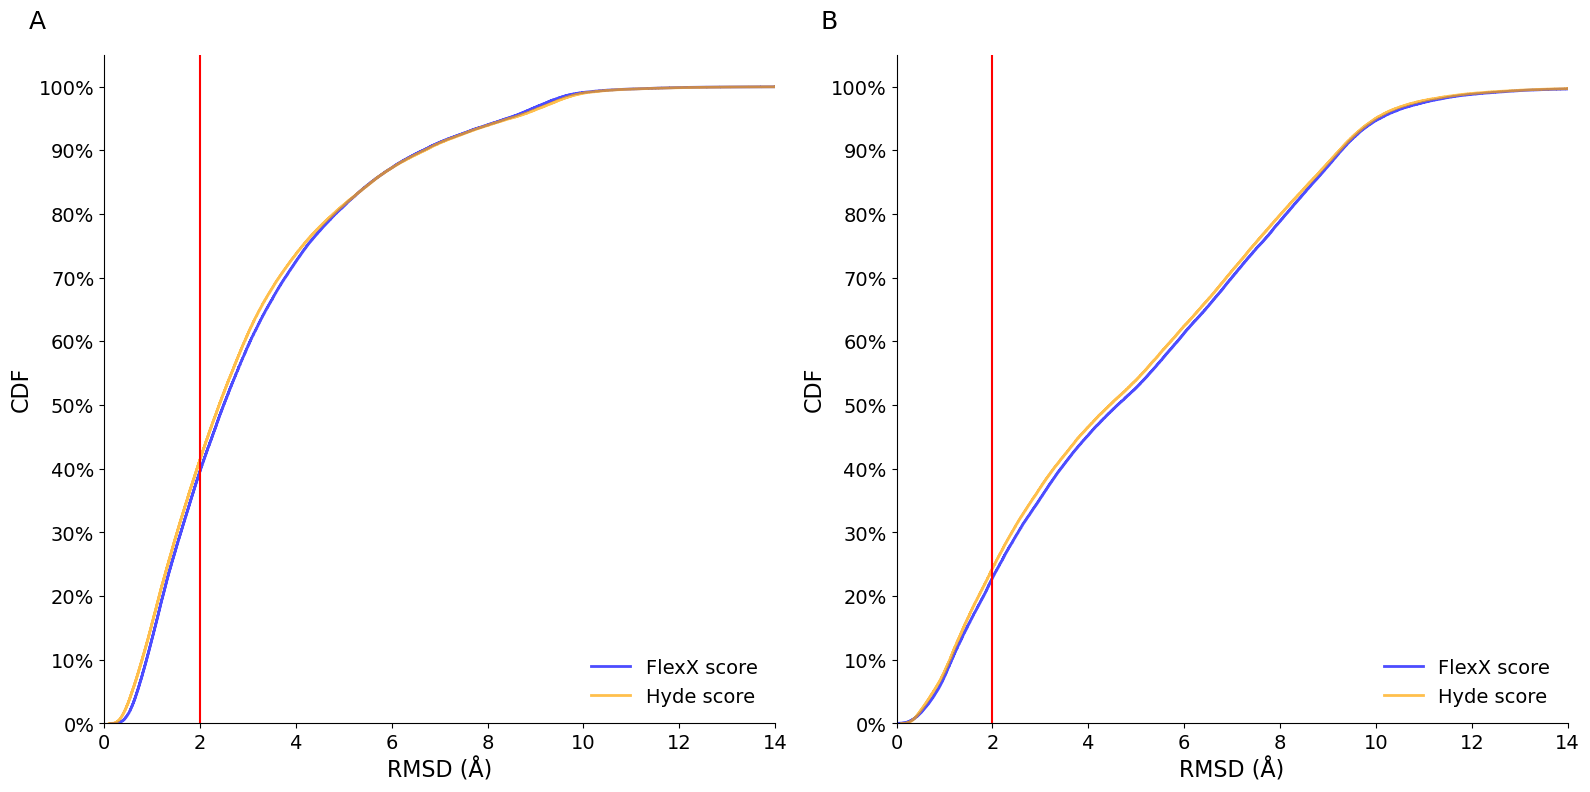

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

bins = np.arange(0, 15, 1)

# --- Plot A ---
ax = axes[0]
ax.ecdf(fd_flexx_rmsd_top1.flexx_rmsd, alpha=0.7, label='FlexX score', linewidth=2, linestyle='-', color='blue')
ax.ecdf(fd_hyde_rmsd_top1.hyde_rmsd, alpha=0.7, label='Hyde score',  linewidth=2, linestyle='-', color='orange')

ax.set_xlabel('RMSD (Å)', fontsize=16)
ax.set_ylabel('CDF', fontsize=16)
ax.legend(fontsize=14, frameon=False)

ax.set_xticks(np.arange(0, 15, 2))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticklabels([f"{int(ytick * 100)}%" for ytick in np.linspace(0, 1, 11)], fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlim(0, 14)
ax.set_ylim(0, 1.05)
ax.axvline(x=2, color='red', linestyle='-')
ax.text(-0.1, 1.05, 'A', fontsize=18, ha='center', va='center', transform=ax.transAxes)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# --- Plot B ---
ax = axes[1]
ax.ecdf(td_flexx_rmsd_top1.flexx_rmsd, alpha=0.7, label='FlexX score', linewidth=2, linestyle='-', color='blue')
ax.ecdf(td_hyde_rmsd_top1.hyde_rmsd, alpha=0.7, label='Hyde score',  linewidth=2, linestyle='-', color='orange')

ax.set_xlabel('RMSD (Å)', fontsize=16)
ax.set_ylabel('CDF', fontsize=16)  # Optional, if you want Y label on both
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticklabels([f"{int(ytick * 100)}%" for ytick in np.linspace(0, 1, 11)], fontsize=14)

ax.legend(fontsize=14, frameon=False)
ax.set_xticks(np.arange(0, 15, 2))
ax.set_xlim(0, 14)
ax.set_ylim(0, 1.05)
ax.axvline(x=2, color='red', linestyle='-')
ax.text(-0.1, 1.05, 'B', fontsize=18, ha='center', va='center', transform=ax.transAxes)
ax.tick_params(axis='x', labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')


# --- Save combined plot ---
plt.tight_layout()
plt.show()
# plt.savefig('paper_images/total_docking_ds_hs.png', dpi=300, bbox_inches='tight', transparent=True)
